# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [7]:
path = '../../../Base de datos/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [8]:
campvectrain = np.load(path + '/campvectrain.npy')

In [9]:
np.shape(campvectrain)

(7000, 2, 20, 20)

### Coeficientes

In [10]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [11]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [12]:
campvectest = np.load(path + '/campvectest.npy')

In [13]:
np.shape(campvectest)

(1000, 2, 20, 20)

### Coeficientes

In [14]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [15]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [16]:
campvecval = np.load(path + '/campvecval.npy')

In [17]:
np.shape(campvecval)

(2000, 2, 20, 20)

### Coeficienes

In [18]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [19]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [21]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 20, 20), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [22]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [23]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 20,20))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 20,20))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 20)
    y2 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 20,20))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 20,20))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 20)
    y22 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [31]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [24]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [25]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [28]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [29]:
def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.000001  # Updated final learning rate
    start_decay_epoch = 200
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr

In [34]:
def scheduler(epoch, lr):
  if epoch < 500:
    return lr
  else:
    return 1e-3 * 0.99 ** epoch

In [36]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2
import optuna

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)

def objective(trial):
    model = Sequential()
    
    model.add(Flatten(input_shape=(2, 20, 20)))  # Tus dimensiones de entrada
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 8)
    
    for i in range(n_dense_layers):
        num_units = trial.suggest_int(f"num_units_{i+1}", 16, 128)
        activation = trial.suggest_categorical(f"dense_activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"dense_kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"dense_kernel_regularizer_{i+1}", ['l1', 'l2'])

        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)

        model.add(Dense(num_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
    
        # Decide si agregar una capa de Dropout después de esta capa densa
        add_dropout = trial.suggest_categorical(f"add_dropout_after_dense_{i+1}", [True, False])
        if add_dropout:
            dropout_rate = trial.suggest_float(f"dropout_rate_after_dense_{i+1}", 0.1, 0.5)
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(7, activation=custom_activation))  # Asumiendo que tienes una función 'custom_activation'
    
    optimizer = Adam(learning_rate=0.001, clipvalue=100.0)
  
    model.compile(optimizer=optimizer, loss= custom_loss, metrics=metrics)
    
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=20,  
        callbacks=[reduce_lr, early_stop]
    )
    
    val_mean_metric = history.history['val_mean_metric'][-1]
    
    return val_mean_metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print(f'Número de trials finalizados: {len(study.trials)}')
print(f'Mejor trial:')
trial = study.best_trial

print(f'  Valor: {trial.value}')
print('  Parámetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-09-22 16:06:40,933] A new study created in memory with name: no-name-cd7375da-aa55-4f07-8512-fbe6dc1c3950


Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 40.8963 - a_1: 2.9015 - a_2: 3.1064 - b_1: 2.8305 - b_2: 2.9775 - d_1: 2.0957 - d_2: 1.8836 - n: 3.1073 - mean_metric: 0.6250 - val_loss: 26.0457 - val_a_1: 2.8477 - val_a_2: 3.0022 - val_b_1: 2.6807 - val_b_2: 2.7418 - val_d_1: 1.3548 - val_d_2: 1.2267 - val_n: 3.2026 - val_mean_metric: 0.5585 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 32.1183 - a_1: 3.0197 - a_2: 3.1377 - b_1: 2.8113 - b_2: 2.9125 - d_1: 1.6059 - d_2: 1.5410 - n: 3.3619 - mean_metric: 0.6080 - val_loss: 25.9336 - val_a_1: 2.8886 - val_a_2: 3.0159 - val_b_1: 2.6770 - val_b_2: 2.6652 - val_d_1: 1.2061 - val_d_2: 1.3561 - val_n: 3.2755 - val_mean_metric: 0.5594 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 32.1808 - a_1: 3.0054 - a_2: 3.1756 - b_1: 2.8642 - b_2: 2.9132 - d_1: 1.5854 - d_2: 1.5796 - n: 3.4391 - mean_metric: 0.6137 - val_loss: 23.8853 - val_a_1: 2.9000 - 

[I 2023-09-22 16:06:48,238] Trial 0 finished with value: 0.5211998224258423 and parameters: {'n_dense_layers': 5, 'num_units_1': 116, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 32, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20732448498999367, 'num_units_3': 95, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.12773126819531633, 'num_units_4': 26, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.3278925433135311, 'num_units_5': 56, 'dense_activation_5': 'relu', 'dense_kernel

Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 35.4501 - a_1: 2.7918 - a_2: 2.8306 - b_1: 2.6967 - b_2: 2.7636 - d_1: 1.6332 - d_2: 1.7334 - n: 1.8639 - mean_metric: 0.5395 - val_loss: 24.1401 - val_a_1: 2.9062 - val_a_2: 2.8665 - val_b_1: 2.6173 - val_b_2: 2.5637 - val_d_1: 1.1848 - val_d_2: 1.1377 - val_n: 1.5478 - val_mean_metric: 0.4854 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 26.9139 - a_1: 2.8676 - a_2: 2.9201 - b_1: 2.6419 - b_2: 2.6901 - d_1: 1.2880 - d_2: 1.2904 - n: 1.5868 - mean_metric: 0.5054 - val_loss: 22.4647 - val_a_1: 2.9053 - val_a_2: 2.9199 - val_b_1: 2.6206 - val_b_2: 2.5663 - val_d_1: 1.0884 - val_d_2: 1.0696 - val_n: 1.5181 - val_mean_metric: 0.4810 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 25.2008 - a_1: 2.8722 - a_2: 2.8857 - b_1: 2.6472 - b_2: 2.6797 - d_1: 1.2117 - d_2: 1.2045 - n: 1.5726 - mean_metric: 0.4984 - val_loss: 23.0149 - val_a_1: 2.9021 - 

[I 2023-09-22 16:06:54,502] Trial 1 finished with value: 0.4831668734550476 and parameters: {'n_dense_layers': 4, 'num_units_1': 77, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.47000957677683874, 'num_units_3': 76, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.44977230133024915, 'num_units_4': 115, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': False}. Best is trial 1 with value: 0.4831668734550476.


Epoch 1/20
70/70 [==============================] - 2s 8ms/step - loss: 35.1460 - a_1: 2.9764 - a_2: 2.9627 - b_1: 2.9889 - b_2: 2.9763 - d_1: 1.7719 - d_2: 1.7335 - n: 2.4987 - mean_metric: 0.5921 - val_loss: 23.3355 - val_a_1: 2.9075 - val_a_2: 2.9054 - val_b_1: 2.9048 - val_b_2: 2.8178 - val_d_1: 1.2599 - val_d_2: 1.1304 - val_n: 2.5433 - val_mean_metric: 0.5393 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 30.0015 - a_1: 2.9984 - a_2: 2.9226 - b_1: 2.9260 - b_2: 3.0685 - d_1: 1.5257 - d_2: 1.4969 - n: 2.7936 - mean_metric: 0.5863 - val_loss: 23.8347 - val_a_1: 2.9168 - val_a_2: 2.9100 - val_b_1: 2.7587 - val_b_2: 2.9966 - val_d_1: 1.1774 - val_d_2: 1.2824 - val_n: 2.7184 - val_mean_metric: 0.5489 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 28.5120 - a_1: 3.0160 - a_2: 2.8883 - b_1: 2.8408 - b_2: 3.0993 - d_1: 1.4375 - d_2: 1.4430 - n: 2.8195 - mean_metric: 0.5801 - val_loss: 22.8013 - val_a_1: 2.8960 - 

[I 2023-09-22 16:07:00,683] Trial 2 finished with value: 0.5458098649978638 and parameters: {'n_dense_layers': 3, 'num_units_1': 45, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3291886034634601, 'num_units_2': 54, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 23, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.34385244066776355}. Best is trial 1 with value: 0.4831668734550476.


Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 56.8565 - a_1: 2.7289 - a_2: 2.7729 - b_1: 2.7773 - b_2: 2.7688 - d_1: 2.6885 - d_2: 2.7171 - n: 2.2375 - mean_metric: 0.6181 - val_loss: 47.2035 - val_a_1: 2.7224 - val_a_2: 2.8188 - val_b_1: 2.7020 - val_b_2: 2.6954 - val_d_1: 2.0364 - val_d_2: 2.4645 - val_n: 2.1284 - val_mean_metric: 0.5754 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 40.8884 - a_1: 2.7816 - a_2: 2.7794 - b_1: 3.0115 - b_2: 2.8751 - d_1: 1.8218 - d_2: 2.0720 - n: 2.1173 - mean_metric: 0.5773 - val_loss: 37.2640 - val_a_1: 2.8010 - val_a_2: 2.9609 - val_b_1: 3.4216 - val_b_2: 2.9673 - val_d_1: 1.7442 - val_d_2: 1.8785 - val_n: 2.2594 - val_mean_metric: 0.5908 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 35.2577 - a_1: 2.7894 - a_2: 2.9941 - b_1: 3.0512 - b_2: 2.9469 - d_1: 1.6211 - d_2: 1.7323 - n: 2.6185 - mean_metric: 0.5872 - val_loss: 32.1970 - val_a_1: 2.7741 - 

[I 2023-09-22 16:07:07,676] Trial 3 finished with value: 0.5533755421638489 and parameters: {'n_dense_layers': 8, 'num_units_1': 37, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 79, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.2615964216442497, 'num_units_4': 86, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.294342334168717, 'num_units_5': 87, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'HeNormal', 'dense_kernel_regula

Epoch 1/20
70/70 [==============================] - 1s 7ms/step - loss: 60.1758 - a_1: 5.0180 - a_2: 4.9328 - b_1: 5.1976 - b_2: 5.0081 - d_1: 2.9513 - d_2: 2.9284 - n: 2.5295 - mean_metric: 0.9443 - val_loss: 53.1545 - val_a_1: 5.0754 - val_a_2: 4.8458 - val_b_1: 5.2942 - val_b_2: 5.0735 - val_d_1: 2.7650 - val_d_2: 2.4400 - val_n: 2.5370 - val_mean_metric: 0.9177 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 55.3722 - a_1: 5.0938 - a_2: 4.9483 - b_1: 5.2764 - b_2: 5.0208 - d_1: 2.8069 - d_2: 2.7296 - n: 2.5294 - mean_metric: 0.9391 - val_loss: 52.1556 - val_a_1: 5.1137 - val_a_2: 4.9033 - val_b_1: 5.4245 - val_b_2: 5.0972 - val_d_1: 2.6958 - val_d_2: 2.4478 - val_n: 2.5370 - val_mean_metric: 0.9239 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 62.1818 - a_1: 5.0924 - a_2: 4.9432 - b_1: 5.2924 - b_2: 5.0243 - d_1: 2.7407 - d_2: 3.6363 - n: 2.5294 - mean_metric: 0.9670 - val_loss: 71.5864 - val_a_1: 5.0719 - 

[I 2023-09-22 16:07:13,370] Trial 4 finished with value: 0.9988683462142944 and parameters: {'n_dense_layers': 1, 'num_units_1': 105, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 1 with value: 0.4831668734550476.


Epoch 1/20
70/70 [==============================] - 1s 7ms/step - loss: 34.6010 - a_1: 3.1447 - a_2: 3.4826 - b_1: 3.0083 - b_2: 3.2642 - d_1: 1.6272 - d_2: 1.6540 - n: 5.6353 - mean_metric: 0.7213 - val_loss: 25.6858 - val_a_1: 2.8840 - val_a_2: 3.2106 - val_b_1: 2.8316 - val_b_2: 2.8808 - val_d_1: 1.2162 - val_d_2: 1.2364 - val_n: 5.5970 - val_mean_metric: 0.6501 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 31.6887 - a_1: 3.1748 - a_2: 3.6217 - b_1: 3.0059 - b_2: 3.3392 - d_1: 1.5290 - d_2: 1.4990 - n: 5.7410 - mean_metric: 0.7242 - val_loss: 24.3770 - val_a_1: 2.9720 - val_a_2: 3.5728 - val_b_1: 2.7624 - val_b_2: 3.1151 - val_d_1: 1.1927 - val_d_2: 1.1638 - val_n: 5.8301 - val_mean_metric: 0.6748 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 30.7078 - a_1: 3.3327 - a_2: 3.6193 - b_1: 2.9743 - b_2: 3.3224 - d_1: 1.4730 - d_2: 1.4734 - n: 4.7490 - mean_metric: 0.6924 - val_loss: 25.2356 - val_a_1: 3.2047 - 

[I 2023-09-22 16:07:18,878] Trial 5 finished with value: 0.6153804063796997 and parameters: {'n_dense_layers': 1, 'num_units_1': 61, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.28388206862856535}. Best is trial 1 with value: 0.4831668734550476.


Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 35.8050 - a_1: 2.8088 - a_2: 2.9214 - b_1: 2.8352 - b_2: 2.8367 - d_1: 1.7936 - d_2: 1.6944 - n: 1.6119 - mean_metric: 0.5457 - val_loss: 21.8145 - val_a_1: 2.7931 - val_a_2: 2.9046 - val_b_1: 2.7886 - val_b_2: 2.6116 - val_d_1: 1.0727 - val_d_2: 1.0935 - val_n: 1.4627 - val_mean_metric: 0.4823 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 26.3212 - a_1: 2.9143 - a_2: 2.9525 - b_1: 2.8218 - b_2: 2.7814 - d_1: 1.3010 - d_2: 1.2871 - n: 1.6702 - mean_metric: 0.5200 - val_loss: 20.1837 - val_a_1: 2.8874 - val_a_2: 2.8736 - val_b_1: 2.7096 - val_b_2: 2.6039 - val_d_1: 0.9797 - val_d_2: 1.0420 - val_n: 1.5981 - val_mean_metric: 0.4812 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 24.7324 - a_1: 2.8868 - a_2: 2.9115 - b_1: 2.7569 - b_2: 2.7545 - d_1: 1.2125 - d_2: 1.2210 - n: 1.7153 - mean_metric: 0.5110 - val_loss: 18.3540 - val_a_1: 2.8450 - 

[I 2023-09-22 16:07:24,773] Trial 6 finished with value: 0.45606541633605957 and parameters: {'n_dense_layers': 3, 'num_units_1': 26, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.24990594627483265, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.45668742908539317, 'num_units_3': 122, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.18464557666632447}. Best is trial 6 with value: 0.45606541633605957.


Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 31.1819 - a_1: 3.1125 - a_2: 3.5013 - b_1: 3.3579 - b_2: 3.5580 - d_1: 1.5129 - d_2: 1.5655 - n: 2.0715 - mean_metric: 0.6177 - val_loss: 23.2675 - val_a_1: 3.1020 - val_a_2: 3.6200 - val_b_1: 3.1904 - val_b_2: 3.2036 - val_d_1: 1.1800 - val_d_2: 1.1535 - val_n: 1.9324 - val_mean_metric: 0.5692 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 27.3295 - a_1: 3.1348 - a_2: 3.5881 - b_1: 3.1687 - b_2: 3.3256 - d_1: 1.3735 - d_2: 1.3700 - n: 2.4228 - mean_metric: 0.6079 - val_loss: 21.7630 - val_a_1: 3.1730 - val_a_2: 3.2324 - val_b_1: 2.8802 - val_b_2: 3.0019 - val_d_1: 1.1020 - val_d_2: 1.0806 - val_n: 2.7030 - val_mean_metric: 0.5624 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 25.8740 - a_1: 3.1348 - a_2: 3.4467 - b_1: 3.0979 - b_2: 3.1528 - d_1: 1.2997 - d_2: 1.3013 - n: 2.2727 - mean_metric: 0.5854 - val_loss: 21.3941 - val_a_1: 2.7744 - 

[I 2023-09-22 16:07:32,856] Trial 7 finished with value: 0.5400768518447876 and parameters: {'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.29033256107455246, 'num_units_2': 41, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 6 with value: 0.45606541633605957.


Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 41.8017 - a_1: 2.9072 - a_2: 3.0481 - b_1: 3.0089 - b_2: 2.9235 - d_1: 2.0198 - d_2: 1.8458 - n: 2.6813 - mean_metric: 0.6097 - val_loss: 27.6672 - val_a_1: 2.8096 - val_a_2: 2.8957 - val_b_1: 2.9453 - val_b_2: 2.8128 - val_d_1: 1.2552 - val_d_2: 1.2319 - val_n: 2.8119 - val_mean_metric: 0.5489 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 31.3947 - a_1: 2.8327 - a_2: 2.9039 - b_1: 2.9321 - b_2: 2.9191 - d_1: 1.4647 - d_2: 1.4372 - n: 2.8517 - mean_metric: 0.5733 - val_loss: 24.6100 - val_a_1: 2.7696 - val_a_2: 2.8813 - val_b_1: 2.8705 - val_b_2: 2.7741 - val_d_1: 1.0873 - val_d_2: 1.1933 - val_n: 2.6546 - val_mean_metric: 0.5316 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 29.9334 - a_1: 2.8252 - a_2: 2.8777 - b_1: 2.8912 - b_2: 2.9505 - d_1: 1.3909 - d_2: 1.3888 - n: 2.8026 - mean_metric: 0.5664 - val_loss: 23.1010 - val_a_1: 2.7530 - 

[I 2023-09-22 16:07:39,495] Trial 8 finished with value: 0.552306592464447 and parameters: {'n_dense_layers': 7, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 25, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4501897721015419, 'num_units_3': 108, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False, 'num_units_4': 44, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 72, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l1', 'add_dropout_after_dense_5': T

Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 46.6721 - a_1: 2.8431 - a_2: 2.9391 - b_1: 2.8910 - b_2: 2.9516 - d_1: 2.2433 - d_2: 2.1033 - n: 1.7331 - mean_metric: 0.5853 - val_loss: 28.5450 - val_a_1: 2.7346 - val_a_2: 2.8024 - val_b_1: 2.6247 - val_b_2: 2.6792 - val_d_1: 1.4129 - val_d_2: 1.2065 - val_n: 1.5153 - val_mean_metric: 0.4905 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 30.8981 - a_1: 2.7794 - a_2: 2.8649 - b_1: 2.7309 - b_2: 2.8290 - d_1: 1.4368 - d_2: 1.4118 - n: 1.6877 - mean_metric: 0.5204 - val_loss: 23.5930 - val_a_1: 2.8095 - val_a_2: 2.8224 - val_b_1: 2.6879 - val_b_2: 2.6610 - val_d_1: 1.0858 - val_d_2: 1.0763 - val_n: 1.6189 - val_mean_metric: 0.4835 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 27.8949 - a_1: 2.8025 - a_2: 2.8746 - b_1: 2.7492 - b_2: 2.7647 - d_1: 1.2983 - d_2: 1.2676 - n: 1.7013 - mean_metric: 0.5111 - val_loss: 22.4093 - val_a_1: 2.8250 - 

[I 2023-09-22 16:07:45,784] Trial 9 finished with value: 0.474286824464798 and parameters: {'n_dense_layers': 5, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.42246036951167576, 'num_units_2': 90, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 102, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 67, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.3924820633233549, 'num_units_5': 104, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'HeNormal', 'dense_kernel_regu

Epoch 1/20
70/70 [==============================] - 2s 8ms/step - loss: 41.3730 - a_1: 2.8262 - a_2: 2.9425 - b_1: 3.1493 - b_2: 2.9145 - d_1: 2.1118 - d_2: 1.8880 - n: 2.1719 - mean_metric: 0.5953 - val_loss: 26.5962 - val_a_1: 2.7927 - val_a_2: 2.9679 - val_b_1: 3.1349 - val_b_2: 2.7642 - val_d_1: 1.4168 - val_d_2: 1.2019 - val_n: 2.1114 - val_mean_metric: 0.5367 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 30.8722 - a_1: 2.8164 - a_2: 3.0369 - b_1: 3.1425 - b_2: 2.9524 - d_1: 1.5071 - d_2: 1.4842 - n: 2.1640 - mean_metric: 0.5655 - val_loss: 24.3922 - val_a_1: 2.7415 - val_a_2: 2.9107 - val_b_1: 3.0218 - val_b_2: 2.6186 - val_d_1: 1.2385 - val_d_2: 1.1329 - val_n: 1.8573 - val_mean_metric: 0.5083 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 28.7402 - a_1: 2.7878 - a_2: 2.9685 - b_1: 3.0240 - b_2: 2.8976 - d_1: 1.4179 - d_2: 1.3830 - n: 1.9699 - mean_metric: 0.5438 - val_loss: 22.4418 - val_a_1: 2.7485 - 

[I 2023-09-22 16:07:52,381] Trial 10 finished with value: 0.4470256268978119 and parameters: {'n_dense_layers': 6, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.11923316379383, 'num_units_2': 118, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3261198352858603, 'num_units_3': 124, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.10508352047179409, 'num_units_4': 126, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 23, 'dense_activation_5': 'sigmoid', 'dense_kernel_init

Epoch 1/20
70/70 [==============================] - 2s 10ms/step - loss: 40.2277 - a_1: 2.9202 - a_2: 2.9943 - b_1: 2.7299 - b_2: 3.0280 - d_1: 2.0681 - d_2: 1.8450 - n: 2.2329 - mean_metric: 0.5891 - val_loss: 26.1849 - val_a_1: 2.8662 - val_a_2: 3.0158 - val_b_1: 2.6530 - val_b_2: 3.0102 - val_d_1: 1.3341 - val_d_2: 1.2447 - val_n: 2.3335 - val_mean_metric: 0.5390 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 29.5082 - a_1: 2.8695 - a_2: 3.0015 - b_1: 2.7370 - b_2: 3.0061 - d_1: 1.4988 - d_2: 1.3841 - n: 2.3539 - mean_metric: 0.5572 - val_loss: 22.8567 - val_a_1: 2.7361 - val_a_2: 3.0312 - val_b_1: 2.6609 - val_b_2: 2.9015 - val_d_1: 1.1909 - val_d_2: 1.0541 - val_n: 1.9213 - val_mean_metric: 0.5075 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 27.1335 - a_1: 2.8205 - a_2: 2.9885 - b_1: 2.7486 - b_2: 2.8858 - d_1: 1.3563 - d_2: 1.3058 - n: 1.8970 - mean_metric: 0.5291 - val_loss: 21.5789 - val_a_1: 2.7411 -

[I 2023-09-22 16:08:01,694] Trial 11 finished with value: 0.4547281265258789 and parameters: {'n_dense_layers': 6, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10092150967818234, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.33047227222298536, 'num_units_3': 127, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.10101028953238621, 'num_units_4': 122, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 18, 'dense_activation_5': 'sigmoid', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 45.6008 - a_1: 2.9506 - a_2: 2.8297 - b_1: 2.8022 - b_2: 2.8914 - d_1: 1.8203 - d_2: 2.6231 - n: 1.8623 - mean_metric: 0.5878 - val_loss: 34.1859 - val_a_1: 2.9983 - val_a_2: 2.8500 - val_b_1: 2.7631 - val_b_2: 2.7914 - val_d_1: 1.2560 - val_d_2: 2.0985 - val_n: 1.7686 - val_mean_metric: 0.5411 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 30.8721 - a_1: 2.8805 - a_2: 2.8467 - b_1: 2.7883 - b_2: 2.8524 - d_1: 1.3786 - d_2: 1.6792 - n: 1.7871 - mean_metric: 0.5360 - val_loss: 23.3636 - val_a_1: 2.8338 - val_a_2: 2.8146 - val_b_1: 2.7567 - val_b_2: 2.8641 - val_d_1: 1.0992 - val_d_2: 1.2308 - val_n: 1.6838 - val_mean_metric: 0.5004 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 27.2968 - a_1: 2.8523 - a_2: 2.8015 - b_1: 2.7612 - b_2: 2.8913 - d_1: 1.3107 - d_2: 1.4004 - n: 1.8126 - mean_metric: 0.5234 - val_loss: 21.2004 - val_a_1: 2.7983 - 

[I 2023-09-22 16:08:09,351] Trial 12 finished with value: 0.46008437871932983 and parameters: {'n_dense_layers': 6, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10817602690843692, 'num_units_2': 125, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3067806908199223, 'num_units_3': 42, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.11453829015377957, 'num_units_4': 123, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 16, 'dense_activation_5': 'sigmoid', 'dense_kernel_i

Epoch 1/20
70/70 [==============================] - 2s 10ms/step - loss: 43.9388 - a_1: 2.7502 - a_2: 2.7656 - b_1: 2.6901 - b_2: 2.8955 - d_1: 1.8976 - d_2: 2.1732 - n: 2.6645 - mean_metric: 0.5898 - val_loss: 25.7861 - val_a_1: 2.7481 - val_a_2: 2.7815 - val_b_1: 2.6744 - val_b_2: 2.8233 - val_d_1: 1.1431 - val_d_2: 1.2431 - val_n: 2.1293 - val_mean_metric: 0.5090 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 29.8028 - a_1: 2.7484 - a_2: 2.8072 - b_1: 2.7352 - b_2: 2.8017 - d_1: 1.3628 - d_2: 1.4053 - n: 2.1400 - mean_metric: 0.5290 - val_loss: 23.3387 - val_a_1: 2.7565 - val_a_2: 2.8271 - val_b_1: 2.6995 - val_b_2: 2.6810 - val_d_1: 1.0473 - val_d_2: 1.1293 - val_n: 2.1095 - val_mean_metric: 0.4994 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 26.7087 - a_1: 2.7626 - a_2: 2.8169 - b_1: 2.7071 - b_2: 2.7543 - d_1: 1.2388 - d_2: 1.2425 - n: 2.0422 - mean_metric: 0.5146 - val_loss: 21.8415 - val_a_1: 2.7395 -

[I 2023-09-22 16:08:18,987] Trial 13 finished with value: 0.4687541127204895 and parameters: {'n_dense_layers': 7, 'num_units_1': 82, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10050292678691154, 'num_units_2': 123, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.31142362743218277, 'num_units_3': 124, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.10908420739104807, 'num_units_4': 98, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 16, 'dense_activation_5': 'sigmoid', 'dense_kernel_i

Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 50.9671 - a_1: 2.8101 - a_2: 2.8052 - b_1: 2.7748 - b_2: 2.7527 - d_1: 2.4138 - d_2: 2.5260 - n: 2.4763 - mean_metric: 0.6137 - val_loss: 27.7918 - val_a_1: 2.7912 - val_a_2: 2.7931 - val_b_1: 2.5968 - val_b_2: 2.5891 - val_d_1: 1.3190 - val_d_2: 1.4315 - val_n: 2.6527 - val_mean_metric: 0.5297 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 30.7428 - a_1: 2.8247 - a_2: 2.9173 - b_1: 2.7030 - b_2: 2.7299 - d_1: 1.5072 - d_2: 1.4849 - n: 2.1985 - mean_metric: 0.5411 - val_loss: 24.8087 - val_a_1: 2.7505 - val_a_2: 2.9291 - val_b_1: 2.6059 - val_b_2: 2.5828 - val_d_1: 1.2684 - val_d_2: 1.1768 - val_n: 1.7344 - val_mean_metric: 0.4928 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 29.4272 - a_1: 2.8011 - a_2: 2.9415 - b_1: 2.6941 - b_2: 2.7106 - d_1: 1.4761 - d_2: 1.3862 - n: 1.8763 - mean_metric: 0.5252 - val_loss: 26.6218 - val_a_1: 2.7682 - 

[I 2023-09-22 16:08:26,776] Trial 14 finished with value: 0.48899757862091064 and parameters: {'n_dense_layers': 6, 'num_units_1': 16, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.17107378212130323, 'num_units_2': 115, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.34238359884441355, 'num_units_3': 128, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False, 'num_units_4': 128, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 43, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'random_normal', 'dense_

Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 40.7534 - a_1: 2.9367 - a_2: 2.9932 - b_1: 2.8156 - b_2: 2.8399 - d_1: 1.9765 - d_2: 1.9327 - n: 2.4076 - mean_metric: 0.5919 - val_loss: 26.8681 - val_a_1: 2.8536 - val_a_2: 2.9333 - val_b_1: 2.7606 - val_b_2: 2.8412 - val_d_1: 1.3114 - val_d_2: 1.2550 - val_n: 2.3746 - val_mean_metric: 0.5348 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 4ms/step - loss: 32.8681 - a_1: 2.9362 - a_2: 3.0325 - b_1: 2.8459 - b_2: 2.9907 - d_1: 1.5859 - d_2: 1.5515 - n: 2.5252 - mean_metric: 0.5775 - val_loss: 24.3145 - val_a_1: 2.8600 - val_a_2: 2.9433 - val_b_1: 2.7782 - val_b_2: 2.8393 - val_d_1: 1.1616 - val_d_2: 1.1881 - val_n: 2.4879 - val_mean_metric: 0.5325 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 4ms/step - loss: 29.9760 - a_1: 2.9079 - a_2: 3.0248 - b_1: 2.8123 - b_2: 3.0046 - d_1: 1.4291 - d_2: 1.4352 - n: 2.8177 - mean_metric: 0.5764 - val_loss: 22.1290 - val_a_1: 2.8452 - 

[I 2023-09-22 16:08:34,078] Trial 15 finished with value: 0.47806525230407715 and parameters: {'n_dense_layers': 8, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.184057955509564, 'num_units_2': 108, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20356842567223046, 'num_units_3': 54, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.20650254311555188, 'num_units_4': 101, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 38, 'dense_activation_5': 'tanh', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 45.3759 - a_1: 2.8281 - a_2: 2.8816 - b_1: 2.9116 - b_2: 2.8806 - d_1: 2.0936 - d_2: 2.2058 - n: 2.5244 - mean_metric: 0.6060 - val_loss: 27.3397 - val_a_1: 2.8085 - val_a_2: 2.8841 - val_b_1: 2.7589 - val_b_2: 2.6567 - val_d_1: 1.3168 - val_d_2: 1.2737 - val_n: 2.7008 - val_mean_metric: 0.5371 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 33.7491 - a_1: 2.9518 - a_2: 2.9062 - b_1: 2.9254 - b_2: 2.8144 - d_1: 1.6243 - d_2: 1.5971 - n: 3.0442 - mean_metric: 0.5907 - val_loss: 23.7913 - val_a_1: 2.9282 - val_a_2: 2.8152 - val_b_1: 2.7319 - val_b_2: 2.6013 - val_d_1: 1.1359 - val_d_2: 1.1291 - val_n: 3.1194 - val_mean_metric: 0.5392 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 32.5199 - a_1: 2.9503 - a_2: 2.9310 - b_1: 2.9131 - b_2: 2.7808 - d_1: 1.5551 - d_2: 1.5525 - n: 3.2108 - mean_metric: 0.5916 - val_loss: 23.0402 - val_a_1: 2.9163 -

[I 2023-09-22 16:08:43,936] Trial 16 finished with value: 0.523316502571106 and parameters: {'n_dense_layers': 6, 'num_units_1': 58, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.16907066035283658, 'num_units_2': 82, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3744808780683929, 'num_units_3': 93, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.10032086057779414, 'num_units_4': 73, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 126, 'dense_activation_5': 'sigmoid', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 2s 10ms/step - loss: 38.9507 - a_1: 2.8620 - a_2: 3.0360 - b_1: 2.8439 - b_2: 2.9791 - d_1: 1.7311 - d_2: 1.6797 - n: 4.1312 - mean_metric: 0.6369 - val_loss: 27.5881 - val_a_1: 2.8190 - val_a_2: 3.2711 - val_b_1: 2.6913 - val_b_2: 2.9105 - val_d_1: 1.1576 - val_d_2: 1.2069 - val_n: 5.2126 - val_mean_metric: 0.6310 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 32.1652 - a_1: 2.9635 - a_2: 3.0904 - b_1: 2.8299 - b_2: 2.9663 - d_1: 1.3926 - d_2: 1.3997 - n: 4.5140 - mean_metric: 0.6334 - val_loss: 28.4555 - val_a_1: 3.0267 - val_a_2: 2.9161 - val_b_1: 2.7113 - val_b_2: 2.9453 - val_d_1: 1.2564 - val_d_2: 1.1531 - val_n: 4.5601 - val_mean_metric: 0.6080 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 30.8152 - a_1: 2.9454 - a_2: 3.0097 - b_1: 2.8678 - b_2: 2.9214 - d_1: 1.3315 - d_2: 1.3498 - n: 3.6315 - mean_metric: 0.5971 - val_loss: 26.3257 - val_a_1: 2.9711 -

[I 2023-09-22 16:08:52,741] Trial 17 finished with value: 0.490221232175827 and parameters: {'n_dense_layers': 4, 'num_units_1': 92, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1084223037599881, 'num_units_2': 62, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25077216302026795, 'num_units_3': 112, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 108, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False}. Best is trial 10 with value: 0.4470256268978119.


Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 56.5918 - a_1: 2.9717 - a_2: 2.9964 - b_1: 2.8943 - b_2: 2.9465 - d_1: 2.6910 - d_2: 2.6420 - n: 2.1479 - mean_metric: 0.6379 - val_loss: 44.0094 - val_a_1: 2.7895 - val_a_2: 2.8030 - val_b_1: 2.7396 - val_b_2: 2.6857 - val_d_1: 1.9635 - val_d_2: 2.1418 - val_n: 1.4799 - val_mean_metric: 0.5437 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 46.3146 - a_1: 2.9123 - a_2: 2.9208 - b_1: 2.9218 - b_2: 2.9526 - d_1: 2.2775 - d_2: 2.0804 - n: 1.7012 - mean_metric: 0.5874 - val_loss: 38.9489 - val_a_1: 2.7637 - val_a_2: 2.8477 - val_b_1: 2.9057 - val_b_2: 2.7625 - val_d_1: 2.1713 - val_d_2: 1.4446 - val_n: 1.6979 - val_mean_metric: 0.5434 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 40.1503 - a_1: 2.9104 - a_2: 2.9812 - b_1: 2.9493 - b_2: 3.0413 - d_1: 1.9388 - d_2: 1.8058 - n: 1.6839 - mean_metric: 0.5724 - val_loss: 29.9555 - val_a_1: 2.8792 -

[I 2023-09-22 16:09:02,238] Trial 18 finished with value: 0.4986424744129181 and parameters: {'n_dense_layers': 7, 'num_units_1': 63, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2151444791376861, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.12140892494997246, 'num_units_3': 60, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.1892115005183935, 'num_units_4': 79, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 30, 'dense_activation_5': 'sigmoid', 'dense_kernel_i

Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 42.6790 - a_1: 2.8167 - a_2: 2.8078 - b_1: 2.7287 - b_2: 2.7087 - d_1: 2.1373 - d_2: 1.9196 - n: 2.6705 - mean_metric: 0.5883 - val_loss: 26.7881 - val_a_1: 2.8748 - val_a_2: 2.9058 - val_b_1: 2.7331 - val_b_2: 2.5808 - val_d_1: 1.2780 - val_d_2: 1.2669 - val_n: 2.9797 - val_mean_metric: 0.5444 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 30.5520 - a_1: 2.8591 - a_2: 2.8272 - b_1: 2.7676 - b_2: 2.7028 - d_1: 1.4858 - d_2: 1.4245 - n: 2.8553 - mean_metric: 0.5596 - val_loss: 24.4469 - val_a_1: 2.8406 - val_a_2: 2.8717 - val_b_1: 2.7847 - val_b_2: 2.6134 - val_d_1: 1.2086 - val_d_2: 1.1294 - val_n: 2.9802 - val_mean_metric: 0.5381 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 29.0519 - a_1: 2.8325 - a_2: 2.8172 - b_1: 2.7495 - b_2: 2.7157 - d_1: 1.4105 - d_2: 1.3558 - n: 2.9882 - mean_metric: 0.5578 - val_loss: 24.3973 - val_a_1: 2.8087 - 

[I 2023-09-22 16:09:10,930] Trial 19 finished with value: 0.5076318383216858 and parameters: {'n_dense_layers': 5, 'num_units_1': 35, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.15002703476426435, 'num_units_2': 110, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3860344386473473, 'num_units_3': 88, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.2852528495236205, 'num_units_4': 58, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.10611194378123628, 'num_units_5': 56

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 38.5039 - a_1: 2.8031 - a_2: 2.7563 - b_1: 2.7149 - b_2: 2.7393 - d_1: 1.7544 - d_2: 2.0050 - n: 2.3354 - mean_metric: 0.5659 - val_loss: 22.0455 - val_a_1: 2.8104 - val_a_2: 2.7988 - val_b_1: 2.7619 - val_b_2: 2.5527 - val_d_1: 1.1155 - val_d_2: 1.0811 - val_n: 2.1298 - val_mean_metric: 0.4995 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 23.1775 - a_1: 2.7927 - a_2: 2.7859 - b_1: 2.7281 - b_2: 2.6782 - d_1: 1.1405 - d_2: 1.1556 - n: 2.2080 - mean_metric: 0.5121 - val_loss: 21.0271 - val_a_1: 2.7697 - val_a_2: 2.7850 - val_b_1: 2.7113 - val_b_2: 2.5631 - val_d_1: 1.0132 - val_d_2: 1.0789 - val_n: 2.1004 - val_mean_metric: 0.4920 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 20.8419 - a_1: 2.7473 - a_2: 2.7797 - b_1: 2.6967 - b_2: 2.6885 - d_1: 1.0303 - d_2: 1.0313 - n: 2.2233 - mean_metric: 0.5026 - val_loss: 17.2376 - val_a_1: 2.7354 -

[I 2023-09-22 16:09:21,545] Trial 20 finished with value: 0.5017246007919312 and parameters: {'n_dense_layers': 6, 'num_units_1': 23, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.20941528149558286, 'num_units_2': 87, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 112, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.17778540398458614, 'num_units_4': 93, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 29, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'random_normal', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 2s 10ms/step - loss: 33.5646 - a_1: 2.9175 - a_2: 3.1298 - b_1: 2.8755 - b_2: 2.7789 - d_1: 1.6547 - d_2: 1.6253 - n: 3.5721 - mean_metric: 0.6137 - val_loss: 20.3993 - val_a_1: 2.8637 - val_a_2: 2.8132 - val_b_1: 2.9344 - val_b_2: 2.5548 - val_d_1: 1.0523 - val_d_2: 1.0158 - val_n: 2.4953 - val_mean_metric: 0.5151 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 25.2886 - a_1: 2.8779 - a_2: 2.9426 - b_1: 2.9031 - b_2: 2.7353 - d_1: 1.2584 - d_2: 1.2303 - n: 2.7343 - mean_metric: 0.5515 - val_loss: 19.8679 - val_a_1: 2.9253 - val_a_2: 2.8593 - val_b_1: 2.8368 - val_b_2: 2.5738 - val_d_1: 0.9828 - val_d_2: 1.0152 - val_n: 2.8054 - val_mean_metric: 0.5239 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 24.3679 - a_1: 2.8852 - a_2: 2.8937 - b_1: 2.8539 - b_2: 2.7395 - d_1: 1.2069 - d_2: 1.1850 - n: 2.6027 - mean_metric: 0.5412 - val_loss: 18.9830 - val_a_1: 2.8895 -

[I 2023-09-22 16:09:31,286] Trial 21 finished with value: 0.46431341767311096 and parameters: {'n_dense_layers': 3, 'num_units_1': 26, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.24751274535660187, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.41238088493957337, 'num_units_3': 122, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.1612176769105278}. Best is trial 10 with value: 0.4470256268978119.


Epoch 1/20
70/70 [==============================] - 2s 10ms/step - loss: 34.1275 - a_1: 2.8623 - a_2: 2.9964 - b_1: 2.7734 - b_2: 2.7297 - d_1: 1.6606 - d_2: 1.6332 - n: 1.7103 - mean_metric: 0.5413 - val_loss: 23.8746 - val_a_1: 2.8273 - val_a_2: 2.8838 - val_b_1: 2.6767 - val_b_2: 2.5727 - val_d_1: 1.1870 - val_d_2: 1.1222 - val_n: 1.5662 - val_mean_metric: 0.4858 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 26.0317 - a_1: 2.8666 - a_2: 2.9189 - b_1: 2.7147 - b_2: 2.7381 - d_1: 1.2407 - d_2: 1.2811 - n: 1.6529 - mean_metric: 0.5095 - val_loss: 20.3208 - val_a_1: 2.8531 - val_a_2: 2.8912 - val_b_1: 2.6465 - val_b_2: 2.5972 - val_d_1: 0.9886 - val_d_2: 1.0174 - val_n: 1.6907 - val_mean_metric: 0.4809 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 24.4520 - a_1: 2.8774 - a_2: 2.9100 - b_1: 2.7304 - b_2: 2.7660 - d_1: 1.1999 - d_2: 1.1702 - n: 1.8139 - mean_metric: 0.5115 - val_loss: 19.3807 - val_a_1: 2.8599 -

[I 2023-09-22 16:09:40,001] Trial 22 finished with value: 0.47798553109169006 and parameters: {'n_dense_layers': 3, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.13356143763493836, 'num_units_2': 117, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.48962187439410276, 'num_units_3': 117, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.15983520569366935}. Best is trial 10 with value: 0.4470256268978119.


Epoch 1/20
70/70 [==============================] - 2s 9ms/step - loss: 33.8583 - a_1: 3.0044 - a_2: 2.9299 - b_1: 2.9901 - b_2: 2.7315 - d_1: 1.6148 - d_2: 1.6904 - n: 3.4156 - mean_metric: 0.6078 - val_loss: 20.2615 - val_a_1: 3.1058 - val_a_2: 2.9107 - val_b_1: 2.7085 - val_b_2: 2.5744 - val_d_1: 1.0430 - val_d_2: 1.0022 - val_n: 3.0040 - val_mean_metric: 0.5353 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 24.5464 - a_1: 2.9364 - a_2: 2.9297 - b_1: 2.7497 - b_2: 2.7002 - d_1: 1.2288 - d_2: 1.1905 - n: 3.0645 - mean_metric: 0.5554 - val_loss: 18.9517 - val_a_1: 2.8887 - val_a_2: 2.9722 - val_b_1: 2.7302 - val_b_2: 2.5655 - val_d_1: 0.9925 - val_d_2: 0.8977 - val_n: 2.8840 - val_mean_metric: 0.5217 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 23.0667 - a_1: 2.8643 - a_2: 2.9233 - b_1: 2.7211 - b_2: 2.7040 - d_1: 1.1545 - d_2: 1.1179 - n: 2.3512 - mean_metric: 0.5236 - val_loss: 16.7941 - val_a_1: 2.9096 - 

[I 2023-09-22 16:09:48,058] Trial 23 finished with value: 0.45426666736602783 and parameters: {'n_dense_layers': 4, 'num_units_1': 16, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.144439135329233, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4314887659284991, 'num_units_3': 126, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.10101246579498883, 'num_units_4': 116, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False}. Best is trial 10 with value: 0.4470256268978119.


Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 33.8331 - a_1: 2.7624 - a_2: 2.8829 - b_1: 2.8357 - b_2: 2.7638 - d_1: 1.4504 - d_2: 1.4857 - n: 1.7683 - mean_metric: 0.5273 - val_loss: 25.4173 - val_a_1: 2.8402 - val_a_2: 2.9049 - val_b_1: 2.7513 - val_b_2: 2.6001 - val_d_1: 1.1138 - val_d_2: 1.0502 - val_n: 1.8557 - val_mean_metric: 0.4950 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 27.8687 - a_1: 2.7910 - a_2: 2.8744 - b_1: 2.7332 - b_2: 2.7342 - d_1: 1.2096 - d_2: 1.2061 - n: 1.8332 - mean_metric: 0.5085 - val_loss: 23.2890 - val_a_1: 2.7776 - val_a_2: 2.9099 - val_b_1: 2.6465 - val_b_2: 2.5627 - val_d_1: 1.0123 - val_d_2: 1.0106 - val_n: 1.7226 - val_mean_metric: 0.4795 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 26.8231 - a_1: 2.7743 - a_2: 2.8569 - b_1: 2.6644 - b_2: 2.7144 - d_1: 1.1777 - d_2: 1.1625 - n: 1.8163 - mean_metric: 0.5014 - val_loss: 22.1784 - val_a_1: 2.8088 -

[I 2023-09-22 16:09:58,738] Trial 24 finished with value: 0.48190218210220337 and parameters: {'n_dense_layers': 4, 'num_units_1': 127, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1427492345115255, 'num_units_2': 117, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3387348079000694, 'num_units_3': 102, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.10113693432977294, 'num_units_4': 116, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False}. Best is trial 10 with value: 0.4470256268978119.


Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 37.6666 - a_1: 2.8118 - a_2: 3.0057 - b_1: 2.7720 - b_2: 2.8655 - d_1: 1.7785 - d_2: 1.7934 - n: 2.0331 - mean_metric: 0.5642 - val_loss: 23.9459 - val_a_1: 2.7667 - val_a_2: 2.9119 - val_b_1: 2.6730 - val_b_2: 2.8753 - val_d_1: 1.2003 - val_d_2: 1.1286 - val_n: 1.5781 - val_mean_metric: 0.4957 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 29.1444 - a_1: 2.7734 - a_2: 2.8121 - b_1: 2.6898 - b_2: 2.9191 - d_1: 1.4188 - d_2: 1.3759 - n: 1.6347 - mean_metric: 0.5167 - val_loss: 22.6087 - val_a_1: 2.7876 - val_a_2: 2.8566 - val_b_1: 2.6260 - val_b_2: 2.7562 - val_d_1: 1.1093 - val_d_2: 1.0796 - val_n: 1.5781 - val_mean_metric: 0.4844 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 27.0008 - a_1: 2.8017 - a_2: 2.8278 - b_1: 2.6523 - b_2: 2.8591 - d_1: 1.2868 - d_2: 1.3147 - n: 1.6224 - mean_metric: 0.5080 - val_loss: 22.6611 - val_a_1: 2.8352 -

[I 2023-09-22 16:10:09,878] Trial 25 finished with value: 0.4828445315361023 and parameters: {'n_dense_layers': 5, 'num_units_1': 20, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10171133963456683, 'num_units_2': 96, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.41889133946252366, 'num_units_3': 108, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False, 'num_units_4': 128, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 54, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'random_normal', 'dense_kernel_regula

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 33.0495 - a_1: 3.0158 - a_2: 3.0873 - b_1: 2.7493 - b_2: 3.0075 - d_1: 1.6100 - d_2: 1.4573 - n: 3.3402 - mean_metric: 0.6043 - val_loss: 24.7899 - val_a_1: 2.9951 - val_a_2: 2.8357 - val_b_1: 2.7218 - val_b_2: 2.8595 - val_d_1: 1.1828 - val_d_2: 1.1094 - val_n: 3.3436 - val_mean_metric: 0.5585 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 24.6105 - a_1: 2.9251 - a_2: 2.8067 - b_1: 2.7011 - b_2: 2.8290 - d_1: 1.1535 - d_2: 1.1469 - n: 3.6082 - mean_metric: 0.5677 - val_loss: 21.8270 - val_a_1: 2.8966 - val_a_2: 2.8906 - val_b_1: 2.6428 - val_b_2: 2.6335 - val_d_1: 0.9990 - val_d_2: 1.0388 - val_n: 3.6802 - val_mean_metric: 0.5497 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 22.7483 - a_1: 2.8605 - a_2: 2.8505 - b_1: 2.6566 - b_2: 2.7035 - d_1: 1.0814 - d_2: 1.0603 - n: 3.5291 - mean_metric: 0.5535 - val_loss: 19.5263 - val_a_1: 2.8849 -

[I 2023-09-22 16:10:20,971] Trial 26 finished with value: 0.45137158036231995 and parameters: {'n_dense_layers': 7, 'num_units_1': 16, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 110, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.365388512246091, 'num_units_3': 125, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.22944889268058616, 'num_units_4': 110, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 76, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regula

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 31.6154 - a_1: 3.0554 - a_2: 2.8579 - b_1: 2.7799 - b_2: 2.8938 - d_1: 1.4221 - d_2: 1.5608 - n: 3.4039 - mean_metric: 0.5943 - val_loss: 22.1816 - val_a_1: 2.9654 - val_a_2: 2.8052 - val_b_1: 2.6854 - val_b_2: 2.6952 - val_d_1: 1.0251 - val_d_2: 1.0752 - val_n: 3.3072 - val_mean_metric: 0.5423 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 23.9727 - a_1: 2.9023 - a_2: 2.8175 - b_1: 2.6806 - b_2: 2.7481 - d_1: 1.1199 - d_2: 1.1362 - n: 2.9192 - mean_metric: 0.5398 - val_loss: 20.7883 - val_a_1: 2.8664 - val_a_2: 2.8511 - val_b_1: 2.6836 - val_b_2: 2.5520 - val_d_1: 0.9783 - val_d_2: 0.9655 - val_n: 2.5485 - val_mean_metric: 0.5058 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 22.2116 - a_1: 2.8215 - a_2: 2.8622 - b_1: 2.6789 - b_2: 2.7272 - d_1: 1.0423 - d_2: 1.0320 - n: 2.2561 - mean_metric: 0.5099 - val_loss: 19.7064 - val_a_1: 2.8419 -

[I 2023-09-22 16:10:30,486] Trial 27 finished with value: 0.4350786507129669 and parameters: {'n_dense_layers': 7, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3910677968991412, 'num_units_3': 84, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.23011282752718354, 'num_units_4': 106, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 81, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regulari

Epoch 1/20
70/70 [==============================] - 2s 10ms/step - loss: 29.9330 - a_1: 2.8520 - a_2: 2.7953 - b_1: 2.6738 - b_2: 2.9559 - d_1: 1.5273 - d_2: 1.3337 - n: 3.4354 - mean_metric: 0.5810 - val_loss: 25.3695 - val_a_1: 2.8684 - val_a_2: 2.8136 - val_b_1: 2.6591 - val_b_2: 2.7032 - val_d_1: 1.3629 - val_d_2: 1.0735 - val_n: 3.9707 - val_mean_metric: 0.5715 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 5ms/step - loss: 24.1396 - a_1: 2.8793 - a_2: 2.8489 - b_1: 2.6260 - b_2: 2.8032 - d_1: 1.1857 - d_2: 1.1589 - n: 3.8869 - mean_metric: 0.5750 - val_loss: 22.5405 - val_a_1: 2.9294 - val_a_2: 2.8889 - val_b_1: 2.6243 - val_b_2: 2.6497 - val_d_1: 1.1328 - val_d_2: 1.0338 - val_n: 3.7815 - val_mean_metric: 0.5580 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 5ms/step - loss: 22.3624 - a_1: 2.8461 - a_2: 2.8439 - b_1: 2.6414 - b_2: 2.7375 - d_1: 1.1130 - d_2: 1.0648 - n: 3.4887 - mean_metric: 0.5533 - val_loss: 22.0153 - val_a_1: 2.9201 -

[I 2023-09-22 16:10:39,096] Trial 28 finished with value: 0.47541046142578125 and parameters: {'n_dense_layers': 7, 'num_units_1': 31, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 69, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.23748815303581597, 'num_units_4': 106, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 82, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': False

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 46.4842 - a_1: 3.2023 - a_2: 2.9877 - b_1: 3.1990 - b_2: 2.9130 - d_1: 2.1587 - d_2: 2.2997 - n: 4.4655 - mean_metric: 0.7020 - val_loss: 24.4961 - val_a_1: 2.9494 - val_a_2: 2.8934 - val_b_1: 3.1056 - val_b_2: 2.7046 - val_d_1: 1.1736 - val_d_2: 1.1863 - val_n: 3.4702 - val_mean_metric: 0.5726 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 27.9124 - a_1: 3.0147 - a_2: 2.9380 - b_1: 2.9926 - b_2: 2.8082 - d_1: 1.3632 - d_2: 1.3442 - n: 3.3706 - mean_metric: 0.5897 - val_loss: 23.6047 - val_a_1: 2.8655 - val_a_2: 2.9038 - val_b_1: 2.8458 - val_b_2: 2.5732 - val_d_1: 1.1881 - val_d_2: 1.1450 - val_n: 3.0710 - val_mean_metric: 0.5434 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 27.2476 - a_1: 2.9075 - a_2: 2.8732 - b_1: 2.8944 - b_2: 2.7700 - d_1: 1.3342 - d_2: 1.3289 - n: 2.9593 - mean_metric: 0.5643 - val_loss: 22.6893 - val_a_1: 2.8582 -

[I 2023-09-22 16:10:51,154] Trial 29 finished with value: 0.4975290596485138 and parameters: {'n_dense_layers': 8, 'num_units_1': 42, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 46, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.37816280148392284, 'num_units_3': 85, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 87, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 98, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fa

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 36.3111 - a_1: 2.8686 - a_2: 2.8253 - b_1: 2.7687 - b_2: 2.8158 - d_1: 1.7780 - d_2: 1.6203 - n: 3.3980 - mean_metric: 0.5978 - val_loss: 25.1249 - val_a_1: 2.9708 - val_a_2: 2.8608 - val_b_1: 2.7560 - val_b_2: 2.7154 - val_d_1: 1.1801 - val_d_2: 1.1864 - val_n: 3.8522 - val_mean_metric: 0.5738 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 29.0052 - a_1: 2.9184 - a_2: 2.8418 - b_1: 2.7659 - b_2: 2.7798 - d_1: 1.3613 - d_2: 1.3720 - n: 3.4365 - mean_metric: 0.5778 - val_loss: 23.5937 - val_a_1: 3.0341 - val_a_2: 2.8502 - val_b_1: 2.6793 - val_b_2: 2.6128 - val_d_1: 1.0968 - val_d_2: 1.1231 - val_n: 3.4746 - val_mean_metric: 0.5525 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 26.9226 - a_1: 2.8606 - a_2: 2.8764 - b_1: 2.7592 - b_2: 2.7402 - d_1: 1.2707 - d_2: 1.2678 - n: 3.2289 - mean_metric: 0.5623 - val_loss: 21.9461 - val_a_1: 2.8271 -

[I 2023-09-22 16:11:02,068] Trial 30 finished with value: 0.47031038999557495 and parameters: {'n_dense_layers': 7, 'num_units_1': 28, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2728560019472921, 'num_units_3': 42, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.22828610259194906, 'num_units_4': 109, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.49712362328027265, 'num_units_5': 70, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5'

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 27.4997 - a_1: 2.9028 - a_2: 2.8496 - b_1: 2.7624 - b_2: 3.0737 - d_1: 1.3157 - d_2: 1.3083 - n: 2.4255 - mean_metric: 0.5501 - val_loss: 20.7798 - val_a_1: 3.0708 - val_a_2: 2.8211 - val_b_1: 2.7073 - val_b_2: 2.9020 - val_d_1: 0.9886 - val_d_2: 0.9601 - val_n: 2.2291 - val_mean_metric: 0.5133 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 18.9287 - a_1: 2.9769 - a_2: 2.8374 - b_1: 2.7274 - b_2: 2.8231 - d_1: 0.8765 - d_2: 0.8880 - n: 2.2530 - mean_metric: 0.5086 - val_loss: 12.8299 - val_a_1: 3.0499 - val_a_2: 2.8637 - val_b_1: 2.6760 - val_b_2: 2.6792 - val_d_1: 0.5571 - val_d_2: 0.5973 - val_n: 2.1491 - val_mean_metric: 0.4771 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 16.3281 - a_1: 2.9608 - a_2: 2.8471 - b_1: 2.6918 - b_2: 2.7647 - d_1: 0.7232 - d_2: 0.7714 - n: 2.2460 - mean_metric: 0.4960 - val_loss: 15.6604 - val_a_1: 3.1113 -

[I 2023-09-22 16:11:12,689] Trial 31 finished with value: 0.4661427140235901 and parameters: {'n_dense_layers': 5, 'num_units_1': 16, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.41659648023203816, 'num_units_3': 117, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.15064538112281425, 'num_units_4': 116, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 86, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regul

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 41.1034 - a_1: 2.8303 - a_2: 2.8102 - b_1: 2.7449 - b_2: 3.1486 - d_1: 1.7296 - d_2: 2.1026 - n: 2.5044 - mean_metric: 0.5910 - val_loss: 26.6327 - val_a_1: 2.7763 - val_a_2: 2.8248 - val_b_1: 2.7441 - val_b_2: 3.0250 - val_d_1: 1.2010 - val_d_2: 1.3104 - val_n: 2.4323 - val_mean_metric: 0.5343 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 27.1972 - a_1: 2.7512 - a_2: 2.8348 - b_1: 2.7105 - b_2: 2.9850 - d_1: 1.2253 - d_2: 1.3168 - n: 2.3115 - mean_metric: 0.5336 - val_loss: 23.8299 - val_a_1: 2.7690 - val_a_2: 2.8562 - val_b_1: 2.7107 - val_b_2: 2.8513 - val_d_1: 1.1219 - val_d_2: 1.1135 - val_n: 2.0875 - val_mean_metric: 0.5079 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 24.4237 - a_1: 2.7699 - a_2: 2.8611 - b_1: 2.6630 - b_2: 2.9061 - d_1: 1.1467 - d_2: 1.1434 - n: 1.8898 - mean_metric: 0.5085 - val_loss: 21.9548 - val_a_1: 2.8219 -

[I 2023-09-22 16:11:23,558] Trial 32 finished with value: 0.4639350175857544 and parameters: {'n_dense_layers': 8, 'num_units_1': 25, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.36793587760692675, 'num_units_3': 104, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.14375646926650787, 'num_units_4': 113, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 71, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_re

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 37.4914 - a_1: 2.8216 - a_2: 3.1948 - b_1: 2.7363 - b_2: 2.8908 - d_1: 1.5993 - d_2: 1.8911 - n: 3.6113 - mean_metric: 0.6198 - val_loss: 23.7141 - val_a_1: 2.8250 - val_a_2: 3.1425 - val_b_1: 2.7027 - val_b_2: 2.7205 - val_d_1: 1.0635 - val_d_2: 1.1409 - val_n: 3.7557 - val_mean_metric: 0.5682 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 26.3563 - a_1: 2.7873 - a_2: 2.9766 - b_1: 2.7317 - b_2: 2.7621 - d_1: 1.1969 - d_2: 1.2265 - n: 3.4715 - mean_metric: 0.5672 - val_loss: 23.4189 - val_a_1: 2.8047 - val_a_2: 2.9429 - val_b_1: 2.6364 - val_b_2: 2.5924 - val_d_1: 1.1004 - val_d_2: 1.0447 - val_n: 3.1852 - val_mean_metric: 0.5340 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 24.6470 - a_1: 2.7760 - a_2: 2.8779 - b_1: 2.6814 - b_2: 2.7296 - d_1: 1.1343 - d_2: 1.1280 - n: 2.4494 - mean_metric: 0.5217 - val_loss: 21.0346 - val_a_1: 2.7939 -

[I 2023-09-22 16:11:35,889] Trial 33 finished with value: 0.44211822748184204 and parameters: {'n_dense_layers': 7, 'num_units_1': 32, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.41143885808236685, 'num_units_3': 95, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.22747305369612686, 'num_units_4': 98, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 101, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_reg

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 37.6162 - a_1: 3.0448 - a_2: 2.8509 - b_1: 2.8461 - b_2: 3.0123 - d_1: 1.6750 - d_2: 1.8138 - n: 2.4239 - mean_metric: 0.5841 - val_loss: 25.1599 - val_a_1: 2.8800 - val_a_2: 2.8492 - val_b_1: 2.8792 - val_b_2: 3.0357 - val_d_1: 1.1573 - val_d_2: 1.1966 - val_n: 2.4987 - val_mean_metric: 0.5403 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 27.4804 - a_1: 2.8620 - a_2: 2.7896 - b_1: 2.7895 - b_2: 2.9314 - d_1: 1.2778 - d_2: 1.2637 - n: 2.0639 - mean_metric: 0.5284 - val_loss: 23.3635 - val_a_1: 2.9100 - val_a_2: 2.8133 - val_b_1: 2.7417 - val_b_2: 2.7060 - val_d_1: 1.0950 - val_d_2: 1.0643 - val_n: 1.8672 - val_mean_metric: 0.4976 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 25.9617 - a_1: 2.8577 - a_2: 2.7824 - b_1: 2.7423 - b_2: 2.7357 - d_1: 1.1968 - d_2: 1.1975 - n: 1.9046 - mean_metric: 0.5097 - val_loss: 22.4780 - val_a_1: 2.9062 -

[I 2023-09-22 16:11:49,011] Trial 34 finished with value: 0.49435433745384216 and parameters: {'n_dense_layers': 7, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 63, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3559120504755412, 'num_units_3': 95, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.21415057365700332, 'num_units_4': 97, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 109, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regu

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 39.8966 - a_1: 2.8887 - a_2: 3.0263 - b_1: 2.8403 - b_2: 2.8952 - d_1: 1.9987 - d_2: 1.6659 - n: 3.4902 - mean_metric: 0.6219 - val_loss: 28.2609 - val_a_1: 2.8919 - val_a_2: 3.1603 - val_b_1: 2.8480 - val_b_2: 2.6152 - val_d_1: 1.3369 - val_d_2: 1.2072 - val_n: 3.8332 - val_mean_metric: 0.5859 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 28.8208 - a_1: 2.8929 - a_2: 3.1572 - b_1: 2.7061 - b_2: 2.7964 - d_1: 1.3414 - d_2: 1.2871 - n: 4.3578 - mean_metric: 0.6130 - val_loss: 25.8211 - val_a_1: 2.9948 - val_a_2: 3.0998 - val_b_1: 2.6186 - val_b_2: 2.5944 - val_d_1: 1.3165 - val_d_2: 1.0427 - val_n: 4.3306 - val_mean_metric: 0.5893 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 26.3397 - a_1: 2.8637 - a_2: 3.0728 - b_1: 2.6603 - b_2: 2.7298 - d_1: 1.2454 - d_2: 1.1678 - n: 4.1311 - mean_metric: 0.5909 - val_loss: 22.8533 - val_a_1: 2.8827 -

[I 2023-09-22 16:12:01,192] Trial 35 finished with value: 0.47098615765571594 and parameters: {'n_dense_layers': 8, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.38810559635487546, 'num_units_3': 69, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.2511895974464547, 'num_units_4': 104, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 124, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_r

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 48.5569 - a_1: 2.7568 - a_2: 2.8143 - b_1: 2.7785 - b_2: 2.8032 - d_1: 2.0923 - d_2: 2.5446 - n: 2.9615 - mean_metric: 0.6201 - val_loss: 38.1253 - val_a_1: 2.7215 - val_a_2: 2.8770 - val_b_1: 2.8825 - val_b_2: 2.7387 - val_d_1: 1.4344 - val_d_2: 2.1988 - val_n: 2.8150 - val_mean_metric: 0.5787 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 36.2589 - a_1: 2.7567 - a_2: 2.8434 - b_1: 2.9070 - b_2: 2.8513 - d_1: 1.5257 - d_2: 1.9274 - n: 2.6814 - mean_metric: 0.5785 - val_loss: 26.4332 - val_a_1: 2.7432 - val_a_2: 2.8682 - val_b_1: 2.7470 - val_b_2: 2.6144 - val_d_1: 1.2273 - val_d_2: 1.3036 - val_n: 2.8097 - val_mean_metric: 0.5343 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 29.0602 - a_1: 2.7702 - a_2: 2.8676 - b_1: 2.7253 - b_2: 2.7100 - d_1: 1.3427 - d_2: 1.4432 - n: 2.8116 - mean_metric: 0.5512 - val_loss: 23.5348 - val_a_1: 2.7753 -

[I 2023-09-22 16:12:12,104] Trial 36 finished with value: 0.5310590267181396 and parameters: {'n_dense_layers': 6, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 64, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.39931458255358787, 'num_units_3': 94, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.29102549838957253, 'num_units_4': 92, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 97, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_ker

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 41.6533 - a_1: 2.7834 - a_2: 2.8210 - b_1: 2.7476 - b_2: 3.1780 - d_1: 1.9441 - d_2: 1.8733 - n: 2.9450 - mean_metric: 0.6050 - val_loss: 28.1079 - val_a_1: 2.7914 - val_a_2: 2.8723 - val_b_1: 2.7670 - val_b_2: 2.8671 - val_d_1: 1.2901 - val_d_2: 1.2836 - val_n: 2.1519 - val_mean_metric: 0.5248 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 29.2089 - a_1: 2.8140 - a_2: 2.8609 - b_1: 2.7559 - b_2: 2.8787 - d_1: 1.3249 - d_2: 1.3533 - n: 1.8277 - mean_metric: 0.5229 - val_loss: 25.7089 - val_a_1: 2.8775 - val_a_2: 2.8285 - val_b_1: 2.7333 - val_b_2: 2.7598 - val_d_1: 1.2018 - val_d_2: 1.1724 - val_n: 1.7127 - val_mean_metric: 0.5005 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 27.8579 - a_1: 2.8456 - a_2: 2.8266 - b_1: 2.7557 - b_2: 2.8238 - d_1: 1.2536 - d_2: 1.2947 - n: 1.7241 - mean_metric: 0.5133 - val_loss: 25.6419 - val_a_1: 2.8685 -

[I 2023-09-22 16:12:23,257] Trial 37 finished with value: 0.4915145933628082 and parameters: {'n_dense_layers': 7, 'num_units_1': 54, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 83, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.22160013758892186, 'num_units_4': 28, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.1121471415086534, 'num_units_5': 81, 'dense_activation_5': 'sigmoid', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularize

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 34.7656 - a_1: 2.8695 - a_2: 2.9016 - b_1: 2.7328 - b_2: 2.9820 - d_1: 1.6391 - d_2: 1.6954 - n: 2.5467 - mean_metric: 0.5743 - val_loss: 22.9683 - val_a_1: 2.8202 - val_a_2: 2.9566 - val_b_1: 2.7027 - val_b_2: 2.8200 - val_d_1: 1.0727 - val_d_2: 1.1858 - val_n: 2.8775 - val_mean_metric: 0.5383 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 27.2948 - a_1: 2.8775 - a_2: 2.9901 - b_1: 2.6947 - b_2: 2.8699 - d_1: 1.3040 - d_2: 1.3225 - n: 2.8913 - mean_metric: 0.5605 - val_loss: 21.4599 - val_a_1: 2.8873 - val_a_2: 2.9610 - val_b_1: 2.6517 - val_b_2: 2.7769 - val_d_1: 1.0638 - val_d_2: 1.0431 - val_n: 3.0585 - val_mean_metric: 0.5385 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 25.1694 - a_1: 2.8577 - a_2: 2.8911 - b_1: 2.6809 - b_2: 2.8140 - d_1: 1.2279 - d_2: 1.2023 - n: 2.9343 - mean_metric: 0.5491 - val_loss: 21.4984 - val_a_1: 2.8666 -

[I 2023-09-22 16:12:34,682] Trial 38 finished with value: 0.44101136922836304 and parameters: {'n_dense_layers': 7, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 51, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.43449351206335746, 'num_units_3': 75, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.19531005273927396, 'num_units_4': 17, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 62, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regular

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 44.1963 - a_1: 2.7272 - a_2: 2.7847 - b_1: 2.7523 - b_2: 2.7524 - d_1: 2.4698 - d_2: 1.7946 - n: 2.5129 - mean_metric: 0.5885 - val_loss: 23.2444 - val_a_1: 2.7179 - val_a_2: 2.8097 - val_b_1: 2.6211 - val_b_2: 2.6013 - val_d_1: 1.1995 - val_d_2: 1.0802 - val_n: 2.3738 - val_mean_metric: 0.5045 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 27.9653 - a_1: 2.7416 - a_2: 2.8114 - b_1: 2.6410 - b_2: 2.7126 - d_1: 1.3840 - d_2: 1.3291 - n: 2.4565 - mean_metric: 0.5315 - val_loss: 21.2100 - val_a_1: 2.7553 - val_a_2: 2.8371 - val_b_1: 2.6394 - val_b_2: 2.5895 - val_d_1: 1.0428 - val_d_2: 1.0309 - val_n: 2.5456 - val_mean_metric: 0.5057 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 25.7578 - a_1: 2.7616 - a_2: 2.8018 - b_1: 2.6601 - b_2: 2.6839 - d_1: 1.2725 - d_2: 1.2319 - n: 2.5352 - mean_metric: 0.5272 - val_loss: 21.5517 - val_a_1: 2.7502 -

[I 2023-09-22 16:12:46,372] Trial 39 finished with value: 0.4802776575088501 and parameters: {'n_dense_layers': 8, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 37, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4350601782227612, 'num_units_3': 75, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.13362967437238285, 'num_units_4': 31, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': False, 'num_units_5': 119, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_k

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 40.1328 - a_1: 2.8369 - a_2: 2.9316 - b_1: 2.7544 - b_2: 2.9392 - d_1: 1.8108 - d_2: 2.0779 - n: 2.1818 - mean_metric: 0.5798 - val_loss: 24.0923 - val_a_1: 2.7367 - val_a_2: 3.0482 - val_b_1: 2.7284 - val_b_2: 2.7008 - val_d_1: 1.1591 - val_d_2: 1.2355 - val_n: 1.9271 - val_mean_metric: 0.5088 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 27.7346 - a_1: 2.7617 - a_2: 2.9604 - b_1: 2.7219 - b_2: 2.7487 - d_1: 1.3578 - d_2: 1.3782 - n: 1.8932 - mean_metric: 0.5232 - val_loss: 23.2633 - val_a_1: 2.7674 - val_a_2: 2.9236 - val_b_1: 2.6543 - val_b_2: 2.5700 - val_d_1: 1.2160 - val_d_2: 1.1391 - val_n: 1.6948 - val_mean_metric: 0.4901 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 26.9142 - a_1: 2.7631 - a_2: 2.8998 - b_1: 2.6990 - b_2: 2.7167 - d_1: 1.3695 - d_2: 1.2745 - n: 1.7191 - mean_metric: 0.5105 - val_loss: 23.8895 - val_a_1: 2.7882 -

[I 2023-09-22 16:12:56,503] Trial 40 finished with value: 0.4785463213920593 and parameters: {'n_dense_layers': 6, 'num_units_1': 43, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 52, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 59, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.19348168993126527, 'num_units_4': 53, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.23155364065650866, 'num_units_5': 62, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'HeNormal', 'dense_kernel_regularizer_5': 'l2

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 42.1577 - a_1: 2.7713 - a_2: 2.9177 - b_1: 2.7294 - b_2: 2.7442 - d_1: 2.0913 - d_2: 1.9578 - n: 2.2971 - mean_metric: 0.5790 - val_loss: 25.4954 - val_a_1: 2.8080 - val_a_2: 2.9677 - val_b_1: 2.6772 - val_b_2: 2.6008 - val_d_1: 1.2301 - val_d_2: 1.2278 - val_n: 1.9761 - val_mean_metric: 0.5072 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 31.3046 - a_1: 2.8271 - a_2: 2.8973 - b_1: 2.7130 - b_2: 2.7312 - d_1: 1.4990 - d_2: 1.5204 - n: 1.9596 - mean_metric: 0.5340 - val_loss: 22.9897 - val_a_1: 2.8429 - val_a_2: 2.9381 - val_b_1: 2.6702 - val_b_2: 2.6280 - val_d_1: 1.1029 - val_d_2: 1.1157 - val_n: 1.8838 - val_mean_metric: 0.4972 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 28.3142 - a_1: 2.8249 - a_2: 2.8810 - b_1: 2.6959 - b_2: 2.7535 - d_1: 1.3470 - d_2: 1.3787 - n: 1.8327 - mean_metric: 0.5196 - val_loss: 20.9343 - val_a_1: 2.7843 -

[I 2023-09-22 16:13:06,261] Trial 41 finished with value: 0.4545857310295105 and parameters: {'n_dense_layers': 7, 'num_units_1': 24, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 20, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.39804175758096416, 'num_units_3': 79, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.25844859365333195, 'num_units_4': 37, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 93, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regulari

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 33.7205 - a_1: 2.8263 - a_2: 2.7817 - b_1: 2.8570 - b_2: 2.8570 - d_1: 1.6582 - d_2: 1.5990 - n: 2.6339 - mean_metric: 0.5693 - val_loss: 20.8520 - val_a_1: 2.7453 - val_a_2: 2.7972 - val_b_1: 2.7497 - val_b_2: 2.7476 - val_d_1: 1.0737 - val_d_2: 0.9885 - val_n: 2.5864 - val_mean_metric: 0.5138 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 24.2241 - a_1: 2.7461 - a_2: 2.7988 - b_1: 2.7150 - b_2: 2.8275 - d_1: 1.1897 - d_2: 1.1725 - n: 2.6459 - mean_metric: 0.5323 - val_loss: 19.3025 - val_a_1: 2.7757 - val_a_2: 2.8451 - val_b_1: 2.6851 - val_b_2: 2.7308 - val_d_1: 0.9632 - val_d_2: 0.9447 - val_n: 2.5740 - val_mean_metric: 0.5082 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 21.7861 - a_1: 2.7683 - a_2: 2.8439 - b_1: 2.6712 - b_2: 2.7725 - d_1: 1.0716 - d_2: 1.0544 - n: 2.5275 - mean_metric: 0.5195 - val_loss: 17.8677 - val_a_1: 2.8174 -

[I 2023-09-22 16:13:16,948] Trial 42 finished with value: 0.440316766500473 and parameters: {'n_dense_layers': 7, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 55, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.36014017612559723, 'num_units_3': 72, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.2025722924989266, 'num_units_4': 16, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 48, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularize

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 43.0778 - a_1: 3.0001 - a_2: 2.9587 - b_1: 2.8917 - b_2: 3.0614 - d_1: 2.2597 - d_2: 1.8471 - n: 3.0978 - mean_metric: 0.6321 - val_loss: 25.6640 - val_a_1: 2.8976 - val_a_2: 2.9755 - val_b_1: 2.7616 - val_b_2: 2.9530 - val_d_1: 1.2652 - val_d_2: 1.1712 - val_n: 3.1314 - val_mean_metric: 0.5619 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 31.9113 - a_1: 3.0148 - a_2: 3.1269 - b_1: 2.9077 - b_2: 3.1148 - d_1: 1.5725 - d_2: 1.4841 - n: 3.5434 - mean_metric: 0.6204 - val_loss: 22.8792 - val_a_1: 2.7420 - val_a_2: 3.0385 - val_b_1: 2.7003 - val_b_2: 2.8584 - val_d_1: 1.1495 - val_d_2: 1.0719 - val_n: 3.6241 - val_mean_metric: 0.5628 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 29.7364 - a_1: 2.9369 - a_2: 3.0981 - b_1: 2.8739 - b_2: 3.0523 - d_1: 1.4490 - d_2: 1.4034 - n: 3.5016 - mean_metric: 0.6055 - val_loss: 22.4608 - val_a_1: 2.7508 -

[I 2023-09-22 16:13:29,214] Trial 43 finished with value: 0.5050533413887024 and parameters: {'n_dense_layers': 8, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 53, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4746409973176069, 'num_units_3': 64, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.16859609674697934, 'num_units_4': 18, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 45, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regulariz

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 37.0923 - a_1: 2.7747 - a_2: 2.9145 - b_1: 2.6749 - b_2: 2.7592 - d_1: 1.8696 - d_2: 1.7852 - n: 2.3686 - mean_metric: 0.5671 - val_loss: 23.4647 - val_a_1: 2.8120 - val_a_2: 2.7993 - val_b_1: 2.6299 - val_b_2: 2.6869 - val_d_1: 1.2205 - val_d_2: 1.1421 - val_n: 1.9788 - val_mean_metric: 0.5001 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 28.2204 - a_1: 2.7765 - a_2: 2.7948 - b_1: 2.6591 - b_2: 2.7309 - d_1: 1.3909 - d_2: 1.4130 - n: 2.0830 - mean_metric: 0.5240 - val_loss: 21.8070 - val_a_1: 2.7970 - val_a_2: 2.8365 - val_b_1: 2.6636 - val_b_2: 2.6426 - val_d_1: 1.0844 - val_d_2: 1.1178 - val_n: 1.9725 - val_mean_metric: 0.4950 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 26.6463 - a_1: 2.7675 - a_2: 2.8249 - b_1: 2.6973 - b_2: 2.7005 - d_1: 1.3317 - d_2: 1.3243 - n: 1.9147 - mean_metric: 0.5145 - val_loss: 22.3340 - val_a_1: 2.8284 -

[I 2023-09-22 16:13:40,268] Trial 44 finished with value: 0.4680362045764923 and parameters: {'n_dense_layers': 6, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 31, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.43647305200751635, 'num_units_3': 50, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.20120935806072643, 'num_units_4': 18, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 58, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'HeNormal', 'dense_kernel_regularizer

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 35.9713 - a_1: 2.7421 - a_2: 2.8422 - b_1: 2.7660 - b_2: 2.7141 - d_1: 1.8347 - d_2: 1.7038 - n: 2.6915 - mean_metric: 0.5719 - val_loss: 23.9708 - val_a_1: 2.7233 - val_a_2: 2.8601 - val_b_1: 2.8040 - val_b_2: 2.6175 - val_d_1: 1.3170 - val_d_2: 1.1207 - val_n: 2.5596 - val_mean_metric: 0.5241 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 26.8049 - a_1: 2.7360 - a_2: 2.8108 - b_1: 2.7482 - b_2: 2.7207 - d_1: 1.3470 - d_2: 1.3312 - n: 2.5924 - mean_metric: 0.5384 - val_loss: 20.8246 - val_a_1: 2.7374 - val_a_2: 2.8333 - val_b_1: 2.7151 - val_b_2: 2.6282 - val_d_1: 1.0842 - val_d_2: 1.0442 - val_n: 2.4469 - val_mean_metric: 0.5073 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 25.1119 - a_1: 2.7413 - a_2: 2.7899 - b_1: 2.7098 - b_2: 2.7161 - d_1: 1.2623 - d_2: 1.2582 - n: 2.4942 - mean_metric: 0.5281 - val_loss: 19.6924 - val_a_1: 2.7438 -

[I 2023-09-22 16:13:50,401] Trial 45 finished with value: 0.46229904890060425 and parameters: {'n_dense_layers': 7, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 42, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4629552604260848, 'num_units_3': 17, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 41, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 65, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Tr

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 37.6894 - a_1: 2.7442 - a_2: 3.0346 - b_1: 2.7875 - b_2: 2.8108 - d_1: 1.7803 - d_2: 1.7959 - n: 1.7502 - mean_metric: 0.5524 - val_loss: 24.6398 - val_a_1: 2.7566 - val_a_2: 3.0049 - val_b_1: 2.7689 - val_b_2: 2.6666 - val_d_1: 1.2545 - val_d_2: 1.0714 - val_n: 1.7191 - val_mean_metric: 0.4992 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 27.3744 - a_1: 2.7842 - a_2: 2.8522 - b_1: 2.7173 - b_2: 2.7088 - d_1: 1.3279 - d_2: 1.2859 - n: 1.7153 - mean_metric: 0.5089 - val_loss: 21.8820 - val_a_1: 2.8700 - val_a_2: 2.7953 - val_b_1: 2.6969 - val_b_2: 2.5886 - val_d_1: 1.0704 - val_d_2: 1.0356 - val_n: 1.7958 - val_mean_metric: 0.4864 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 26.3625 - a_1: 2.8553 - a_2: 2.7879 - b_1: 2.6926 - b_2: 2.6830 - d_1: 1.2814 - d_2: 1.2470 - n: 1.7624 - mean_metric: 0.5062 - val_loss: 21.6751 - val_a_1: 2.8783 -

[I 2023-09-22 16:14:00,523] Trial 46 finished with value: 0.474860817193985 and parameters: {'n_dense_layers': 7, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 58, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4519672489489931, 'num_units_3': 74, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.13813871994381063, 'num_units_4': 23, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': False, 'num_units_5': 50, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularize

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 49.4058 - a_1: 2.7339 - a_2: 2.8499 - b_1: 2.8385 - b_2: 2.7456 - d_1: 2.6324 - d_2: 2.1393 - n: 4.4150 - mean_metric: 0.6731 - val_loss: 36.1639 - val_a_1: 2.7425 - val_a_2: 2.8027 - val_b_1: 2.7803 - val_b_2: 2.6451 - val_d_1: 2.2219 - val_d_2: 1.2681 - val_n: 3.8716 - val_mean_metric: 0.6004 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 30.0287 - a_1: 2.7960 - a_2: 2.7667 - b_1: 2.7630 - b_2: 2.8074 - d_1: 1.5552 - d_2: 1.3637 - n: 3.0296 - mean_metric: 0.5648 - val_loss: 23.6266 - val_a_1: 2.8069 - val_a_2: 2.8148 - val_b_1: 2.7650 - val_b_2: 2.7052 - val_d_1: 1.2056 - val_d_2: 1.1088 - val_n: 2.4231 - val_mean_metric: 0.5184 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 26.2913 - a_1: 2.8197 - a_2: 2.7920 - b_1: 2.7151 - b_2: 2.7781 - d_1: 1.3248 - d_2: 1.2604 - n: 2.1027 - mean_metric: 0.5222 - val_loss: 22.4449 - val_a_1: 2.8746 -

[I 2023-09-22 16:14:13,732] Trial 47 finished with value: 0.5023310780525208 and parameters: {'n_dense_layers': 6, 'num_units_1': 83, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 89, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.30929375282349797, 'num_units_4': 80, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.4789094411243049, 'num_units_5': 28, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'HeNormal', 'dense_kernel_regularizer_

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 50.9176 - a_1: 2.8888 - a_2: 2.7725 - b_1: 2.8817 - b_2: 2.9167 - d_1: 2.3921 - d_2: 2.3990 - n: 5.5387 - mean_metric: 0.7204 - val_loss: 41.4963 - val_a_1: 2.8407 - val_a_2: 2.8454 - val_b_1: 2.7889 - val_b_2: 2.6925 - val_d_1: 1.8425 - val_d_2: 2.0318 - val_n: 5.1054 - val_mean_metric: 0.6598 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 40.3563 - a_1: 2.7512 - a_2: 2.7824 - b_1: 2.9997 - b_2: 2.9044 - d_1: 1.8610 - d_2: 1.9249 - n: 3.7274 - mean_metric: 0.6268 - val_loss: 36.3280 - val_a_1: 2.7655 - val_a_2: 2.8307 - val_b_1: 3.1557 - val_b_2: 2.9265 - val_d_1: 1.6097 - val_d_2: 1.7666 - val_n: 2.8158 - val_mean_metric: 0.5853 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 36.9890 - a_1: 2.8418 - a_2: 2.8397 - b_1: 2.9204 - b_2: 2.9369 - d_1: 1.6476 - d_2: 1.8243 - n: 2.4653 - mean_metric: 0.5779 - val_loss: 34.3123 - val_a_1: 2.8991 -

[I 2023-09-22 16:14:27,615] Trial 48 finished with value: 0.4762793183326721 and parameters: {'n_dense_layers': 8, 'num_units_1': 98, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 47, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3529242023557393, 'num_units_3': 80, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.16950138795370248, 'num_units_4': 51, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'glorot_uniform', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 114, 'dense_activation_5': 'tanh', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularize

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 37.4770 - a_1: 2.7795 - a_2: 3.1190 - b_1: 2.6664 - b_2: 3.1403 - d_1: 1.4806 - d_2: 2.1995 - n: 1.8288 - mean_metric: 0.5694 - val_loss: 20.9246 - val_a_1: 2.8539 - val_a_2: 2.8521 - val_b_1: 2.5894 - val_b_2: 2.7235 - val_d_1: 1.0333 - val_d_2: 1.0901 - val_n: 2.0204 - val_mean_metric: 0.4966 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 22.4615 - a_1: 2.8079 - a_2: 2.7982 - b_1: 2.6613 - b_2: 2.7603 - d_1: 1.0818 - d_2: 1.1500 - n: 1.9526 - mean_metric: 0.5030 - val_loss: 18.3252 - val_a_1: 2.8469 - val_a_2: 2.8231 - val_b_1: 2.6707 - val_b_2: 2.6156 - val_d_1: 0.8976 - val_d_2: 0.9278 - val_n: 1.7978 - val_mean_metric: 0.4775 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 19.7548 - a_1: 2.7970 - a_2: 2.8125 - b_1: 2.6886 - b_2: 2.7187 - d_1: 0.9467 - d_2: 0.9990 - n: 1.6695 - mean_metric: 0.4838 - val_loss: 16.0279 - val_a_1: 2.8403 -

[I 2023-09-22 16:14:38,000] Trial 49 finished with value: 0.4385116994380951 and parameters: {'n_dense_layers': 6, 'num_units_1': 22, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.39337976440256883, 'num_units_3': 69, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 66, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 38, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fa

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 37.0978 - a_1: 2.9326 - a_2: 3.0184 - b_1: 2.7464 - b_2: 2.9027 - d_1: 1.7413 - d_2: 1.8828 - n: 1.7634 - mean_metric: 0.5618 - val_loss: 22.8192 - val_a_1: 2.9795 - val_a_2: 2.8921 - val_b_1: 2.5840 - val_b_2: 2.7596 - val_d_1: 1.1346 - val_d_2: 1.1348 - val_n: 1.6726 - val_mean_metric: 0.4963 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 26.5853 - a_1: 2.9748 - a_2: 2.9174 - b_1: 2.6746 - b_2: 2.8739 - d_1: 1.3014 - d_2: 1.3140 - n: 1.8827 - mean_metric: 0.5270 - val_loss: 21.2960 - val_a_1: 2.8401 - val_a_2: 2.8599 - val_b_1: 2.5779 - val_b_2: 2.7752 - val_d_1: 1.0715 - val_d_2: 1.0720 - val_n: 1.7610 - val_mean_metric: 0.4898 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 24.3219 - a_1: 2.8750 - a_2: 2.8892 - b_1: 2.6578 - b_2: 2.8671 - d_1: 1.1970 - d_2: 1.2176 - n: 1.8718 - mean_metric: 0.5151 - val_loss: 20.8398 - val_a_1: 2.8516 -

[I 2023-09-22 16:14:48,843] Trial 50 finished with value: 0.4720664322376251 and parameters: {'n_dense_layers': 7, 'num_units_1': 54, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.40486378536409745, 'num_units_3': 68, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 65, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 38, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fa

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 33.2948 - a_1: 2.7951 - a_2: 2.9575 - b_1: 2.7442 - b_2: 2.6937 - d_1: 1.5593 - d_2: 1.6982 - n: 1.6200 - mean_metric: 0.5314 - val_loss: 21.2684 - val_a_1: 2.8761 - val_a_2: 2.7884 - val_b_1: 2.7603 - val_b_2: 2.5245 - val_d_1: 1.0769 - val_d_2: 1.0544 - val_n: 1.4973 - val_mean_metric: 0.4774 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 21.7220 - a_1: 2.8968 - a_2: 2.7840 - b_1: 2.6812 - b_2: 2.6521 - d_1: 1.0723 - d_2: 1.0820 - n: 1.6362 - mean_metric: 0.4895 - val_loss: 19.4091 - val_a_1: 2.9141 - val_a_2: 2.8112 - val_b_1: 2.6453 - val_b_2: 2.5950 - val_d_1: 0.9399 - val_d_2: 0.9809 - val_n: 1.6972 - val_mean_metric: 0.4776 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 20.5025 - a_1: 2.8413 - a_2: 2.7965 - b_1: 2.6541 - b_2: 2.6710 - d_1: 1.0070 - d_2: 1.0244 - n: 1.7223 - mean_metric: 0.4866 - val_loss: 17.9668 - val_a_1: 2.9029 -

[I 2023-09-22 16:15:00,633] Trial 51 finished with value: 0.4362561106681824 and parameters: {'n_dense_layers': 6, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.32844298804930566, 'num_units_3': 77, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 122, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 24, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': F

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 35.9426 - a_1: 2.9260 - a_2: 3.1545 - b_1: 2.7858 - b_2: 2.9626 - d_1: 1.5620 - d_2: 1.9283 - n: 1.6062 - mean_metric: 0.5597 - val_loss: 20.7097 - val_a_1: 2.8467 - val_a_2: 2.9390 - val_b_1: 2.6933 - val_b_2: 2.7581 - val_d_1: 1.0040 - val_d_2: 1.0462 - val_n: 1.5640 - val_mean_metric: 0.4863 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 21.6274 - a_1: 2.8460 - a_2: 2.9076 - b_1: 2.6913 - b_2: 2.7810 - d_1: 1.0413 - d_2: 1.0911 - n: 1.5905 - mean_metric: 0.4942 - val_loss: 18.8845 - val_a_1: 2.8901 - val_a_2: 2.9446 - val_b_1: 2.6719 - val_b_2: 2.6735 - val_d_1: 0.8930 - val_d_2: 0.9363 - val_n: 1.5360 - val_mean_metric: 0.4763 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 19.3371 - a_1: 2.8490 - a_2: 2.8724 - b_1: 2.6847 - b_2: 2.7380 - d_1: 0.9474 - d_2: 0.9497 - n: 1.6168 - mean_metric: 0.4847 - val_loss: 17.3417 - val_a_1: 2.8612 -

[I 2023-09-22 16:15:14,001] Trial 52 finished with value: 0.4388507902622223 and parameters: {'n_dense_layers': 6, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.378265754541456, 'num_units_3': 77, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 121, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 39, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fal

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 27.6193 - a_1: 2.9238 - a_2: 3.5710 - b_1: 2.9728 - b_2: 3.0292 - d_1: 1.3913 - d_2: 1.3329 - n: 1.8958 - mean_metric: 0.5660 - val_loss: 17.1575 - val_a_1: 2.8730 - val_a_2: 3.5870 - val_b_1: 2.6872 - val_b_2: 2.7893 - val_d_1: 0.9046 - val_d_2: 0.8608 - val_n: 1.6659 - val_mean_metric: 0.5032 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 18.3600 - a_1: 2.8095 - a_2: 3.5013 - b_1: 2.7129 - b_2: 2.8904 - d_1: 0.9034 - d_2: 0.9224 - n: 1.6708 - mean_metric: 0.5095 - val_loss: 13.1455 - val_a_1: 2.8084 - val_a_2: 3.3552 - val_b_1: 2.6728 - val_b_2: 2.7714 - val_d_1: 0.6591 - val_d_2: 0.6524 - val_n: 1.6928 - val_mean_metric: 0.4784 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 15.3581 - a_1: 2.7934 - a_2: 3.2862 - b_1: 2.7087 - b_2: 2.8816 - d_1: 0.7397 - d_2: 0.7529 - n: 1.6613 - mean_metric: 0.4901 - val_loss: 13.5429 - val_a_1: 2.8139 -

[I 2023-09-22 16:15:26,044] Trial 53 finished with value: 0.4367641806602478 and parameters: {'n_dense_layers': 5, 'num_units_1': 22, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3248067997227415, 'num_units_3': 63, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 121, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 34, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fa

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 30.1241 - a_1: 3.0533 - a_2: 3.0307 - b_1: 3.0023 - b_2: 2.8094 - d_1: 1.4655 - d_2: 1.5101 - n: 2.8301 - mean_metric: 0.5854 - val_loss: 20.6735 - val_a_1: 2.9625 - val_a_2: 2.9599 - val_b_1: 3.1721 - val_b_2: 2.6596 - val_d_1: 1.0287 - val_d_2: 1.0929 - val_n: 2.7925 - val_mean_metric: 0.5459 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 21.6831 - a_1: 2.9601 - a_2: 3.0276 - b_1: 3.0312 - b_2: 2.7374 - d_1: 1.1242 - d_2: 1.0573 - n: 3.5279 - mean_metric: 0.5774 - val_loss: 17.6924 - val_a_1: 2.9582 - val_a_2: 2.9591 - val_b_1: 3.0697 - val_b_2: 2.5845 - val_d_1: 0.8911 - val_d_2: 0.9011 - val_n: 3.8045 - val_mean_metric: 0.5623 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 19.2245 - a_1: 2.9193 - a_2: 2.9397 - b_1: 2.9297 - b_2: 2.6748 - d_1: 0.9881 - d_2: 0.9432 - n: 3.8732 - mean_metric: 0.5711 - val_loss: 15.5224 - val_a_1: 2.8302 -

[I 2023-09-22 16:15:37,712] Trial 54 finished with value: 0.4378308355808258 and parameters: {'n_dense_layers': 5, 'num_units_1': 27, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.33370861627309406, 'num_units_3': 50, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 121, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 35, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': F

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 29.9034 - a_1: 3.2108 - a_2: 3.1792 - b_1: 2.9726 - b_2: 3.0897 - d_1: 1.4330 - d_2: 1.5265 - n: 5.0529 - mean_metric: 0.6767 - val_loss: 19.1362 - val_a_1: 2.8536 - val_a_2: 3.2248 - val_b_1: 2.9694 - val_b_2: 2.9039 - val_d_1: 0.9583 - val_d_2: 1.0008 - val_n: 5.5182 - val_mean_metric: 0.6363 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 20.7961 - a_1: 2.8458 - a_2: 3.2358 - b_1: 2.8766 - b_2: 2.9905 - d_1: 1.0319 - d_2: 1.0513 - n: 5.7872 - mean_metric: 0.6552 - val_loss: 17.6757 - val_a_1: 2.8309 - val_a_2: 3.0198 - val_b_1: 2.8530 - val_b_2: 2.7812 - val_d_1: 0.8835 - val_d_2: 0.8598 - val_n: 5.6009 - val_mean_metric: 0.6166 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 18.1500 - a_1: 2.8763 - a_2: 3.2061 - b_1: 2.7996 - b_2: 2.8402 - d_1: 0.8792 - d_2: 0.9134 - n: 5.8798 - mean_metric: 0.6412 - val_loss: 14.4029 - val_a_1: 2.8420 -

[I 2023-09-22 16:15:49,009] Trial 55 finished with value: 0.43422093987464905 and parameters: {'n_dense_layers': 5, 'num_units_1': 21, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.32032933176441797, 'num_units_3': 48, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 121, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 36, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': 

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 28.4301 - a_1: 4.2834 - a_2: 3.1476 - b_1: 2.8358 - b_2: 2.9989 - d_1: 1.4357 - d_2: 1.3853 - n: 2.1444 - mean_metric: 0.6029 - val_loss: 18.7866 - val_a_1: 4.0431 - val_a_2: 3.3046 - val_b_1: 2.8345 - val_b_2: 2.7903 - val_d_1: 0.9820 - val_d_2: 0.9459 - val_n: 2.0023 - val_mean_metric: 0.5536 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 19.8609 - a_1: 3.9050 - a_2: 3.2249 - b_1: 2.8082 - b_2: 2.8122 - d_1: 1.0152 - d_2: 0.9957 - n: 1.8448 - mean_metric: 0.5493 - val_loss: 16.2760 - val_a_1: 3.4389 - val_a_2: 3.2082 - val_b_1: 2.7895 - val_b_2: 2.6664 - val_d_1: 0.8500 - val_d_2: 0.7984 - val_n: 1.7363 - val_mean_metric: 0.5073 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 17.6020 - a_1: 3.2702 - a_2: 3.1530 - b_1: 2.7767 - b_2: 2.8142 - d_1: 0.8738 - d_2: 0.8708 - n: 1.8164 - mean_metric: 0.5151 - val_loss: 13.8327 - val_a_1: 2.8904 -

[I 2023-09-22 16:16:02,015] Trial 56 finished with value: 0.45127618312835693 and parameters: {'n_dense_layers': 5, 'num_units_1': 24, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.31791258402514216, 'num_units_3': 35, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 121, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 24, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': 

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 40.2855 - a_1: 2.8396 - a_2: 3.0599 - b_1: 2.7595 - b_2: 3.0638 - d_1: 1.9258 - d_2: 2.0097 - n: 1.8387 - mean_metric: 0.5787 - val_loss: 24.8052 - val_a_1: 2.7921 - val_a_2: 3.0592 - val_b_1: 2.7358 - val_b_2: 3.1261 - val_d_1: 1.2395 - val_d_2: 1.2511 - val_n: 1.5948 - val_mean_metric: 0.5174 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 29.6122 - a_1: 2.7825 - a_2: 2.9708 - b_1: 2.7132 - b_2: 3.1261 - d_1: 1.4392 - d_2: 1.5042 - n: 1.6682 - mean_metric: 0.5357 - val_loss: 25.2390 - val_a_1: 2.7658 - val_a_2: 2.9982 - val_b_1: 2.6669 - val_b_2: 3.0021 - val_d_1: 1.2673 - val_d_2: 1.2371 - val_n: 1.6024 - val_mean_metric: 0.5089 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 27.8398 - a_1: 2.7821 - a_2: 2.8636 - b_1: 2.6728 - b_2: 3.0438 - d_1: 1.3561 - d_2: 1.4224 - n: 1.7496 - mean_metric: 0.5255 - val_loss: 24.1317 - val_a_1: 2.7797 -

[I 2023-09-22 16:16:14,031] Trial 57 finished with value: 0.47863614559173584 and parameters: {'n_dense_layers': 5, 'num_units_1': 21, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3363594304234704, 'num_units_3': 47, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 124, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 33, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': 

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 26.9534 - a_1: 2.9924 - a_2: 3.0330 - b_1: 2.9009 - b_2: 2.8341 - d_1: 1.2758 - d_2: 1.4161 - n: 3.1252 - mean_metric: 0.5811 - val_loss: 18.3384 - val_a_1: 2.9047 - val_a_2: 2.9547 - val_b_1: 2.7563 - val_b_2: 2.6633 - val_d_1: 0.9358 - val_d_2: 0.9704 - val_n: 2.6729 - val_mean_metric: 0.5192 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 19.8907 - a_1: 3.0366 - a_2: 2.9758 - b_1: 2.8237 - b_2: 2.7521 - d_1: 0.9703 - d_2: 1.0209 - n: 2.3462 - mean_metric: 0.5266 - val_loss: 15.4365 - val_a_1: 3.0211 - val_a_2: 2.9036 - val_b_1: 2.6977 - val_b_2: 2.5645 - val_d_1: 0.7393 - val_d_2: 0.8209 - val_n: 2.1575 - val_mean_metric: 0.4880 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 16.5438 - a_1: 2.9571 - a_2: 2.9410 - b_1: 2.7826 - b_2: 2.6604 - d_1: 0.8025 - d_2: 0.8254 - n: 2.0398 - mean_metric: 0.4962 - val_loss: 12.1981 - val_a_1: 2.8891 -

[I 2023-09-22 16:16:25,412] Trial 58 finished with value: 0.4411014914512634 and parameters: {'n_dense_layers': 4, 'num_units_1': 20, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.32280379922334307, 'num_units_3': 58, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 119, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False}. Best is trial 55 with value: 0.43422093987464905.


Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 38.8385 - a_1: 2.8661 - a_2: 2.8723 - b_1: 3.3025 - b_2: 2.8186 - d_1: 1.8585 - d_2: 1.9292 - n: 3.9004 - mean_metric: 0.6462 - val_loss: 24.2542 - val_a_1: 2.9741 - val_a_2: 2.8895 - val_b_1: 3.3348 - val_b_2: 2.6816 - val_d_1: 1.2361 - val_d_2: 1.1883 - val_n: 4.0440 - val_mean_metric: 0.6008 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 25.2847 - a_1: 2.9759 - a_2: 2.8959 - b_1: 3.0959 - b_2: 2.7844 - d_1: 1.2431 - d_2: 1.2764 - n: 3.3370 - mean_metric: 0.5822 - val_loss: 23.2237 - val_a_1: 3.0172 - val_a_2: 2.8820 - val_b_1: 3.0488 - val_b_2: 2.7197 - val_d_1: 1.1734 - val_d_2: 1.1433 - val_n: 2.7694 - val_mean_metric: 0.5485 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 23.4970 - a_1: 2.9360 - a_2: 2.8706 - b_1: 2.9162 - b_2: 2.7291 - d_1: 1.1622 - d_2: 1.2105 - n: 2.5977 - mean_metric: 0.5429 - val_loss: 21.8288 - val_a_1: 2.9083 -

[I 2023-09-22 16:16:36,528] Trial 59 finished with value: 0.47633421421051025 and parameters: {'n_dense_layers': 5, 'num_units_1': 27, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 29, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 112, 'dense_activation_4': 'tanh', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.2127544257913363, 'num_units_5': 22, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'HeNormal', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fals

Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 24.5027 - a_1: 3.0440 - a_2: 3.7891 - b_1: 2.9731 - b_2: 3.6992 - d_1: 1.2039 - d_2: 1.2407 - n: 5.6149 - mean_metric: 0.7129 - val_loss: 15.4873 - val_a_1: 3.0287 - val_a_2: 3.4257 - val_b_1: 2.9098 - val_b_2: 3.2787 - val_d_1: 0.7737 - val_d_2: 0.7919 - val_n: 5.6012 - val_mean_metric: 0.6486 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 16.7821 - a_1: 3.0038 - a_2: 3.3123 - b_1: 2.8894 - b_2: 3.1733 - d_1: 0.8335 - d_2: 0.8222 - n: 5.2311 - mean_metric: 0.6370 - val_loss: 12.6001 - val_a_1: 2.9119 - val_a_2: 3.0911 - val_b_1: 2.8393 - val_b_2: 2.8945 - val_d_1: 0.6673 - val_d_2: 0.5782 - val_n: 5.1663 - val_mean_metric: 0.5943 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 14.0626 - a_1: 2.9268 - a_2: 2.9790 - b_1: 2.8367 - b_2: 2.8951 - d_1: 0.7051 - d_2: 0.6685 - n: 4.6953 - mean_metric: 0.5854 - val_loss: 9.8069 - val_a_1: 2.8885 - 

[I 2023-09-22 16:16:46,979] Trial 60 finished with value: 0.4356967806816101 and parameters: {'n_dense_layers': 5, 'num_units_1': 20, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.30582379907631163, 'num_units_3': 53, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 128, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 34, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': F

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 28.2750 - a_1: 2.9307 - a_2: 2.9308 - b_1: 2.8554 - b_2: 3.6099 - d_1: 1.4043 - d_2: 1.4041 - n: 3.2553 - mean_metric: 0.6082 - val_loss: 19.5850 - val_a_1: 2.9058 - val_a_2: 2.9070 - val_b_1: 2.7783 - val_b_2: 3.3014 - val_d_1: 0.9388 - val_d_2: 0.9903 - val_n: 3.8378 - val_mean_metric: 0.5784 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 20.1597 - a_1: 2.8728 - a_2: 2.9922 - b_1: 2.7639 - b_2: 3.2378 - d_1: 1.0175 - d_2: 1.0038 - n: 4.3100 - mean_metric: 0.6018 - val_loss: 17.1609 - val_a_1: 2.9287 - val_a_2: 3.0423 - val_b_1: 2.6991 - val_b_2: 2.9191 - val_d_1: 0.8359 - val_d_2: 0.9028 - val_n: 4.3385 - val_mean_metric: 0.5785 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 17.9723 - a_1: 2.8706 - a_2: 3.0311 - b_1: 2.7231 - b_2: 2.9787 - d_1: 0.8977 - d_2: 0.8895 - n: 4.5852 - mean_metric: 0.5944 - val_loss: 14.8489 - val_a_1: 2.8816 -

[I 2023-09-22 16:16:59,648] Trial 61 finished with value: 0.4370032250881195 and parameters: {'n_dense_layers': 5, 'num_units_1': 21, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3016249035312808, 'num_units_3': 54, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 128, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 34, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': Fa

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 28.6828 - a_1: 3.2902 - a_2: 2.9300 - b_1: 2.7570 - b_2: 2.9512 - d_1: 1.4096 - d_2: 1.4273 - n: 2.9966 - mean_metric: 0.5875 - val_loss: 19.1543 - val_a_1: 2.9317 - val_a_2: 3.0237 - val_b_1: 2.7089 - val_b_2: 2.9186 - val_d_1: 0.9850 - val_d_2: 0.9615 - val_n: 3.0915 - val_mean_metric: 0.5443 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 20.7342 - a_1: 2.9258 - a_2: 2.8925 - b_1: 2.6863 - b_2: 2.8924 - d_1: 1.0387 - d_2: 1.0531 - n: 3.4860 - mean_metric: 0.5612 - val_loss: 17.8156 - val_a_1: 2.8932 - val_a_2: 2.9065 - val_b_1: 2.6144 - val_b_2: 2.8024 - val_d_1: 0.9086 - val_d_2: 0.9166 - val_n: 3.3730 - val_mean_metric: 0.5374 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 18.9467 - a_1: 2.9054 - a_2: 2.8737 - b_1: 2.6372 - b_2: 2.8019 - d_1: 0.9530 - d_2: 0.9463 - n: 3.4336 - mean_metric: 0.5472 - val_loss: 17.0486 - val_a_1: 3.0394 -

[I 2023-09-22 16:17:11,595] Trial 62 finished with value: 0.44564443826675415 and parameters: {'n_dense_layers': 5, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.29133296171495926, 'num_units_3': 53, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 128, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False, 'num_units_5': 33, 'dense_activation_5': 'relu', 'dense_kernel_initializer_5': 'glorot_uniform', 'dense_kernel_regularizer_5': 'l2', 'add_dropout_after_dense_5': 

Epoch 1/20
70/70 [==============================] - 2s 12ms/step - loss: 27.7151 - a_1: 3.1159 - a_2: 2.9478 - b_1: 2.7650 - b_2: 3.3465 - d_1: 1.3807 - d_2: 1.3762 - n: 5.4684 - mean_metric: 0.6747 - val_loss: 19.4753 - val_a_1: 2.9322 - val_a_2: 2.9641 - val_b_1: 2.6888 - val_b_2: 2.8010 - val_d_1: 1.0415 - val_d_2: 0.9372 - val_n: 5.8995 - val_mean_metric: 0.6308 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 20.2944 - a_1: 2.9037 - a_2: 2.9411 - b_1: 2.6844 - b_2: 2.8092 - d_1: 1.0297 - d_2: 1.0139 - n: 5.3939 - mean_metric: 0.6208 - val_loss: 17.7778 - val_a_1: 2.9257 - val_a_2: 2.8471 - val_b_1: 2.6014 - val_b_2: 2.6201 - val_d_1: 0.9682 - val_d_2: 0.8664 - val_n: 5.1013 - val_mean_metric: 0.5871 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 18.4522 - a_1: 2.8374 - a_2: 2.8932 - b_1: 2.6893 - b_2: 2.7518 - d_1: 0.9457 - d_2: 0.9050 - n: 4.7370 - mean_metric: 0.5872 - val_loss: 15.6749 - val_a_1: 2.8528 -

[I 2023-09-22 16:17:22,829] Trial 63 finished with value: 0.4186428189277649 and parameters: {'n_dense_layers': 4, 'num_units_1': 21, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.29562886720384707, 'num_units_3': 46, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 125, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False}. Best is trial 63 with value: 0.4186428189277649.


Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 27.7058 - a_1: 3.0808 - a_2: 3.1458 - b_1: 3.1558 - b_2: 2.8190 - d_1: 1.3851 - d_2: 1.3769 - n: 1.7394 - mean_metric: 0.5523 - val_loss: 19.9965 - val_a_1: 2.7576 - val_a_2: 3.0329 - val_b_1: 2.6599 - val_b_2: 2.6447 - val_d_1: 1.0450 - val_d_2: 1.0190 - val_n: 1.6255 - val_mean_metric: 0.4842 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 20.3745 - a_1: 2.8548 - a_2: 3.1014 - b_1: 2.6604 - b_2: 2.7700 - d_1: 1.0595 - d_2: 1.0049 - n: 1.8099 - mean_metric: 0.5045 - val_loss: 16.6943 - val_a_1: 2.9300 - val_a_2: 3.1026 - val_b_1: 2.5766 - val_b_2: 2.6189 - val_d_1: 0.8774 - val_d_2: 0.8330 - val_n: 1.8460 - val_mean_metric: 0.4841 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 18.1156 - a_1: 2.9946 - a_2: 3.0743 - b_1: 2.6279 - b_2: 2.7396 - d_1: 0.9345 - d_2: 0.8857 - n: 1.9000 - mean_metric: 0.5010 - val_loss: 14.3011 - val_a_1: 3.0023 -

[I 2023-09-22 16:17:33,364] Trial 64 finished with value: 0.442167192697525 and parameters: {'n_dense_layers': 4, 'num_units_1': 20, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.29950600864897514, 'num_units_3': 38, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False, 'num_units_4': 117, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'HeNormal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': False}. Best is trial 63 with value: 0.4186428189277649.


Epoch 1/20
70/70 [==============================] - 2s 11ms/step - loss: 28.2708 - a_1: 2.9662 - a_2: 3.6514 - b_1: 3.0227 - b_2: 2.9988 - d_1: 1.4668 - d_2: 1.3728 - n: 3.4407 - mean_metric: 0.6256 - val_loss: 18.3157 - val_a_1: 2.9326 - val_a_2: 3.2380 - val_b_1: 2.8563 - val_b_2: 2.7788 - val_d_1: 0.9630 - val_d_2: 0.9873 - val_n: 3.1499 - val_mean_metric: 0.5536 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 7ms/step - loss: 20.3704 - a_1: 2.9349 - a_2: 3.0504 - b_1: 2.8866 - b_2: 2.8598 - d_1: 1.0508 - d_2: 1.0347 - n: 2.9351 - mean_metric: 0.5539 - val_loss: 17.4442 - val_a_1: 2.9327 - val_a_2: 2.8647 - val_b_1: 2.7878 - val_b_2: 2.6137 - val_d_1: 0.8720 - val_d_2: 0.9350 - val_n: 2.9132 - val_mean_metric: 0.5213 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 7ms/step - loss: 18.4631 - a_1: 2.9406 - a_2: 2.8823 - b_1: 2.8235 - b_2: 2.7444 - d_1: 0.9377 - d_2: 0.9459 - n: 2.6538 - mean_metric: 0.5267 - val_loss: 15.8432 - val_a_1: 2.9760 -

[I 2023-09-22 16:17:45,027] Trial 65 finished with value: 0.4281114637851715 and parameters: {'n_dense_layers': 3, 'num_units_1': 23, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.31262515879886393, 'num_units_3': 44, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False}. Best is trial 63 with value: 0.4186428189277649.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 33.7416 - a_1: 3.3427 - a_2: 3.4683 - b_1: 3.2287 - b_2: 3.3755 - d_1: 1.6409 - d_2: 1.6855 - n: 2.0622 - mean_metric: 0.6218 - val_loss: 23.1254 - val_a_1: 3.0664 - val_a_2: 3.3022 - val_b_1: 2.9732 - val_b_2: 2.9715 - val_d_1: 1.1496 - val_d_2: 1.1594 - val_n: 2.0052 - val_mean_metric: 0.5446 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 26.8099 - a_1: 3.1390 - a_2: 3.3111 - b_1: 2.8658 - b_2: 3.0054 - d_1: 1.3068 - d_2: 1.3734 - n: 2.0660 - mean_metric: 0.5644 - val_loss: 21.1173 - val_a_1: 3.1461 - val_a_2: 3.3087 - val_b_1: 2.6809 - val_b_2: 2.8041 - val_d_1: 1.0363 - val_d_2: 1.1571 - val_n: 2.0796 - val_mean_metric: 0.5310 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 24.5446 - a_1: 3.1888 - a_2: 3.1784 - b_1: 2.7915 - b_2: 3.0084 - d_1: 1.2211 - d_2: 1.2582 - n: 2.0586 - mean_metric: 0.5523 - val_loss: 20.9982 - val_a_1: 3.1585 -

[I 2023-09-22 16:18:00,227] Trial 66 finished with value: 0.4921022355556488 and parameters: {'n_dense_layers': 3, 'num_units_1': 25, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3189122679879797, 'num_units_3': 46, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': False}. Best is trial 63 with value: 0.4186428189277649.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 29.8436 - a_1: 3.1338 - a_2: 3.5012 - b_1: 3.1947 - b_2: 2.9817 - d_1: 1.4978 - d_2: 1.5495 - n: 1.9935 - mean_metric: 0.5903 - val_loss: 18.3955 - val_a_1: 2.9984 - val_a_2: 3.4121 - val_b_1: 2.9242 - val_b_2: 2.6190 - val_d_1: 0.9746 - val_d_2: 1.0122 - val_n: 2.1470 - val_mean_metric: 0.5268 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 22.8079 - a_1: 3.0696 - a_2: 3.2130 - b_1: 2.9819 - b_2: 2.8910 - d_1: 1.2148 - d_2: 1.1630 - n: 2.4752 - mean_metric: 0.5624 - val_loss: 18.2138 - val_a_1: 2.8738 - val_a_2: 3.0695 - val_b_1: 2.8888 - val_b_2: 2.6323 - val_d_1: 0.9896 - val_d_2: 0.9557 - val_n: 2.8114 - val_mean_metric: 0.5312 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 21.1265 - a_1: 3.0182 - a_2: 3.0546 - b_1: 3.0091 - b_2: 2.9412 - d_1: 1.1448 - d_2: 1.0710 - n: 3.0553 - mean_metric: 0.5718 - val_loss: 17.2382 - val_a_1: 2.9452

[I 2023-09-22 16:18:15,323] Trial 67 finished with value: 0.4297604262828827 and parameters: {'n_dense_layers': 2, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2769802887599354}. Best is trial 63 with value: 0.4186428189277649.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 29.0487 - a_1: 2.9269 - a_2: 3.8443 - b_1: 2.8257 - b_2: 2.9204 - d_1: 1.4994 - d_2: 1.4517 - n: 2.7076 - mean_metric: 0.6007 - val_loss: 18.9797 - val_a_1: 2.8151 - val_a_2: 3.3375 - val_b_1: 2.6180 - val_b_2: 2.7820 - val_d_1: 1.0437 - val_d_2: 1.0176 - val_n: 2.7021 - val_mean_metric: 0.5342 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 22.6298 - a_1: 2.9462 - a_2: 3.2877 - b_1: 2.7890 - b_2: 2.9186 - d_1: 1.1799 - d_2: 1.1685 - n: 2.8727 - mean_metric: 0.5674 - val_loss: 17.6058 - val_a_1: 2.8385 - val_a_2: 3.0750 - val_b_1: 2.6801 - val_b_2: 2.7348 - val_d_1: 0.9476 - val_d_2: 0.9443 - val_n: 2.1325 - val_mean_metric: 0.5027 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 20.8156 - a_1: 2.8700 - a_2: 3.1175 - b_1: 2.7757 - b_2: 2.8926 - d_1: 1.1034 - d_2: 1.0677 - n: 2.1671 - mean_metric: 0.5288 - val_loss: 17.4266 - val_a_1: 2.8505

[I 2023-09-22 16:18:30,055] Trial 68 finished with value: 0.4401914179325104 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2843487057506196}. Best is trial 63 with value: 0.4186428189277649.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 27.4967 - a_1: 3.2317 - a_2: 2.9201 - b_1: 2.8724 - b_2: 3.0205 - d_1: 1.3774 - d_2: 1.4214 - n: 1.8478 - mean_metric: 0.5520 - val_loss: 17.0116 - val_a_1: 2.7090 - val_a_2: 2.8465 - val_b_1: 2.7784 - val_b_2: 2.8011 - val_d_1: 0.8895 - val_d_2: 0.9097 - val_n: 1.5977 - val_mean_metric: 0.4759 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 20.5268 - a_1: 2.8365 - a_2: 2.8846 - b_1: 2.8348 - b_2: 2.9304 - d_1: 1.0355 - d_2: 1.0929 - n: 1.7885 - mean_metric: 0.5092 - val_loss: 15.8198 - val_a_1: 2.8842 - val_a_2: 2.8245 - val_b_1: 2.5912 - val_b_2: 2.7328 - val_d_1: 0.8197 - val_d_2: 0.8990 - val_n: 1.5228 - val_mean_metric: 0.4674 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 18.8875 - a_1: 2.8499 - a_2: 2.8708 - b_1: 2.7615 - b_2: 2.8949 - d_1: 0.9523 - d_2: 1.0111 - n: 1.7613 - mean_metric: 0.4993 - val_loss: 15.3817 - val_a_1: 2.8170 

[I 2023-09-22 16:18:44,252] Trial 69 finished with value: 0.4155421555042267 and parameters: {'n_dense_layers': 2, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2657352169015466}. Best is trial 69 with value: 0.4155421555042267.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 40.6969 - a_1: 2.8912 - a_2: 3.0518 - b_1: 2.9137 - b_2: 2.8435 - d_1: 2.0702 - d_2: 1.9880 - n: 2.5569 - mean_metric: 0.6056 - val_loss: 25.5363 - val_a_1: 2.7226 - val_a_2: 2.8880 - val_b_1: 2.6350 - val_b_2: 2.6490 - val_d_1: 1.3502 - val_d_2: 1.3119 - val_n: 1.5190 - val_mean_metric: 0.4937 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 26.9154 - a_1: 2.9042 - a_2: 2.8808 - b_1: 2.7008 - b_2: 2.7801 - d_1: 1.3940 - d_2: 1.3763 - n: 1.8776 - mean_metric: 0.5262 - val_loss: 21.8386 - val_a_1: 2.7461 - val_a_2: 2.8211 - val_b_1: 2.5915 - val_b_2: 2.5562 - val_d_1: 1.1446 - val_d_2: 1.1615 - val_n: 1.8821 - val_mean_metric: 0.4880 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 26.2144 - a_1: 2.8482 - a_2: 2.9482 - b_1: 2.6899 - b_2: 2.7125 - d_1: 1.3142 - d_2: 1.3827 - n: 1.7970 - mean_metric: 0.5188 - val_loss: 23.3727 - val_a_1: 2.7565 -

[I 2023-09-22 16:18:58,141] Trial 70 finished with value: 0.4910561740398407 and parameters: {'n_dense_layers': 2, 'num_units_1': 16, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24748348973800344}. Best is trial 69 with value: 0.4155421555042267.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 28.4352 - a_1: 2.9420 - a_2: 3.0244 - b_1: 2.8720 - b_2: 3.1723 - d_1: 1.4708 - d_2: 1.4163 - n: 2.4345 - mean_metric: 0.5730 - val_loss: 18.0421 - val_a_1: 2.7342 - val_a_2: 3.0094 - val_b_1: 2.7065 - val_b_2: 2.8068 - val_d_1: 1.0064 - val_d_2: 0.9370 - val_n: 2.9388 - val_mean_metric: 0.5285 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 22.1106 - a_1: 2.9326 - a_2: 3.0995 - b_1: 2.8013 - b_2: 2.9560 - d_1: 1.1600 - d_2: 1.1311 - n: 2.3648 - mean_metric: 0.5437 - val_loss: 17.0986 - val_a_1: 2.7855 - val_a_2: 3.0946 - val_b_1: 2.5675 - val_b_2: 2.6685 - val_d_1: 0.9039 - val_d_2: 0.9216 - val_n: 1.9411 - val_mean_metric: 0.4873 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.9351 - a_1: 2.8967 - a_2: 3.1476 - b_1: 2.6975 - b_2: 2.9359 - d_1: 1.0406 - d_2: 1.0384 - n: 2.1210 - mean_metric: 0.5250 - val_loss: 15.9376 - val_a_1: 2.7878

[I 2023-09-22 16:19:13,322] Trial 71 finished with value: 0.41613295674324036 and parameters: {'n_dense_layers': 2, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.27748713152226184}. Best is trial 69 with value: 0.4155421555042267.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 28.4931 - a_1: 3.1362 - a_2: 3.3180 - b_1: 3.5056 - b_2: 3.2018 - d_1: 1.5624 - d_2: 1.3346 - n: 3.3998 - mean_metric: 0.6434 - val_loss: 17.7947 - val_a_1: 3.2372 - val_a_2: 3.3545 - val_b_1: 3.1217 - val_b_2: 2.7901 - val_d_1: 0.9806 - val_d_2: 0.9398 - val_n: 3.0005 - val_mean_metric: 0.5706 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.8766 - a_1: 3.1124 - a_2: 3.2673 - b_1: 2.9487 - b_2: 2.9905 - d_1: 1.1780 - d_2: 1.1036 - n: 2.6025 - mean_metric: 0.5688 - val_loss: 16.9983 - val_a_1: 2.9741 - val_a_2: 3.0963 - val_b_1: 2.8252 - val_b_2: 2.7155 - val_d_1: 0.9255 - val_d_2: 0.9038 - val_n: 1.9857 - val_mean_metric: 0.5051 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 20.2235 - a_1: 2.9335 - a_2: 3.1397 - b_1: 2.8528 - b_2: 2.8526 - d_1: 1.0953 - d_2: 1.0114 - n: 2.1994 - mean_metric: 0.5318 - val_loss: 17.0850 - val_a_1: 2.9169

[I 2023-09-22 16:19:29,406] Trial 72 finished with value: 0.42180243134498596 and parameters: {'n_dense_layers': 2, 'num_units_1': 27, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2705853468363227}. Best is trial 69 with value: 0.4155421555042267.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 51.4892 - a_1: 5.0206 - a_2: 4.8722 - b_1: 4.9361 - b_2: 5.2033 - d_1: 2.7156 - d_2: 2.6818 - n: 3.7549 - mean_metric: 0.9651 - val_loss: 47.0634 - val_a_1: 5.0633 - val_a_2: 4.8635 - val_b_1: 5.0830 - val_b_2: 5.2511 - val_d_1: 2.6039 - val_d_2: 2.4828 - val_n: 3.9972 - val_mean_metric: 0.9613 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 49.3071 - a_1: 5.0627 - a_2: 4.9432 - b_1: 4.9335 - b_2: 5.3491 - d_1: 2.6600 - d_2: 2.6136 - n: 3.4339 - mean_metric: 0.9589 - val_loss: 46.1793 - val_a_1: 5.0859 - val_a_2: 4.9428 - val_b_1: 5.0830 - val_b_2: 5.4226 - val_d_1: 2.5002 - val_d_2: 2.5162 - val_n: 3.7346 - val_mean_metric: 0.9592 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 50.5493 - a_1: 5.0636 - a_2: 4.9796 - b_1: 5.0303 - b_2: 5.5134 - d_1: 2.6864 - d_2: 2.8344 - n: 3.3620 - mean_metric: 0.9744 - val_loss: 47.1859 - val_a_1: 5.0572

[I 2023-09-22 16:19:44,185] Trial 73 finished with value: 0.9406439661979675 and parameters: {'n_dense_layers': 1, 'num_units_1': 28, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 69 with value: 0.4155421555042267.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 24.9098 - a_1: 3.0892 - a_2: 3.0448 - b_1: 2.9221 - b_2: 2.8160 - d_1: 1.2810 - d_2: 1.2507 - n: 2.3667 - mean_metric: 0.5546 - val_loss: 17.2024 - val_a_1: 2.8955 - val_a_2: 2.9500 - val_b_1: 2.6824 - val_b_2: 2.6081 - val_d_1: 0.9357 - val_d_2: 0.8859 - val_n: 2.7446 - val_mean_metric: 0.5142 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.1871 - a_1: 2.9017 - a_2: 2.9756 - b_1: 2.8190 - b_2: 2.7588 - d_1: 1.0659 - d_2: 1.0132 - n: 2.7239 - mean_metric: 0.5376 - val_loss: 16.7517 - val_a_1: 2.8809 - val_a_2: 2.9187 - val_b_1: 2.7154 - val_b_2: 2.5174 - val_d_1: 0.8768 - val_d_2: 0.8914 - val_n: 2.3400 - val_mean_metric: 0.4959 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 17.7958 - a_1: 2.9320 - a_2: 2.9788 - b_1: 2.7229 - b_2: 2.6541 - d_1: 0.9538 - d_2: 0.8860 - n: 2.3478 - mean_metric: 0.5117 - val_loss: 13.9116 - val_a_1: 2.8698

[I 2023-09-22 16:19:59,388] Trial 74 finished with value: 0.42235007882118225 and parameters: {'n_dense_layers': 2, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.27187791262561783}. Best is trial 69 with value: 0.4155421555042267.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 26.9462 - a_1: 3.0823 - a_2: 2.9944 - b_1: 2.8629 - b_2: 2.9259 - d_1: 1.3890 - d_2: 1.3692 - n: 5.4677 - mean_metric: 0.6643 - val_loss: 18.3648 - val_a_1: 2.8411 - val_a_2: 2.8370 - val_b_1: 2.6647 - val_b_2: 2.5966 - val_d_1: 0.9679 - val_d_2: 0.9616 - val_n: 5.8914 - val_mean_metric: 0.6143 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.2248 - a_1: 2.9253 - a_2: 2.9838 - b_1: 2.6935 - b_2: 2.8133 - d_1: 1.0876 - d_2: 1.0217 - n: 5.4758 - mean_metric: 0.6280 - val_loss: 15.8215 - val_a_1: 2.8384 - val_a_2: 2.9348 - val_b_1: 2.5224 - val_b_2: 2.5307 - val_d_1: 0.8840 - val_d_2: 0.8051 - val_n: 5.3244 - val_mean_metric: 0.5841 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 17.5727 - a_1: 2.8679 - a_2: 2.9418 - b_1: 2.5840 - b_2: 2.7005 - d_1: 0.9441 - d_2: 0.8855 - n: 4.2567 - mean_metric: 0.5680 - val_loss: 13.1906 - val_a_1: 2.8784

[I 2023-09-22 16:20:14,500] Trial 75 finished with value: 0.40529221296310425 and parameters: {'n_dense_layers': 2, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.27220387081225333}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 26.9498 - a_1: 2.9030 - a_2: 3.0696 - b_1: 3.0741 - b_2: 2.8879 - d_1: 1.3567 - d_2: 1.4038 - n: 3.4215 - mean_metric: 0.5991 - val_loss: 18.2210 - val_a_1: 2.7679 - val_a_2: 2.7843 - val_b_1: 2.6836 - val_b_2: 2.5911 - val_d_1: 0.9540 - val_d_2: 0.9725 - val_n: 2.5181 - val_mean_metric: 0.5001 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 21.3896 - a_1: 2.8781 - a_2: 2.9630 - b_1: 2.8018 - b_2: 2.7493 - d_1: 1.1040 - d_2: 1.1265 - n: 2.1257 - mean_metric: 0.5206 - val_loss: 17.2920 - val_a_1: 2.9047 - val_a_2: 2.8456 - val_b_1: 2.5971 - val_b_2: 2.4501 - val_d_1: 0.8999 - val_d_2: 0.9445 - val_n: 1.7210 - val_mean_metric: 0.4702 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 19.2320 - a_1: 2.9451 - a_2: 2.9312 - b_1: 2.7317 - b_2: 2.6790 - d_1: 0.9977 - d_2: 1.0115 - n: 1.7944 - mean_metric: 0.4988 - val_loss: 16.2751 - val_a_1: 2.9122 

[I 2023-09-22 16:20:29,750] Trial 76 finished with value: 0.45179784297943115 and parameters: {'n_dense_layers': 2, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2696174755988793}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 32.6590 - a_1: 2.9165 - a_2: 2.9047 - b_1: 2.6808 - b_2: 2.8380 - d_1: 1.4506 - d_2: 1.8471 - n: 2.3172 - mean_metric: 0.5607 - val_loss: 22.2442 - val_a_1: 2.8613 - val_a_2: 3.0307 - val_b_1: 2.6101 - val_b_2: 2.6322 - val_d_1: 1.1405 - val_d_2: 1.1560 - val_n: 2.0566 - val_mean_metric: 0.5071 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 23.7454 - a_1: 2.8424 - a_2: 2.9350 - b_1: 2.6630 - b_2: 2.7261 - d_1: 1.2154 - d_2: 1.2446 - n: 1.7750 - mean_metric: 0.5092 - val_loss: 22.5183 - val_a_1: 2.8474 - val_a_2: 2.8544 - val_b_1: 2.6491 - val_b_2: 2.6262 - val_d_1: 1.1334 - val_d_2: 1.1927 - val_n: 1.5978 - val_mean_metric: 0.4879 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 23.0279 - a_1: 2.8625 - a_2: 2.9007 - b_1: 2.6695 - b_2: 2.7145 - d_1: 1.1927 - d_2: 1.1994 - n: 1.6694 - mean_metric: 0.5028 - val_loss: 22.0700 - val_a_1: 2.8889

[I 2023-09-22 16:20:46,235] Trial 77 finished with value: 0.5197189450263977 and parameters: {'n_dense_layers': 2, 'num_units_1': 18, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2582755641419525}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 66.1654 - a_1: 5.0592 - a_2: 4.9895 - b_1: 4.8695 - b_2: 5.0127 - d_1: 3.6687 - d_2: 2.9143 - n: 4.3780 - mean_metric: 1.0217 - val_loss: 55.9827 - val_a_1: 4.9103 - val_a_2: 5.1193 - val_b_1: 5.1142 - val_b_2: 5.0210 - val_d_1: 2.6084 - val_d_2: 3.4633 - val_n: 4.7685 - val_mean_metric: 1.0155 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 56.0558 - a_1: 5.0514 - a_2: 5.0111 - b_1: 5.0507 - b_2: 5.2078 - d_1: 2.6292 - d_2: 3.0482 - n: 4.6478 - mean_metric: 1.0135 - val_loss: 49.8432 - val_a_1: 4.9051 - val_a_2: 4.9666 - val_b_1: 5.1419 - val_b_2: 5.2143 - val_d_1: 2.5536 - val_d_2: 2.5100 - val_n: 5.0906 - val_mean_metric: 0.9950 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 50.7753 - a_1: 5.0368 - a_2: 5.0216 - b_1: 5.1033 - b_2: 5.5018 - d_1: 2.8948 - d_2: 2.5686 - n: 4.1662 - mean_metric: 1.0018 - val_loss: 48.4741 - val_a_1: 5.0692

[I 2023-09-22 16:21:02,694] Trial 78 finished with value: 1.0060489177703857 and parameters: {'n_dense_layers': 1, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 34.2596 - a_1: 2.7640 - a_2: 2.7985 - b_1: 2.8398 - b_2: 2.9645 - d_1: 1.6599 - d_2: 1.7555 - n: 2.1691 - mean_metric: 0.5606 - val_loss: 22.6504 - val_a_1: 2.7875 - val_a_2: 2.8696 - val_b_1: 2.6883 - val_b_2: 2.7709 - val_d_1: 1.1385 - val_d_2: 1.1605 - val_n: 1.8401 - val_mean_metric: 0.4997 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.1438 - a_1: 2.8024 - a_2: 2.7908 - b_1: 2.6518 - b_2: 2.7351 - d_1: 1.0374 - d_2: 1.0641 - n: 1.6320 - mean_metric: 0.4865 - val_loss: 19.1570 - val_a_1: 2.7934 - val_a_2: 2.8113 - val_b_1: 2.6338 - val_b_2: 2.6091 - val_d_1: 1.0108 - val_d_2: 0.9888 - val_n: 1.5452 - val_mean_metric: 0.4713 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 17.8140 - a_1: 2.8017 - a_2: 2.7618 - b_1: 2.6360 - b_2: 2.6792 - d_1: 0.9549 - d_2: 0.9353 - n: 1.7222 - mean_metric: 0.4792 - val_loss: 17.3492 - val_a_1: 2.8337

[I 2023-09-22 16:21:17,382] Trial 79 finished with value: 0.4798795282840729 and parameters: {'n_dense_layers': 3, 'num_units_1': 25, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 106, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 28, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.7509 - a_1: 3.0084 - a_2: 2.9944 - b_1: 2.9053 - b_2: 2.9793 - d_1: 1.3495 - d_2: 1.3863 - n: 3.6848 - mean_metric: 0.6054 - val_loss: 18.5403 - val_a_1: 2.9990 - val_a_2: 2.9173 - val_b_1: 2.6506 - val_b_2: 2.6471 - val_d_1: 1.0159 - val_d_2: 0.9861 - val_n: 3.0870 - val_mean_metric: 0.5339 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.8370 - a_1: 3.1579 - a_2: 3.0074 - b_1: 2.8070 - b_2: 2.8031 - d_1: 1.1198 - d_2: 1.1505 - n: 3.1954 - mean_metric: 0.5700 - val_loss: 18.2915 - val_a_1: 3.1683 - val_a_2: 2.9871 - val_b_1: 2.7782 - val_b_2: 2.5746 - val_d_1: 0.9976 - val_d_2: 0.9437 - val_n: 2.6885 - val_mean_metric: 0.5284 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7912 - a_1: 3.0509 - a_2: 2.9874 - b_1: 2.8248 - b_2: 2.7671 - d_1: 1.0795 - d_2: 1.0978 - n: 2.7996 - mean_metric: 0.5492 - val_loss: 17.6158 - val_a_1: 2.9655

[I 2023-09-22 16:21:33,440] Trial 80 finished with value: 0.4587864875793457 and parameters: {'n_dense_layers': 2, 'num_units_1': 75, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 112, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.28039026051423027}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 71.6597 - a_1: 4.7716 - a_2: 4.9414 - b_1: 4.9567 - b_2: 5.0417 - d_1: 2.6214 - d_2: 4.9983 - n: 4.0892 - mean_metric: 1.0387 - val_loss: 68.9299 - val_a_1: 4.9674 - val_a_2: 4.9233 - val_b_1: 5.1193 - val_b_2: 5.0990 - val_d_1: 2.4025 - val_d_2: 4.9775 - val_n: 4.5210 - val_mean_metric: 1.0481 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 70.0363 - a_1: 4.9530 - a_2: 4.9709 - b_1: 5.0971 - b_2: 5.0265 - d_1: 2.5308 - d_2: 4.9789 - n: 3.1630 - mean_metric: 1.0156 - val_loss: 69.4726 - val_a_1: 4.9820 - val_a_2: 4.9241 - val_b_1: 5.2624 - val_b_2: 5.0990 - val_d_1: 2.4436 - val_d_2: 4.9775 - val_n: 2.8356 - val_mean_metric: 0.9994 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 69.5127 - a_1: 5.0254 - a_2: 4.9418 - b_1: 5.2794 - b_2: 5.0307 - d_1: 2.5385 - d_2: 4.9787 - n: 2.7235 - mean_metric: 1.0087 - val_loss: 68.7913 - val_a_1: 5.0673 -

[I 2023-09-22 16:21:47,175] Trial 81 finished with value: 1.0019950866699219 and parameters: {'n_dense_layers': 1, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 28.4971 - a_1: 3.1220 - a_2: 3.1680 - b_1: 3.2071 - b_2: 2.9551 - d_1: 1.4996 - d_2: 1.3920 - n: 2.2880 - mean_metric: 0.5831 - val_loss: 18.0880 - val_a_1: 2.8495 - val_a_2: 2.8496 - val_b_1: 2.9663 - val_b_2: 2.6263 - val_d_1: 0.9577 - val_d_2: 1.0100 - val_n: 1.5834 - val_mean_metric: 0.4861 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 21.0844 - a_1: 2.9285 - a_2: 2.9965 - b_1: 3.0390 - b_2: 2.8068 - d_1: 1.0886 - d_2: 1.1001 - n: 1.7941 - mean_metric: 0.5209 - val_loss: 16.6821 - val_a_1: 2.8591 - val_a_2: 2.8767 - val_b_1: 2.9464 - val_b_2: 2.5077 - val_d_1: 0.8599 - val_d_2: 0.9244 - val_n: 1.6568 - val_mean_metric: 0.4791 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.4399 - a_1: 2.9028 - a_2: 2.9759 - b_1: 2.9342 - b_2: 2.7955 - d_1: 1.0102 - d_2: 1.0213 - n: 1.8202 - mean_metric: 0.5111 - val_loss: 15.4032 - val_a_1: 2.7717

[I 2023-09-22 16:22:02,612] Trial 82 finished with value: 0.48540371656417847 and parameters: {'n_dense_layers': 2, 'num_units_1': 23, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2644746103601511}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 26.5893 - a_1: 3.1937 - a_2: 2.9819 - b_1: 2.9491 - b_2: 2.9368 - d_1: 1.3753 - d_2: 1.3579 - n: 2.4428 - mean_metric: 0.5700 - val_loss: 17.6445 - val_a_1: 2.8388 - val_a_2: 2.9916 - val_b_1: 2.8264 - val_b_2: 2.5922 - val_d_1: 0.9379 - val_d_2: 0.9552 - val_n: 2.0129 - val_mean_metric: 0.4963 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.7103 - a_1: 2.9823 - a_2: 2.9539 - b_1: 2.8762 - b_2: 2.7983 - d_1: 1.1100 - d_2: 1.0614 - n: 2.1626 - mean_metric: 0.5271 - val_loss: 16.7781 - val_a_1: 2.8992 - val_a_2: 2.8723 - val_b_1: 2.7205 - val_b_2: 2.5738 - val_d_1: 0.8966 - val_d_2: 0.8522 - val_n: 1.9460 - val_mean_metric: 0.4833 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.3924 - a_1: 2.9920 - a_2: 2.9650 - b_1: 2.7768 - b_2: 2.7254 - d_1: 1.0503 - d_2: 0.9792 - n: 2.1400 - mean_metric: 0.5167 - val_loss: 14.8518 - val_a_1: 2.9174

[I 2023-09-22 16:22:17,738] Trial 83 finished with value: 0.40604162216186523 and parameters: {'n_dense_layers': 2, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2446580882656081}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 27.3234 - a_1: 3.1150 - a_2: 3.0222 - b_1: 3.4186 - b_2: 2.9142 - d_1: 1.4949 - d_2: 1.3013 - n: 2.8118 - mean_metric: 0.5978 - val_loss: 19.7073 - val_a_1: 2.9922 - val_a_2: 2.9160 - val_b_1: 3.0114 - val_b_2: 2.5872 - val_d_1: 1.0408 - val_d_2: 0.9968 - val_n: 2.4034 - val_mean_metric: 0.5223 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 21.0218 - a_1: 2.9961 - a_2: 2.9822 - b_1: 2.8619 - b_2: 2.8138 - d_1: 1.1044 - d_2: 1.1057 - n: 2.0737 - mean_metric: 0.5270 - val_loss: 17.9141 - val_a_1: 2.8887 - val_a_2: 2.8632 - val_b_1: 2.8669 - val_b_2: 2.5869 - val_d_1: 0.9573 - val_d_2: 0.9388 - val_n: 1.5585 - val_mean_metric: 0.4801 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.8396 - a_1: 3.0868 - a_2: 2.9410 - b_1: 2.9043 - b_2: 2.7930 - d_1: 1.0503 - d_2: 1.0428 - n: 1.7558 - mean_metric: 0.5150 - val_loss: 17.5720 - val_a_1: 2.9553

[I 2023-09-22 16:22:32,653] Trial 84 finished with value: 0.41685840487480164 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2423695119728677}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 45.2406 - a_1: 2.7726 - a_2: 3.3248 - b_1: 2.8052 - b_2: 2.7703 - d_1: 2.1415 - d_2: 2.3087 - n: 2.1562 - mean_metric: 0.6045 - val_loss: 33.2077 - val_a_1: 2.7743 - val_a_2: 3.3864 - val_b_1: 2.8582 - val_b_2: 2.6375 - val_d_1: 1.5992 - val_d_2: 1.7016 - val_n: 1.7876 - val_mean_metric: 0.5485 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 28.6695 - a_1: 2.8030 - a_2: 3.3254 - b_1: 2.8474 - b_2: 2.6839 - d_1: 1.4220 - d_2: 1.4795 - n: 1.6765 - mean_metric: 0.5370 - val_loss: 24.2493 - val_a_1: 2.8056 - val_a_2: 3.3428 - val_b_1: 2.8910 - val_b_2: 2.5975 - val_d_1: 1.2254 - val_d_2: 1.2732 - val_n: 1.5532 - val_mean_metric: 0.5138 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 23.2792 - a_1: 2.8743 - a_2: 3.2650 - b_1: 2.8528 - b_2: 2.7028 - d_1: 1.2094 - d_2: 1.2159 - n: 1.7362 - mean_metric: 0.5244 - val_loss: 20.8133 - val_a_1: 2.8528 -

[I 2023-09-22 16:22:46,760] Trial 85 finished with value: 0.48304107785224915 and parameters: {'n_dense_layers': 3, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2369066908980974, 'num_units_3': 19, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 25.6309 - a_1: 2.9322 - a_2: 3.3134 - b_1: 2.8110 - b_2: 3.4446 - d_1: 1.2996 - d_2: 1.3183 - n: 5.1501 - mean_metric: 0.6701 - val_loss: 17.8932 - val_a_1: 2.9258 - val_a_2: 3.2685 - val_b_1: 2.6115 - val_b_2: 3.1061 - val_d_1: 0.9822 - val_d_2: 0.9494 - val_n: 5.5600 - val_mean_metric: 0.6353 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 21.1795 - a_1: 2.9589 - a_2: 3.1529 - b_1: 2.6706 - b_2: 3.0283 - d_1: 1.0971 - d_2: 1.0901 - n: 5.1788 - mean_metric: 0.6340 - val_loss: 17.6769 - val_a_1: 2.8629 - val_a_2: 3.0367 - val_b_1: 2.5046 - val_b_2: 2.6936 - val_d_1: 0.8992 - val_d_2: 0.9770 - val_n: 4.3490 - val_mean_metric: 0.5673 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 20.1886 - a_1: 2.9314 - a_2: 2.9860 - b_1: 2.5973 - b_2: 2.8510 - d_1: 1.0510 - d_2: 1.0461 - n: 3.1768 - mean_metric: 0.5501 - val_loss: 17.4534 - val_a_1: 2.8562 -

[I 2023-09-22 16:23:00,546] Trial 86 finished with value: 0.4716419577598572 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23043275266786228}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 35.1447 - a_1: 3.4021 - a_2: 2.7682 - b_1: 2.7967 - b_2: 2.8457 - d_1: 1.6533 - d_2: 1.8557 - n: 3.8319 - mean_metric: 0.6337 - val_loss: 23.2043 - val_a_1: 3.0305 - val_a_2: 2.7952 - val_b_1: 2.7801 - val_b_2: 2.7072 - val_d_1: 1.1797 - val_d_2: 1.2297 - val_n: 4.1542 - val_mean_metric: 0.5856 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 23.3044 - a_1: 2.9049 - a_2: 2.8016 - b_1: 2.7712 - b_2: 2.7764 - d_1: 1.1955 - d_2: 1.2115 - n: 4.3271 - mean_metric: 0.5949 - val_loss: 21.2068 - val_a_1: 2.7625 - val_a_2: 2.8505 - val_b_1: 2.7498 - val_b_2: 2.6284 - val_d_1: 1.1406 - val_d_2: 1.0938 - val_n: 4.3443 - val_mean_metric: 0.5755 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 21.6883 - a_1: 2.7648 - a_2: 2.8693 - b_1: 2.7685 - b_2: 2.7225 - d_1: 1.1171 - d_2: 1.1426 - n: 4.4016 - mean_metric: 0.5881 - val_loss: 19.5255 - val_a_1: 2.7611

[I 2023-09-22 16:23:15,917] Trial 87 finished with value: 0.46809929609298706 and parameters: {'n_dense_layers': 3, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2867392472000044, 'num_units_3': 23, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 34.9530 - a_1: 2.8019 - a_2: 2.9671 - b_1: 2.9045 - b_2: 2.9138 - d_1: 1.8070 - d_2: 1.6879 - n: 2.6624 - mean_metric: 0.5869 - val_loss: 24.6491 - val_a_1: 2.7790 - val_a_2: 2.8135 - val_b_1: 2.9108 - val_b_2: 2.6874 - val_d_1: 1.2583 - val_d_2: 1.2858 - val_n: 1.4943 - val_mean_metric: 0.4987 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 25.9213 - a_1: 2.8369 - a_2: 2.8934 - b_1: 2.9226 - b_2: 2.8169 - d_1: 1.3527 - d_2: 1.3111 - n: 1.6457 - mean_metric: 0.5217 - val_loss: 22.7168 - val_a_1: 2.8192 - val_a_2: 2.9556 - val_b_1: 2.7547 - val_b_2: 2.6248 - val_d_1: 1.2477 - val_d_2: 1.1439 - val_n: 1.5309 - val_mean_metric: 0.4936 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 23.9313 - a_1: 2.8489 - a_2: 2.9027 - b_1: 2.7636 - b_2: 2.7816 - d_1: 1.2626 - d_2: 1.2122 - n: 1.6723 - mean_metric: 0.5106 - val_loss: 21.3990 - val_a_1: 2.8494 

[I 2023-09-22 16:23:30,565] Trial 88 finished with value: 0.4878524839878082 and parameters: {'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25758684739128235}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 31.2966 - a_1: 2.8564 - a_2: 2.7926 - b_1: 3.4110 - b_2: 2.7078 - d_1: 1.6673 - d_2: 1.5066 - n: 3.8856 - mean_metric: 0.6227 - val_loss: 20.5322 - val_a_1: 2.9495 - val_a_2: 2.8168 - val_b_1: 3.2374 - val_b_2: 2.5761 - val_d_1: 1.1060 - val_d_2: 1.0777 - val_n: 3.8429 - val_mean_metric: 0.5766 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 20.3401 - a_1: 2.8790 - a_2: 2.8208 - b_1: 3.0343 - b_2: 2.6912 - d_1: 1.0860 - d_2: 1.0553 - n: 3.4886 - mean_metric: 0.5638 - val_loss: 17.9235 - val_a_1: 2.8799 - val_a_2: 2.8442 - val_b_1: 2.9017 - val_b_2: 2.5972 - val_d_1: 0.9666 - val_d_2: 0.9456 - val_n: 3.0570 - val_mean_metric: 0.5303 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 18.6455 - a_1: 2.8168 - a_2: 2.8462 - b_1: 2.8430 - b_2: 2.7056 - d_1: 1.0045 - d_2: 0.9643 - n: 2.3267 - mean_metric: 0.5127 - val_loss: 17.2376 - val_a_1: 2.8241 -

[I 2023-09-22 16:23:44,853] Trial 89 finished with value: 0.4516811966896057 and parameters: {'n_dense_layers': 3, 'num_units_1': 26, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 112, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2714831376393671, 'num_units_3': 33, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 57.1792 - a_1: 4.9671 - a_2: 4.8647 - b_1: 5.1382 - b_2: 5.0122 - d_1: 2.8403 - d_2: 2.9151 - n: 6.2915 - mean_metric: 1.0594 - val_loss: 50.0153 - val_a_1: 4.9549 - val_a_2: 4.9793 - val_b_1: 5.2224 - val_b_2: 5.0001 - val_d_1: 2.6034 - val_d_2: 2.4842 - val_n: 4.4323 - val_mean_metric: 0.9718 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 51.1417 - a_1: 4.9857 - a_2: 4.9942 - b_1: 5.1424 - b_2: 5.1781 - d_1: 2.7048 - d_2: 2.5954 - n: 4.1140 - mean_metric: 0.9827 - val_loss: 52.6933 - val_a_1: 4.9430 - val_a_2: 5.1355 - val_b_1: 5.2248 - val_b_2: 5.0523 - val_d_1: 2.8244 - val_d_2: 2.9098 - val_n: 3.4906 - val_mean_metric: 0.9688 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 49.8031 - a_1: 5.0107 - a_2: 5.0237 - b_1: 5.3903 - b_2: 5.3343 - d_1: 2.6785 - d_2: 2.8148 - n: 3.5656 - mean_metric: 0.9862 - val_loss: 47.0952 - val_a_1: 4.9948 -

[I 2023-09-22 16:23:57,739] Trial 90 finished with value: 0.9962514042854309 and parameters: {'n_dense_layers': 1, 'num_units_1': 30, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 26.9002 - a_1: 3.0484 - a_2: 3.0450 - b_1: 2.8891 - b_2: 2.9085 - d_1: 1.3348 - d_2: 1.4187 - n: 4.4374 - mean_metric: 0.6310 - val_loss: 18.2880 - val_a_1: 2.9979 - val_a_2: 2.8865 - val_b_1: 2.7422 - val_b_2: 2.5818 - val_d_1: 0.9963 - val_d_2: 0.9437 - val_n: 3.7977 - val_mean_metric: 0.5549 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 21.0343 - a_1: 3.0637 - a_2: 2.9684 - b_1: 2.7818 - b_2: 2.7984 - d_1: 1.0791 - d_2: 1.1081 - n: 2.7226 - mean_metric: 0.5463 - val_loss: 16.5169 - val_a_1: 3.1220 - val_a_2: 2.9230 - val_b_1: 2.6877 - val_b_2: 2.5442 - val_d_1: 0.8702 - val_d_2: 0.9146 - val_n: 1.7486 - val_mean_metric: 0.4849 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 18.9403 - a_1: 2.9685 - a_2: 3.0130 - b_1: 2.7036 - b_2: 2.7624 - d_1: 0.9774 - d_2: 1.0006 - n: 1.8166 - mean_metric: 0.5039 - val_loss: 15.5614 - val_a_1: 3.0442 -

[I 2023-09-22 16:24:11,297] Trial 91 finished with value: 0.42648395895957947 and parameters: {'n_dense_layers': 2, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2786223361794878}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 27.1251 - a_1: 3.0163 - a_2: 2.9766 - b_1: 2.8217 - b_2: 2.9514 - d_1: 1.3991 - d_2: 1.3566 - n: 2.7984 - mean_metric: 0.5726 - val_loss: 18.3508 - val_a_1: 3.0599 - val_a_2: 2.8780 - val_b_1: 2.5804 - val_b_2: 2.7788 - val_d_1: 0.9622 - val_d_2: 0.9836 - val_n: 2.5176 - val_mean_metric: 0.5161 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 22.0196 - a_1: 3.0079 - a_2: 2.9797 - b_1: 2.7958 - b_2: 2.8736 - d_1: 1.1386 - d_2: 1.1311 - n: 2.9503 - mean_metric: 0.5578 - val_loss: 17.6999 - val_a_1: 3.1104 - val_a_2: 2.8747 - val_b_1: 2.6138 - val_b_2: 2.6571 - val_d_1: 0.9584 - val_d_2: 0.9440 - val_n: 2.5733 - val_mean_metric: 0.5152 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 20.1596 - a_1: 3.0219 - a_2: 2.9087 - b_1: 2.7822 - b_2: 2.8630 - d_1: 1.0651 - d_2: 1.0278 - n: 2.5172 - mean_metric: 0.5352 - val_loss: 16.7636 - val_a_1: 2.8518 -

[I 2023-09-22 16:24:26,000] Trial 92 finished with value: 0.4350183606147766 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2944528158765752}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 73.4990 - a_1: 4.9092 - a_2: 4.9715 - b_1: 4.6697 - b_2: 4.9722 - d_1: 5.0463 - d_2: 2.6842 - n: 5.8284 - mean_metric: 1.0936 - val_loss: 71.1658 - val_a_1: 5.0469 - val_a_2: 5.1392 - val_b_1: 4.6828 - val_b_2: 4.8954 - val_d_1: 5.0950 - val_d_2: 2.4064 - val_n: 4.9872 - val_mean_metric: 1.0557 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 73.9970 - a_1: 4.9292 - a_2: 5.0293 - b_1: 4.8281 - b_2: 5.1223 - d_1: 5.0283 - d_2: 2.9042 - n: 5.1239 - mean_metric: 1.0895 - val_loss: 70.1842 - val_a_1: 5.0123 - val_a_2: 5.1155 - val_b_1: 4.6885 - val_b_2: 5.0995 - val_d_1: 5.0950 - val_d_2: 2.4538 - val_n: 4.5852 - val_mean_metric: 1.0490 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 69.7715 - a_1: 4.9475 - a_2: 5.0365 - b_1: 4.8397 - b_2: 5.3687 - d_1: 5.0010 - d_2: 2.6794 - n: 3.9047 - mean_metric: 1.0504 - val_loss: 67.8342 - val_a_1: 5.0673

[I 2023-09-22 16:24:41,469] Trial 93 finished with value: 1.0334750413894653 and parameters: {'n_dense_layers': 1, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 28.1265 - a_1: 2.9360 - a_2: 3.0165 - b_1: 2.8656 - b_2: 3.0942 - d_1: 1.4386 - d_2: 1.4405 - n: 3.7509 - mean_metric: 0.6130 - val_loss: 17.9805 - val_a_1: 2.9712 - val_a_2: 2.9587 - val_b_1: 2.7031 - val_b_2: 2.6855 - val_d_1: 0.9816 - val_d_2: 0.9617 - val_n: 3.8036 - val_mean_metric: 0.5588 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 21.2749 - a_1: 2.9124 - a_2: 3.0033 - b_1: 2.8146 - b_2: 2.8836 - d_1: 1.1304 - d_2: 1.0951 - n: 3.7801 - mean_metric: 0.5826 - val_loss: 16.9594 - val_a_1: 2.9220 - val_a_2: 2.9533 - val_b_1: 2.7778 - val_b_2: 2.7039 - val_d_1: 0.9267 - val_d_2: 0.8911 - val_n: 3.3824 - val_mean_metric: 0.5422 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.7779 - a_1: 2.9597 - a_2: 2.9618 - b_1: 2.8373 - b_2: 2.8673 - d_1: 1.0544 - d_2: 1.0182 - n: 2.7621 - mean_metric: 0.5444 - val_loss: 16.2654 - val_a_1: 2.8067

[I 2023-09-22 16:24:57,096] Trial 94 finished with value: 0.4381571412086487 and parameters: {'n_dense_layers': 2, 'num_units_1': 24, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24992843041326265}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 36.7628 - a_1: 2.7697 - a_2: 2.8522 - b_1: 2.7369 - b_2: 2.7643 - d_1: 1.7590 - d_2: 1.9294 - n: 3.3770 - mean_metric: 0.6015 - val_loss: 21.6492 - val_a_1: 2.7456 - val_a_2: 2.9766 - val_b_1: 2.5747 - val_b_2: 2.5852 - val_d_1: 1.1138 - val_d_2: 1.1557 - val_n: 3.3528 - val_mean_metric: 0.5405 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 27.0737 - a_1: 2.7478 - a_2: 2.8962 - b_1: 2.6138 - b_2: 2.6937 - d_1: 1.3752 - d_2: 1.4011 - n: 3.0006 - mean_metric: 0.5531 - val_loss: 20.6875 - val_a_1: 2.7617 - val_a_2: 2.9193 - val_b_1: 2.6234 - val_b_2: 2.5544 - val_d_1: 1.1240 - val_d_2: 1.0469 - val_n: 2.4922 - val_mean_metric: 0.5083 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 26.9869 - a_1: 2.7611 - a_2: 2.8581 - b_1: 2.6544 - b_2: 2.6984 - d_1: 1.3689 - d_2: 1.3858 - n: 2.2656 - mean_metric: 0.5288 - val_loss: 21.2388 - val_a_1: 2.8051

[I 2023-09-22 16:25:12,298] Trial 95 finished with value: 0.471272349357605 and parameters: {'n_dense_layers': 3, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4740911857215466, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2825979116973617, 'num_units_3': 39, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 41.7032 - a_1: 2.8792 - a_2: 2.9463 - b_1: 2.8604 - b_2: 2.8312 - d_1: 2.2001 - d_2: 1.9505 - n: 1.7380 - mean_metric: 0.5755 - val_loss: 26.4818 - val_a_1: 2.7460 - val_a_2: 2.8994 - val_b_1: 2.7053 - val_b_2: 2.5539 - val_d_1: 1.4750 - val_d_2: 1.2589 - val_n: 1.7655 - val_mean_metric: 0.5044 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 27.4609 - a_1: 2.8421 - a_2: 2.9780 - b_1: 2.7575 - b_2: 2.7008 - d_1: 1.4543 - d_2: 1.3563 - n: 1.8494 - mean_metric: 0.5269 - val_loss: 21.2414 - val_a_1: 2.7314 - val_a_2: 2.9342 - val_b_1: 2.6327 - val_b_2: 2.5029 - val_d_1: 1.1488 - val_d_2: 1.1095 - val_n: 1.8327 - val_mean_metric: 0.4876 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 25.1446 - a_1: 2.8090 - a_2: 3.0258 - b_1: 2.7196 - b_2: 2.6756 - d_1: 1.3084 - d_2: 1.2929 - n: 1.8271 - mean_metric: 0.5176 - val_loss: 22.4896 - val_a_1: 2.7695

[I 2023-09-22 16:25:27,077] Trial 96 finished with value: 0.4747825562953949 and parameters: {'n_dense_layers': 2, 'num_units_1': 31, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.26203667481925347}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 47.0631 - a_1: 4.5243 - a_2: 4.6795 - b_1: 4.9387 - b_2: 5.0327 - d_1: 2.4137 - d_2: 2.5041 - n: 5.3423 - mean_metric: 0.9732 - val_loss: 37.4341 - val_a_1: 4.4844 - val_a_2: 4.3121 - val_b_1: 4.8918 - val_b_2: 5.2792 - val_d_1: 2.0163 - val_d_2: 2.1392 - val_n: 4.5952 - val_mean_metric: 0.9076 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 28.3128 - a_1: 3.6882 - a_2: 3.7117 - b_1: 4.2217 - b_2: 4.1615 - d_1: 1.4719 - d_2: 1.4998 - n: 3.2718 - mean_metric: 0.7283 - val_loss: 23.1015 - val_a_1: 3.3885 - val_a_2: 3.4505 - val_b_1: 3.5448 - val_b_2: 3.9815 - val_d_1: 1.2226 - val_d_2: 1.1346 - val_n: 2.4248 - val_mean_metric: 0.6271 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 20.5092 - a_1: 3.3442 - a_2: 3.1753 - b_1: 3.7949 - b_2: 3.7237 - d_1: 1.0628 - d_2: 1.0657 - n: 2.8366 - mean_metric: 0.6284 - val_loss: 19.4789 - val_a_1: 3.2891

[I 2023-09-22 16:25:41,918] Trial 97 finished with value: 0.4601103961467743 and parameters: {'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 109, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23849673615859715}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.2069 - a_1: 2.9211 - a_2: 3.3018 - b_1: 2.7675 - b_2: 2.7515 - d_1: 1.3479 - d_2: 1.3368 - n: 2.6523 - mean_metric: 0.5647 - val_loss: 18.7828 - val_a_1: 2.8377 - val_a_2: 3.4110 - val_b_1: 2.6693 - val_b_2: 2.6055 - val_d_1: 1.0157 - val_d_2: 0.9919 - val_n: 2.3719 - val_mean_metric: 0.5209 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.7165 - a_1: 2.8608 - a_2: 3.3584 - b_1: 2.6918 - b_2: 2.7839 - d_1: 1.0974 - d_2: 1.0800 - n: 2.3802 - mean_metric: 0.5373 - val_loss: 17.9855 - val_a_1: 2.8754 - val_a_2: 3.3793 - val_b_1: 2.7015 - val_b_2: 2.6220 - val_d_1: 0.9592 - val_d_2: 0.9562 - val_n: 2.3002 - val_mean_metric: 0.5172 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.5958 - a_1: 2.8838 - a_2: 3.3928 - b_1: 2.7373 - b_2: 2.7101 - d_1: 1.0329 - d_2: 1.0207 - n: 2.4809 - mean_metric: 0.5375 - val_loss: 17.3425 - val_a_1: 2.8845

[I 2023-09-22 16:25:57,761] Trial 98 finished with value: 0.5541952252388 and parameters: {'n_dense_layers': 3, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.309797736633388, 'num_units_3': 27, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 25.5608 - a_1: 3.0911 - a_2: 3.0285 - b_1: 2.9113 - b_2: 2.9573 - d_1: 1.2376 - d_2: 1.3779 - n: 2.3359 - mean_metric: 0.5603 - val_loss: 19.2835 - val_a_1: 2.9359 - val_a_2: 2.8779 - val_b_1: 2.7457 - val_b_2: 2.7285 - val_d_1: 0.9868 - val_d_2: 1.0739 - val_n: 1.7193 - val_mean_metric: 0.4934 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 18.6547 - a_1: 2.8739 - a_2: 2.9037 - b_1: 2.7101 - b_2: 2.6620 - d_1: 0.9886 - d_2: 1.0159 - n: 1.8035 - mean_metric: 0.4945 - val_loss: 17.8445 - val_a_1: 2.9172 - val_a_2: 2.9043 - val_b_1: 2.7390 - val_b_2: 2.4773 - val_d_1: 0.9403 - val_d_2: 0.9609 - val_n: 1.8012 - val_mean_metric: 0.4827 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 17.7652 - a_1: 2.8624 - a_2: 2.8818 - b_1: 2.6253 - b_2: 2.5958 - d_1: 0.9434 - d_2: 0.9614 - n: 1.7565 - mean_metric: 0.4836 - val_loss: 17.5483 - val_a_1: 2.8201

[I 2023-09-22 16:26:12,332] Trial 99 finished with value: 0.43082553148269653 and parameters: {'n_dense_layers': 2, 'num_units_1': 26, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 61.6397 - a_1: 5.0081 - a_2: 4.9343 - b_1: 5.0519 - b_2: 4.9397 - d_1: 3.2529 - d_2: 2.8917 - n: 6.5580 - mean_metric: 1.0791 - val_loss: 55.3940 - val_a_1: 5.0337 - val_a_2: 5.0658 - val_b_1: 5.1298 - val_b_2: 4.9908 - val_d_1: 3.2452 - val_d_2: 2.4524 - val_n: 5.9287 - val_mean_metric: 1.0429 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 49.0749 - a_1: 5.0541 - a_2: 5.0244 - b_1: 5.0905 - b_2: 5.0791 - d_1: 2.7263 - d_2: 2.5172 - n: 3.4367 - mean_metric: 0.9567 - val_loss: 45.9184 - val_a_1: 5.0089 - val_a_2: 5.1468 - val_b_1: 5.1731 - val_b_2: 5.3371 - val_d_1: 2.6092 - val_d_2: 2.5040 - val_n: 2.5370 - val_mean_metric: 0.9272 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 48.0239 - a_1: 5.0448 - a_2: 5.0997 - b_1: 5.0846 - b_2: 5.4312 - d_1: 2.6465 - d_2: 2.6524 - n: 2.5293 - mean_metric: 0.9420 - val_loss: 46.9356 - val_a_1: 5.0717 -

[I 2023-09-22 16:26:26,292] Trial 100 finished with value: 0.9456987977027893 and parameters: {'n_dense_layers': 1, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 26.9511 - a_1: 3.3191 - a_2: 3.3617 - b_1: 2.8376 - b_2: 3.1218 - d_1: 1.3171 - d_2: 1.4370 - n: 2.9284 - mean_metric: 0.6061 - val_loss: 17.8203 - val_a_1: 2.7503 - val_a_2: 2.8351 - val_b_1: 2.6127 - val_b_2: 2.9156 - val_d_1: 0.9460 - val_d_2: 0.9715 - val_n: 2.8151 - val_mean_metric: 0.5189 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 20.1324 - a_1: 2.8804 - a_2: 3.0740 - b_1: 2.6306 - b_2: 2.8423 - d_1: 1.0731 - d_2: 1.0219 - n: 2.3172 - mean_metric: 0.5237 - val_loss: 15.6255 - val_a_1: 2.8088 - val_a_2: 3.0387 - val_b_1: 2.4501 - val_b_2: 2.5981 - val_d_1: 0.8460 - val_d_2: 0.8096 - val_n: 1.7287 - val_mean_metric: 0.4676 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 18.5810 - a_1: 2.8882 - a_2: 3.0985 - b_1: 2.5943 - b_2: 2.7122 - d_1: 0.9897 - d_2: 0.9572 - n: 1.9656 - mean_metric: 0.5026 - val_loss: 14.9670 - val_a_1: 2.7379 -

[I 2023-09-22 16:26:40,326] Trial 101 finished with value: 0.4122324287891388 and parameters: {'n_dense_layers': 2, 'num_units_1': 27, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.27206333314979386}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 26.3067 - a_1: 3.0028 - a_2: 3.3907 - b_1: 2.8896 - b_2: 2.9729 - d_1: 1.3485 - d_2: 1.3471 - n: 2.6419 - mean_metric: 0.5817 - val_loss: 17.4217 - val_a_1: 3.2380 - val_a_2: 3.2779 - val_b_1: 2.6860 - val_b_2: 2.6512 - val_d_1: 0.9620 - val_d_2: 0.9012 - val_n: 2.8648 - val_mean_metric: 0.5430 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 20.4778 - a_1: 3.1026 - a_2: 3.2079 - b_1: 2.7913 - b_2: 2.8349 - d_1: 1.0762 - d_2: 1.0607 - n: 3.0696 - mean_metric: 0.5668 - val_loss: 15.2384 - val_a_1: 3.0624 - val_a_2: 3.0487 - val_b_1: 2.6408 - val_b_2: 2.6772 - val_d_1: 0.8102 - val_d_2: 0.8069 - val_n: 2.8500 - val_mean_metric: 0.5205 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 18.1293 - a_1: 2.9817 - a_2: 3.0531 - b_1: 2.7408 - b_2: 2.8496 - d_1: 0.9746 - d_2: 0.9194 - n: 3.0814 - mean_metric: 0.5488 - val_loss: 14.5157 - val_a_1: 2.9968 -

[I 2023-09-22 16:26:54,136] Trial 102 finished with value: 0.4125584363937378 and parameters: {'n_dense_layers': 2, 'num_units_1': 23, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.272459699676115}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 26.0011 - a_1: 2.9285 - a_2: 3.0004 - b_1: 2.8934 - b_2: 3.0222 - d_1: 1.3265 - d_2: 1.3144 - n: 3.4772 - mean_metric: 0.5939 - val_loss: 17.9821 - val_a_1: 2.9390 - val_a_2: 2.9108 - val_b_1: 2.6793 - val_b_2: 2.7273 - val_d_1: 0.9378 - val_d_2: 0.9918 - val_n: 3.4226 - val_mean_metric: 0.5439 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 19.9928 - a_1: 2.9269 - a_2: 2.9245 - b_1: 2.7772 - b_2: 2.8449 - d_1: 1.0257 - d_2: 1.0364 - n: 3.3780 - mean_metric: 0.5592 - val_loss: 15.7057 - val_a_1: 2.6995 - val_a_2: 2.8708 - val_b_1: 2.5276 - val_b_2: 2.6064 - val_d_1: 0.8717 - val_d_2: 0.8201 - val_n: 3.3663 - val_mean_metric: 0.5162 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 18.7389 - a_1: 2.8627 - a_2: 2.8779 - b_1: 2.6704 - b_2: 2.8263 - d_1: 0.9716 - d_2: 0.9744 - n: 3.1610 - mean_metric: 0.5405 - val_loss: 14.8412 - val_a_1: 2.7099

[I 2023-09-22 16:27:09,648] Trial 103 finished with value: 0.4266263544559479 and parameters: {'n_dense_layers': 2, 'num_units_1': 28, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.27240630038164004}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 25.8646 - a_1: 2.8846 - a_2: 2.9980 - b_1: 2.7991 - b_2: 2.8597 - d_1: 1.2763 - d_2: 1.3673 - n: 2.7868 - mean_metric: 0.5611 - val_loss: 16.9434 - val_a_1: 2.9121 - val_a_2: 2.9215 - val_b_1: 2.5563 - val_b_2: 2.4905 - val_d_1: 0.8740 - val_d_2: 0.9243 - val_n: 2.6057 - val_mean_metric: 0.5005 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.4080 - a_1: 2.9201 - a_2: 2.9724 - b_1: 2.7047 - b_2: 2.6866 - d_1: 1.0327 - d_2: 1.0864 - n: 2.7104 - mean_metric: 0.5328 - val_loss: 15.6719 - val_a_1: 2.9312 - val_a_2: 2.8625 - val_b_1: 2.5579 - val_b_2: 2.4014 - val_d_1: 0.7870 - val_d_2: 0.8642 - val_n: 2.1660 - val_mean_metric: 0.4771 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.1736 - a_1: 2.9005 - a_2: 2.9729 - b_1: 2.6836 - b_2: 2.7008 - d_1: 0.9718 - d_2: 1.0192 - n: 2.2353 - mean_metric: 0.5119 - val_loss: 15.4864 - val_a_1: 2.9319

[I 2023-09-22 16:27:24,465] Trial 104 finished with value: 0.4232388436794281 and parameters: {'n_dense_layers': 2, 'num_units_1': 17, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.29260535707136465}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 28.8038 - a_1: 2.9371 - a_2: 3.0985 - b_1: 2.9318 - b_2: 3.1551 - d_1: 1.4601 - d_2: 1.4442 - n: 4.9076 - mean_metric: 0.6592 - val_loss: 17.2950 - val_a_1: 2.8262 - val_a_2: 2.8751 - val_b_1: 2.8470 - val_b_2: 2.6894 - val_d_1: 0.9183 - val_d_2: 0.9435 - val_n: 4.8013 - val_mean_metric: 0.5862 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 20.8172 - a_1: 2.9906 - a_2: 3.0056 - b_1: 2.9533 - b_2: 2.8501 - d_1: 1.0657 - d_2: 1.0843 - n: 3.6208 - mean_metric: 0.5810 - val_loss: 16.0300 - val_a_1: 2.9385 - val_a_2: 2.7995 - val_b_1: 2.8333 - val_b_2: 2.6249 - val_d_1: 0.8438 - val_d_2: 0.8493 - val_n: 2.4234 - val_mean_metric: 0.5014 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 18.4063 - a_1: 2.9985 - a_2: 2.9426 - b_1: 2.9012 - b_2: 2.7860 - d_1: 0.9511 - d_2: 0.9565 - n: 2.0478 - mean_metric: 0.5153 - val_loss: 14.2508 - val_a_1: 2.9291 -

[I 2023-09-22 16:27:38,840] Trial 105 finished with value: 0.4472461938858032 and parameters: {'n_dense_layers': 2, 'num_units_1': 18, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2979926540670999}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 83.2439 - a_1: 4.9105 - a_2: 4.9787 - b_1: 5.0423 - b_2: 4.9669 - d_1: 2.8100 - d_2: 5.0830 - n: 7.4680 - mean_metric: 1.1655 - val_loss: 81.2375 - val_a_1: 5.0522 - val_a_2: 4.9589 - val_b_1: 5.0858 - val_b_2: 4.9004 - val_d_1: 2.8650 - val_d_2: 4.9757 - val_n: 7.4630 - val_mean_metric: 1.1557 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 67.6987 - a_1: 4.8951 - a_2: 5.0138 - b_1: 4.9707 - b_2: 4.9282 - d_1: 2.6643 - d_2: 3.9154 - n: 6.7924 - mean_metric: 1.0971 - val_loss: 47.2178 - val_a_1: 5.0460 - val_a_2: 5.1949 - val_b_1: 5.0799 - val_b_2: 4.9010 - val_d_1: 2.3313 - val_d_2: 2.5201 - val_n: 4.5607 - val_mean_metric: 0.9704 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 47.0346 - a_1: 4.9235 - a_2: 5.0508 - b_1: 5.0287 - b_2: 4.9736 - d_1: 2.2135 - d_2: 2.5533 - n: 4.3705 - mean_metric: 0.9628 - val_loss: 43.9778 - val_a_1: 5.0665 -

[I 2023-09-22 16:27:52,164] Trial 106 finished with value: 0.7720015645027161 and parameters: {'n_dense_layers': 1, 'num_units_1': 16, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 34.0751 - a_1: 3.0013 - a_2: 3.0639 - b_1: 3.2832 - b_2: 3.1145 - d_1: 1.8022 - d_2: 1.5898 - n: 2.8402 - mean_metric: 0.6183 - val_loss: 19.4056 - val_a_1: 2.9477 - val_a_2: 2.8672 - val_b_1: 3.0924 - val_b_2: 2.7393 - val_d_1: 1.0516 - val_d_2: 0.9798 - val_n: 2.0855 - val_mean_metric: 0.5163 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 26.4131 - a_1: 3.1353 - a_2: 2.9661 - b_1: 3.1812 - b_2: 2.9558 - d_1: 1.3485 - d_2: 1.2923 - n: 2.4018 - mean_metric: 0.5714 - val_loss: 20.0243 - val_a_1: 3.1701 - val_a_2: 2.8920 - val_b_1: 3.0660 - val_b_2: 2.8078 - val_d_1: 1.1421 - val_d_2: 0.9176 - val_n: 2.1605 - val_mean_metric: 0.5291 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 25.0918 - a_1: 3.1190 - a_2: 2.9774 - b_1: 3.1351 - b_2: 2.9855 - d_1: 1.2615 - d_2: 1.2566 - n: 2.2751 - mean_metric: 0.5624 - val_loss: 17.7413 - val_a_1: 2.9783 -

[I 2023-09-22 16:28:05,930] Trial 107 finished with value: 0.45840197801589966 and parameters: {'n_dense_layers': 2, 'num_units_1': 19, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.33426862360102355, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.28981259901982026}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.6757 - a_1: 3.0914 - a_2: 2.9699 - b_1: 3.2773 - b_2: 2.8106 - d_1: 1.3745 - d_2: 1.3413 - n: 1.8333 - mean_metric: 0.5520 - val_loss: 19.0169 - val_a_1: 2.9060 - val_a_2: 2.8313 - val_b_1: 2.8920 - val_b_2: 2.6424 - val_d_1: 1.0562 - val_d_2: 0.9894 - val_n: 1.8273 - val_mean_metric: 0.4959 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 22.5152 - a_1: 2.9524 - a_2: 2.9146 - b_1: 2.8578 - b_2: 2.6967 - d_1: 1.1719 - d_2: 1.1614 - n: 1.7431 - mean_metric: 0.5124 - val_loss: 18.4392 - val_a_1: 2.8994 - val_a_2: 2.8563 - val_b_1: 2.6395 - val_b_2: 2.5032 - val_d_1: 0.9908 - val_d_2: 0.9769 - val_n: 1.7084 - val_mean_metric: 0.4772 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 21.2577 - a_1: 2.9724 - a_2: 2.9315 - b_1: 2.7070 - b_2: 2.7149 - d_1: 1.1139 - d_2: 1.1013 - n: 1.7350 - mean_metric: 0.5050 - val_loss: 18.2844 - val_a_1: 2.9082

[I 2023-09-22 16:28:23,418] Trial 108 finished with value: 0.4459097683429718 and parameters: {'n_dense_layers': 2, 'num_units_1': 67, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.26339156723574403}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 39.1209 - a_1: 2.9300 - a_2: 2.8557 - b_1: 3.0001 - b_2: 2.7913 - d_1: 2.0072 - d_2: 1.9018 - n: 4.6658 - mean_metric: 0.6664 - val_loss: 25.3481 - val_a_1: 2.9258 - val_a_2: 2.8286 - val_b_1: 2.7631 - val_b_2: 2.6508 - val_d_1: 1.4184 - val_d_2: 1.2002 - val_n: 5.0097 - val_mean_metric: 0.6155 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 26.5729 - a_1: 2.9730 - a_2: 2.8922 - b_1: 2.7905 - b_2: 2.8081 - d_1: 1.4039 - d_2: 1.3429 - n: 4.9735 - mean_metric: 0.6343 - val_loss: 22.0712 - val_a_1: 3.0533 - val_a_2: 2.9360 - val_b_1: 2.6298 - val_b_2: 2.5973 - val_d_1: 1.1724 - val_d_2: 1.1601 - val_n: 5.1034 - val_mean_metric: 0.6108 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 24.9922 - a_1: 3.0194 - a_2: 2.9578 - b_1: 2.7468 - b_2: 2.7567 - d_1: 1.2936 - d_2: 1.2923 - n: 4.8779 - mean_metric: 0.6263 - val_loss: 22.3748 - val_a_1: 3.0157

[I 2023-09-22 16:28:39,414] Trial 109 finished with value: 0.48202216625213623 and parameters: {'n_dense_layers': 2, 'num_units_1': 22, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 86, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25268497264856793}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 56.2967 - a_1: 4.8918 - a_2: 4.9777 - b_1: 4.9579 - b_2: 5.2322 - d_1: 2.8337 - d_2: 2.7981 - n: 7.1159 - mean_metric: 1.0846 - val_loss: 49.8981 - val_a_1: 4.8961 - val_a_2: 5.0976 - val_b_1: 4.9168 - val_b_2: 5.3325 - val_d_1: 2.5288 - val_d_2: 2.5281 - val_n: 7.2364 - val_mean_metric: 1.0652 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 51.3809 - a_1: 4.8855 - a_2: 4.9873 - b_1: 4.9696 - b_2: 5.4500 - d_1: 2.5959 - d_2: 2.6958 - n: 4.5510 - mean_metric: 0.9964 - val_loss: 51.0115 - val_a_1: 4.9943 - val_a_2: 5.0857 - val_b_1: 4.9170 - val_b_2: 5.4888 - val_d_1: 2.8378 - val_d_2: 2.5240 - val_n: 4.8619 - val_mean_metric: 1.0052 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 49.2283 - a_1: 4.9071 - a_2: 5.0383 - b_1: 4.9697 - b_2: 5.4665 - d_1: 2.6147 - d_2: 2.4947 - n: 4.2618 - mean_metric: 0.9836 - val_loss: 47.9894 - val_a_1: 4.9751

[I 2023-09-22 16:28:54,248] Trial 110 finished with value: 0.9716128706932068 and parameters: {'n_dense_layers': 1, 'num_units_1': 26, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 25.7797 - a_1: 3.1104 - a_2: 3.1395 - b_1: 3.0963 - b_2: 3.1479 - d_1: 1.2861 - d_2: 1.3417 - n: 2.4252 - mean_metric: 0.5802 - val_loss: 17.3705 - val_a_1: 2.8194 - val_a_2: 2.9303 - val_b_1: 2.8783 - val_b_2: 2.8029 - val_d_1: 0.8931 - val_d_2: 0.9820 - val_n: 2.7987 - val_mean_metric: 0.5274 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 19.2209 - a_1: 2.8482 - a_2: 2.9796 - b_1: 2.8446 - b_2: 2.9334 - d_1: 0.9810 - d_2: 0.9923 - n: 2.6348 - mean_metric: 0.5360 - val_loss: 14.9793 - val_a_1: 2.7721 - val_a_2: 2.9164 - val_b_1: 2.6841 - val_b_2: 2.7632 - val_d_1: 0.7835 - val_d_2: 0.8074 - val_n: 1.8204 - val_mean_metric: 0.4764 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 16.4955 - a_1: 2.8622 - a_2: 2.9676 - b_1: 2.7664 - b_2: 2.8537 - d_1: 0.8413 - d_2: 0.8554 - n: 2.1007 - mean_metric: 0.5040 - val_loss: 13.2152 - val_a_1: 2.7835

[I 2023-09-22 16:29:09,306] Trial 111 finished with value: 0.4202824532985687 and parameters: {'n_dense_layers': 2, 'num_units_1': 32, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.27691612641969743}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 26.3776 - a_1: 3.3014 - a_2: 2.9766 - b_1: 3.0101 - b_2: 3.0194 - d_1: 1.3150 - d_2: 1.3721 - n: 1.7906 - mean_metric: 0.5549 - val_loss: 17.8700 - val_a_1: 3.4163 - val_a_2: 2.8339 - val_b_1: 2.7655 - val_b_2: 2.6436 - val_d_1: 0.9513 - val_d_2: 0.9057 - val_n: 1.7161 - val_mean_metric: 0.4987 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 20.8135 - a_1: 3.3565 - a_2: 2.9451 - b_1: 2.8231 - b_2: 2.7409 - d_1: 1.0922 - d_2: 1.0737 - n: 1.7319 - mean_metric: 0.5212 - val_loss: 16.1373 - val_a_1: 3.3716 - val_a_2: 2.8256 - val_b_1: 2.6759 - val_b_2: 2.4182 - val_d_1: 0.8257 - val_d_2: 0.9120 - val_n: 1.6014 - val_mean_metric: 0.4790 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 18.3570 - a_1: 3.1181 - a_2: 2.9560 - b_1: 2.7568 - b_2: 2.7144 - d_1: 0.9579 - d_2: 0.9531 - n: 1.7266 - mean_metric: 0.5020 - val_loss: 14.5054 - val_a_1: 3.0415 -

[I 2023-09-22 16:29:23,487] Trial 112 finished with value: 0.4055367708206177 and parameters: {'n_dense_layers': 2, 'num_units_1': 32, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2704445726914601}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 25.8803 - a_1: 3.0646 - a_2: 3.0575 - b_1: 2.9439 - b_2: 3.0479 - d_1: 1.3227 - d_2: 1.3211 - n: 4.4429 - mean_metric: 0.6350 - val_loss: 17.8338 - val_a_1: 3.4664 - val_a_2: 2.8900 - val_b_1: 2.7702 - val_b_2: 2.7464 - val_d_1: 0.9191 - val_d_2: 0.9731 - val_n: 4.5534 - val_mean_metric: 0.5999 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.8755 - a_1: 3.2050 - a_2: 3.0366 - b_1: 2.6428 - b_2: 2.9426 - d_1: 1.0901 - d_2: 1.0810 - n: 3.9468 - mean_metric: 0.5933 - val_loss: 16.5042 - val_a_1: 3.0752 - val_a_2: 2.8694 - val_b_1: 2.5080 - val_b_2: 2.6987 - val_d_1: 0.8829 - val_d_2: 0.9010 - val_n: 3.1676 - val_mean_metric: 0.5273 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 18.9024 - a_1: 3.0641 - a_2: 2.9601 - b_1: 2.6006 - b_2: 2.8477 - d_1: 0.9958 - d_2: 0.9853 - n: 2.6745 - mean_metric: 0.5332 - val_loss: 16.2511 - val_a_1: 2.9758

[I 2023-09-22 16:29:38,977] Trial 113 finished with value: 0.4145028293132782 and parameters: {'n_dense_layers': 2, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.26643169577911635}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.9562 - a_1: 3.0026 - a_2: 2.9670 - b_1: 3.0234 - b_2: 3.0573 - d_1: 1.3444 - d_2: 1.4066 - n: 2.7638 - mean_metric: 0.5808 - val_loss: 18.6276 - val_a_1: 3.1808 - val_a_2: 2.8234 - val_b_1: 2.7471 - val_b_2: 2.7667 - val_d_1: 0.9718 - val_d_2: 1.0172 - val_n: 2.3879 - val_mean_metric: 0.5204 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.2234 - a_1: 3.0069 - a_2: 2.8836 - b_1: 2.8650 - b_2: 2.8589 - d_1: 1.1237 - d_2: 1.0890 - n: 2.0479 - mean_metric: 0.5248 - val_loss: 17.9952 - val_a_1: 2.7970 - val_a_2: 2.7957 - val_b_1: 2.7138 - val_b_2: 2.6792 - val_d_1: 0.9434 - val_d_2: 0.9640 - val_n: 1.7949 - val_mean_metric: 0.4810 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.8236 - a_1: 2.8197 - a_2: 2.9368 - b_1: 2.8215 - b_2: 2.7941 - d_1: 1.0574 - d_2: 1.0181 - n: 1.8848 - mean_metric: 0.5070 - val_loss: 17.2015 - val_a_1: 2.7609

[I 2023-09-22 16:29:56,782] Trial 114 finished with value: 0.4133712649345398 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24178157470494932}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.5274 - a_1: 3.3647 - a_2: 2.9912 - b_1: 3.1094 - b_2: 2.8409 - d_1: 1.3311 - d_2: 1.2694 - n: 4.3512 - mean_metric: 0.6367 - val_loss: 18.5042 - val_a_1: 3.1614 - val_a_2: 2.8745 - val_b_1: 2.8386 - val_b_2: 2.5879 - val_d_1: 0.9850 - val_d_2: 0.9545 - val_n: 4.5351 - val_mean_metric: 0.5874 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.9970 - a_1: 3.0405 - a_2: 2.9475 - b_1: 2.8677 - b_2: 2.7422 - d_1: 1.1570 - d_2: 1.1181 - n: 4.4782 - mean_metric: 0.6067 - val_loss: 17.6337 - val_a_1: 2.9136 - val_a_2: 2.9304 - val_b_1: 2.6255 - val_b_2: 2.5357 - val_d_1: 0.9369 - val_d_2: 0.9571 - val_n: 4.6771 - val_mean_metric: 0.5756 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.2542 - a_1: 2.9586 - a_2: 2.9280 - b_1: 2.7515 - b_2: 2.8052 - d_1: 1.0710 - d_2: 1.0399 - n: 4.3577 - mean_metric: 0.5922 - val_loss: 17.0501 - val_a_1: 2.9300

[I 2023-09-22 16:30:14,122] Trial 115 finished with value: 0.4072112739086151 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22265765426036374}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.4835 - a_1: 2.7920 - a_2: 2.9332 - b_1: 2.6626 - b_2: 2.7633 - d_1: 1.3587 - d_2: 1.3301 - n: 1.9109 - mean_metric: 0.5208 - val_loss: 19.4642 - val_a_1: 2.7954 - val_a_2: 2.9474 - val_b_1: 2.6547 - val_b_2: 2.6227 - val_d_1: 1.0035 - val_d_2: 1.0477 - val_n: 1.8341 - val_mean_metric: 0.4881 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.9332 - a_1: 2.7924 - a_2: 2.9278 - b_1: 2.6655 - b_2: 2.7298 - d_1: 1.0929 - d_2: 1.0898 - n: 1.8144 - mean_metric: 0.4996 - val_loss: 18.2927 - val_a_1: 2.8090 - val_a_2: 2.8773 - val_b_1: 2.6174 - val_b_2: 2.6219 - val_d_1: 0.9747 - val_d_2: 0.9698 - val_n: 1.8736 - val_mean_metric: 0.4828 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3198 - a_1: 2.8123 - a_2: 2.9045 - b_1: 2.6525 - b_2: 2.7275 - d_1: 1.0709 - d_2: 1.0400 - n: 1.7514 - mean_metric: 0.4945 - val_loss: 18.1595 - val_a_1: 2.8253

[I 2023-09-22 16:30:31,353] Trial 116 finished with value: 0.4645875096321106 and parameters: {'n_dense_layers': 3, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22300485887768823, 'num_units_3': 116, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 42.6518 - a_1: 2.9219 - a_2: 2.8705 - b_1: 3.0552 - b_2: 2.9667 - d_1: 2.0770 - d_2: 2.1540 - n: 2.4422 - mean_metric: 0.6113 - val_loss: 27.0677 - val_a_1: 2.7210 - val_a_2: 2.8895 - val_b_1: 2.6737 - val_b_2: 2.7181 - val_d_1: 1.4299 - val_d_2: 1.3553 - val_n: 2.3473 - val_mean_metric: 0.5284 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 26.6210 - a_1: 2.8351 - a_2: 2.9139 - b_1: 2.7838 - b_2: 2.8251 - d_1: 1.3763 - d_2: 1.3514 - n: 2.4886 - mean_metric: 0.5480 - val_loss: 21.4174 - val_a_1: 2.8955 - val_a_2: 2.8870 - val_b_1: 2.6685 - val_b_2: 2.6213 - val_d_1: 1.1222 - val_d_2: 1.1277 - val_n: 2.1554 - val_mean_metric: 0.5069 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 24.4700 - a_1: 2.8656 - a_2: 2.9135 - b_1: 2.7163 - b_2: 2.7470 - d_1: 1.2725 - d_2: 1.2527 - n: 2.2471 - mean_metric: 0.5295 - val_loss: 21.2275 - val_a_1: 2.9382

[I 2023-09-22 16:30:47,556] Trial 117 finished with value: 0.48015832901000977 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24517826232995135}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.7749 - a_1: 2.9796 - a_2: 3.2081 - b_1: 2.8771 - b_2: 3.0709 - d_1: 1.3345 - d_2: 1.3191 - n: 1.7753 - mean_metric: 0.5476 - val_loss: 17.7973 - val_a_1: 2.7317 - val_a_2: 2.9088 - val_b_1: 2.7030 - val_b_2: 2.7819 - val_d_1: 0.9569 - val_d_2: 0.9440 - val_n: 1.5409 - val_mean_metric: 0.4770 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.3994 - a_1: 2.8915 - a_2: 2.9633 - b_1: 2.8673 - b_2: 2.8826 - d_1: 1.1221 - d_2: 1.1046 - n: 1.7812 - mean_metric: 0.5161 - val_loss: 17.0108 - val_a_1: 2.8458 - val_a_2: 2.9856 - val_b_1: 2.7160 - val_b_2: 2.5677 - val_d_1: 0.9126 - val_d_2: 0.9125 - val_n: 1.5481 - val_mean_metric: 0.4745 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.0869 - a_1: 2.9689 - a_2: 2.9138 - b_1: 2.8604 - b_2: 2.8631 - d_1: 1.0662 - d_2: 1.0359 - n: 1.7455 - mean_metric: 0.5110 - val_loss: 17.7098 - val_a_1: 2.9349

[I 2023-09-22 16:31:03,512] Trial 118 finished with value: 0.41697588562965393 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.221634265720064}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 42.9231 - a_1: 4.6560 - a_2: 4.4335 - b_1: 4.6170 - b_2: 4.8034 - d_1: 2.1227 - d_2: 2.3821 - n: 5.3654 - mean_metric: 0.9388 - val_loss: 24.4374 - val_a_1: 3.7615 - val_a_2: 3.9423 - val_b_1: 4.0984 - val_b_2: 4.2080 - val_d_1: 1.3551 - val_d_2: 1.2435 - val_n: 4.3792 - val_mean_metric: 0.7531 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.9961 - a_1: 3.1000 - a_2: 3.5457 - b_1: 3.5041 - b_2: 3.8266 - d_1: 1.1581 - d_2: 1.0940 - n: 3.8935 - mean_metric: 0.6655 - val_loss: 16.2965 - val_a_1: 2.9036 - val_a_2: 3.3917 - val_b_1: 3.2648 - val_b_2: 3.5575 - val_d_1: 0.8546 - val_d_2: 0.8349 - val_n: 4.7278 - val_mean_metric: 0.6398 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.1419 - a_1: 3.0440 - a_2: 3.1439 - b_1: 3.1877 - b_2: 3.3419 - d_1: 0.9405 - d_2: 0.9243 - n: 3.7874 - mean_metric: 0.6075 - val_loss: 14.3614 - val_a_1: 3.1779

[I 2023-09-22 16:31:21,142] Trial 119 finished with value: 0.48793795704841614 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21598897924583685}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 74.3398 - a_1: 5.0456 - a_2: 4.9815 - b_1: 4.8035 - b_2: 4.8421 - d_1: 2.6557 - d_2: 4.9786 - n: 7.4398 - mean_metric: 1.1483 - val_loss: 76.4044 - val_a_1: 4.9242 - val_a_2: 4.9579 - val_b_1: 4.7318 - val_b_2: 4.7687 - val_d_1: 2.7850 - val_d_2: 4.9775 - val_n: 7.4618 - val_mean_metric: 1.1329 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 75.3968 - a_1: 5.0331 - a_2: 4.9947 - b_1: 4.7876 - b_2: 4.8148 - d_1: 2.8184 - d_2: 4.9786 - n: 7.4703 - mean_metric: 1.1533 - val_loss: 72.7774 - val_a_1: 5.0104 - val_a_2: 4.9580 - val_b_1: 4.6720 - val_b_2: 4.9375 - val_d_1: 2.5155 - val_d_2: 4.9775 - val_n: 7.4628 - val_mean_metric: 1.1304 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 72.4106 - a_1: 5.0480 - a_2: 4.9948 - b_1: 4.8442 - b_2: 4.8259 - d_1: 2.5303 - d_2: 4.9786 - n: 7.4705 - mean_metric: 1.1466 - val_loss: 72.2394 - val_a_1: 5.0109

[I 2023-09-22 16:31:37,402] Trial 120 finished with value: 1.131720781326294 and parameters: {'n_dense_layers': 1, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.2591 - a_1: 3.1910 - a_2: 3.1200 - b_1: 2.7720 - b_2: 2.9012 - d_1: 1.3321 - d_2: 1.3405 - n: 3.9705 - mean_metric: 0.6157 - val_loss: 19.6056 - val_a_1: 2.8887 - val_a_2: 2.9292 - val_b_1: 2.5940 - val_b_2: 2.7365 - val_d_1: 1.0228 - val_d_2: 1.0467 - val_n: 3.6831 - val_mean_metric: 0.5535 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 22.5032 - a_1: 2.9666 - a_2: 2.9840 - b_1: 2.6942 - b_2: 2.8867 - d_1: 1.1754 - d_2: 1.1617 - n: 3.7856 - mean_metric: 0.5836 - val_loss: 18.0570 - val_a_1: 2.8862 - val_a_2: 2.8493 - val_b_1: 2.6139 - val_b_2: 2.7247 - val_d_1: 0.9630 - val_d_2: 0.9729 - val_n: 3.6717 - val_mean_metric: 0.5463 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3818 - a_1: 2.9059 - a_2: 3.0208 - b_1: 2.7172 - b_2: 2.8967 - d_1: 1.1113 - d_2: 1.1103 - n: 3.1997 - mean_metric: 0.5608 - val_loss: 18.4654 - val_a_1: 2.8906

[I 2023-09-22 16:31:55,063] Trial 121 finished with value: 0.4425583779811859 and parameters: {'n_dense_layers': 2, 'num_units_1': 88, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25512226468015753}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.9938 - a_1: 3.2954 - a_2: 3.0254 - b_1: 2.9408 - b_2: 2.8255 - d_1: 1.3020 - d_2: 1.3578 - n: 2.3019 - mean_metric: 0.5638 - val_loss: 18.2277 - val_a_1: 3.0006 - val_a_2: 2.8680 - val_b_1: 2.7133 - val_b_2: 2.5498 - val_d_1: 0.9976 - val_d_2: 0.9563 - val_n: 1.7544 - val_mean_metric: 0.4859 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.1678 - a_1: 2.9383 - a_2: 2.9074 - b_1: 2.8593 - b_2: 2.7861 - d_1: 1.0898 - d_2: 1.1118 - n: 1.8387 - mean_metric: 0.5135 - val_loss: 16.8557 - val_a_1: 2.9048 - val_a_2: 2.8780 - val_b_1: 2.7009 - val_b_2: 2.6400 - val_d_1: 0.8775 - val_d_2: 0.9341 - val_n: 1.6232 - val_mean_metric: 0.4767 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.5785 - a_1: 2.9042 - a_2: 2.9171 - b_1: 2.8244 - b_2: 2.7878 - d_1: 1.0094 - d_2: 1.0303 - n: 1.7763 - mean_metric: 0.5042 - val_loss: 17.2333 - val_a_1: 2.9837

[I 2023-09-22 16:32:11,169] Trial 122 finished with value: 0.45842427015304565 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2414954050271167}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.2751 - a_1: 2.8994 - a_2: 3.3251 - b_1: 2.8510 - b_2: 2.8784 - d_1: 1.3276 - d_2: 1.3560 - n: 3.2384 - mean_metric: 0.5909 - val_loss: 18.7708 - val_a_1: 2.9370 - val_a_2: 3.1698 - val_b_1: 2.6806 - val_b_2: 2.6314 - val_d_1: 1.0125 - val_d_2: 0.9900 - val_n: 3.3012 - val_mean_metric: 0.5475 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 22.0930 - a_1: 2.9515 - a_2: 3.1931 - b_1: 2.7924 - b_2: 2.8020 - d_1: 1.1515 - d_2: 1.1456 - n: 2.8048 - mean_metric: 0.5568 - val_loss: 18.5850 - val_a_1: 2.8529 - val_a_2: 3.0905 - val_b_1: 2.6787 - val_b_2: 2.5470 - val_d_1: 0.9877 - val_d_2: 0.9918 - val_n: 1.9519 - val_mean_metric: 0.4945 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.9861 - a_1: 2.8881 - a_2: 3.0431 - b_1: 2.8016 - b_2: 2.8581 - d_1: 1.0972 - d_2: 1.0902 - n: 1.8985 - mean_metric: 0.5184 - val_loss: 18.0226 - val_a_1: 2.9647

[I 2023-09-22 16:32:27,653] Trial 123 finished with value: 0.45344147086143494 and parameters: {'n_dense_layers': 2, 'num_units_1': 59, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20460328604372566}. Best is trial 75 with value: 0.40529221296310425.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 24.7208 - a_1: 3.1841 - a_2: 3.1382 - b_1: 3.1403 - b_2: 3.0286 - d_1: 1.2925 - d_2: 1.2260 - n: 4.1376 - mean_metric: 0.6331 - val_loss: 17.8704 - val_a_1: 3.1292 - val_a_2: 3.1656 - val_b_1: 2.7549 - val_b_2: 2.7285 - val_d_1: 0.9782 - val_d_2: 0.9086 - val_n: 4.6990 - val_mean_metric: 0.6013 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.3997 - a_1: 3.1265 - a_2: 3.0266 - b_1: 2.6887 - b_2: 2.7349 - d_1: 1.0823 - d_2: 1.0324 - n: 4.1273 - mean_metric: 0.5892 - val_loss: 17.8515 - val_a_1: 2.9992 - val_a_2: 3.0010 - val_b_1: 2.5620 - val_b_2: 2.4190 - val_d_1: 0.9807 - val_d_2: 0.9323 - val_n: 3.6774 - val_mean_metric: 0.5426 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.5808 - a_1: 2.9486 - a_2: 3.0759 - b_1: 2.6335 - b_2: 2.6059 - d_1: 0.9745 - d_2: 0.9575 - n: 3.1210 - mean_metric: 0.5394 - val_loss: 15.4076 - val_a_1: 2.9117

[I 2023-09-22 16:32:45,066] Trial 124 finished with value: 0.39606741070747375 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2291320730330261}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.9934 - a_1: 3.0489 - a_2: 3.2131 - b_1: 3.3800 - b_2: 3.1540 - d_1: 1.3573 - d_2: 1.3978 - n: 3.0138 - mean_metric: 0.6137 - val_loss: 19.0264 - val_a_1: 3.3390 - val_a_2: 2.8898 - val_b_1: 2.9615 - val_b_2: 2.8061 - val_d_1: 1.0012 - val_d_2: 1.0381 - val_n: 3.1902 - val_mean_metric: 0.5641 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.6493 - a_1: 3.1622 - a_2: 2.9425 - b_1: 3.0094 - b_2: 2.9025 - d_1: 1.1026 - d_2: 1.1213 - n: 2.5262 - mean_metric: 0.5544 - val_loss: 17.9871 - val_a_1: 3.2302 - val_a_2: 2.8890 - val_b_1: 2.7876 - val_b_2: 2.7404 - val_d_1: 0.9030 - val_d_2: 0.9807 - val_n: 1.9436 - val_mean_metric: 0.5067 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.5833 - a_1: 3.0922 - a_2: 2.9522 - b_1: 2.7698 - b_2: 2.8552 - d_1: 1.0452 - d_2: 1.0869 - n: 1.7273 - mean_metric: 0.5134 - val_loss: 16.9689 - val_a_1: 2.9308

[I 2023-09-22 16:33:02,220] Trial 125 finished with value: 0.45806002616882324 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2321751872611708}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.8189 - a_1: 2.9221 - a_2: 2.9211 - b_1: 2.8040 - b_2: 3.1384 - d_1: 1.3382 - d_2: 1.3202 - n: 1.7403 - mean_metric: 0.5351 - val_loss: 17.9532 - val_a_1: 2.8021 - val_a_2: 2.8131 - val_b_1: 2.6528 - val_b_2: 2.8106 - val_d_1: 0.9566 - val_d_2: 0.9303 - val_n: 1.7191 - val_mean_metric: 0.4809 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.0001 - a_1: 2.8746 - a_2: 2.9238 - b_1: 2.7511 - b_2: 2.9686 - d_1: 1.1005 - d_2: 1.0987 - n: 1.7947 - mean_metric: 0.5128 - val_loss: 17.6496 - val_a_1: 2.7886 - val_a_2: 2.9076 - val_b_1: 2.5948 - val_b_2: 2.7305 - val_d_1: 0.9095 - val_d_2: 0.9614 - val_n: 1.7824 - val_mean_metric: 0.4805 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.5130 - a_1: 2.8404 - a_2: 2.9377 - b_1: 2.7256 - b_2: 2.8662 - d_1: 1.0222 - d_2: 1.0204 - n: 1.9218 - mean_metric: 0.5070 - val_loss: 16.5534 - val_a_1: 2.8159

[I 2023-09-22 16:33:18,868] Trial 126 finished with value: 0.42322880029678345 and parameters: {'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24912514469194338}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 23.3808 - a_1: 2.9283 - a_2: 3.0858 - b_1: 3.3408 - b_2: 3.8667 - d_1: 1.1890 - d_2: 1.0993 - n: 3.7733 - mean_metric: 0.6377 - val_loss: 18.3754 - val_a_1: 3.0363 - val_a_2: 3.1970 - val_b_1: 2.7111 - val_b_2: 3.0398 - val_d_1: 0.9354 - val_d_2: 0.8997 - val_n: 3.9801 - val_mean_metric: 0.5828 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 17.8166 - a_1: 2.8645 - a_2: 3.0126 - b_1: 2.6387 - b_2: 2.8265 - d_1: 0.9079 - d_2: 0.8718 - n: 2.8954 - mean_metric: 0.5297 - val_loss: 17.8471 - val_a_1: 2.8250 - val_a_2: 2.8926 - val_b_1: 2.5519 - val_b_2: 2.6406 - val_d_1: 0.9003 - val_d_2: 0.8885 - val_n: 1.9636 - val_mean_metric: 0.4801 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 16.8709 - a_1: 2.8090 - a_2: 2.8753 - b_1: 2.5424 - b_2: 2.6965 - d_1: 0.8677 - d_2: 0.8071 - n: 1.7968 - mean_metric: 0.4760 - val_loss: 16.7786 - val_a_1: 2.7778

[I 2023-09-22 16:33:33,893] Trial 127 finished with value: 0.4211972653865814 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 36.1462 - a_1: 3.0355 - a_2: 2.9878 - b_1: 2.9791 - b_2: 3.0978 - d_1: 1.8346 - d_2: 1.7751 - n: 4.0565 - mean_metric: 0.6535 - val_loss: 23.1872 - val_a_1: 3.0853 - val_a_2: 2.9395 - val_b_1: 2.7241 - val_b_2: 2.7516 - val_d_1: 1.2072 - val_d_2: 1.1870 - val_n: 4.3307 - val_mean_metric: 0.5968 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 29.1232 - a_1: 3.0598 - a_2: 3.0595 - b_1: 2.8728 - b_2: 3.0543 - d_1: 1.4608 - d_2: 1.4948 - n: 3.9518 - mean_metric: 0.6267 - val_loss: 22.4919 - val_a_1: 2.9656 - val_a_2: 3.0005 - val_b_1: 2.9221 - val_b_2: 2.9803 - val_d_1: 1.1672 - val_d_2: 1.1930 - val_n: 2.9919 - val_mean_metric: 0.5640 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 27.4852 - a_1: 3.0342 - a_2: 3.1098 - b_1: 3.0361 - b_2: 3.0457 - d_1: 1.4088 - d_2: 1.4015 - n: 3.1913 - mean_metric: 0.6027 - val_loss: 21.0743 - val_a_1: 2.9372

[I 2023-09-22 16:33:49,097] Trial 128 finished with value: 0.48027077317237854 and parameters: {'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.372740645473436, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2271033808004087}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 34.9715 - a_1: 2.9220 - a_2: 3.0823 - b_1: 2.8858 - b_2: 3.2063 - d_1: 1.8023 - d_2: 1.6810 - n: 2.2520 - mean_metric: 0.5897 - val_loss: 20.2309 - val_a_1: 2.7546 - val_a_2: 3.0356 - val_b_1: 2.6657 - val_b_2: 3.0110 - val_d_1: 1.0616 - val_d_2: 1.0519 - val_n: 2.0735 - val_mean_metric: 0.5126 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 24.2876 - a_1: 2.8837 - a_2: 3.1321 - b_1: 2.8077 - b_2: 3.0324 - d_1: 1.2431 - d_2: 1.2469 - n: 2.4004 - mean_metric: 0.5538 - val_loss: 19.7599 - val_a_1: 2.8374 - val_a_2: 3.0677 - val_b_1: 2.7345 - val_b_2: 2.7469 - val_d_1: 1.0127 - val_d_2: 1.0610 - val_n: 2.4994 - val_mean_metric: 0.5226 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 22.5584 - a_1: 2.8714 - a_2: 3.0421 - b_1: 2.7646 - b_2: 2.8755 - d_1: 1.1654 - d_2: 1.1618 - n: 2.6523 - mean_metric: 0.5467 - val_loss: 18.4743 - val_a_1: 2.8351

[I 2023-09-22 16:34:06,627] Trial 129 finished with value: 0.48110711574554443 and parameters: {'n_dense_layers': 3, 'num_units_1': 51, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2391081870855035, 'num_units_3': 101, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.49402604951504897}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 57.4386 - a_1: 4.8970 - a_2: 4.8939 - b_1: 5.0829 - b_2: 4.9848 - d_1: 2.8862 - d_2: 2.9083 - n: 6.8069 - mean_metric: 1.0733 - val_loss: 50.0443 - val_a_1: 4.9773 - val_a_2: 4.9579 - val_b_1: 5.4045 - val_b_2: 5.0315 - val_d_1: 2.6940 - val_d_2: 2.5939 - val_n: 6.3140 - val_mean_metric: 1.0469 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 49.4369 - a_1: 4.9552 - a_2: 4.9935 - b_1: 5.2865 - b_2: 5.3246 - d_1: 2.6241 - d_2: 2.6525 - n: 5.4748 - mean_metric: 1.0352 - val_loss: 49.0409 - val_a_1: 4.8797 - val_a_2: 4.9580 - val_b_1: 5.4167 - val_b_2: 5.4743 - val_d_1: 2.6943 - val_d_2: 2.6863 - val_n: 5.1360 - val_mean_metric: 1.0232 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 46.7010 - a_1: 4.9064 - a_2: 4.9945 - b_1: 5.2755 - b_2: 5.4616 - d_1: 2.5896 - d_2: 2.5698 - n: 4.5665 - mean_metric: 1.0041 - val_loss: 45.3571 - val_a_1: 4.9507

[I 2023-09-22 16:34:23,731] Trial 130 finished with value: 1.017500638961792 and parameters: {'n_dense_layers': 1, 'num_units_1': 32, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 24.2003 - a_1: 3.0561 - a_2: 2.9665 - b_1: 2.9682 - b_2: 2.8670 - d_1: 1.2529 - d_2: 1.2411 - n: 3.3129 - mean_metric: 0.5841 - val_loss: 17.2610 - val_a_1: 2.8245 - val_a_2: 2.9830 - val_b_1: 2.7973 - val_b_2: 2.5967 - val_d_1: 0.9314 - val_d_2: 0.9072 - val_n: 3.6391 - val_mean_metric: 0.5462 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 18.1210 - a_1: 2.8527 - a_2: 3.0471 - b_1: 2.7969 - b_2: 2.7926 - d_1: 0.9431 - d_2: 0.9554 - n: 3.8681 - mean_metric: 0.5705 - val_loss: 15.7632 - val_a_1: 2.8781 - val_a_2: 2.9645 - val_b_1: 2.6997 - val_b_2: 2.6151 - val_d_1: 0.8136 - val_d_2: 0.8250 - val_n: 3.8069 - val_mean_metric: 0.5437 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 16.7172 - a_1: 2.8374 - a_2: 2.9541 - b_1: 2.7327 - b_2: 2.7927 - d_1: 0.8752 - d_2: 0.8720 - n: 3.6444 - mean_metric: 0.5525 - val_loss: 13.4323 - val_a_1: 2.8954

[I 2023-09-22 16:34:40,954] Trial 131 finished with value: 0.4094575047492981 and parameters: {'n_dense_layers': 2, 'num_units_1': 24, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21335363162969112}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.1330 - a_1: 3.0779 - a_2: 3.1120 - b_1: 2.8630 - b_2: 2.8355 - d_1: 1.3735 - d_2: 1.3058 - n: 3.2040 - mean_metric: 0.5875 - val_loss: 18.3764 - val_a_1: 3.0553 - val_a_2: 3.0115 - val_b_1: 2.7151 - val_b_2: 2.5099 - val_d_1: 1.0015 - val_d_2: 0.9491 - val_n: 3.3894 - val_mean_metric: 0.5446 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.9173 - a_1: 3.0593 - a_2: 3.0285 - b_1: 2.7786 - b_2: 2.6399 - d_1: 1.1034 - d_2: 1.0672 - n: 3.4595 - mean_metric: 0.5664 - val_loss: 16.3910 - val_a_1: 3.0125 - val_a_2: 2.9176 - val_b_1: 2.5269 - val_b_2: 2.2125 - val_d_1: 0.8708 - val_d_2: 0.9018 - val_n: 3.4827 - val_mean_metric: 0.5215 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.0313 - a_1: 2.9745 - a_2: 2.9586 - b_1: 2.7261 - b_2: 2.5154 - d_1: 1.0111 - d_2: 0.9811 - n: 2.7835 - mean_metric: 0.5274 - val_loss: 15.9136 - val_a_1: 2.8908

[I 2023-09-22 16:34:58,022] Trial 132 finished with value: 0.4632871150970459 and parameters: {'n_dense_layers': 2, 'num_units_1': 30, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21360549132975087}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.1776 - a_1: 2.9804 - a_2: 2.9705 - b_1: 2.8140 - b_2: 2.8790 - d_1: 1.3763 - d_2: 1.2915 - n: 2.0420 - mean_metric: 0.5408 - val_loss: 20.0413 - val_a_1: 3.0074 - val_a_2: 2.9313 - val_b_1: 2.5614 - val_b_2: 2.5406 - val_d_1: 1.0158 - val_d_2: 1.1110 - val_n: 1.6264 - val_mean_metric: 0.4843 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.8189 - a_1: 2.9636 - a_2: 3.0234 - b_1: 2.6892 - b_2: 2.7591 - d_1: 1.1617 - d_2: 1.1042 - n: 1.7058 - mean_metric: 0.5093 - val_loss: 17.8197 - val_a_1: 2.8779 - val_a_2: 2.8895 - val_b_1: 2.6302 - val_b_2: 2.5551 - val_d_1: 0.9504 - val_d_2: 0.9621 - val_n: 1.6026 - val_mean_metric: 0.4737 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.3866 - a_1: 2.9549 - a_2: 2.9840 - b_1: 2.7089 - b_2: 2.7695 - d_1: 1.0801 - d_2: 1.0486 - n: 1.7058 - mean_metric: 0.5042 - val_loss: 17.3351 - val_a_1: 2.8286

[I 2023-09-22 16:35:14,685] Trial 133 finished with value: 0.4381798803806305 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19563202608364358}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 27.4083 - a_1: 2.9318 - a_2: 3.0731 - b_1: 2.7742 - b_2: 2.9506 - d_1: 1.3767 - d_2: 1.4116 - n: 2.7595 - mean_metric: 0.5713 - val_loss: 17.6634 - val_a_1: 2.9190 - val_a_2: 2.9263 - val_b_1: 2.6577 - val_b_2: 2.6527 - val_d_1: 0.9575 - val_d_2: 0.9535 - val_n: 2.3241 - val_mean_metric: 0.5039 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.8206 - a_1: 2.9965 - a_2: 2.9828 - b_1: 2.8022 - b_2: 2.8027 - d_1: 1.0992 - d_2: 1.0700 - n: 1.9779 - mean_metric: 0.5201 - val_loss: 16.0940 - val_a_1: 2.9751 - val_a_2: 2.9520 - val_b_1: 2.6429 - val_b_2: 2.5770 - val_d_1: 0.8555 - val_d_2: 0.8679 - val_n: 1.6746 - val_mean_metric: 0.4762 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.3203 - a_1: 2.9372 - a_2: 2.9603 - b_1: 2.6858 - b_2: 2.7212 - d_1: 0.9732 - d_2: 0.9469 - n: 1.7752 - mean_metric: 0.4959 - val_loss: 14.6646 - val_a_1: 2.8926

[I 2023-09-22 16:35:30,819] Trial 134 finished with value: 0.48873230814933777 and parameters: {'n_dense_layers': 2, 'num_units_1': 24, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2619504951344596}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.1091 - a_1: 3.0342 - a_2: 3.1927 - b_1: 3.0224 - b_2: 3.0485 - d_1: 1.3239 - d_2: 1.3505 - n: 2.0413 - mean_metric: 0.5626 - val_loss: 18.0548 - val_a_1: 2.9377 - val_a_2: 3.0151 - val_b_1: 2.7157 - val_b_2: 2.7691 - val_d_1: 0.9834 - val_d_2: 0.9792 - val_n: 1.5399 - val_mean_metric: 0.4891 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.1908 - a_1: 2.9606 - a_2: 3.0445 - b_1: 2.7778 - b_2: 2.8088 - d_1: 1.1039 - d_2: 1.1009 - n: 1.7418 - mean_metric: 0.5138 - val_loss: 17.5777 - val_a_1: 2.9142 - val_a_2: 2.9870 - val_b_1: 2.6201 - val_b_2: 2.6224 - val_d_1: 0.9301 - val_d_2: 0.9294 - val_n: 1.6871 - val_mean_metric: 0.4810 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.8650 - a_1: 2.9826 - a_2: 2.9500 - b_1: 2.6941 - b_2: 2.7009 - d_1: 1.0405 - d_2: 1.0258 - n: 1.8951 - mean_metric: 0.5054 - val_loss: 16.6349 - val_a_1: 2.9114

[I 2023-09-22 16:35:48,915] Trial 135 finished with value: 0.41204702854156494 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24441908066820667}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.5650 - a_1: 3.0223 - a_2: 2.9644 - b_1: 2.7534 - b_2: 3.1397 - d_1: 1.4324 - d_2: 1.2736 - n: 4.0340 - mean_metric: 0.6159 - val_loss: 17.8153 - val_a_1: 3.0375 - val_a_2: 2.9200 - val_b_1: 2.5575 - val_b_2: 2.6582 - val_d_1: 1.0177 - val_d_2: 0.9273 - val_n: 3.1160 - val_mean_metric: 0.5316 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.9792 - a_1: 3.0311 - a_2: 2.9502 - b_1: 2.6419 - b_2: 2.8659 - d_1: 1.0986 - d_2: 1.0801 - n: 2.4268 - mean_metric: 0.5321 - val_loss: 16.7330 - val_a_1: 2.9720 - val_a_2: 2.9550 - val_b_1: 2.5278 - val_b_2: 2.5462 - val_d_1: 0.9235 - val_d_2: 0.8730 - val_n: 1.8407 - val_mean_metric: 0.4794 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.7250 - a_1: 3.0498 - a_2: 2.9245 - b_1: 2.6686 - b_2: 2.7604 - d_1: 1.0596 - d_2: 0.9919 - n: 1.8182 - mean_metric: 0.5050 - val_loss: 16.4661 - val_a_1: 2.9531

[I 2023-09-22 16:36:06,239] Trial 136 finished with value: 0.41924428939819336 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.255123194771239}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 32.3905 - a_1: 2.9765 - a_2: 3.1161 - b_1: 3.2105 - b_2: 2.9690 - d_1: 1.6924 - d_2: 1.5726 - n: 1.7684 - mean_metric: 0.5723 - val_loss: 22.5293 - val_a_1: 3.0831 - val_a_2: 2.8069 - val_b_1: 2.8441 - val_b_2: 2.5909 - val_d_1: 1.2318 - val_d_2: 1.1381 - val_n: 1.5676 - val_mean_metric: 0.4998 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 24.8547 - a_1: 2.9410 - a_2: 2.9717 - b_1: 2.8031 - b_2: 2.7561 - d_1: 1.3014 - d_2: 1.2715 - n: 1.8363 - mean_metric: 0.5250 - val_loss: 22.3106 - val_a_1: 2.8987 - val_a_2: 2.9684 - val_b_1: 2.7629 - val_b_2: 2.5810 - val_d_1: 1.1760 - val_d_2: 1.1367 - val_n: 1.8278 - val_mean_metric: 0.5027 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 24.0788 - a_1: 2.9413 - a_2: 2.9961 - b_1: 2.7109 - b_2: 2.7679 - d_1: 1.2521 - d_2: 1.2435 - n: 2.0236 - mean_metric: 0.5268 - val_loss: 21.5408 - val_a_1: 2.9558

[I 2023-09-22 16:36:23,162] Trial 137 finished with value: 0.48791101574897766 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2426416234311788}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.2329 - a_1: 2.9285 - a_2: 3.0116 - b_1: 3.0502 - b_2: 2.8934 - d_1: 1.3898 - d_2: 1.2909 - n: 4.3094 - mean_metric: 0.6241 - val_loss: 19.0812 - val_a_1: 2.7718 - val_a_2: 2.9234 - val_b_1: 2.8418 - val_b_2: 2.4728 - val_d_1: 1.0278 - val_d_2: 0.9836 - val_n: 3.0100 - val_mean_metric: 0.5250 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7701 - a_1: 2.8476 - a_2: 2.9522 - b_1: 2.9851 - b_2: 2.7338 - d_1: 1.1082 - d_2: 1.0362 - n: 2.1520 - mean_metric: 0.5228 - val_loss: 15.6883 - val_a_1: 2.7783 - val_a_2: 2.9287 - val_b_1: 2.7929 - val_b_2: 2.4789 - val_d_1: 0.8628 - val_d_2: 0.8532 - val_n: 1.6735 - val_mean_metric: 0.4705 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.9851 - a_1: 2.8926 - a_2: 2.9384 - b_1: 2.9066 - b_2: 2.6825 - d_1: 1.0207 - d_2: 0.9584 - n: 1.8144 - mean_metric: 0.5030 - val_loss: 15.2256 - val_a_1: 2.7748

[I 2023-09-22 16:36:39,568] Trial 138 finished with value: 0.46247217059135437 and parameters: {'n_dense_layers': 2, 'num_units_1': 29, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 121, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2648071157591128}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.0851 - a_1: 2.8771 - a_2: 2.8643 - b_1: 2.9590 - b_2: 2.8506 - d_1: 1.2893 - d_2: 1.2765 - n: 3.0479 - mean_metric: 0.5675 - val_loss: 17.0791 - val_a_1: 2.8148 - val_a_2: 2.8443 - val_b_1: 2.6850 - val_b_2: 2.7022 - val_d_1: 0.8745 - val_d_2: 0.9383 - val_n: 3.4242 - val_mean_metric: 0.5333 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 18.5566 - a_1: 2.8414 - a_2: 2.8534 - b_1: 2.7104 - b_2: 2.8120 - d_1: 0.9605 - d_2: 0.9519 - n: 3.3173 - mean_metric: 0.5439 - val_loss: 13.8792 - val_a_1: 2.7628 - val_a_2: 2.8041 - val_b_1: 2.6265 - val_b_2: 2.5813 - val_d_1: 0.6488 - val_d_2: 0.7763 - val_n: 3.1431 - val_mean_metric: 0.5025 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 16.5252 - a_1: 2.7616 - a_2: 2.8191 - b_1: 2.6422 - b_2: 2.7176 - d_1: 0.8537 - d_2: 0.8250 - n: 3.0789 - mean_metric: 0.5191 - val_loss: 12.8849 - val_a_1: 2.7075

[I 2023-09-22 16:36:56,262] Trial 139 finished with value: 0.4234952926635742 and parameters: {'n_dense_layers': 3, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 108, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23273924165067914, 'num_units_3': 121, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.3608289299078793}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.6771 - a_1: 3.2284 - a_2: 2.8515 - b_1: 2.8595 - b_2: 2.7240 - d_1: 1.3949 - d_2: 1.3644 - n: 4.3483 - mean_metric: 0.6206 - val_loss: 23.8187 - val_a_1: 3.3173 - val_a_2: 2.8451 - val_b_1: 2.7612 - val_b_2: 2.5674 - val_d_1: 1.3241 - val_d_2: 1.1598 - val_n: 4.3735 - val_mean_metric: 0.6008 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 22.3068 - a_1: 3.0234 - a_2: 2.9002 - b_1: 2.7474 - b_2: 2.6654 - d_1: 1.2034 - d_2: 1.1570 - n: 3.6444 - mean_metric: 0.5734 - val_loss: 21.5813 - val_a_1: 2.8882 - val_a_2: 2.8435 - val_b_1: 2.6277 - val_b_2: 2.5842 - val_d_1: 1.1668 - val_d_2: 1.1140 - val_n: 3.1498 - val_mean_metric: 0.5362 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 21.4546 - a_1: 2.8458 - a_2: 2.9236 - b_1: 2.6444 - b_2: 2.6519 - d_1: 1.1437 - d_2: 1.1384 - n: 2.3664 - mean_metric: 0.5195 - val_loss: 21.2256 - val_a_1: 2.8226

[I 2023-09-22 16:37:12,515] Trial 140 finished with value: 0.49165499210357666 and parameters: {'n_dense_layers': 1, 'num_units_1': 22, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 24.9425 - a_1: 2.9307 - a_2: 3.1530 - b_1: 2.8489 - b_2: 3.0472 - d_1: 1.2738 - d_2: 1.2707 - n: 3.1057 - mean_metric: 0.5829 - val_loss: 18.5613 - val_a_1: 2.9167 - val_a_2: 3.2248 - val_b_1: 2.6142 - val_b_2: 2.6309 - val_d_1: 0.9868 - val_d_2: 0.9869 - val_n: 2.7688 - val_mean_metric: 0.5280 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.4249 - a_1: 2.8944 - a_2: 3.1448 - b_1: 2.6923 - b_2: 2.7726 - d_1: 1.0777 - d_2: 1.0419 - n: 2.3456 - mean_metric: 0.5280 - val_loss: 17.9876 - val_a_1: 2.8330 - val_a_2: 2.9521 - val_b_1: 2.5987 - val_b_2: 2.5626 - val_d_1: 0.9207 - val_d_2: 0.9737 - val_n: 1.8460 - val_mean_metric: 0.4809 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.5661 - a_1: 2.9300 - a_2: 2.9965 - b_1: 2.7434 - b_2: 2.6741 - d_1: 1.0242 - d_2: 1.0097 - n: 1.9208 - mean_metric: 0.5058 - val_loss: 17.1565 - val_a_1: 2.8521

[I 2023-09-22 16:37:31,541] Trial 141 finished with value: 0.4263640344142914 and parameters: {'n_dense_layers': 2, 'num_units_1': 54, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22422973013404424}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.1730 - a_1: 2.9737 - a_2: 3.1637 - b_1: 2.9948 - b_2: 2.9619 - d_1: 1.3481 - d_2: 1.3337 - n: 2.9459 - mean_metric: 0.5861 - val_loss: 19.2236 - val_a_1: 2.9826 - val_a_2: 2.8049 - val_b_1: 2.7333 - val_b_2: 2.7163 - val_d_1: 1.0790 - val_d_2: 0.9689 - val_n: 3.0239 - val_mean_metric: 0.5341 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.4747 - a_1: 2.9034 - a_2: 2.9571 - b_1: 2.8154 - b_2: 2.8982 - d_1: 1.1320 - d_2: 1.1083 - n: 3.3205 - mean_metric: 0.5666 - val_loss: 17.4268 - val_a_1: 2.9906 - val_a_2: 2.9372 - val_b_1: 2.6391 - val_b_2: 2.6792 - val_d_1: 0.9486 - val_d_2: 0.9173 - val_n: 2.9584 - val_mean_metric: 0.5263 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.9501 - a_1: 2.9209 - a_2: 3.0026 - b_1: 2.7992 - b_2: 2.8706 - d_1: 1.0563 - d_2: 1.0318 - n: 2.9444 - mean_metric: 0.5497 - val_loss: 17.3543 - val_a_1: 2.8832

[I 2023-09-22 16:37:49,297] Trial 142 finished with value: 0.4141159653663635 and parameters: {'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2456944116422214}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.0551 - a_1: 3.0154 - a_2: 3.0491 - b_1: 2.9524 - b_2: 2.9952 - d_1: 1.3379 - d_2: 1.3512 - n: 5.7563 - mean_metric: 0.6763 - val_loss: 18.0737 - val_a_1: 2.7457 - val_a_2: 2.9579 - val_b_1: 2.7320 - val_b_2: 2.6070 - val_d_1: 1.0008 - val_d_2: 0.9371 - val_n: 5.1683 - val_mean_metric: 0.5943 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.9555 - a_1: 2.9010 - a_2: 3.0407 - b_1: 2.8113 - b_2: 2.7371 - d_1: 1.1386 - d_2: 1.1442 - n: 3.7423 - mean_metric: 0.5791 - val_loss: 17.7878 - val_a_1: 2.9458 - val_a_2: 2.9699 - val_b_1: 2.7189 - val_b_2: 2.4526 - val_d_1: 0.9766 - val_d_2: 0.9381 - val_n: 2.8411 - val_mean_metric: 0.5187 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.6177 - a_1: 2.9495 - a_2: 3.0000 - b_1: 2.8485 - b_2: 2.7303 - d_1: 1.0763 - d_2: 1.0796 - n: 2.7613 - mean_metric: 0.5437 - val_loss: 17.4732 - val_a_1: 2.8355

[I 2023-09-22 16:38:06,542] Trial 143 finished with value: 0.4546733796596527 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24875129628258716}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 29.2957 - a_1: 2.9921 - a_2: 3.0436 - b_1: 2.9602 - b_2: 2.8925 - d_1: 1.5294 - d_2: 1.4415 - n: 2.8246 - mean_metric: 0.5848 - val_loss: 18.8693 - val_a_1: 3.0001 - val_a_2: 2.8811 - val_b_1: 2.7354 - val_b_2: 2.7647 - val_d_1: 1.0379 - val_d_2: 0.9657 - val_n: 3.4308 - val_mean_metric: 0.5507 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 22.7106 - a_1: 3.0123 - a_2: 2.9817 - b_1: 2.9049 - b_2: 2.8957 - d_1: 1.1800 - d_2: 1.1792 - n: 3.2758 - mean_metric: 0.5763 - val_loss: 17.5033 - val_a_1: 3.0053 - val_a_2: 2.8805 - val_b_1: 2.6271 - val_b_2: 2.6397 - val_d_1: 0.9441 - val_d_2: 0.9334 - val_n: 3.0740 - val_mean_metric: 0.5274 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.9169 - a_1: 3.0049 - a_2: 3.0244 - b_1: 2.8070 - b_2: 2.8682 - d_1: 1.0837 - d_2: 1.0887 - n: 2.9673 - mean_metric: 0.5569 - val_loss: 17.3726 - val_a_1: 2.9383

[I 2023-09-22 16:38:23,357] Trial 144 finished with value: 0.4126729369163513 and parameters: {'n_dense_layers': 2, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25479401041057476}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 27.2537 - a_1: 2.9769 - a_2: 3.3503 - b_1: 2.8437 - b_2: 2.9380 - d_1: 1.3714 - d_2: 1.4155 - n: 2.6470 - mean_metric: 0.5800 - val_loss: 17.6797 - val_a_1: 2.8890 - val_a_2: 3.0190 - val_b_1: 2.6482 - val_b_2: 2.8120 - val_d_1: 0.9744 - val_d_2: 0.9451 - val_n: 1.5578 - val_mean_metric: 0.4861 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.4655 - a_1: 2.9487 - a_2: 3.0060 - b_1: 2.8002 - b_2: 2.9326 - d_1: 1.1066 - d_2: 1.1360 - n: 1.7840 - mean_metric: 0.5195 - val_loss: 17.1776 - val_a_1: 2.7992 - val_a_2: 2.9354 - val_b_1: 2.6872 - val_b_2: 2.7854 - val_d_1: 0.8958 - val_d_2: 0.9424 - val_n: 1.6216 - val_mean_metric: 0.4803 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.9248 - a_1: 2.8950 - a_2: 3.0123 - b_1: 2.8044 - b_2: 2.9486 - d_1: 1.0343 - d_2: 1.0493 - n: 1.7785 - mean_metric: 0.5132 - val_loss: 16.4775 - val_a_1: 2.7883

[I 2023-09-22 16:38:40,365] Trial 145 finished with value: 0.41496631503105164 and parameters: {'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2657942801908826}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 31.5897 - a_1: 3.0812 - a_2: 3.0586 - b_1: 2.9476 - b_2: 2.9928 - d_1: 1.6000 - d_2: 1.5492 - n: 3.2879 - mean_metric: 0.6123 - val_loss: 21.1289 - val_a_1: 2.9994 - val_a_2: 2.8409 - val_b_1: 2.7844 - val_b_2: 2.7525 - val_d_1: 1.1115 - val_d_2: 1.1030 - val_n: 2.3471 - val_mean_metric: 0.5220 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 25.6928 - a_1: 3.0398 - a_2: 2.9665 - b_1: 2.9139 - b_2: 2.8500 - d_1: 1.2734 - d_2: 1.3325 - n: 1.9066 - mean_metric: 0.5384 - val_loss: 21.2115 - val_a_1: 2.8993 - val_a_2: 2.7945 - val_b_1: 2.8669 - val_b_2: 2.5913 - val_d_1: 1.1146 - val_d_2: 1.0717 - val_n: 1.6694 - val_mean_metric: 0.4914 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 24.1403 - a_1: 3.0762 - a_2: 2.9975 - b_1: 2.9016 - b_2: 2.8578 - d_1: 1.2229 - d_2: 1.2439 - n: 1.7883 - mean_metric: 0.5319 - val_loss: 19.8979 - val_a_1: 3.0431

[I 2023-09-22 16:38:59,317] Trial 146 finished with value: 0.5518383979797363 and parameters: {'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 111, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25670034735323377}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.0755 - a_1: 3.2360 - a_2: 3.6731 - b_1: 3.0684 - b_2: 2.8940 - d_1: 1.3568 - d_2: 1.2911 - n: 3.1315 - mean_metric: 0.6166 - val_loss: 16.9662 - val_a_1: 3.1879 - val_a_2: 3.2977 - val_b_1: 2.8882 - val_b_2: 2.5245 - val_d_1: 0.9060 - val_d_2: 0.8949 - val_n: 3.4782 - val_mean_metric: 0.5623 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 20.7873 - a_1: 3.0429 - a_2: 3.1484 - b_1: 2.8460 - b_2: 2.7084 - d_1: 1.0939 - d_2: 1.0577 - n: 2.6888 - mean_metric: 0.5484 - val_loss: 15.7574 - val_a_1: 2.9314 - val_a_2: 2.9947 - val_b_1: 2.7013 - val_b_2: 2.4719 - val_d_1: 0.8598 - val_d_2: 0.8293 - val_n: 1.5783 - val_mean_metric: 0.4704 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 18.6045 - a_1: 2.9291 - a_2: 3.0377 - b_1: 2.7328 - b_2: 2.6812 - d_1: 0.9798 - d_2: 0.9583 - n: 1.7270 - mean_metric: 0.4975 - val_loss: 14.7021 - val_a_1: 2.9940

[I 2023-09-22 16:39:17,718] Trial 147 finished with value: 0.46721336245536804 and parameters: {'n_dense_layers': 2, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.26734228057834486}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.5792 - a_1: 3.0212 - a_2: 3.0979 - b_1: 3.0628 - b_2: 2.7358 - d_1: 1.2819 - d_2: 1.3257 - n: 3.3223 - mean_metric: 0.5902 - val_loss: 16.7406 - val_a_1: 3.1046 - val_a_2: 2.8214 - val_b_1: 2.7423 - val_b_2: 2.4079 - val_d_1: 0.9396 - val_d_2: 0.8882 - val_n: 3.6627 - val_mean_metric: 0.5424 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.8704 - a_1: 2.9364 - a_2: 2.9221 - b_1: 2.9116 - b_2: 2.6450 - d_1: 1.0195 - d_2: 1.0566 - n: 3.3196 - mean_metric: 0.5558 - val_loss: 15.3770 - val_a_1: 2.7514 - val_a_2: 2.8313 - val_b_1: 2.8087 - val_b_2: 2.4295 - val_d_1: 0.8459 - val_d_2: 0.8260 - val_n: 2.6613 - val_mean_metric: 0.4962 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 17.8419 - a_1: 2.8357 - a_2: 2.8701 - b_1: 2.8642 - b_2: 2.6244 - d_1: 0.9139 - d_2: 0.9534 - n: 2.6151 - mean_metric: 0.5183 - val_loss: 14.4267 - val_a_1: 2.7343

[I 2023-09-22 16:39:35,522] Trial 148 finished with value: 0.40979328751564026 and parameters: {'n_dense_layers': 2, 'num_units_1': 27, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2356331402499516}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 27.8025 - a_1: 3.1406 - a_2: 3.2885 - b_1: 2.9034 - b_2: 2.7864 - d_1: 1.4045 - d_2: 1.3400 - n: 1.7301 - mean_metric: 0.5488 - val_loss: 18.9083 - val_a_1: 2.7692 - val_a_2: 3.2492 - val_b_1: 2.6680 - val_b_2: 2.4867 - val_d_1: 0.9548 - val_d_2: 0.9577 - val_n: 1.5315 - val_mean_metric: 0.4787 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.5073 - a_1: 2.8885 - a_2: 3.2256 - b_1: 2.7091 - b_2: 2.7600 - d_1: 1.0611 - d_2: 1.0955 - n: 1.6753 - mean_metric: 0.5097 - val_loss: 16.2344 - val_a_1: 2.9271 - val_a_2: 3.0347 - val_b_1: 2.5276 - val_b_2: 2.6245 - val_d_1: 0.8087 - val_d_2: 0.8468 - val_n: 1.5387 - val_mean_metric: 0.4685 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.4375 - a_1: 2.9502 - a_2: 3.0881 - b_1: 2.6508 - b_2: 2.8362 - d_1: 0.9553 - d_2: 0.9958 - n: 1.6640 - mean_metric: 0.5006 - val_loss: 16.0232 - val_a_1: 2.8692

[I 2023-09-22 16:39:52,633] Trial 149 finished with value: 0.46086785197257996 and parameters: {'n_dense_layers': 2, 'num_units_1': 27, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 114, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2367369888734212}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 31.7928 - a_1: 3.3428 - a_2: 3.0319 - b_1: 2.9679 - b_2: 2.9755 - d_1: 1.5657 - d_2: 1.6184 - n: 2.2190 - mean_metric: 0.5861 - val_loss: 18.0230 - val_a_1: 2.7369 - val_a_2: 2.9415 - val_b_1: 2.6917 - val_b_2: 2.8277 - val_d_1: 0.9568 - val_d_2: 0.9559 - val_n: 1.7851 - val_mean_metric: 0.4879 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 24.5319 - a_1: 2.9204 - a_2: 2.9753 - b_1: 2.8655 - b_2: 2.9294 - d_1: 1.2672 - d_2: 1.2427 - n: 2.0955 - mean_metric: 0.5389 - val_loss: 17.6756 - val_a_1: 2.8636 - val_a_2: 2.8777 - val_b_1: 2.7109 - val_b_2: 2.6715 - val_d_1: 0.9218 - val_d_2: 0.9453 - val_n: 1.8526 - val_mean_metric: 0.4861 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 22.6889 - a_1: 2.9630 - a_2: 2.9493 - b_1: 2.8363 - b_2: 2.8809 - d_1: 1.1651 - d_2: 1.1546 - n: 2.0844 - mean_metric: 0.5302 - val_loss: 18.3069 - val_a_1: 2.8916

[I 2023-09-22 16:40:09,600] Trial 150 finished with value: 0.540661096572876 and parameters: {'n_dense_layers': 3, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.47951269063116025, 'num_units_2': 106, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 106, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.38995836902767644}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.3414 - a_1: 3.1646 - a_2: 3.0748 - b_1: 2.8093 - b_2: 2.9139 - d_1: 1.3191 - d_2: 1.2841 - n: 2.8943 - mean_metric: 0.5774 - val_loss: 16.7862 - val_a_1: 2.7960 - val_a_2: 2.9122 - val_b_1: 2.6597 - val_b_2: 2.6358 - val_d_1: 0.8694 - val_d_2: 0.9372 - val_n: 2.0545 - val_mean_metric: 0.4868 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.0908 - a_1: 2.8989 - a_2: 2.9669 - b_1: 2.7728 - b_2: 2.7491 - d_1: 0.9862 - d_2: 0.9981 - n: 1.8072 - mean_metric: 0.5018 - val_loss: 15.0013 - val_a_1: 2.8083 - val_a_2: 2.9335 - val_b_1: 2.6984 - val_b_2: 2.5944 - val_d_1: 0.7894 - val_d_2: 0.7740 - val_n: 1.5511 - val_mean_metric: 0.4633 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 17.5072 - a_1: 2.8739 - a_2: 2.9537 - b_1: 2.7961 - b_2: 2.7465 - d_1: 0.9064 - d_2: 0.9134 - n: 1.7619 - mean_metric: 0.4942 - val_loss: 13.5127 - val_a_1: 2.7564

[I 2023-09-22 16:40:27,495] Trial 151 finished with value: 0.4833742082118988 and parameters: {'n_dense_layers': 2, 'num_units_1': 25, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24710067820303133}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.2494 - a_1: 2.9874 - a_2: 2.9448 - b_1: 3.2692 - b_2: 2.8869 - d_1: 1.3606 - d_2: 1.3141 - n: 2.6220 - mean_metric: 0.5748 - val_loss: 17.9834 - val_a_1: 3.1129 - val_a_2: 2.9035 - val_b_1: 2.8685 - val_b_2: 2.6300 - val_d_1: 1.0124 - val_d_2: 0.9423 - val_n: 2.9828 - val_mean_metric: 0.5386 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.0976 - a_1: 2.9923 - a_2: 2.9717 - b_1: 2.8828 - b_2: 2.7572 - d_1: 1.1301 - d_2: 1.0636 - n: 3.2240 - mean_metric: 0.5628 - val_loss: 17.3796 - val_a_1: 2.9039 - val_a_2: 2.8833 - val_b_1: 2.6673 - val_b_2: 2.4640 - val_d_1: 0.9266 - val_d_2: 0.9286 - val_n: 3.4312 - val_mean_metric: 0.5307 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.0129 - a_1: 2.8779 - a_2: 2.9366 - b_1: 2.7853 - b_2: 2.7146 - d_1: 1.0144 - d_2: 0.9711 - n: 2.7255 - mean_metric: 0.5300 - val_loss: 16.1043 - val_a_1: 2.8177

[I 2023-09-22 16:40:44,948] Trial 152 finished with value: 0.4186585545539856 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25843987164042836}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.3310 - a_1: 3.0471 - a_2: 3.0066 - b_1: 2.8083 - b_2: 2.7206 - d_1: 1.2909 - d_2: 1.3041 - n: 2.3523 - mean_metric: 0.5465 - val_loss: 17.7822 - val_a_1: 3.1656 - val_a_2: 2.9345 - val_b_1: 2.7160 - val_b_2: 2.4051 - val_d_1: 0.9514 - val_d_2: 0.9602 - val_n: 1.7368 - val_mean_metric: 0.4869 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.2506 - a_1: 2.9968 - a_2: 3.0282 - b_1: 2.7185 - b_2: 2.6402 - d_1: 1.1019 - d_2: 1.1078 - n: 1.8202 - mean_metric: 0.5096 - val_loss: 17.4010 - val_a_1: 2.9130 - val_a_2: 2.8904 - val_b_1: 2.5980 - val_b_2: 2.4197 - val_d_1: 0.9242 - val_d_2: 0.9291 - val_n: 1.6180 - val_mean_metric: 0.4680 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.7971 - a_1: 2.9230 - a_2: 3.0456 - b_1: 2.7039 - b_2: 2.6473 - d_1: 1.0376 - d_2: 1.0214 - n: 1.7546 - mean_metric: 0.5003 - val_loss: 16.6895 - val_a_1: 2.8525

[I 2023-09-22 16:41:01,752] Trial 153 finished with value: 0.41439956426620483 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2532177059761839}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.1122 - a_1: 3.0765 - a_2: 3.0481 - b_1: 2.8626 - b_2: 2.8289 - d_1: 1.3040 - d_2: 1.2628 - n: 2.2587 - mean_metric: 0.5502 - val_loss: 17.5796 - val_a_1: 2.9396 - val_a_2: 3.0757 - val_b_1: 2.6887 - val_b_2: 2.5380 - val_d_1: 0.9332 - val_d_2: 0.9833 - val_n: 2.2787 - val_mean_metric: 0.5055 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.6364 - a_1: 2.9200 - a_2: 3.1232 - b_1: 2.7866 - b_2: 2.7677 - d_1: 1.0753 - d_2: 1.0793 - n: 2.2771 - mean_metric: 0.5300 - val_loss: 17.8659 - val_a_1: 2.9098 - val_a_2: 3.0545 - val_b_1: 2.6809 - val_b_2: 2.4986 - val_d_1: 0.9473 - val_d_2: 0.9453 - val_n: 1.7287 - val_mean_metric: 0.4835 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.3075 - a_1: 2.9187 - a_2: 3.0752 - b_1: 2.7165 - b_2: 2.7045 - d_1: 1.0032 - d_2: 1.0169 - n: 2.1058 - mean_metric: 0.5139 - val_loss: 16.7753 - val_a_1: 2.9105

[I 2023-09-22 16:41:18,200] Trial 154 finished with value: 0.4078550338745117 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2281223878948271}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.8142 - a_1: 2.9790 - a_2: 3.2952 - b_1: 2.8748 - b_2: 2.9986 - d_1: 1.3800 - d_2: 1.3605 - n: 1.7790 - mean_metric: 0.5510 - val_loss: 18.5461 - val_a_1: 2.9849 - val_a_2: 3.0994 - val_b_1: 2.6743 - val_b_2: 2.6219 - val_d_1: 1.0305 - val_d_2: 0.9642 - val_n: 1.6330 - val_mean_metric: 0.4914 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.6915 - a_1: 2.9812 - a_2: 3.0842 - b_1: 2.8872 - b_2: 2.8065 - d_1: 1.1514 - d_2: 1.1241 - n: 1.7650 - mean_metric: 0.5223 - val_loss: 17.5220 - val_a_1: 2.9255 - val_a_2: 3.0350 - val_b_1: 2.7233 - val_b_2: 2.5907 - val_d_1: 0.9389 - val_d_2: 0.9418 - val_n: 1.7048 - val_mean_metric: 0.4866 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.4738 - a_1: 2.9667 - a_2: 3.1014 - b_1: 2.8071 - b_2: 2.7819 - d_1: 1.0794 - d_2: 1.0706 - n: 1.7568 - mean_metric: 0.5146 - val_loss: 17.1877 - val_a_1: 2.8807

[I 2023-09-22 16:41:34,256] Trial 155 finished with value: 0.43019312620162964 and parameters: {'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23156730186440624}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 24.4700 - a_1: 2.9152 - a_2: 3.0670 - b_1: 2.8824 - b_2: 2.8340 - d_1: 1.2781 - d_2: 1.2452 - n: 2.3444 - mean_metric: 0.5477 - val_loss: 18.0192 - val_a_1: 2.9708 - val_a_2: 3.1265 - val_b_1: 2.7393 - val_b_2: 2.5104 - val_d_1: 0.9568 - val_d_2: 0.9600 - val_n: 1.9749 - val_mean_metric: 0.4990 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.0338 - a_1: 2.8841 - a_2: 3.0634 - b_1: 2.8266 - b_2: 2.7558 - d_1: 1.0473 - d_2: 1.0464 - n: 2.1653 - mean_metric: 0.5220 - val_loss: 16.7892 - val_a_1: 2.9288 - val_a_2: 2.9461 - val_b_1: 2.7038 - val_b_2: 2.6039 - val_d_1: 0.8762 - val_d_2: 0.9140 - val_n: 1.7943 - val_mean_metric: 0.4836 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.2385 - a_1: 2.8678 - a_2: 2.9860 - b_1: 2.8118 - b_2: 2.7014 - d_1: 0.9596 - d_2: 0.9637 - n: 1.8880 - mean_metric: 0.5019 - val_loss: 15.6632 - val_a_1: 2.8809

[I 2023-09-22 16:41:52,090] Trial 156 finished with value: 0.41126319766044617 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21593195166018062}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.8062 - a_1: 2.9546 - a_2: 2.9952 - b_1: 2.9155 - b_2: 2.8718 - d_1: 1.3424 - d_2: 1.3144 - n: 1.7781 - mean_metric: 0.5347 - val_loss: 18.3337 - val_a_1: 2.9448 - val_a_2: 2.7998 - val_b_1: 2.8350 - val_b_2: 2.6580 - val_d_1: 0.9663 - val_d_2: 0.9977 - val_n: 1.6314 - val_mean_metric: 0.4857 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.2276 - a_1: 2.9150 - a_2: 2.9463 - b_1: 2.8748 - b_2: 2.8200 - d_1: 1.1075 - d_2: 1.1062 - n: 1.6921 - mean_metric: 0.5112 - val_loss: 18.5473 - val_a_1: 2.7580 - val_a_2: 2.8122 - val_b_1: 2.7841 - val_b_2: 2.5926 - val_d_1: 0.9370 - val_d_2: 1.0207 - val_n: 1.6683 - val_mean_metric: 0.4772 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.0090 - a_1: 2.8718 - a_2: 2.8812 - b_1: 2.8748 - b_2: 2.8056 - d_1: 1.0501 - d_2: 1.0419 - n: 1.7783 - mean_metric: 0.5059 - val_loss: 18.6188 - val_a_1: 2.6967

[I 2023-09-22 16:42:09,463] Trial 157 finished with value: 0.4299926459789276 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21628845816138084}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.4950 - a_1: 3.0562 - a_2: 3.1480 - b_1: 2.8360 - b_2: 3.3326 - d_1: 1.3068 - d_2: 1.3414 - n: 3.6086 - mean_metric: 0.6158 - val_loss: 17.9541 - val_a_1: 2.9901 - val_a_2: 2.9033 - val_b_1: 2.6701 - val_b_2: 3.1407 - val_d_1: 0.9536 - val_d_2: 0.9858 - val_n: 3.5174 - val_mean_metric: 0.5620 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.6949 - a_1: 2.8963 - a_2: 2.9156 - b_1: 2.7200 - b_2: 3.0507 - d_1: 1.0772 - d_2: 1.0817 - n: 2.4391 - mean_metric: 0.5350 - val_loss: 17.0597 - val_a_1: 2.8863 - val_a_2: 2.8685 - val_b_1: 2.5241 - val_b_2: 2.6510 - val_d_1: 0.9105 - val_d_2: 0.9251 - val_n: 1.6045 - val_mean_metric: 0.4705 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.3333 - a_1: 2.8607 - a_2: 2.8964 - b_1: 2.6513 - b_2: 2.8094 - d_1: 1.0180 - d_2: 1.0114 - n: 1.7421 - mean_metric: 0.4956 - val_loss: 16.8162 - val_a_1: 2.8678

[I 2023-09-22 16:42:26,357] Trial 158 finished with value: 0.4091007709503174 and parameters: {'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1954133001080524}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 31.3907 - a_1: 3.2355 - a_2: 3.1515 - b_1: 4.0706 - b_2: 3.3151 - d_1: 1.5739 - d_2: 1.5983 - n: 2.8712 - mean_metric: 0.6552 - val_loss: 21.8225 - val_a_1: 3.0119 - val_a_2: 2.9800 - val_b_1: 3.1484 - val_b_2: 3.0894 - val_d_1: 1.1187 - val_d_2: 1.1526 - val_n: 2.5737 - val_mean_metric: 0.5591 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 26.4957 - a_1: 3.1746 - a_2: 3.2657 - b_1: 3.0293 - b_2: 3.1204 - d_1: 1.3579 - d_2: 1.3509 - n: 3.7853 - mean_metric: 0.6309 - val_loss: 21.2717 - val_a_1: 2.9564 - val_a_2: 3.2358 - val_b_1: 2.8698 - val_b_2: 2.8506 - val_d_1: 1.1069 - val_d_2: 1.1442 - val_n: 4.6641 - val_mean_metric: 0.6166 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 26.0597 - a_1: 3.1674 - a_2: 3.2015 - b_1: 3.0140 - b_2: 3.1265 - d_1: 1.3326 - d_2: 1.3671 - n: 3.6610 - mean_metric: 0.6238 - val_loss: 20.9356 - val_a_1: 3.0297

[I 2023-09-22 16:42:42,698] Trial 159 finished with value: 0.5808318853378296 and parameters: {'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19621773318984984}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.7024 - a_1: 2.9870 - a_2: 3.2616 - b_1: 3.0488 - b_2: 2.8673 - d_1: 1.4230 - d_2: 1.2995 - n: 1.6849 - mean_metric: 0.5479 - val_loss: 18.2443 - val_a_1: 2.9110 - val_a_2: 3.2855 - val_b_1: 2.6810 - val_b_2: 2.7028 - val_d_1: 0.9836 - val_d_2: 0.9861 - val_n: 1.5931 - val_mean_metric: 0.4959 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.9550 - a_1: 2.9436 - a_2: 3.1847 - b_1: 2.8692 - b_2: 2.7473 - d_1: 1.1511 - d_2: 1.1302 - n: 1.6805 - mean_metric: 0.5194 - val_loss: 17.8100 - val_a_1: 3.0105 - val_a_2: 3.0792 - val_b_1: 2.9097 - val_b_2: 2.5218 - val_d_1: 0.9733 - val_d_2: 0.9322 - val_n: 1.5671 - val_mean_metric: 0.4910 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.5354 - a_1: 2.9339 - a_2: 3.1355 - b_1: 2.8309 - b_2: 2.6879 - d_1: 1.0958 - d_2: 1.0527 - n: 1.6604 - mean_metric: 0.5091 - val_loss: 17.2288 - val_a_1: 2.7640

[I 2023-09-22 16:42:58,701] Trial 160 finished with value: 0.42044100165367126 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21086947575484166}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.1297 - a_1: 2.9836 - a_2: 3.2407 - b_1: 2.8612 - b_2: 3.0207 - d_1: 1.2886 - d_2: 1.2829 - n: 3.7294 - mean_metric: 0.6086 - val_loss: 17.9118 - val_a_1: 2.8154 - val_a_2: 3.3165 - val_b_1: 2.8648 - val_b_2: 2.6001 - val_d_1: 0.9719 - val_d_2: 0.9759 - val_n: 3.7974 - val_mean_metric: 0.5678 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.6832 - a_1: 3.0130 - a_2: 3.0624 - b_1: 2.8084 - b_2: 2.7650 - d_1: 1.0775 - d_2: 1.0774 - n: 3.1858 - mean_metric: 0.5616 - val_loss: 17.6574 - val_a_1: 3.0229 - val_a_2: 2.8802 - val_b_1: 2.7509 - val_b_2: 2.5578 - val_d_1: 0.9111 - val_d_2: 0.9438 - val_n: 2.8234 - val_mean_metric: 0.5203 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7034 - a_1: 2.8782 - a_2: 2.9414 - b_1: 2.8136 - b_2: 2.6789 - d_1: 1.0317 - d_2: 1.0245 - n: 2.6418 - mean_metric: 0.5294 - val_loss: 16.8137 - val_a_1: 2.7668

[I 2023-09-22 16:43:16,438] Trial 161 finished with value: 0.40624502301216125 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.227327606472835}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.6867 - a_1: 2.8845 - a_2: 3.4132 - b_1: 3.0039 - b_2: 3.4518 - d_1: 1.3038 - d_2: 1.3254 - n: 2.0134 - mean_metric: 0.5752 - val_loss: 18.0894 - val_a_1: 2.8390 - val_a_2: 3.2388 - val_b_1: 2.7652 - val_b_2: 2.8501 - val_d_1: 0.9374 - val_d_2: 0.9742 - val_n: 1.6874 - val_mean_metric: 0.5007 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.1429 - a_1: 2.9667 - a_2: 3.4604 - b_1: 2.8072 - b_2: 2.9687 - d_1: 1.1095 - d_2: 1.0915 - n: 1.8408 - mean_metric: 0.5371 - val_loss: 18.0920 - val_a_1: 2.9577 - val_a_2: 3.4594 - val_b_1: 2.6713 - val_b_2: 2.7031 - val_d_1: 0.9223 - val_d_2: 0.9774 - val_n: 1.6929 - val_mean_metric: 0.5037 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.9630 - a_1: 2.9511 - a_2: 3.4202 - b_1: 2.7447 - b_2: 2.8304 - d_1: 1.0509 - d_2: 1.0311 - n: 1.8452 - mean_metric: 0.5248 - val_loss: 17.5046 - val_a_1: 2.8779

[I 2023-09-22 16:43:33,883] Trial 162 finished with value: 0.4363689124584198 and parameters: {'n_dense_layers': 2, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22164915257190773}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.3964 - a_1: 3.3176 - a_2: 3.6784 - b_1: 2.8092 - b_2: 3.6511 - d_1: 1.3231 - d_2: 1.2552 - n: 3.7670 - mean_metric: 0.6547 - val_loss: 18.1063 - val_a_1: 3.0849 - val_a_2: 3.6897 - val_b_1: 2.7408 - val_b_2: 2.8323 - val_d_1: 0.9391 - val_d_2: 0.9577 - val_n: 3.4829 - val_mean_metric: 0.5804 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.5654 - a_1: 2.9614 - a_2: 3.5208 - b_1: 2.7692 - b_2: 3.0652 - d_1: 1.0778 - d_2: 1.0533 - n: 2.3770 - mean_metric: 0.5563 - val_loss: 17.6900 - val_a_1: 2.9331 - val_a_2: 3.2161 - val_b_1: 2.7082 - val_b_2: 2.7258 - val_d_1: 0.9891 - val_d_2: 0.8965 - val_n: 1.7815 - val_mean_metric: 0.4993 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.8661 - a_1: 2.8354 - a_2: 3.1884 - b_1: 2.7914 - b_2: 2.8683 - d_1: 0.9910 - d_2: 0.9685 - n: 1.7852 - mean_metric: 0.5100 - val_loss: 16.1133 - val_a_1: 2.8959

[I 2023-09-22 16:43:50,610] Trial 163 finished with value: 0.42102593183517456 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.228104131449276}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.1543 - a_1: 2.9098 - a_2: 3.1519 - b_1: 3.1843 - b_2: 2.8315 - d_1: 1.3629 - d_2: 1.3179 - n: 1.9808 - mean_metric: 0.5534 - val_loss: 18.0947 - val_a_1: 2.9648 - val_a_2: 3.1097 - val_b_1: 2.8936 - val_b_2: 2.6676 - val_d_1: 0.9801 - val_d_2: 0.9835 - val_n: 2.1006 - val_mean_metric: 0.5141 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 22.0731 - a_1: 2.9875 - a_2: 3.0059 - b_1: 2.9142 - b_2: 2.7785 - d_1: 1.1508 - d_2: 1.1302 - n: 2.2388 - mean_metric: 0.5358 - val_loss: 17.7242 - val_a_1: 2.9855 - val_a_2: 3.0485 - val_b_1: 2.8214 - val_b_2: 2.4312 - val_d_1: 0.9523 - val_d_2: 0.9608 - val_n: 2.4642 - val_mean_metric: 0.5130 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.6027 - a_1: 2.9815 - a_2: 2.9904 - b_1: 2.7812 - b_2: 2.6715 - d_1: 1.0821 - d_2: 1.0585 - n: 2.7271 - mean_metric: 0.5386 - val_loss: 17.2475 - val_a_1: 2.8868

[I 2023-09-22 16:44:06,702] Trial 164 finished with value: 0.4453824460506439 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20492309530543468}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 25.6172 - a_1: 2.8998 - a_2: 3.1787 - b_1: 2.9583 - b_2: 2.9318 - d_1: 1.3285 - d_2: 1.2919 - n: 3.1451 - mean_metric: 0.5864 - val_loss: 18.2685 - val_a_1: 2.7698 - val_a_2: 3.0313 - val_b_1: 2.7112 - val_b_2: 2.7013 - val_d_1: 0.9864 - val_d_2: 0.9190 - val_n: 1.7291 - val_mean_metric: 0.4861 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.4144 - a_1: 2.8495 - a_2: 3.0762 - b_1: 2.7468 - b_2: 2.8707 - d_1: 1.0723 - d_2: 1.0669 - n: 1.7360 - mean_metric: 0.5098 - val_loss: 16.5150 - val_a_1: 2.9015 - val_a_2: 2.9893 - val_b_1: 2.5844 - val_b_2: 2.6916 - val_d_1: 0.9089 - val_d_2: 0.8868 - val_n: 1.6009 - val_mean_metric: 0.4768 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 18.9615 - a_1: 2.9070 - a_2: 2.9837 - b_1: 2.7025 - b_2: 2.7834 - d_1: 0.9979 - d_2: 0.9902 - n: 1.6956 - mean_metric: 0.4978 - val_loss: 16.3354 - val_a_1: 2.8202

[I 2023-09-22 16:44:22,280] Trial 165 finished with value: 0.416269451379776 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2361123540587632}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 34.4811 - a_1: 2.8157 - a_2: 3.3455 - b_1: 2.7917 - b_2: 2.8009 - d_1: 1.7389 - d_2: 1.7247 - n: 1.6187 - mean_metric: 0.5568 - val_loss: 22.7349 - val_a_1: 2.7797 - val_a_2: 2.8444 - val_b_1: 2.7427 - val_b_2: 2.6220 - val_d_1: 1.1773 - val_d_2: 1.1898 - val_n: 1.5363 - val_mean_metric: 0.4878 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 24.5373 - a_1: 2.9356 - a_2: 2.8748 - b_1: 2.7208 - b_2: 2.7550 - d_1: 1.2521 - d_2: 1.2784 - n: 1.6677 - mean_metric: 0.5120 - val_loss: 20.7792 - val_a_1: 3.0040 - val_a_2: 2.9468 - val_b_1: 2.6105 - val_b_2: 2.5674 - val_d_1: 1.1174 - val_d_2: 1.0818 - val_n: 1.6933 - val_mean_metric: 0.4919 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 23.4788 - a_1: 2.8985 - a_2: 2.9222 - b_1: 2.7224 - b_2: 2.6962 - d_1: 1.2248 - d_2: 1.2196 - n: 1.7619 - mean_metric: 0.5106 - val_loss: 20.9920 - val_a_1: 2.8750

[I 2023-09-22 16:44:37,694] Trial 166 finished with value: 0.5013925433158875 and parameters: {'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21919221988076987}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 54.0768 - a_1: 4.8861 - a_2: 5.0150 - b_1: 5.0653 - b_2: 5.3379 - d_1: 2.7717 - d_2: 2.7488 - n: 7.4034 - mean_metric: 1.0987 - val_loss: 52.0557 - val_a_1: 4.9805 - val_a_2: 5.1193 - val_b_1: 5.0741 - val_b_2: 5.3472 - val_d_1: 2.6478 - val_d_2: 2.6985 - val_n: 7.3407 - val_mean_metric: 1.0873 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 49.0167 - a_1: 4.9475 - a_2: 5.0361 - b_1: 5.2506 - b_2: 5.3392 - d_1: 2.6579 - d_2: 2.5718 - n: 7.3730 - mean_metric: 1.0969 - val_loss: 48.7879 - val_a_1: 4.9251 - val_a_2: 5.1323 - val_b_1: 5.3881 - val_b_2: 5.3783 - val_d_1: 2.6856 - val_d_2: 2.4817 - val_n: 7.3587 - val_mean_metric: 1.0921 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 46.4608 - a_1: 4.9369 - a_2: 5.1223 - b_1: 5.3407 - b_2: 5.4789 - d_1: 2.5661 - d_2: 2.5159 - n: 7.2416 - mean_metric: 1.0978 - val_loss: 44.6314 - val_a_1: 4.8071

[I 2023-09-22 16:44:54,269] Trial 167 finished with value: 0.954084038734436 and parameters: {'n_dense_layers': 1, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 24.6554 - a_1: 2.9503 - a_2: 3.0151 - b_1: 2.9536 - b_2: 2.8661 - d_1: 1.2546 - d_2: 1.2789 - n: 2.4348 - mean_metric: 0.5539 - val_loss: 18.0744 - val_a_1: 2.8240 - val_a_2: 2.9340 - val_b_1: 2.7433 - val_b_2: 2.6374 - val_d_1: 0.9490 - val_d_2: 0.9664 - val_n: 2.3050 - val_mean_metric: 0.5029 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.5534 - a_1: 2.9584 - a_2: 2.9162 - b_1: 2.7932 - b_2: 2.7152 - d_1: 1.0804 - d_2: 1.0636 - n: 2.4353 - mean_metric: 0.5277 - val_loss: 16.4937 - val_a_1: 2.9493 - val_a_2: 2.9310 - val_b_1: 2.5683 - val_b_2: 2.5186 - val_d_1: 0.9139 - val_d_2: 0.8707 - val_n: 2.1820 - val_mean_metric: 0.4890 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.0470 - a_1: 2.9545 - a_2: 2.8944 - b_1: 2.6262 - b_2: 2.7429 - d_1: 0.9888 - d_2: 0.9953 - n: 2.3129 - mean_metric: 0.5129 - val_loss: 15.6985 - val_a_1: 2.8831

[I 2023-09-22 16:45:10,989] Trial 168 finished with value: 0.40693166851997375 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20831233660967732}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 24.3876 - a_1: 3.0191 - a_2: 3.0143 - b_1: 3.1576 - b_2: 3.1275 - d_1: 1.2754 - d_2: 1.2403 - n: 4.4594 - mean_metric: 0.6381 - val_loss: 17.8726 - val_a_1: 2.9928 - val_a_2: 2.8804 - val_b_1: 3.0649 - val_b_2: 2.7342 - val_d_1: 0.9600 - val_d_2: 0.9568 - val_n: 4.6546 - val_mean_metric: 0.5974 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3106 - a_1: 2.9801 - a_2: 3.0031 - b_1: 2.9485 - b_2: 2.7671 - d_1: 1.0635 - d_2: 1.0561 - n: 4.5095 - mean_metric: 0.6061 - val_loss: 18.4874 - val_a_1: 2.9591 - val_a_2: 2.9807 - val_b_1: 2.8320 - val_b_2: 2.5245 - val_d_1: 0.9338 - val_d_2: 0.9748 - val_n: 4.4583 - val_mean_metric: 0.5784 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.5787 - a_1: 2.9551 - a_2: 2.9393 - b_1: 2.8733 - b_2: 2.6657 - d_1: 1.0292 - d_2: 1.0215 - n: 3.9145 - mean_metric: 0.5752 - val_loss: 16.8522 - val_a_1: 2.9185

[I 2023-09-22 16:45:27,630] Trial 169 finished with value: 0.4114800691604614 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20948288473676924}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 28.6542 - a_1: 3.0297 - a_2: 3.0386 - b_1: 2.8189 - b_2: 2.7785 - d_1: 1.4615 - d_2: 1.4404 - n: 3.0916 - mean_metric: 0.5840 - val_loss: 19.5045 - val_a_1: 3.0512 - val_a_2: 2.8387 - val_b_1: 2.6337 - val_b_2: 2.6064 - val_d_1: 1.0438 - val_d_2: 1.0125 - val_n: 2.3149 - val_mean_metric: 0.5076 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.4519 - a_1: 2.9615 - a_2: 2.8674 - b_1: 2.6688 - b_2: 2.8076 - d_1: 1.1274 - d_2: 1.0922 - n: 2.2024 - mean_metric: 0.5200 - val_loss: 17.3975 - val_a_1: 2.9754 - val_a_2: 2.7884 - val_b_1: 2.5797 - val_b_2: 2.6539 - val_d_1: 0.9716 - val_d_2: 0.9158 - val_n: 2.0697 - val_mean_metric: 0.4897 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.0578 - a_1: 2.8660 - a_2: 2.8361 - b_1: 2.6775 - b_2: 2.7607 - d_1: 1.0540 - d_2: 1.0330 - n: 1.9173 - mean_metric: 0.5008 - val_loss: 17.0523 - val_a_1: 2.7608

[I 2023-09-22 16:45:43,675] Trial 170 finished with value: 0.44178470969200134 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19757059147275993}. Best is trial 124 with value: 0.39606741070747375.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 24.6496 - a_1: 2.9263 - a_2: 3.0648 - b_1: 2.8899 - b_2: 3.2024 - d_1: 1.2292 - d_2: 1.2849 - n: 2.2737 - mean_metric: 0.5581 - val_loss: 17.7429 - val_a_1: 3.0136 - val_a_2: 3.0045 - val_b_1: 2.6404 - val_b_2: 2.7399 - val_d_1: 0.8964 - val_d_2: 0.9768 - val_n: 2.2091 - val_mean_metric: 0.5069 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 19.8142 - a_1: 3.0194 - a_2: 3.0626 - b_1: 2.6261 - b_2: 2.9044 - d_1: 1.0346 - d_2: 1.0250 - n: 2.1144 - mean_metric: 0.5219 - val_loss: 16.7234 - val_a_1: 3.0341 - val_a_2: 2.9836 - val_b_1: 2.5484 - val_b_2: 2.7402 - val_d_1: 0.8852 - val_d_2: 0.8823 - val_n: 1.8339 - val_mean_metric: 0.4880 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 18.0543 - a_1: 2.9637 - a_2: 2.9873 - b_1: 2.5728 - b_2: 2.7736 - d_1: 0.9429 - d_2: 0.9303 - n: 1.9289 - mean_metric: 0.4992 - val_loss: 14.6643 - val_a_1: 2.9173

[I 2023-09-22 16:45:59,160] Trial 171 finished with value: 0.3872770071029663 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2101099887331321}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.3060 - a_1: 3.1217 - a_2: 2.9472 - b_1: 2.7986 - b_2: 2.8770 - d_1: 1.3229 - d_2: 1.2852 - n: 2.4381 - mean_metric: 0.5551 - val_loss: 18.4227 - val_a_1: 2.8474 - val_a_2: 2.8565 - val_b_1: 2.5677 - val_b_2: 2.6202 - val_d_1: 0.9587 - val_d_2: 1.0358 - val_n: 1.7485 - val_mean_metric: 0.4792 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7300 - a_1: 2.9252 - a_2: 2.8694 - b_1: 2.6627 - b_2: 2.7812 - d_1: 1.0757 - d_2: 1.0877 - n: 1.9648 - mean_metric: 0.5079 - val_loss: 17.7222 - val_a_1: 2.8311 - val_a_2: 2.7998 - val_b_1: 2.4912 - val_b_2: 2.5825 - val_d_1: 0.9368 - val_d_2: 0.9423 - val_n: 1.5666 - val_mean_metric: 0.4633 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.5372 - a_1: 2.9132 - a_2: 2.8617 - b_1: 2.6566 - b_2: 2.7385 - d_1: 1.0166 - d_2: 1.0170 - n: 1.6915 - mean_metric: 0.4924 - val_loss: 16.9086 - val_a_1: 2.8346

[I 2023-09-22 16:46:16,727] Trial 172 finished with value: 0.41563311219215393 and parameters: {'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2067987783276562}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.6387 - a_1: 2.8808 - a_2: 3.2233 - b_1: 2.9162 - b_2: 2.8968 - d_1: 1.3704 - d_2: 1.3419 - n: 3.4986 - mean_metric: 0.5993 - val_loss: 18.4221 - val_a_1: 2.9045 - val_a_2: 2.9892 - val_b_1: 2.6786 - val_b_2: 2.6521 - val_d_1: 0.9907 - val_d_2: 1.0073 - val_n: 4.5111 - val_mean_metric: 0.5807 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.0544 - a_1: 2.9086 - a_2: 2.9718 - b_1: 2.8125 - b_2: 2.7890 - d_1: 1.1092 - d_2: 1.0840 - n: 3.7950 - mean_metric: 0.5776 - val_loss: 17.0177 - val_a_1: 2.8936 - val_a_2: 2.9781 - val_b_1: 2.6991 - val_b_2: 2.6440 - val_d_1: 0.8750 - val_d_2: 0.9109 - val_n: 3.6644 - val_mean_metric: 0.5457 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.9548 - a_1: 2.8337 - a_2: 2.9237 - b_1: 2.7288 - b_2: 2.6909 - d_1: 1.0025 - d_2: 0.9727 - n: 2.8438 - mean_metric: 0.5289 - val_loss: 15.9440 - val_a_1: 2.9201

[I 2023-09-22 16:46:33,329] Trial 173 finished with value: 0.41634511947631836 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18761745070125638}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.1736 - a_1: 3.1592 - a_2: 2.9318 - b_1: 3.1824 - b_2: 2.8313 - d_1: 1.3724 - d_2: 1.3050 - n: 2.6628 - mean_metric: 0.5770 - val_loss: 17.9557 - val_a_1: 3.1109 - val_a_2: 2.9372 - val_b_1: 2.8156 - val_b_2: 2.5932 - val_d_1: 0.9697 - val_d_2: 0.9600 - val_n: 3.4997 - val_mean_metric: 0.5530 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.6650 - a_1: 3.1937 - a_2: 2.9542 - b_1: 2.7859 - b_2: 2.7679 - d_1: 1.1097 - d_2: 1.0457 - n: 3.1876 - mean_metric: 0.5634 - val_loss: 17.1274 - val_a_1: 3.0145 - val_a_2: 2.9694 - val_b_1: 2.6035 - val_b_2: 2.4681 - val_d_1: 0.9244 - val_d_2: 0.8962 - val_n: 3.5703 - val_mean_metric: 0.5386 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.4243 - a_1: 3.0271 - a_2: 2.9662 - b_1: 2.7166 - b_2: 2.7161 - d_1: 1.0385 - d_2: 0.9852 - n: 3.2209 - mean_metric: 0.5512 - val_loss: 17.7639 - val_a_1: 2.9641

[I 2023-09-22 16:46:49,497] Trial 174 finished with value: 0.3964335024356842 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21484064059129465}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 24.9599 - a_1: 2.9581 - a_2: 3.4987 - b_1: 2.7576 - b_2: 2.8824 - d_1: 1.3081 - d_2: 1.2632 - n: 1.9385 - mean_metric: 0.5489 - val_loss: 18.0463 - val_a_1: 2.8338 - val_a_2: 3.5948 - val_b_1: 2.6277 - val_b_2: 2.5696 - val_d_1: 0.9607 - val_d_2: 0.9591 - val_n: 1.8699 - val_mean_metric: 0.5047 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 20.9145 - a_1: 2.9788 - a_2: 3.3225 - b_1: 2.6766 - b_2: 2.7548 - d_1: 1.0773 - d_2: 1.0912 - n: 1.8707 - mean_metric: 0.5214 - val_loss: 17.1890 - val_a_1: 2.8344 - val_a_2: 3.2571 - val_b_1: 2.5964 - val_b_2: 2.6082 - val_d_1: 0.9081 - val_d_2: 0.9228 - val_n: 1.8293 - val_mean_metric: 0.4897 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.6963 - a_1: 2.9853 - a_2: 3.1387 - b_1: 2.6635 - b_2: 2.7787 - d_1: 1.0433 - d_2: 1.0205 - n: 1.8714 - mean_metric: 0.5124 - val_loss: 17.2708 - val_a_1: 2.8792

[I 2023-09-22 16:47:05,175] Trial 175 finished with value: 0.43190452456474304 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2119910631324211}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 42.1009 - a_1: 2.8240 - a_2: 3.0965 - b_1: 2.7904 - b_2: 2.8585 - d_1: 2.1762 - d_2: 2.0048 - n: 1.6328 - mean_metric: 0.5749 - val_loss: 26.3149 - val_a_1: 2.7201 - val_a_2: 2.8965 - val_b_1: 2.6566 - val_b_2: 2.6047 - val_d_1: 1.4378 - val_d_2: 1.2582 - val_n: 1.6148 - val_mean_metric: 0.4975 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 25.7693 - a_1: 2.7895 - a_2: 2.8138 - b_1: 2.6915 - b_2: 2.7187 - d_1: 1.3765 - d_2: 1.2853 - n: 1.7557 - mean_metric: 0.5102 - val_loss: 22.0127 - val_a_1: 2.7215 - val_a_2: 2.7967 - val_b_1: 2.5733 - val_b_2: 2.5440 - val_d_1: 1.1688 - val_d_2: 1.1613 - val_n: 1.7229 - val_mean_metric: 0.4810 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 23.6000 - a_1: 2.7719 - a_2: 2.8375 - b_1: 2.6329 - b_2: 2.6954 - d_1: 1.2318 - d_2: 1.2232 - n: 1.7293 - mean_metric: 0.5000 - val_loss: 19.9130 - val_a_1: 2.7383

[I 2023-09-22 16:47:20,779] Trial 176 finished with value: 0.4761785864830017 and parameters: {'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21908435549481142}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 24.5552 - a_1: 2.8840 - a_2: 3.0387 - b_1: 2.9001 - b_2: 2.8383 - d_1: 1.2226 - d_2: 1.2938 - n: 1.9309 - mean_metric: 0.5326 - val_loss: 16.9986 - val_a_1: 2.8947 - val_a_2: 2.7998 - val_b_1: 2.6302 - val_b_2: 2.5683 - val_d_1: 0.8540 - val_d_2: 0.9660 - val_n: 1.6650 - val_mean_metric: 0.4708 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.9261 - a_1: 2.8639 - a_2: 2.9089 - b_1: 2.7058 - b_2: 2.7024 - d_1: 0.9939 - d_2: 1.0816 - n: 1.8235 - mean_metric: 0.4986 - val_loss: 16.4259 - val_a_1: 2.7763 - val_a_2: 2.7915 - val_b_1: 2.6113 - val_b_2: 2.4952 - val_d_1: 0.8493 - val_d_2: 0.9002 - val_n: 1.5044 - val_mean_metric: 0.4561 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.7125 - a_1: 2.8232 - a_2: 2.8562 - b_1: 2.6878 - b_2: 2.7014 - d_1: 0.9601 - d_2: 0.9954 - n: 1.6667 - mean_metric: 0.4858 - val_loss: 16.7563 - val_a_1: 2.8091

[I 2023-09-22 16:47:38,593] Trial 177 finished with value: 0.43935754895210266 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2113099941302083}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 27.8078 - a_1: 3.1636 - a_2: 3.2559 - b_1: 2.8846 - b_2: 2.9275 - d_1: 1.3906 - d_2: 1.4075 - n: 1.8010 - mean_metric: 0.5565 - val_loss: 20.3699 - val_a_1: 2.9151 - val_a_2: 2.9103 - val_b_1: 2.7488 - val_b_2: 2.7324 - val_d_1: 1.0515 - val_d_2: 1.0629 - val_n: 1.6265 - val_mean_metric: 0.4928 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 23.9068 - a_1: 2.9657 - a_2: 3.0112 - b_1: 2.7606 - b_2: 2.8047 - d_1: 1.2272 - d_2: 1.2163 - n: 1.7344 - mean_metric: 0.5198 - val_loss: 19.0833 - val_a_1: 2.9226 - val_a_2: 2.9535 - val_b_1: 2.7488 - val_b_2: 2.5995 - val_d_1: 1.0178 - val_d_2: 1.0088 - val_n: 1.7446 - val_mean_metric: 0.4910 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 22.3676 - a_1: 2.8923 - a_2: 2.9864 - b_1: 2.7729 - b_2: 2.7348 - d_1: 1.1748 - d_2: 1.1338 - n: 1.9076 - mean_metric: 0.5158 - val_loss: 19.1682 - val_a_1: 2.7624

[I 2023-09-22 16:47:56,307] Trial 178 finished with value: 0.5024317502975464 and parameters: {'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18769778345593208}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.9365 - a_1: 2.9263 - a_2: 2.9333 - b_1: 2.7364 - b_2: 2.8299 - d_1: 1.3364 - d_2: 1.2745 - n: 2.9133 - mean_metric: 0.5605 - val_loss: 19.9237 - val_a_1: 2.7944 - val_a_2: 2.9196 - val_b_1: 2.6258 - val_b_2: 2.6390 - val_d_1: 0.9687 - val_d_2: 0.9770 - val_n: 2.7105 - val_mean_metric: 0.5121 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 22.4605 - a_1: 2.8298 - a_2: 2.9040 - b_1: 2.7265 - b_2: 2.7777 - d_1: 1.1066 - d_2: 1.0589 - n: 2.7522 - mean_metric: 0.5342 - val_loss: 18.6939 - val_a_1: 2.7355 - val_a_2: 2.8864 - val_b_1: 2.6856 - val_b_2: 2.5899 - val_d_1: 0.8783 - val_d_2: 0.9339 - val_n: 2.5369 - val_mean_metric: 0.4993 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 21.0234 - a_1: 2.7976 - a_2: 2.8520 - b_1: 2.6835 - b_2: 2.7293 - d_1: 1.0206 - d_2: 1.0067 - n: 2.7218 - mean_metric: 0.5228 - val_loss: 18.3520 - val_a_1: 2.7289

[I 2023-09-22 16:48:13,667] Trial 179 finished with value: 0.4507448077201843 and parameters: {'n_dense_layers': 3, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22280141869455497, 'num_units_3': 100, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.42557143667608066}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 30.0270 - a_1: 3.1887 - a_2: 3.1216 - b_1: 3.0102 - b_2: 3.0075 - d_1: 1.4937 - d_2: 1.5423 - n: 1.6862 - mean_metric: 0.5637 - val_loss: 21.5990 - val_a_1: 3.1694 - val_a_2: 3.2340 - val_b_1: 2.7990 - val_b_2: 2.6702 - val_d_1: 1.0936 - val_d_2: 1.1362 - val_n: 1.7373 - val_mean_metric: 0.5186 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 24.8324 - a_1: 3.0463 - a_2: 3.1034 - b_1: 2.9298 - b_2: 2.8473 - d_1: 1.2983 - d_2: 1.2603 - n: 1.8603 - mean_metric: 0.5404 - val_loss: 19.9042 - val_a_1: 3.0672 - val_a_2: 2.9272 - val_b_1: 2.8656 - val_b_2: 2.6087 - val_d_1: 1.0270 - val_d_2: 1.0512 - val_n: 1.6733 - val_mean_metric: 0.4984 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 23.5320 - a_1: 3.0040 - a_2: 2.9358 - b_1: 2.8460 - b_2: 2.7959 - d_1: 1.2279 - d_2: 1.2050 - n: 1.6949 - mean_metric: 0.5195 - val_loss: 18.9128 - val_a_1: 2.9851

[I 2023-09-22 16:48:29,457] Trial 180 finished with value: 0.47240254282951355 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4996305097624297, 'num_units_2': 84, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.6584 - a_1: 2.8640 - a_2: 2.9639 - b_1: 2.9469 - b_2: 2.9963 - d_1: 1.3384 - d_2: 1.3775 - n: 3.4373 - mean_metric: 0.5926 - val_loss: 19.0237 - val_a_1: 2.7637 - val_a_2: 2.8722 - val_b_1: 2.6320 - val_b_2: 2.7888 - val_d_1: 0.9828 - val_d_2: 1.0449 - val_n: 3.2826 - val_mean_metric: 0.5360 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3847 - a_1: 2.8865 - a_2: 2.9646 - b_1: 2.7799 - b_2: 2.8800 - d_1: 1.1228 - d_2: 1.1039 - n: 3.3587 - mean_metric: 0.5653 - val_loss: 17.8484 - val_a_1: 2.8867 - val_a_2: 2.9036 - val_b_1: 2.7062 - val_b_2: 2.6389 - val_d_1: 0.9604 - val_d_2: 0.9515 - val_n: 2.8660 - val_mean_metric: 0.5211 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.2604 - a_1: 2.8777 - a_2: 3.0094 - b_1: 2.7561 - b_2: 2.8012 - d_1: 1.0781 - d_2: 1.0332 - n: 2.2810 - mean_metric: 0.5237 - val_loss: 17.3563 - val_a_1: 2.7436

[I 2023-09-22 16:48:45,318] Trial 181 finished with value: 0.43069928884506226 and parameters: {'n_dense_layers': 2, 'num_units_1': 54, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22746447458232974}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 24.8226 - a_1: 3.0507 - a_2: 2.9687 - b_1: 2.7452 - b_2: 2.8428 - d_1: 1.3173 - d_2: 1.2215 - n: 4.2919 - mean_metric: 0.6096 - val_loss: 18.5189 - val_a_1: 3.0960 - val_a_2: 2.9241 - val_b_1: 2.6140 - val_b_2: 2.5082 - val_d_1: 0.9936 - val_d_2: 0.9640 - val_n: 3.6345 - val_mean_metric: 0.5479 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.5289 - a_1: 3.1053 - a_2: 2.9399 - b_1: 2.6750 - b_2: 2.7877 - d_1: 1.1028 - d_2: 1.0286 - n: 3.3339 - mean_metric: 0.5612 - val_loss: 16.4330 - val_a_1: 3.0244 - val_a_2: 2.8390 - val_b_1: 2.6127 - val_b_2: 2.5450 - val_d_1: 0.8661 - val_d_2: 0.8956 - val_n: 2.6258 - val_mean_metric: 0.5046 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.5980 - a_1: 2.9693 - a_2: 2.9003 - b_1: 2.6484 - b_2: 2.7776 - d_1: 0.9810 - d_2: 0.9599 - n: 2.3490 - mean_metric: 0.5152 - val_loss: 17.3465 - val_a_1: 2.8736

[I 2023-09-22 16:49:03,119] Trial 182 finished with value: 0.42789608240127563 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20487901884533913}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 24.7867 - a_1: 2.9457 - a_2: 2.9174 - b_1: 2.7375 - b_2: 2.9743 - d_1: 1.2871 - d_2: 1.2593 - n: 2.9244 - mean_metric: 0.5636 - val_loss: 18.1279 - val_a_1: 3.0203 - val_a_2: 2.8671 - val_b_1: 2.7007 - val_b_2: 2.6558 - val_d_1: 0.9672 - val_d_2: 0.9566 - val_n: 2.2026 - val_mean_metric: 0.5032 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.4868 - a_1: 2.8868 - a_2: 2.9830 - b_1: 2.7267 - b_2: 2.7916 - d_1: 1.0796 - d_2: 1.0529 - n: 2.0187 - mean_metric: 0.5137 - val_loss: 17.6332 - val_a_1: 2.8664 - val_a_2: 2.9052 - val_b_1: 2.6700 - val_b_2: 2.5782 - val_d_1: 0.9423 - val_d_2: 0.9364 - val_n: 1.9222 - val_mean_metric: 0.4853 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.1334 - a_1: 2.9857 - a_2: 2.8995 - b_1: 2.5895 - b_2: 2.7920 - d_1: 1.0128 - d_2: 0.9902 - n: 2.0937 - mean_metric: 0.5079 - val_loss: 16.5220 - val_a_1: 2.9844

[I 2023-09-22 16:49:20,536] Trial 183 finished with value: 0.41151735186576843 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21614333459141508}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.4794 - a_1: 3.4873 - a_2: 2.9526 - b_1: 2.9096 - b_2: 2.7206 - d_1: 1.3080 - d_2: 1.2999 - n: 2.3764 - mean_metric: 0.5639 - val_loss: 17.9142 - val_a_1: 3.0556 - val_a_2: 2.8204 - val_b_1: 2.6700 - val_b_2: 2.4541 - val_d_1: 0.9825 - val_d_2: 0.9531 - val_n: 1.6859 - val_mean_metric: 0.4787 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7485 - a_1: 2.8989 - a_2: 2.8879 - b_1: 2.7849 - b_2: 2.6471 - d_1: 1.0690 - d_2: 1.0963 - n: 1.7910 - mean_metric: 0.5017 - val_loss: 17.1154 - val_a_1: 2.7699 - val_a_2: 3.0031 - val_b_1: 2.6836 - val_b_2: 2.4706 - val_d_1: 0.9009 - val_d_2: 0.9132 - val_n: 1.6350 - val_mean_metric: 0.4707 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.2414 - a_1: 2.8670 - a_2: 3.0298 - b_1: 2.7213 - b_2: 2.6310 - d_1: 1.0087 - d_2: 1.0012 - n: 1.7125 - mean_metric: 0.4949 - val_loss: 16.1574 - val_a_1: 2.9002

[I 2023-09-22 16:49:37,728] Trial 184 finished with value: 0.40985313057899475 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2119495223921009}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.7253 - a_1: 3.2412 - a_2: 2.9367 - b_1: 2.8875 - b_2: 2.8413 - d_1: 1.3007 - d_2: 1.3465 - n: 1.9097 - mean_metric: 0.5445 - val_loss: 18.5202 - val_a_1: 2.8763 - val_a_2: 2.8098 - val_b_1: 2.7061 - val_b_2: 2.5214 - val_d_1: 0.9535 - val_d_2: 1.0457 - val_n: 1.6910 - val_mean_metric: 0.4783 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7964 - a_1: 2.9218 - a_2: 2.9175 - b_1: 2.7580 - b_2: 2.7591 - d_1: 1.0807 - d_2: 1.0935 - n: 1.8109 - mean_metric: 0.5072 - val_loss: 17.3208 - val_a_1: 2.9085 - val_a_2: 2.8291 - val_b_1: 2.5688 - val_b_2: 2.5927 - val_d_1: 0.8729 - val_d_2: 0.9724 - val_n: 1.6686 - val_mean_metric: 0.4720 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.4197 - a_1: 2.9274 - a_2: 2.9314 - b_1: 2.6606 - b_2: 2.7739 - d_1: 1.0028 - d_2: 1.0389 - n: 1.7272 - mean_metric: 0.4980 - val_loss: 16.2805 - val_a_1: 2.8607

[I 2023-09-22 16:49:54,274] Trial 185 finished with value: 0.4043223559856415 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21241818863530182}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 34.7370 - a_1: 4.1645 - a_2: 3.7512 - b_1: 4.3940 - b_2: 4.4843 - d_1: 1.7914 - d_2: 1.7866 - n: 4.4274 - mean_metric: 0.8203 - val_loss: 20.2636 - val_a_1: 3.5279 - val_a_2: 3.1283 - val_b_1: 3.7882 - val_b_2: 3.9517 - val_d_1: 1.0441 - val_d_2: 1.1022 - val_n: 3.3088 - val_mean_metric: 0.6502 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.6243 - a_1: 3.3439 - a_2: 3.3215 - b_1: 3.7851 - b_2: 3.2371 - d_1: 1.0749 - d_2: 1.0495 - n: 3.2837 - mean_metric: 0.6313 - val_loss: 17.0206 - val_a_1: 3.0927 - val_a_2: 3.0040 - val_b_1: 3.5170 - val_b_2: 2.9205 - val_d_1: 0.8964 - val_d_2: 0.9446 - val_n: 3.1913 - val_mean_metric: 0.5753 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 17.5772 - a_1: 3.0801 - a_2: 3.2145 - b_1: 3.1511 - b_2: 2.9328 - d_1: 0.9110 - d_2: 0.9127 - n: 2.9893 - mean_metric: 0.5684 - val_loss: 15.1645 - val_a_1: 2.9533

[I 2023-09-22 16:50:10,378] Trial 186 finished with value: 0.44530099630355835 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21632277138178288}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.3882 - a_1: 2.8912 - a_2: 3.3005 - b_1: 2.8438 - b_2: 2.9014 - d_1: 1.3554 - d_2: 1.2398 - n: 4.7247 - mean_metric: 0.6368 - val_loss: 17.7854 - val_a_1: 2.7826 - val_a_2: 3.0096 - val_b_1: 2.6517 - val_b_2: 2.5806 - val_d_1: 0.9691 - val_d_2: 0.9758 - val_n: 3.7572 - val_mean_metric: 0.5478 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 21.3565 - a_1: 2.8732 - a_2: 3.0156 - b_1: 2.7316 - b_2: 2.7869 - d_1: 1.1437 - d_2: 1.0801 - n: 2.6271 - mean_metric: 0.5376 - val_loss: 17.2730 - val_a_1: 2.8729 - val_a_2: 2.9241 - val_b_1: 2.6217 - val_b_2: 2.5775 - val_d_1: 0.9677 - val_d_2: 0.8934 - val_n: 1.8277 - val_mean_metric: 0.4809 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 19.5033 - a_1: 2.9007 - a_2: 3.0117 - b_1: 2.7307 - b_2: 2.7444 - d_1: 1.0527 - d_2: 0.9926 - n: 1.9415 - mean_metric: 0.5083 - val_loss: 16.4150 - val_a_1: 2.9415

[I 2023-09-22 16:50:26,755] Trial 187 finished with value: 0.41354599595069885 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20231643576785024}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.3455 - a_1: 2.9368 - a_2: 3.0331 - b_1: 2.8989 - b_2: 2.9670 - d_1: 1.3811 - d_2: 1.3102 - n: 1.9362 - mean_metric: 0.5444 - val_loss: 18.8562 - val_a_1: 3.0104 - val_a_2: 3.0386 - val_b_1: 2.8025 - val_b_2: 2.5594 - val_d_1: 1.0140 - val_d_2: 0.9757 - val_n: 2.0038 - val_mean_metric: 0.5044 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 22.1323 - a_1: 3.0757 - a_2: 2.9751 - b_1: 2.8031 - b_2: 2.7715 - d_1: 1.1823 - d_2: 1.1152 - n: 2.1070 - mean_metric: 0.5300 - val_loss: 18.0575 - val_a_1: 2.9623 - val_a_2: 2.8476 - val_b_1: 2.6726 - val_b_2: 2.5935 - val_d_1: 0.9734 - val_d_2: 0.9370 - val_n: 1.9895 - val_mean_metric: 0.4904 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.0920 - a_1: 2.9909 - a_2: 2.9375 - b_1: 2.7500 - b_2: 2.7865 - d_1: 1.0742 - d_2: 1.0295 - n: 2.0212 - mean_metric: 0.5155 - val_loss: 16.9493 - val_a_1: 2.8086

[I 2023-09-22 16:50:44,989] Trial 188 finished with value: 0.42193669080734253 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21071205380124416}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 82.9618 - a_1: 4.9745 - a_2: 5.0678 - b_1: 5.0299 - b_2: 4.9683 - d_1: 5.0760 - d_2: 2.7364 - n: 6.9558 - mean_metric: 1.1507 - val_loss: 82.6935 - val_a_1: 4.8982 - val_a_2: 5.1300 - val_b_1: 5.0829 - val_b_2: 4.9333 - val_d_1: 5.0950 - val_d_2: 2.8184 - val_n: 7.4630 - val_mean_metric: 1.1598 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 79.4058 - a_1: 4.8933 - a_2: 5.0800 - b_1: 4.9829 - b_2: 5.0486 - d_1: 5.0283 - d_2: 2.6554 - n: 7.4048 - mean_metric: 1.1603 - val_loss: 71.7682 - val_a_1: 5.0720 - val_a_2: 5.0344 - val_b_1: 4.6382 - val_b_2: 5.0190 - val_d_1: 5.0950 - val_d_2: 2.4885 - val_n: 5.5141 - val_mean_metric: 1.0757 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 72.1734 - a_1: 4.9355 - a_2: 5.0325 - b_1: 4.7675 - b_2: 5.1801 - d_1: 5.0283 - d_2: 2.6183 - n: 4.6957 - mean_metric: 1.0662 - val_loss: 77.9659 - val_a_1: 5.0720

[I 2023-09-22 16:51:02,051] Trial 189 finished with value: 0.984250009059906 and parameters: {'n_dense_layers': 1, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.7259 - a_1: 3.0152 - a_2: 3.0860 - b_1: 3.0538 - b_2: 3.1917 - d_1: 1.3150 - d_2: 1.4113 - n: 2.7812 - mean_metric: 0.5904 - val_loss: 18.0569 - val_a_1: 2.9238 - val_a_2: 2.9500 - val_b_1: 2.6824 - val_b_2: 2.9688 - val_d_1: 0.9283 - val_d_2: 0.9781 - val_n: 2.1245 - val_mean_metric: 0.5093 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7080 - a_1: 3.0235 - a_2: 2.9836 - b_1: 2.7648 - b_2: 2.8402 - d_1: 1.0455 - d_2: 1.1129 - n: 2.0491 - mean_metric: 0.5230 - val_loss: 17.4424 - val_a_1: 2.8380 - val_a_2: 2.8907 - val_b_1: 2.6555 - val_b_2: 2.5435 - val_d_1: 0.9185 - val_d_2: 0.9354 - val_n: 1.8581 - val_mean_metric: 0.4794 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.1563 - a_1: 2.9201 - a_2: 3.0388 - b_1: 2.6888 - b_2: 2.8177 - d_1: 1.0244 - d_2: 1.0792 - n: 1.9228 - mean_metric: 0.5122 - val_loss: 16.5498 - val_a_1: 2.7976

[I 2023-09-22 16:51:19,248] Trial 190 finished with value: 0.4180304706096649 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2286384846742443}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 23.7819 - a_1: 2.8194 - a_2: 3.3502 - b_1: 2.7917 - b_2: 2.7818 - d_1: 1.2071 - d_2: 1.2585 - n: 1.9603 - mean_metric: 0.5348 - val_loss: 18.5601 - val_a_1: 2.7730 - val_a_2: 2.8435 - val_b_1: 2.5759 - val_b_2: 2.5218 - val_d_1: 1.0252 - val_d_2: 0.9643 - val_n: 2.1714 - val_mean_metric: 0.4871 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.8507 - a_1: 2.8953 - a_2: 2.8705 - b_1: 2.6053 - b_2: 2.8089 - d_1: 1.0757 - d_2: 1.0906 - n: 2.1159 - mean_metric: 0.5113 - val_loss: 17.5463 - val_a_1: 3.2153 - val_a_2: 3.0864 - val_b_1: 2.5113 - val_b_2: 2.5765 - val_d_1: 0.9243 - val_d_2: 0.9368 - val_n: 2.2989 - val_mean_metric: 0.5091 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.1229 - a_1: 3.0057 - a_2: 2.9513 - b_1: 2.5354 - b_2: 2.7401 - d_1: 0.9979 - d_2: 1.0083 - n: 2.1825 - mean_metric: 0.5099 - val_loss: 17.0419 - val_a_1: 2.8283

[I 2023-09-22 16:51:35,995] Trial 191 finished with value: 0.4028816223144531 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19075165071961142}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 23.8356 - a_1: 3.1731 - a_2: 3.1006 - b_1: 2.8164 - b_2: 2.8591 - d_1: 1.2363 - d_2: 1.2092 - n: 2.4929 - mean_metric: 0.5584 - val_loss: 17.4071 - val_a_1: 3.2094 - val_a_2: 2.9922 - val_b_1: 2.6159 - val_b_2: 2.6228 - val_d_1: 0.9420 - val_d_2: 0.9360 - val_n: 2.8057 - val_mean_metric: 0.5279 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 19.7271 - a_1: 3.1413 - a_2: 3.0404 - b_1: 2.6509 - b_2: 2.8083 - d_1: 1.0318 - d_2: 1.0227 - n: 2.7442 - mean_metric: 0.5435 - val_loss: 16.8332 - val_a_1: 3.0087 - val_a_2: 2.9260 - val_b_1: 2.5837 - val_b_2: 2.5708 - val_d_1: 0.9177 - val_d_2: 0.8622 - val_n: 2.1428 - val_mean_metric: 0.4915 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.2310 - a_1: 2.9590 - a_2: 3.0247 - b_1: 2.5896 - b_2: 2.6964 - d_1: 0.9630 - d_2: 0.9427 - n: 2.0560 - mean_metric: 0.5036 - val_loss: 15.7393 - val_a_1: 2.8507

[I 2023-09-22 16:51:52,275] Trial 192 finished with value: 0.3948044180870056 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18589198358177936}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.6321 - a_1: 2.8960 - a_2: 3.0092 - b_1: 2.8117 - b_2: 3.2047 - d_1: 1.3190 - d_2: 1.3238 - n: 1.7629 - mean_metric: 0.5399 - val_loss: 17.9929 - val_a_1: 2.8293 - val_a_2: 2.9751 - val_b_1: 2.6838 - val_b_2: 2.6919 - val_d_1: 0.9613 - val_d_2: 0.9700 - val_n: 1.6082 - val_mean_metric: 0.4820 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.6901 - a_1: 2.9370 - a_2: 3.0116 - b_1: 2.7937 - b_2: 2.6991 - d_1: 1.0919 - d_2: 1.0709 - n: 1.6779 - mean_metric: 0.5053 - val_loss: 17.2125 - val_a_1: 2.9560 - val_a_2: 3.0044 - val_b_1: 2.8497 - val_b_2: 2.4790 - val_d_1: 0.9039 - val_d_2: 0.9301 - val_n: 1.6177 - val_mean_metric: 0.4827 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.3020 - a_1: 2.9786 - a_2: 2.9873 - b_1: 2.7620 - b_2: 2.6005 - d_1: 1.0092 - d_2: 1.0164 - n: 1.6741 - mean_metric: 0.4968 - val_loss: 17.2328 - val_a_1: 2.8774

[I 2023-09-22 16:52:10,399] Trial 193 finished with value: 0.41159236431121826 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1913757661609583}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 24.9700 - a_1: 2.8653 - a_2: 3.2268 - b_1: 2.8683 - b_2: 2.9272 - d_1: 1.3084 - d_2: 1.2482 - n: 3.2459 - mean_metric: 0.5849 - val_loss: 18.1260 - val_a_1: 2.7449 - val_a_2: 3.0722 - val_b_1: 2.7214 - val_b_2: 2.6714 - val_d_1: 0.9628 - val_d_2: 0.9678 - val_n: 2.8964 - val_mean_metric: 0.5251 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 19.8821 - a_1: 2.8002 - a_2: 2.9949 - b_1: 2.7900 - b_2: 2.6738 - d_1: 1.0615 - d_2: 1.0171 - n: 2.2896 - mean_metric: 0.5167 - val_loss: 16.2079 - val_a_1: 2.7439 - val_a_2: 2.8384 - val_b_1: 2.6097 - val_b_2: 2.4383 - val_d_1: 0.8558 - val_d_2: 0.8743 - val_n: 1.6218 - val_mean_metric: 0.4578 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 18.6107 - a_1: 2.7977 - a_2: 2.8736 - b_1: 2.6980 - b_2: 2.5870 - d_1: 0.9806 - d_2: 0.9662 - n: 1.7345 - mean_metric: 0.4839 - val_loss: 16.6788 - val_a_1: 2.7870

[I 2023-09-22 16:52:27,951] Trial 194 finished with value: 0.4145558476448059 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17987591251488233}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.6957 - a_1: 3.6634 - a_2: 3.0346 - b_1: 3.0104 - b_2: 2.8643 - d_1: 1.3065 - d_2: 1.3195 - n: 4.6379 - mean_metric: 0.6559 - val_loss: 19.1313 - val_a_1: 2.8567 - val_a_2: 3.0705 - val_b_1: 2.6107 - val_b_2: 2.5518 - val_d_1: 1.0479 - val_d_2: 0.9796 - val_n: 5.3994 - val_mean_metric: 0.6064 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3700 - a_1: 2.9158 - a_2: 2.9898 - b_1: 2.7589 - b_2: 2.7413 - d_1: 1.1189 - d_2: 1.1086 - n: 4.8416 - mean_metric: 0.6108 - val_loss: 17.4414 - val_a_1: 2.8723 - val_a_2: 2.9272 - val_b_1: 2.6365 - val_b_2: 2.5990 - val_d_1: 0.9294 - val_d_2: 0.9229 - val_n: 4.0854 - val_mean_metric: 0.5558 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.6022 - a_1: 2.8515 - a_2: 2.9681 - b_1: 2.7005 - b_2: 2.7217 - d_1: 1.0173 - d_2: 1.0240 - n: 3.0931 - mean_metric: 0.5415 - val_loss: 17.5262 - val_a_1: 3.0583

[I 2023-09-22 16:52:45,349] Trial 195 finished with value: 0.4187743663787842 and parameters: {'n_dense_layers': 2, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1992136792721533}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 25.9303 - a_1: 2.9420 - a_2: 3.3504 - b_1: 2.7799 - b_2: 2.8255 - d_1: 1.3426 - d_2: 1.3153 - n: 5.4360 - mean_metric: 0.6610 - val_loss: 17.6174 - val_a_1: 2.8291 - val_a_2: 3.0379 - val_b_1: 2.5685 - val_b_2: 2.6150 - val_d_1: 0.9828 - val_d_2: 0.9588 - val_n: 5.2283 - val_mean_metric: 0.5966 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.1800 - a_1: 2.8902 - a_2: 3.0484 - b_1: 2.6860 - b_2: 2.8158 - d_1: 1.1088 - d_2: 1.1015 - n: 3.6828 - mean_metric: 0.5731 - val_loss: 17.6626 - val_a_1: 2.8396 - val_a_2: 2.9512 - val_b_1: 2.6627 - val_b_2: 2.6663 - val_d_1: 0.9571 - val_d_2: 0.9347 - val_n: 1.5792 - val_mean_metric: 0.4778 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 20.0302 - a_1: 2.9390 - a_2: 2.9571 - b_1: 2.6551 - b_2: 2.7989 - d_1: 1.0339 - d_2: 1.0565 - n: 1.6936 - mean_metric: 0.5004 - val_loss: 16.5267 - val_a_1: 2.8474

[I 2023-09-22 16:53:01,777] Trial 196 finished with value: 0.43915754556655884 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2051383891443093}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 28.1075 - a_1: 3.1558 - a_2: 2.9576 - b_1: 2.9520 - b_2: 2.9696 - d_1: 1.4308 - d_2: 1.4285 - n: 2.0026 - mean_metric: 0.5588 - val_loss: 19.6686 - val_a_1: 3.2330 - val_a_2: 2.8900 - val_b_1: 2.6803 - val_b_2: 2.5651 - val_d_1: 1.0155 - val_d_2: 1.0650 - val_n: 1.7979 - val_mean_metric: 0.4993 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 23.4164 - a_1: 3.1053 - a_2: 3.0428 - b_1: 2.7884 - b_2: 2.8581 - d_1: 1.2164 - d_2: 1.2132 - n: 1.8475 - mean_metric: 0.5314 - val_loss: 18.7921 - val_a_1: 2.8548 - val_a_2: 3.0226 - val_b_1: 2.6524 - val_b_2: 2.7395 - val_d_1: 1.0105 - val_d_2: 0.9949 - val_n: 1.6550 - val_mean_metric: 0.4889 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 22.1601 - a_1: 2.9267 - a_2: 2.9986 - b_1: 2.7549 - b_2: 2.9722 - d_1: 1.1467 - d_2: 1.1572 - n: 1.7586 - mean_metric: 0.5194 - val_loss: 18.1891 - val_a_1: 2.7634

[I 2023-09-22 16:53:18,077] Trial 197 finished with value: 0.4713073968887329 and parameters: {'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21659142717844446}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 23.2891 - a_1: 2.8878 - a_2: 3.0001 - b_1: 2.7586 - b_2: 3.0920 - d_1: 1.1957 - d_2: 1.2191 - n: 3.8849 - mean_metric: 0.5965 - val_loss: 16.6196 - val_a_1: 2.9468 - val_a_2: 3.0446 - val_b_1: 2.5565 - val_b_2: 2.8178 - val_d_1: 0.8713 - val_d_2: 0.8983 - val_n: 4.2061 - val_mean_metric: 0.5679 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.1372 - a_1: 2.9582 - a_2: 2.9781 - b_1: 2.7096 - b_2: 2.8446 - d_1: 1.0022 - d_2: 1.0072 - n: 4.0911 - mean_metric: 0.5817 - val_loss: 16.4276 - val_a_1: 2.8872 - val_a_2: 2.9077 - val_b_1: 2.6479 - val_b_2: 2.6282 - val_d_1: 0.8359 - val_d_2: 0.8947 - val_n: 3.6326 - val_mean_metric: 0.5381 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 17.8536 - a_1: 2.8534 - a_2: 2.8707 - b_1: 2.6785 - b_2: 2.7238 - d_1: 0.9395 - d_2: 0.9304 - n: 4.0668 - mean_metric: 0.5641 - val_loss: 14.8251 - val_a_1: 2.7777

[I 2023-09-22 16:53:36,098] Trial 198 finished with value: 0.3906939625740051 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17757367925312936}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 27.7909 - a_1: 3.2950 - a_2: 3.5441 - b_1: 3.1852 - b_2: 3.4344 - d_1: 1.4118 - d_2: 1.3955 - n: 3.1538 - mean_metric: 0.6420 - val_loss: 20.4468 - val_a_1: 3.4016 - val_a_2: 3.2482 - val_b_1: 2.9832 - val_b_2: 2.8892 - val_d_1: 1.0553 - val_d_2: 1.0814 - val_n: 3.5808 - val_mean_metric: 0.5972 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 25.7545 - a_1: 3.5639 - a_2: 3.2835 - b_1: 3.1315 - b_2: 3.1509 - d_1: 1.3221 - d_2: 1.3059 - n: 3.4407 - mean_metric: 0.6347 - val_loss: 19.0499 - val_a_1: 3.2832 - val_a_2: 3.1198 - val_b_1: 2.9754 - val_b_2: 2.7952 - val_d_1: 1.0030 - val_d_2: 1.0332 - val_n: 2.9935 - val_mean_metric: 0.5633 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 24.2049 - a_1: 3.2058 - a_2: 3.0981 - b_1: 3.2305 - b_2: 2.9950 - d_1: 1.2670 - d_2: 1.2350 - n: 3.6213 - mean_metric: 0.6166 - val_loss: 21.8976 - val_a_1: 3.2720

[I 2023-09-22 16:53:54,610] Trial 199 finished with value: 0.5515735745429993 and parameters: {'n_dense_layers': 2, 'num_units_1': 57, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1861001060685901}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 33.1391 - a_1: 2.8726 - a_2: 2.8778 - b_1: 2.8087 - b_2: 2.8924 - d_1: 1.7538 - d_2: 1.5718 - n: 2.2684 - mean_metric: 0.5637 - val_loss: 23.4867 - val_a_1: 2.7491 - val_a_2: 2.9580 - val_b_1: 2.7350 - val_b_2: 2.7195 - val_d_1: 1.2190 - val_d_2: 1.2515 - val_n: 1.7281 - val_mean_metric: 0.5030 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 24.5972 - a_1: 2.8355 - a_2: 2.9659 - b_1: 2.7537 - b_2: 2.7652 - d_1: 1.2531 - d_2: 1.3005 - n: 1.6629 - mean_metric: 0.5136 - val_loss: 24.2423 - val_a_1: 2.8200 - val_a_2: 2.9368 - val_b_1: 2.6828 - val_b_2: 2.6156 - val_d_1: 1.2432 - val_d_2: 1.2487 - val_n: 1.5052 - val_mean_metric: 0.4929 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 24.0559 - a_1: 2.8571 - a_2: 2.9342 - b_1: 2.7079 - b_2: 2.7332 - d_1: 1.2846 - d_2: 1.2138 - n: 1.5864 - mean_metric: 0.5064 - val_loss: 22.1773 - val_a_1: 2.9566

[I 2023-09-22 16:54:11,940] Trial 200 finished with value: 0.47927290201187134 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17132326613005158}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.1671 - a_1: 2.8952 - a_2: 3.0568 - b_1: 2.8751 - b_2: 2.8101 - d_1: 1.3324 - d_2: 1.3615 - n: 1.8698 - mean_metric: 0.5358 - val_loss: 18.7988 - val_a_1: 2.8947 - val_a_2: 2.9268 - val_b_1: 2.7150 - val_b_2: 2.7019 - val_d_1: 1.0137 - val_d_2: 0.9905 - val_n: 1.9509 - val_mean_metric: 0.4975 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 20.7892 - a_1: 2.9173 - a_2: 3.0462 - b_1: 2.8675 - b_2: 2.7257 - d_1: 1.1038 - d_2: 1.0681 - n: 1.9484 - mean_metric: 0.5183 - val_loss: 16.9694 - val_a_1: 2.7979 - val_a_2: 2.9426 - val_b_1: 2.7675 - val_b_2: 2.5833 - val_d_1: 0.8987 - val_d_2: 0.9118 - val_n: 1.6098 - val_mean_metric: 0.4752 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.5281 - a_1: 2.8851 - a_2: 2.9529 - b_1: 2.8279 - b_2: 2.7061 - d_1: 1.0224 - d_2: 1.0162 - n: 1.7629 - mean_metric: 0.5017 - val_loss: 17.1335 - val_a_1: 2.9315

[I 2023-09-22 16:54:28,750] Trial 201 finished with value: 0.41191765666007996 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19904230736408662}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 24.9708 - a_1: 2.8946 - a_2: 2.8930 - b_1: 2.8497 - b_2: 2.8919 - d_1: 1.2473 - d_2: 1.3004 - n: 1.6315 - mean_metric: 0.5193 - val_loss: 18.4207 - val_a_1: 2.9211 - val_a_2: 2.8534 - val_b_1: 2.6171 - val_b_2: 2.5616 - val_d_1: 0.9368 - val_d_2: 1.0353 - val_n: 1.5066 - val_mean_metric: 0.4726 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.9107 - a_1: 3.0443 - a_2: 2.9465 - b_1: 2.6691 - b_2: 2.7820 - d_1: 1.0835 - d_2: 1.0832 - n: 1.6404 - mean_metric: 0.5040 - val_loss: 17.6094 - val_a_1: 2.8077 - val_a_2: 2.8933 - val_b_1: 2.6184 - val_b_2: 2.5734 - val_d_1: 0.9322 - val_d_2: 0.9116 - val_n: 1.5161 - val_mean_metric: 0.4667 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.3265 - a_1: 2.8108 - a_2: 2.9447 - b_1: 2.6551 - b_2: 2.7274 - d_1: 1.0112 - d_2: 0.9974 - n: 1.6828 - mean_metric: 0.4902 - val_loss: 16.2182 - val_a_1: 2.7868

[I 2023-09-22 16:54:45,399] Trial 202 finished with value: 0.40693292021751404 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20839694555833863}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 26.3133 - a_1: 2.9623 - a_2: 3.5367 - b_1: 2.8501 - b_2: 2.8596 - d_1: 1.2902 - d_2: 1.3829 - n: 4.2239 - mean_metric: 0.6318 - val_loss: 17.9784 - val_a_1: 2.8747 - val_a_2: 2.9462 - val_b_1: 2.6410 - val_b_2: 2.4885 - val_d_1: 0.9409 - val_d_2: 0.9888 - val_n: 4.6729 - val_mean_metric: 0.5747 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.0546 - a_1: 2.9260 - a_2: 2.9673 - b_1: 2.7460 - b_2: 2.6987 - d_1: 1.1136 - d_2: 1.0861 - n: 3.9682 - mean_metric: 0.5789 - val_loss: 17.3061 - val_a_1: 2.9987 - val_a_2: 2.8895 - val_b_1: 2.6932 - val_b_2: 2.3873 - val_d_1: 0.8962 - val_d_2: 0.9418 - val_n: 3.5850 - val_mean_metric: 0.5367 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.9101 - a_1: 2.8967 - a_2: 2.9468 - b_1: 2.7278 - b_2: 2.6207 - d_1: 1.0551 - d_2: 1.0355 - n: 2.1929 - mean_metric: 0.5117 - val_loss: 16.5996 - val_a_1: 2.8688

[I 2023-09-22 16:55:03,304] Trial 203 finished with value: 0.4187683165073395 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21049706657273173}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.9282 - a_1: 3.4890 - a_2: 2.9330 - b_1: 2.8928 - b_2: 2.9709 - d_1: 1.3343 - d_2: 1.3385 - n: 4.3854 - mean_metric: 0.6396 - val_loss: 18.0464 - val_a_1: 3.0816 - val_a_2: 2.8822 - val_b_1: 2.7242 - val_b_2: 2.8925 - val_d_1: 0.9400 - val_d_2: 1.0035 - val_n: 2.6159 - val_mean_metric: 0.5284 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.5090 - a_1: 2.9956 - a_2: 2.9018 - b_1: 2.7866 - b_2: 2.9378 - d_1: 1.0838 - d_2: 1.0716 - n: 1.7931 - mean_metric: 0.5148 - val_loss: 17.1230 - val_a_1: 2.8197 - val_a_2: 2.8534 - val_b_1: 2.7028 - val_b_2: 2.7784 - val_d_1: 0.8746 - val_d_2: 0.9332 - val_n: 1.7074 - val_mean_metric: 0.4803 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.6750 - a_1: 2.8646 - a_2: 2.8927 - b_1: 2.7580 - b_2: 2.9767 - d_1: 1.0402 - d_2: 1.0252 - n: 1.8532 - mean_metric: 0.5094 - val_loss: 16.3655 - val_a_1: 2.8457

[I 2023-09-22 16:55:22,989] Trial 204 finished with value: 0.45921701192855835 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17933432575910563}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 26.8282 - a_1: 2.9675 - a_2: 3.1557 - b_1: 2.8489 - b_2: 2.7880 - d_1: 1.3903 - d_2: 1.3397 - n: 3.5696 - mean_metric: 0.5972 - val_loss: 19.1920 - val_a_1: 3.0755 - val_a_2: 2.9363 - val_b_1: 2.5918 - val_b_2: 2.5640 - val_d_1: 1.0601 - val_d_2: 0.9902 - val_n: 3.0077 - val_mean_metric: 0.5312 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 22.3202 - a_1: 3.0527 - a_2: 3.0921 - b_1: 2.7526 - b_2: 2.7319 - d_1: 1.1754 - d_2: 1.1342 - n: 2.8786 - mean_metric: 0.5559 - val_loss: 18.3188 - val_a_1: 2.9339 - val_a_2: 3.0816 - val_b_1: 2.6182 - val_b_2: 2.6258 - val_d_1: 0.9939 - val_d_2: 0.9758 - val_n: 3.0934 - val_mean_metric: 0.5344 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 21.3502 - a_1: 2.9858 - a_2: 3.0429 - b_1: 2.7362 - b_2: 2.7102 - d_1: 1.1414 - d_2: 1.0770 - n: 2.4257 - mean_metric: 0.5330 - val_loss: 17.7558 - val_a_1: 2.9220

[I 2023-09-22 16:55:44,234] Trial 205 finished with value: 0.48425132036209106 and parameters: {'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.19407499460481392}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 26.1804 - a_1: 2.9328 - a_2: 2.9405 - b_1: 2.8137 - b_2: 2.9024 - d_1: 1.3455 - d_2: 1.3368 - n: 3.5277 - mean_metric: 0.5884 - val_loss: 18.2271 - val_a_1: 2.9918 - val_a_2: 2.8293 - val_b_1: 2.5950 - val_b_2: 2.5506 - val_d_1: 0.9872 - val_d_2: 0.9892 - val_n: 2.6989 - val_mean_metric: 0.5121 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3512 - a_1: 2.9957 - a_2: 2.9511 - b_1: 2.7205 - b_2: 2.7531 - d_1: 1.1034 - d_2: 1.1250 - n: 2.7784 - mean_metric: 0.5431 - val_loss: 17.1331 - val_a_1: 3.0698 - val_a_2: 2.9167 - val_b_1: 2.5811 - val_b_2: 2.5924 - val_d_1: 0.9433 - val_d_2: 0.9123 - val_n: 2.5624 - val_mean_metric: 0.5101 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7696 - a_1: 2.9419 - a_2: 2.9539 - b_1: 2.7507 - b_2: 2.8002 - d_1: 1.0474 - d_2: 1.0188 - n: 2.7639 - mean_metric: 0.5381 - val_loss: 17.1922 - val_a_1: 2.7948

[I 2023-09-22 16:56:03,065] Trial 206 finished with value: 0.42317795753479004 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.224098643506583}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.9078 - a_1: 2.9313 - a_2: 3.6220 - b_1: 2.9333 - b_2: 3.2006 - d_1: 1.3342 - d_2: 1.3211 - n: 1.9035 - mean_metric: 0.5701 - val_loss: 18.0565 - val_a_1: 2.7786 - val_a_2: 3.4476 - val_b_1: 2.8595 - val_b_2: 2.8196 - val_d_1: 0.9584 - val_d_2: 0.9682 - val_n: 1.6568 - val_mean_metric: 0.5071 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.8475 - a_1: 2.8869 - a_2: 3.3013 - b_1: 2.9364 - b_2: 2.9781 - d_1: 1.0914 - d_2: 1.0855 - n: 1.7545 - mean_metric: 0.5300 - val_loss: 17.2992 - val_a_1: 2.8000 - val_a_2: 3.1679 - val_b_1: 2.7615 - val_b_2: 2.7354 - val_d_1: 0.9225 - val_d_2: 0.9048 - val_n: 1.7281 - val_mean_metric: 0.4917 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.4272 - a_1: 2.8500 - a_2: 3.2258 - b_1: 2.8461 - b_2: 2.8710 - d_1: 1.0189 - d_2: 1.0095 - n: 1.7867 - mean_metric: 0.5160 - val_loss: 16.7218 - val_a_1: 2.7728

[I 2023-09-22 16:56:21,320] Trial 207 finished with value: 0.41819483041763306 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23450361310308143}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 24.6507 - a_1: 3.1005 - a_2: 3.0237 - b_1: 2.9687 - b_2: 2.9470 - d_1: 1.2573 - d_2: 1.2816 - n: 1.9410 - mean_metric: 0.5462 - val_loss: 18.4636 - val_a_1: 3.1519 - val_a_2: 2.8984 - val_b_1: 2.6815 - val_b_2: 2.6391 - val_d_1: 0.9636 - val_d_2: 0.9923 - val_n: 1.7154 - val_mean_metric: 0.4925 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3097 - a_1: 2.9988 - a_2: 2.9274 - b_1: 2.6963 - b_2: 2.9033 - d_1: 1.0615 - d_2: 1.0663 - n: 1.7625 - mean_metric: 0.5096 - val_loss: 17.1962 - val_a_1: 3.0879 - val_a_2: 2.8268 - val_b_1: 2.5689 - val_b_2: 2.7208 - val_d_1: 0.9171 - val_d_2: 0.9428 - val_n: 1.6293 - val_mean_metric: 0.4811 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.5332 - a_1: 2.9883 - a_2: 2.8948 - b_1: 2.6657 - b_2: 2.8626 - d_1: 1.0357 - d_2: 1.0186 - n: 1.7156 - mean_metric: 0.5019 - val_loss: 17.2001 - val_a_1: 3.1154

[I 2023-09-22 16:56:39,437] Trial 208 finished with value: 0.45354676246643066 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 92, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20659139649442293}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 37.6149 - a_1: 2.7996 - a_2: 3.2343 - b_1: 2.8312 - b_2: 2.8031 - d_1: 1.9381 - d_2: 1.8226 - n: 1.7000 - mean_metric: 0.5665 - val_loss: 22.6925 - val_a_1: 2.7615 - val_a_2: 2.9127 - val_b_1: 2.7670 - val_b_2: 2.5832 - val_d_1: 1.2317 - val_d_2: 1.1477 - val_n: 1.8228 - val_mean_metric: 0.4986 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 24.1119 - a_1: 2.7967 - a_2: 2.8296 - b_1: 2.7284 - b_2: 2.7060 - d_1: 1.2647 - d_2: 1.2418 - n: 1.9202 - mean_metric: 0.5121 - val_loss: 20.5545 - val_a_1: 2.8258 - val_a_2: 2.7832 - val_b_1: 2.6351 - val_b_2: 2.5652 - val_d_1: 1.1026 - val_d_2: 1.0936 - val_n: 1.9105 - val_mean_metric: 0.4884 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 22.6525 - a_1: 2.8198 - a_2: 2.8042 - b_1: 2.6895 - b_2: 2.7175 - d_1: 1.1973 - d_2: 1.1654 - n: 1.9089 - mean_metric: 0.5060 - val_loss: 20.0674 - val_a_1: 2.8035

[I 2023-09-22 16:56:59,492] Trial 209 finished with value: 0.4745467007160187 and parameters: {'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1973522884296157}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 24.9024 - a_1: 3.0306 - a_2: 3.1605 - b_1: 2.9369 - b_2: 2.9062 - d_1: 1.2652 - d_2: 1.3076 - n: 2.9026 - mean_metric: 0.5790 - val_loss: 17.6428 - val_a_1: 2.9851 - val_a_2: 3.0115 - val_b_1: 2.6748 - val_b_2: 2.6832 - val_d_1: 0.9398 - val_d_2: 0.9529 - val_n: 1.9021 - val_mean_metric: 0.4961 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 20.1346 - a_1: 2.9536 - a_2: 2.9663 - b_1: 2.7433 - b_2: 2.8183 - d_1: 1.0669 - d_2: 1.0471 - n: 1.7895 - mean_metric: 0.5086 - val_loss: 16.7174 - val_a_1: 2.8383 - val_a_2: 2.8889 - val_b_1: 2.6261 - val_b_2: 2.6486 - val_d_1: 0.9101 - val_d_2: 0.8733 - val_n: 1.8662 - val_mean_metric: 0.4797 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 18.8555 - a_1: 2.9182 - a_2: 2.9401 - b_1: 2.7357 - b_2: 2.8010 - d_1: 1.0082 - d_2: 0.9722 - n: 2.0065 - mean_metric: 0.5086 - val_loss: 16.1483 - val_a_1: 2.8211

[I 2023-09-22 16:57:19,320] Trial 210 finished with value: 0.4573967456817627 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22554057387323467}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.4010 - a_1: 2.9743 - a_2: 3.3939 - b_1: 2.8302 - b_2: 2.9761 - d_1: 1.3299 - d_2: 1.3698 - n: 1.7330 - mean_metric: 0.5490 - val_loss: 17.8667 - val_a_1: 2.8081 - val_a_2: 3.1801 - val_b_1: 2.6806 - val_b_2: 2.7976 - val_d_1: 0.9765 - val_d_2: 0.9527 - val_n: 1.6279 - val_mean_metric: 0.4919 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.1435 - a_1: 2.8466 - a_2: 3.1885 - b_1: 2.7394 - b_2: 3.0085 - d_1: 1.0700 - d_2: 1.1215 - n: 1.8299 - mean_metric: 0.5225 - val_loss: 17.5918 - val_a_1: 2.8110 - val_a_2: 3.1348 - val_b_1: 2.5984 - val_b_2: 2.7323 - val_d_1: 0.9173 - val_d_2: 0.9168 - val_n: 1.6975 - val_mean_metric: 0.4848 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.8347 - a_1: 2.8728 - a_2: 3.0583 - b_1: 2.6828 - b_2: 2.9525 - d_1: 1.0021 - d_2: 1.0596 - n: 1.8742 - mean_metric: 0.5125 - val_loss: 17.6388 - val_a_1: 2.7484

[I 2023-09-22 16:57:38,597] Trial 211 finished with value: 0.44786977767944336 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21857542417899736}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 24.4600 - a_1: 2.8930 - a_2: 3.0057 - b_1: 2.8602 - b_2: 2.8265 - d_1: 1.2289 - d_2: 1.2786 - n: 4.8779 - mean_metric: 0.6273 - val_loss: 18.1588 - val_a_1: 3.0935 - val_a_2: 2.9362 - val_b_1: 2.5990 - val_b_2: 2.5492 - val_d_1: 0.9529 - val_d_2: 0.9658 - val_n: 4.6264 - val_mean_metric: 0.5804 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.0044 - a_1: 2.9594 - a_2: 2.9734 - b_1: 2.7254 - b_2: 2.7109 - d_1: 1.0453 - d_2: 1.0292 - n: 5.0844 - mean_metric: 0.6127 - val_loss: 16.0484 - val_a_1: 2.8606 - val_a_2: 2.8776 - val_b_1: 2.5545 - val_b_2: 2.4483 - val_d_1: 0.8259 - val_d_2: 0.8859 - val_n: 4.9957 - val_mean_metric: 0.5713 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.3611 - a_1: 2.8572 - a_2: 2.9554 - b_1: 2.6463 - b_2: 2.6151 - d_1: 0.9603 - d_2: 0.9399 - n: 4.3423 - mean_metric: 0.5725 - val_loss: 14.8723 - val_a_1: 2.7810

[I 2023-09-22 16:57:57,402] Trial 212 finished with value: 0.39692896604537964 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2106869283848782}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.1222 - a_1: 2.9651 - a_2: 3.1239 - b_1: 2.8316 - b_2: 2.8979 - d_1: 1.2785 - d_2: 1.3037 - n: 3.6590 - mean_metric: 0.5973 - val_loss: 17.0574 - val_a_1: 2.8968 - val_a_2: 2.7970 - val_b_1: 2.5907 - val_b_2: 2.5045 - val_d_1: 0.9016 - val_d_2: 0.9326 - val_n: 3.5971 - val_mean_metric: 0.5312 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7107 - a_1: 3.0504 - a_2: 2.8563 - b_1: 2.6837 - b_2: 2.7405 - d_1: 1.0494 - d_2: 0.9960 - n: 3.1307 - mean_metric: 0.5456 - val_loss: 15.4200 - val_a_1: 2.9659 - val_a_2: 2.8670 - val_b_1: 2.6075 - val_b_2: 2.5533 - val_d_1: 0.8248 - val_d_2: 0.7976 - val_n: 3.4048 - val_mean_metric: 0.5246 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 17.5431 - a_1: 2.9239 - a_2: 2.8707 - b_1: 2.6377 - b_2: 2.7824 - d_1: 0.9484 - d_2: 0.8721 - n: 3.1582 - mean_metric: 0.5353 - val_loss: 14.6265 - val_a_1: 2.9487

[I 2023-09-22 16:58:15,898] Trial 213 finished with value: 0.44731152057647705 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.20857654018468041}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 27.1855 - a_1: 3.2675 - a_2: 3.1963 - b_1: 3.2577 - b_2: 2.7328 - d_1: 1.4375 - d_2: 1.3648 - n: 3.4432 - mean_metric: 0.6183 - val_loss: 18.8318 - val_a_1: 2.8013 - val_a_2: 2.9663 - val_b_1: 2.8943 - val_b_2: 2.4227 - val_d_1: 0.9967 - val_d_2: 1.0450 - val_n: 2.5580 - val_mean_metric: 0.5135 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.8619 - a_1: 2.8679 - a_2: 3.0126 - b_1: 2.8257 - b_2: 2.6556 - d_1: 1.1515 - d_2: 1.1287 - n: 2.1920 - mean_metric: 0.5235 - val_loss: 17.3674 - val_a_1: 2.7658 - val_a_2: 2.9426 - val_b_1: 2.6782 - val_b_2: 2.4429 - val_d_1: 0.9420 - val_d_2: 0.9269 - val_n: 1.6682 - val_mean_metric: 0.4705 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.7838 - a_1: 2.8807 - a_2: 2.9885 - b_1: 2.7601 - b_2: 2.6630 - d_1: 1.0968 - d_2: 1.0756 - n: 1.7457 - mean_metric: 0.5029 - val_loss: 17.8867 - val_a_1: 2.7714

[I 2023-09-22 16:58:33,773] Trial 214 finished with value: 0.4373747706413269 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2022138163227541}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.1106 - a_1: 3.2223 - a_2: 3.0057 - b_1: 3.5763 - b_2: 2.9134 - d_1: 1.3629 - d_2: 1.3059 - n: 2.1815 - mean_metric: 0.5811 - val_loss: 18.3292 - val_a_1: 2.7742 - val_a_2: 2.8312 - val_b_1: 3.1153 - val_b_2: 2.6273 - val_d_1: 0.9614 - val_d_2: 0.9596 - val_n: 2.4597 - val_mean_metric: 0.5151 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.7577 - a_1: 2.8803 - a_2: 2.9142 - b_1: 2.9490 - b_2: 2.7594 - d_1: 1.0967 - d_2: 1.0582 - n: 2.8740 - mean_metric: 0.5466 - val_loss: 17.4862 - val_a_1: 2.9413 - val_a_2: 2.8446 - val_b_1: 2.7508 - val_b_2: 2.6334 - val_d_1: 0.9432 - val_d_2: 0.8947 - val_n: 2.7195 - val_mean_metric: 0.5150 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.3525 - a_1: 2.9085 - a_2: 2.9023 - b_1: 2.7475 - b_2: 2.7647 - d_1: 1.0367 - d_2: 0.9756 - n: 2.6180 - mean_metric: 0.5275 - val_loss: 17.4432 - val_a_1: 2.8675

[I 2023-09-22 16:58:53,127] Trial 215 finished with value: 0.43149280548095703 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2315635332422291}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 27.0830 - a_1: 3.1511 - a_2: 2.9701 - b_1: 2.9493 - b_2: 2.7428 - d_1: 1.3307 - d_2: 1.3218 - n: 2.1546 - mean_metric: 0.5495 - val_loss: 19.4770 - val_a_1: 2.8456 - val_a_2: 2.9354 - val_b_1: 2.7545 - val_b_2: 2.5327 - val_d_1: 0.9831 - val_d_2: 0.9848 - val_n: 1.7433 - val_mean_metric: 0.4839 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 22.5485 - a_1: 2.9186 - a_2: 2.9679 - b_1: 2.8422 - b_2: 2.6390 - d_1: 1.0994 - d_2: 1.1122 - n: 1.7585 - mean_metric: 0.5070 - val_loss: 18.2158 - val_a_1: 2.9276 - val_a_2: 2.9215 - val_b_1: 2.6691 - val_b_2: 2.3565 - val_d_1: 0.9037 - val_d_2: 0.9082 - val_n: 1.6057 - val_mean_metric: 0.4679 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 21.0094 - a_1: 2.9427 - a_2: 3.0212 - b_1: 2.7750 - b_2: 2.6479 - d_1: 1.0254 - d_2: 1.0356 - n: 1.7417 - mean_metric: 0.5022 - val_loss: 18.2529 - val_a_1: 2.8841

[I 2023-09-22 16:59:11,845] Trial 216 finished with value: 0.4119620621204376 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 94, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21291872294708647}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 31.5095 - a_1: 2.8997 - a_2: 3.0818 - b_1: 2.7949 - b_2: 3.2542 - d_1: 1.5907 - d_2: 1.5496 - n: 4.7035 - mean_metric: 0.6573 - val_loss: 21.8318 - val_a_1: 2.8022 - val_a_2: 3.2221 - val_b_1: 2.6584 - val_b_2: 3.1309 - val_d_1: 1.1266 - val_d_2: 1.1352 - val_n: 2.5690 - val_mean_metric: 0.5450 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 26.5507 - a_1: 2.8581 - a_2: 3.2568 - b_1: 2.6969 - b_2: 2.9149 - d_1: 1.3468 - d_2: 1.3575 - n: 1.8540 - mean_metric: 0.5385 - val_loss: 21.4913 - val_a_1: 2.7442 - val_a_2: 3.1994 - val_b_1: 2.6347 - val_b_2: 2.7593 - val_d_1: 1.1479 - val_d_2: 1.1497 - val_n: 1.6244 - val_mean_metric: 0.4996 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 25.2506 - a_1: 2.8780 - a_2: 3.3476 - b_1: 2.7094 - b_2: 2.7839 - d_1: 1.3088 - d_2: 1.2836 - n: 1.7537 - mean_metric: 0.5311 - val_loss: 21.2341 - val_a_1: 2.7752

[I 2023-09-22 16:59:29,749] Trial 217 finished with value: 0.49213507771492004 and parameters: {'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3340805395695334, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.4922 - a_1: 2.9177 - a_2: 2.9772 - b_1: 2.7359 - b_2: 3.1240 - d_1: 1.2540 - d_2: 1.3732 - n: 5.0217 - mean_metric: 0.6416 - val_loss: 17.9914 - val_a_1: 2.7890 - val_a_2: 2.9210 - val_b_1: 2.5672 - val_b_2: 3.0447 - val_d_1: 0.9275 - val_d_2: 1.0437 - val_n: 4.9453 - val_mean_metric: 0.5972 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.6757 - a_1: 2.8484 - a_2: 2.9690 - b_1: 2.7138 - b_2: 2.8031 - d_1: 1.0659 - d_2: 1.0914 - n: 3.3857 - mean_metric: 0.5582 - val_loss: 17.5348 - val_a_1: 2.8292 - val_a_2: 2.9374 - val_b_1: 2.6577 - val_b_2: 2.5328 - val_d_1: 0.9203 - val_d_2: 0.9496 - val_n: 2.1549 - val_mean_metric: 0.4906 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.6678 - a_1: 2.8578 - a_2: 2.9908 - b_1: 2.7518 - b_2: 2.6894 - d_1: 1.0242 - d_2: 1.0254 - n: 1.8620 - mean_metric: 0.5027 - val_loss: 17.2623 - val_a_1: 2.7896

[I 2023-09-22 16:59:47,927] Trial 218 finished with value: 0.4185669422149658 and parameters: {'n_dense_layers': 2, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1922819025087993}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 32.6427 - a_1: 3.0833 - a_2: 2.8658 - b_1: 2.8512 - b_2: 2.8873 - d_1: 1.6288 - d_2: 1.6544 - n: 2.5580 - mean_metric: 0.5797 - val_loss: 19.7398 - val_a_1: 2.9273 - val_a_2: 2.8025 - val_b_1: 2.7012 - val_b_2: 2.6128 - val_d_1: 1.0377 - val_d_2: 1.0319 - val_n: 1.5605 - val_mean_metric: 0.4806 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 22.9973 - a_1: 2.9329 - a_2: 2.8899 - b_1: 2.7626 - b_2: 2.8016 - d_1: 1.1874 - d_2: 1.1812 - n: 1.6839 - mean_metric: 0.5106 - val_loss: 18.2551 - val_a_1: 2.8510 - val_a_2: 2.8577 - val_b_1: 2.6498 - val_b_2: 2.6312 - val_d_1: 0.9526 - val_d_2: 0.9756 - val_n: 1.4941 - val_mean_metric: 0.4720 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 21.2342 - a_1: 2.8495 - a_2: 2.8883 - b_1: 2.7469 - b_2: 2.8223 - d_1: 1.1046 - d_2: 1.0864 - n: 1.6236 - mean_metric: 0.4999 - val_loss: 17.6761 - val_a_1: 2.7905

[I 2023-09-22 17:00:06,970] Trial 219 finished with value: 0.4697797894477844 and parameters: {'n_dense_layers': 3, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 96, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2204714666708445, 'num_units_3': 111, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.3192113803950698}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 26.4180 - a_1: 2.9217 - a_2: 2.9889 - b_1: 2.8905 - b_2: 2.8545 - d_1: 1.3816 - d_2: 1.3277 - n: 1.8637 - mean_metric: 0.5366 - val_loss: 19.7184 - val_a_1: 2.9483 - val_a_2: 2.9867 - val_b_1: 2.7047 - val_b_2: 2.6018 - val_d_1: 1.0331 - val_d_2: 1.0492 - val_n: 1.7368 - val_mean_metric: 0.4931 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 22.4392 - a_1: 2.8910 - a_2: 3.1214 - b_1: 2.7763 - b_2: 2.7649 - d_1: 1.2022 - d_2: 1.1378 - n: 1.7202 - mean_metric: 0.5163 - val_loss: 19.2805 - val_a_1: 2.9193 - val_a_2: 2.9441 - val_b_1: 2.7702 - val_b_2: 2.5500 - val_d_1: 1.0425 - val_d_2: 0.9948 - val_n: 1.5545 - val_mean_metric: 0.4838 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 21.1367 - a_1: 2.9025 - a_2: 2.9816 - b_1: 2.8342 - b_2: 2.7803 - d_1: 1.1293 - d_2: 1.0992 - n: 1.7357 - mean_metric: 0.5113 - val_loss: 17.9652 - val_a_1: 2.7949

[I 2023-09-22 17:00:28,182] Trial 220 finished with value: 0.44850680232048035 and parameters: {'n_dense_layers': 2, 'num_units_1': 81, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2017067876124688}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.7560 - a_1: 3.0278 - a_2: 2.9554 - b_1: 2.8754 - b_2: 2.8104 - d_1: 1.3123 - d_2: 1.3179 - n: 3.7151 - mean_metric: 0.5956 - val_loss: 17.9624 - val_a_1: 3.0443 - val_a_2: 2.8916 - val_b_1: 2.7606 - val_b_2: 2.4736 - val_d_1: 0.9256 - val_d_2: 0.9896 - val_n: 3.9258 - val_mean_metric: 0.5570 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.9677 - a_1: 3.0669 - a_2: 2.9944 - b_1: 2.8558 - b_2: 2.6820 - d_1: 1.0794 - d_2: 1.0918 - n: 3.0819 - mean_metric: 0.5572 - val_loss: 18.1502 - val_a_1: 3.1284 - val_a_2: 3.0314 - val_b_1: 2.8152 - val_b_2: 2.4833 - val_d_1: 0.9143 - val_d_2: 0.9464 - val_n: 2.6448 - val_mean_metric: 0.5227 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.5468 - a_1: 3.0096 - a_2: 2.9545 - b_1: 2.8022 - b_2: 2.6405 - d_1: 1.0290 - d_2: 1.0027 - n: 2.8210 - mean_metric: 0.5377 - val_loss: 15.8857 - val_a_1: 2.9368

[I 2023-09-22 17:00:47,359] Trial 221 finished with value: 0.40785109996795654 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21499612533939597}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 27.0085 - a_1: 2.9085 - a_2: 2.9725 - b_1: 2.6422 - b_2: 2.9285 - d_1: 1.4089 - d_2: 1.3540 - n: 1.8568 - mean_metric: 0.5315 - val_loss: 18.8186 - val_a_1: 2.7503 - val_a_2: 2.9356 - val_b_1: 2.4766 - val_b_2: 2.5942 - val_d_1: 0.9818 - val_d_2: 1.0155 - val_n: 1.5860 - val_mean_metric: 0.4697 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.2483 - a_1: 2.8749 - a_2: 2.9710 - b_1: 2.5885 - b_2: 2.8474 - d_1: 1.0928 - d_2: 1.1311 - n: 1.7390 - mean_metric: 0.5040 - val_loss: 17.7387 - val_a_1: 2.8029 - val_a_2: 2.8805 - val_b_1: 2.4896 - val_b_2: 2.6381 - val_d_1: 0.9281 - val_d_2: 0.9716 - val_n: 1.5640 - val_mean_metric: 0.4675 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.8500 - a_1: 2.8563 - a_2: 2.9916 - b_1: 2.5330 - b_2: 2.7767 - d_1: 1.0262 - d_2: 1.0510 - n: 1.6996 - mean_metric: 0.4938 - val_loss: 16.6937 - val_a_1: 2.7799

[I 2023-09-22 17:01:06,198] Trial 222 finished with value: 0.45186880230903625 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 93, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21131432852394127}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.7573 - a_1: 2.9851 - a_2: 3.2671 - b_1: 3.0665 - b_2: 3.2549 - d_1: 1.2863 - d_2: 1.4479 - n: 3.1918 - mean_metric: 0.6116 - val_loss: 17.9970 - val_a_1: 2.7621 - val_a_2: 3.3283 - val_b_1: 2.8296 - val_b_2: 2.7537 - val_d_1: 0.9831 - val_d_2: 0.9537 - val_n: 2.3370 - val_mean_metric: 0.5221 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.0402 - a_1: 2.8784 - a_2: 3.2192 - b_1: 2.7657 - b_2: 2.8058 - d_1: 1.1059 - d_2: 1.0848 - n: 1.9846 - mean_metric: 0.5238 - val_loss: 17.9393 - val_a_1: 2.8447 - val_a_2: 3.0510 - val_b_1: 2.6404 - val_b_2: 2.5155 - val_d_1: 0.9256 - val_d_2: 0.9880 - val_n: 1.9369 - val_mean_metric: 0.4878 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.8903 - a_1: 2.8545 - a_2: 3.1299 - b_1: 2.7275 - b_2: 2.7265 - d_1: 1.0296 - d_2: 1.0436 - n: 1.9700 - mean_metric: 0.5119 - val_loss: 17.2180 - val_a_1: 2.7900

[I 2023-09-22 17:01:24,769] Trial 223 finished with value: 0.4402105510234833 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2265744091874806}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.0563 - a_1: 2.9502 - a_2: 2.9254 - b_1: 2.6864 - b_2: 2.9107 - d_1: 1.3117 - d_2: 1.2647 - n: 5.0445 - mean_metric: 0.6313 - val_loss: 18.1401 - val_a_1: 2.8059 - val_a_2: 2.8330 - val_b_1: 2.5471 - val_b_2: 2.6113 - val_d_1: 1.0126 - val_d_2: 0.9221 - val_n: 4.6086 - val_mean_metric: 0.5679 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3799 - a_1: 2.9197 - a_2: 2.9649 - b_1: 2.6576 - b_2: 2.7551 - d_1: 1.1379 - d_2: 1.0902 - n: 4.2034 - mean_metric: 0.5861 - val_loss: 18.2126 - val_a_1: 2.8770 - val_a_2: 3.0410 - val_b_1: 2.6182 - val_b_2: 2.5331 - val_d_1: 0.9759 - val_d_2: 0.9594 - val_n: 3.0124 - val_mean_metric: 0.5246 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.9363 - a_1: 2.9751 - a_2: 3.0103 - b_1: 2.7318 - b_2: 2.7348 - d_1: 1.0538 - d_2: 1.0287 - n: 1.8682 - mean_metric: 0.5092 - val_loss: 16.7784 - val_a_1: 2.9212

[I 2023-09-22 17:01:43,057] Trial 224 finished with value: 0.40384382009506226 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21889006751449708}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 20ms/step - loss: 25.3435 - a_1: 2.9495 - a_2: 2.8888 - b_1: 3.1329 - b_2: 2.8189 - d_1: 1.3101 - d_2: 1.2850 - n: 2.2447 - mean_metric: 0.5498 - val_loss: 17.7385 - val_a_1: 2.8479 - val_a_2: 2.8180 - val_b_1: 2.7722 - val_b_2: 2.6542 - val_d_1: 0.9800 - val_d_2: 0.9644 - val_n: 2.0286 - val_mean_metric: 0.4933 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.6410 - a_1: 2.8717 - a_2: 2.9449 - b_1: 2.8555 - b_2: 2.7626 - d_1: 1.1012 - d_2: 1.0495 - n: 1.8129 - mean_metric: 0.5091 - val_loss: 17.1907 - val_a_1: 2.8111 - val_a_2: 2.9561 - val_b_1: 2.7221 - val_b_2: 2.4402 - val_d_1: 0.9249 - val_d_2: 0.9146 - val_n: 1.5675 - val_mean_metric: 0.4695 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.2537 - a_1: 2.8670 - a_2: 2.9354 - b_1: 2.8301 - b_2: 2.6650 - d_1: 1.0374 - d_2: 0.9772 - n: 1.9801 - mean_metric: 0.5056 - val_loss: 16.4448 - val_a_1: 2.8152

[I 2023-09-22 17:02:03,018] Trial 225 finished with value: 0.4018799364566803 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2361029755866547}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.2462 - a_1: 2.9231 - a_2: 3.0006 - b_1: 2.9201 - b_2: 3.0436 - d_1: 1.2859 - d_2: 1.3174 - n: 5.6130 - mean_metric: 0.6648 - val_loss: 17.6541 - val_a_1: 2.8559 - val_a_2: 2.9414 - val_b_1: 2.7738 - val_b_2: 2.7685 - val_d_1: 0.9454 - val_d_2: 0.9684 - val_n: 5.5138 - val_mean_metric: 0.6145 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.0745 - a_1: 2.9551 - a_2: 2.9554 - b_1: 2.8527 - b_2: 2.9273 - d_1: 1.0960 - d_2: 1.0961 - n: 4.4010 - mean_metric: 0.6045 - val_loss: 18.1834 - val_a_1: 2.9742 - val_a_2: 2.8977 - val_b_1: 2.6286 - val_b_2: 2.7601 - val_d_1: 1.0086 - val_d_2: 0.9313 - val_n: 3.4963 - val_mean_metric: 0.5467 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.7786 - a_1: 2.8778 - a_2: 3.0288 - b_1: 2.7683 - b_2: 2.9286 - d_1: 1.0429 - d_2: 1.0402 - n: 2.4795 - mean_metric: 0.5345 - val_loss: 17.2450 - val_a_1: 2.8674

[I 2023-09-22 17:02:22,349] Trial 226 finished with value: 0.40284138917922974 and parameters: {'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2350058861567035}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 53.7406 - a_1: 5.0114 - a_2: 4.9645 - b_1: 5.0576 - b_2: 5.1117 - d_1: 2.7531 - d_2: 2.9577 - n: 4.5523 - mean_metric: 1.0056 - val_loss: 46.9191 - val_a_1: 5.0385 - val_a_2: 5.0420 - val_b_1: 5.2092 - val_b_2: 5.2141 - val_d_1: 2.5607 - val_d_2: 2.6422 - val_n: 4.3911 - val_mean_metric: 0.9857 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 50.5597 - a_1: 5.0950 - a_2: 4.9940 - b_1: 5.1406 - b_2: 5.1828 - d_1: 2.7341 - d_2: 2.7311 - n: 4.5044 - mean_metric: 1.0048 - val_loss: 47.1957 - val_a_1: 5.0331 - val_a_2: 5.0420 - val_b_1: 5.1952 - val_b_2: 5.1578 - val_d_1: 2.6461 - val_d_2: 2.5211 - val_n: 4.4029 - val_mean_metric: 0.9825 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 48.1167 - a_1: 5.0609 - a_2: 4.9990 - b_1: 5.1900 - b_2: 5.3020 - d_1: 2.6671 - d_2: 2.6644 - n: 4.2303 - mean_metric: 0.9958 - val_loss: 49.1060 - val_a_1: 5.0670

[I 2023-09-22 17:02:43,339] Trial 227 finished with value: 1.0017633438110352 and parameters: {'n_dense_layers': 2, 'num_units_1': 128, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23788775923989303}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.0714 - a_1: 3.0634 - a_2: 3.0809 - b_1: 3.4929 - b_2: 2.9015 - d_1: 1.3704 - d_2: 1.2781 - n: 2.1354 - mean_metric: 0.5728 - val_loss: 18.9463 - val_a_1: 3.3402 - val_a_2: 2.9614 - val_b_1: 2.9631 - val_b_2: 2.5944 - val_d_1: 1.0279 - val_d_2: 0.9762 - val_n: 2.3604 - val_mean_metric: 0.5312 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.5860 - a_1: 3.1221 - a_2: 2.9687 - b_1: 2.8614 - b_2: 2.7062 - d_1: 1.1335 - d_2: 1.0971 - n: 2.0908 - mean_metric: 0.5283 - val_loss: 17.1051 - val_a_1: 2.8647 - val_a_2: 2.8153 - val_b_1: 2.6361 - val_b_2: 2.6029 - val_d_1: 0.9163 - val_d_2: 0.9198 - val_n: 1.8427 - val_mean_metric: 0.4781 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3158 - a_1: 2.9833 - a_2: 2.9179 - b_1: 2.7510 - b_2: 2.7065 - d_1: 1.0738 - d_2: 1.0288 - n: 1.7754 - mean_metric: 0.5038 - val_loss: 16.7950 - val_a_1: 2.8998

[I 2023-09-22 17:03:02,157] Trial 228 finished with value: 0.44417044520378113 and parameters: {'n_dense_layers': 2, 'num_units_1': 53, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23634432502077637}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 24.2917 - a_1: 2.9428 - a_2: 3.1284 - b_1: 2.9065 - b_2: 2.9721 - d_1: 1.2259 - d_2: 1.2763 - n: 1.9693 - mean_metric: 0.5430 - val_loss: 17.4334 - val_a_1: 2.8123 - val_a_2: 2.9266 - val_b_1: 2.6984 - val_b_2: 2.8141 - val_d_1: 0.9415 - val_d_2: 0.9431 - val_n: 2.0689 - val_mean_metric: 0.4979 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.0138 - a_1: 2.8843 - a_2: 2.9888 - b_1: 2.7914 - b_2: 2.8675 - d_1: 1.0390 - d_2: 1.0535 - n: 2.3512 - mean_metric: 0.5283 - val_loss: 17.0249 - val_a_1: 2.7845 - val_a_2: 2.9058 - val_b_1: 2.7507 - val_b_2: 2.6203 - val_d_1: 0.8979 - val_d_2: 0.9103 - val_n: 2.4307 - val_mean_metric: 0.5010 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.8062 - a_1: 2.8930 - a_2: 2.9579 - b_1: 2.7556 - b_2: 2.8066 - d_1: 0.9655 - d_2: 1.0067 - n: 2.2110 - mean_metric: 0.5156 - val_loss: 16.3381 - val_a_1: 2.8449

[I 2023-09-22 17:03:19,977] Trial 229 finished with value: 0.4005068242549896 and parameters: {'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22249275864512896}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 27.0848 - a_1: 2.9129 - a_2: 3.0314 - b_1: 2.7403 - b_2: 2.9738 - d_1: 1.4360 - d_2: 1.3477 - n: 1.9932 - mean_metric: 0.5436 - val_loss: 18.4458 - val_a_1: 2.8463 - val_a_2: 2.8735 - val_b_1: 2.6537 - val_b_2: 2.5708 - val_d_1: 0.9864 - val_d_2: 1.0024 - val_n: 2.0658 - val_mean_metric: 0.4911 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3185 - a_1: 2.9734 - a_2: 2.9218 - b_1: 2.7459 - b_2: 2.6972 - d_1: 1.1141 - d_2: 1.1043 - n: 2.0428 - mean_metric: 0.5158 - val_loss: 18.2390 - val_a_1: 2.8465 - val_a_2: 2.8535 - val_b_1: 2.7224 - val_b_2: 2.4334 - val_d_1: 0.9780 - val_d_2: 0.9790 - val_n: 1.6232 - val_mean_metric: 0.4728 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.0504 - a_1: 2.9476 - a_2: 2.9014 - b_1: 2.7072 - b_2: 2.7041 - d_1: 1.0528 - d_2: 1.0393 - n: 1.7548 - mean_metric: 0.4995 - val_loss: 16.6101 - val_a_1: 2.8636

[I 2023-09-22 17:03:37,964] Trial 230 finished with value: 0.41613349318504333 and parameters: {'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 106, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22677989998425713}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 24.3736 - a_1: 2.9607 - a_2: 3.0286 - b_1: 2.7388 - b_2: 2.7761 - d_1: 1.2257 - d_2: 1.2971 - n: 3.6057 - mean_metric: 0.5829 - val_loss: 17.7550 - val_a_1: 2.8163 - val_a_2: 2.8751 - val_b_1: 2.5691 - val_b_2: 2.5018 - val_d_1: 0.9480 - val_d_2: 0.9443 - val_n: 2.4215 - val_mean_metric: 0.4936 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.4693 - a_1: 2.9625 - a_2: 2.9451 - b_1: 2.6687 - b_2: 2.7305 - d_1: 1.0602 - d_2: 1.0764 - n: 2.7251 - mean_metric: 0.5345 - val_loss: 17.7188 - val_a_1: 3.0747 - val_a_2: 2.8445 - val_b_1: 2.4812 - val_b_2: 2.6318 - val_d_1: 0.9338 - val_d_2: 0.9351 - val_n: 2.5631 - val_mean_metric: 0.5063 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.3416 - a_1: 2.9427 - a_2: 2.9003 - b_1: 2.5891 - b_2: 2.7991 - d_1: 1.0148 - d_2: 1.0094 - n: 2.4922 - mean_metric: 0.5207 - val_loss: 15.9221 - val_a_1: 2.7467

[I 2023-09-22 17:03:57,938] Trial 231 finished with value: 0.4115375876426697 and parameters: {'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23318415479665594}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.2321 - a_1: 2.9015 - a_2: 3.0533 - b_1: 2.8479 - b_2: 2.8736 - d_1: 1.2814 - d_2: 1.3175 - n: 2.4700 - mean_metric: 0.5536 - val_loss: 18.5112 - val_a_1: 2.8062 - val_a_2: 3.0567 - val_b_1: 2.7560 - val_b_2: 2.6246 - val_d_1: 0.9946 - val_d_2: 1.0252 - val_n: 2.5625 - val_mean_metric: 0.5182 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.7125 - a_1: 2.8307 - a_2: 3.1509 - b_1: 2.8032 - b_2: 2.8126 - d_1: 1.0760 - d_2: 1.0936 - n: 2.5049 - mean_metric: 0.5379 - val_loss: 16.6978 - val_a_1: 2.8040 - val_a_2: 2.9586 - val_b_1: 2.6569 - val_b_2: 2.5507 - val_d_1: 0.8967 - val_d_2: 0.8976 - val_n: 1.9698 - val_mean_metric: 0.4825 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 18.9187 - a_1: 2.8569 - a_2: 3.0544 - b_1: 2.7642 - b_2: 2.7630 - d_1: 0.9941 - d_2: 0.9888 - n: 2.2663 - mean_metric: 0.5187 - val_loss: 16.7845 - val_a_1: 2.8887

[I 2023-09-22 17:04:17,010] Trial 232 finished with value: 0.41333165764808655 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22158750967046797}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 25.5536 - a_1: 3.0296 - a_2: 3.2640 - b_1: 3.3833 - b_2: 2.9477 - d_1: 1.2795 - d_2: 1.3282 - n: 3.1549 - mean_metric: 0.6081 - val_loss: 20.0003 - val_a_1: 3.1833 - val_a_2: 2.9559 - val_b_1: 2.9545 - val_b_2: 2.5691 - val_d_1: 1.0166 - val_d_2: 1.0833 - val_n: 3.4727 - val_mean_metric: 0.5643 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.1810 - a_1: 3.1353 - a_2: 3.0014 - b_1: 2.9979 - b_2: 2.8011 - d_1: 1.0731 - d_2: 1.1211 - n: 3.0820 - mean_metric: 0.5690 - val_loss: 18.3276 - val_a_1: 3.1680 - val_a_2: 2.8847 - val_b_1: 2.9030 - val_b_2: 2.5594 - val_d_1: 0.8914 - val_d_2: 1.0486 - val_n: 1.9556 - val_mean_metric: 0.5046 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.8388 - a_1: 2.9908 - a_2: 2.9802 - b_1: 2.8505 - b_2: 2.6815 - d_1: 1.0281 - d_2: 1.0334 - n: 1.9226 - mean_metric: 0.5121 - val_loss: 16.3774 - val_a_1: 2.9314

[I 2023-09-22 17:04:36,070] Trial 233 finished with value: 0.44397348165512085 and parameters: {'n_dense_layers': 2, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22870954199034113}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.7607 - a_1: 3.0049 - a_2: 3.1751 - b_1: 3.4972 - b_2: 2.8990 - d_1: 1.3308 - d_2: 1.2971 - n: 5.1029 - mean_metric: 0.6714 - val_loss: 18.9992 - val_a_1: 3.0620 - val_a_2: 3.1828 - val_b_1: 3.0539 - val_b_2: 2.6900 - val_d_1: 0.9595 - val_d_2: 1.0091 - val_n: 5.9791 - val_mean_metric: 0.6528 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.0872 - a_1: 3.0465 - a_2: 3.1751 - b_1: 3.0155 - b_2: 2.9052 - d_1: 1.1134 - d_2: 1.0732 - n: 5.6611 - mean_metric: 0.6610 - val_loss: 16.9327 - val_a_1: 2.9502 - val_a_2: 3.0303 - val_b_1: 2.9526 - val_b_2: 2.7328 - val_d_1: 0.8914 - val_d_2: 0.9349 - val_n: 5.6616 - val_mean_metric: 0.6272 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7248 - a_1: 2.9504 - a_2: 3.1079 - b_1: 2.8748 - b_2: 2.8611 - d_1: 1.0282 - d_2: 1.0208 - n: 5.0792 - mean_metric: 0.6256 - val_loss: 16.4585 - val_a_1: 3.0191

[I 2023-09-22 17:04:54,084] Trial 234 finished with value: 0.39727291464805603 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24033491025898102}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 24.6281 - a_1: 2.9164 - a_2: 2.9232 - b_1: 2.8436 - b_2: 2.9358 - d_1: 1.2818 - d_2: 1.2551 - n: 2.4935 - mean_metric: 0.5506 - val_loss: 17.6161 - val_a_1: 3.0610 - val_a_2: 2.8425 - val_b_1: 2.7098 - val_b_2: 2.5516 - val_d_1: 0.9722 - val_d_2: 0.9364 - val_n: 3.0552 - val_mean_metric: 0.5281 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.6918 - a_1: 2.9868 - a_2: 2.9094 - b_1: 2.7907 - b_2: 2.7865 - d_1: 1.1075 - d_2: 1.0469 - n: 2.7157 - mean_metric: 0.5404 - val_loss: 17.6374 - val_a_1: 2.8345 - val_a_2: 2.8177 - val_b_1: 2.6571 - val_b_2: 2.5815 - val_d_1: 0.9387 - val_d_2: 0.9529 - val_n: 2.3871 - val_mean_metric: 0.4968 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.9058 - a_1: 2.9607 - a_2: 2.8839 - b_1: 2.7362 - b_2: 2.7522 - d_1: 1.0130 - d_2: 0.9659 - n: 2.8370 - mean_metric: 0.5340 - val_loss: 15.9929 - val_a_1: 2.9923

[I 2023-09-22 17:05:11,749] Trial 235 finished with value: 0.4108044505119324 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 108, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24214568939994438}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.7041 - a_1: 3.0583 - a_2: 3.1750 - b_1: 2.9315 - b_2: 2.9137 - d_1: 1.3574 - d_2: 1.3606 - n: 2.9161 - mean_metric: 0.5856 - val_loss: 19.0838 - val_a_1: 3.0791 - val_a_2: 2.9262 - val_b_1: 2.7491 - val_b_2: 2.8121 - val_d_1: 1.0318 - val_d_2: 1.0121 - val_n: 3.0541 - val_mean_metric: 0.5457 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 22.7816 - a_1: 3.0718 - a_2: 2.9669 - b_1: 2.7314 - b_2: 2.8468 - d_1: 1.1852 - d_2: 1.1701 - n: 2.7239 - mean_metric: 0.5519 - val_loss: 18.5843 - val_a_1: 3.0901 - val_a_2: 2.8572 - val_b_1: 2.6894 - val_b_2: 2.6608 - val_d_1: 0.9746 - val_d_2: 1.0091 - val_n: 2.9391 - val_mean_metric: 0.5311 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 21.6101 - a_1: 2.9467 - a_2: 2.9811 - b_1: 2.8254 - b_2: 2.8753 - d_1: 1.1163 - d_2: 1.1422 - n: 2.6065 - mean_metric: 0.5453 - val_loss: 17.9641 - val_a_1: 2.9028

[I 2023-09-22 17:05:31,560] Trial 236 finished with value: 0.4494064748287201 and parameters: {'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22142914679770825}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.2319 - a_1: 3.0906 - a_2: 3.0234 - b_1: 2.8019 - b_2: 2.9466 - d_1: 1.3069 - d_2: 1.2843 - n: 2.4402 - mean_metric: 0.5586 - val_loss: 18.2500 - val_a_1: 3.0215 - val_a_2: 3.1519 - val_b_1: 2.6435 - val_b_2: 2.6924 - val_d_1: 0.9849 - val_d_2: 0.9797 - val_n: 2.3147 - val_mean_metric: 0.5170 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.3544 - a_1: 3.0683 - a_2: 3.1025 - b_1: 2.7721 - b_2: 2.8413 - d_1: 1.0547 - d_2: 1.0692 - n: 2.1441 - mean_metric: 0.5306 - val_loss: 17.3278 - val_a_1: 2.9116 - val_a_2: 2.8913 - val_b_1: 2.7494 - val_b_2: 2.6860 - val_d_1: 0.9155 - val_d_2: 0.9372 - val_n: 1.6672 - val_mean_metric: 0.4833 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.5707 - a_1: 2.9630 - a_2: 2.9312 - b_1: 2.7877 - b_2: 2.7716 - d_1: 1.0144 - d_2: 1.0313 - n: 1.6866 - mean_metric: 0.5020 - val_loss: 17.2778 - val_a_1: 3.0614

[I 2023-09-22 17:05:50,634] Trial 237 finished with value: 0.42252644896507263 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17136817560816267}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.0172 - a_1: 2.9663 - a_2: 3.0728 - b_1: 2.8454 - b_2: 3.1664 - d_1: 1.2489 - d_2: 1.3091 - n: 2.9951 - mean_metric: 0.5821 - val_loss: 17.7901 - val_a_1: 2.9258 - val_a_2: 3.0134 - val_b_1: 2.7777 - val_b_2: 2.5949 - val_d_1: 0.9115 - val_d_2: 0.9401 - val_n: 2.9519 - val_mean_metric: 0.5277 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.9210 - a_1: 2.9285 - a_2: 3.1274 - b_1: 2.8432 - b_2: 2.7517 - d_1: 1.0294 - d_2: 1.0287 - n: 3.0418 - mean_metric: 0.5538 - val_loss: 15.7888 - val_a_1: 2.8698 - val_a_2: 3.0430 - val_b_1: 2.7382 - val_b_2: 2.5085 - val_d_1: 0.8041 - val_d_2: 0.8232 - val_n: 2.2644 - val_mean_metric: 0.4928 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.4667 - a_1: 2.8898 - a_2: 3.0464 - b_1: 2.8097 - b_2: 2.7244 - d_1: 0.9535 - d_2: 0.9517 - n: 2.3370 - mean_metric: 0.5195 - val_loss: 15.3833 - val_a_1: 2.7843

[I 2023-09-22 17:06:09,134] Trial 238 finished with value: 0.39971446990966797 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.21848747537379923}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.5792 - a_1: 2.9919 - a_2: 3.1924 - b_1: 2.7165 - b_2: 3.2040 - d_1: 1.3541 - d_2: 1.3513 - n: 2.3122 - mean_metric: 0.5661 - val_loss: 18.7742 - val_a_1: 2.9010 - val_a_2: 3.0726 - val_b_1: 2.4466 - val_b_2: 2.9330 - val_d_1: 0.9810 - val_d_2: 0.9999 - val_n: 2.3529 - val_mean_metric: 0.5136 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.4623 - a_1: 2.9090 - a_2: 3.1953 - b_1: 2.6519 - b_2: 3.0099 - d_1: 1.1330 - d_2: 1.1025 - n: 2.0981 - mean_metric: 0.5323 - val_loss: 17.9243 - val_a_1: 2.9764 - val_a_2: 3.0510 - val_b_1: 2.5451 - val_b_2: 2.8065 - val_d_1: 0.9754 - val_d_2: 0.9465 - val_n: 1.8294 - val_mean_metric: 0.4954 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7380 - a_1: 2.9173 - a_2: 3.1496 - b_1: 2.6499 - b_2: 2.9072 - d_1: 1.0443 - d_2: 1.0153 - n: 1.8894 - mean_metric: 0.5149 - val_loss: 16.8654 - val_a_1: 2.7826

[I 2023-09-22 17:06:27,077] Trial 239 finished with value: 0.40074723958969116 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23189028599416678}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 30.0600 - a_1: 3.4579 - a_2: 3.1853 - b_1: 3.2883 - b_2: 3.3685 - d_1: 1.5581 - d_2: 1.4760 - n: 6.0228 - mean_metric: 0.7392 - val_loss: 22.7146 - val_a_1: 3.7345 - val_a_2: 3.0551 - val_b_1: 2.7298 - val_b_2: 3.0511 - val_d_1: 1.1556 - val_d_2: 1.2377 - val_n: 6.0960 - val_mean_metric: 0.6896 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 26.5080 - a_1: 3.3525 - a_2: 3.1529 - b_1: 3.0306 - b_2: 3.2978 - d_1: 1.4209 - d_2: 1.3022 - n: 5.7190 - mean_metric: 0.7034 - val_loss: 19.6573 - val_a_1: 3.0209 - val_a_2: 3.2331 - val_b_1: 3.1326 - val_b_2: 3.1528 - val_d_1: 1.0637 - val_d_2: 1.0039 - val_n: 5.7007 - val_mean_metric: 0.6649 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 24.8782 - a_1: 3.1395 - a_2: 3.3169 - b_1: 3.2165 - b_2: 3.2896 - d_1: 1.3364 - d_2: 1.2414 - n: 5.3011 - mean_metric: 0.6891 - val_loss: 19.9814 - val_a_1: 3.0849

[I 2023-09-22 17:06:44,559] Trial 240 finished with value: 0.5464616417884827 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24286280322763892}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 24.2046 - a_1: 2.8518 - a_2: 2.8935 - b_1: 3.1834 - b_2: 3.0521 - d_1: 1.2446 - d_2: 1.2446 - n: 3.1482 - mean_metric: 0.5826 - val_loss: 17.3001 - val_a_1: 2.8992 - val_a_2: 2.7822 - val_b_1: 2.9189 - val_b_2: 2.5901 - val_d_1: 0.9001 - val_d_2: 0.9190 - val_n: 3.1128 - val_mean_metric: 0.5280 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 19.9815 - a_1: 2.8405 - a_2: 2.8826 - b_1: 2.8202 - b_2: 2.7452 - d_1: 1.0490 - d_2: 1.0336 - n: 2.2324 - mean_metric: 0.5160 - val_loss: 16.8712 - val_a_1: 2.8837 - val_a_2: 2.8889 - val_b_1: 2.6496 - val_b_2: 2.5565 - val_d_1: 0.8969 - val_d_2: 0.9160 - val_n: 1.7153 - val_mean_metric: 0.4750 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 18.8202 - a_1: 2.8774 - a_2: 2.8686 - b_1: 2.7295 - b_2: 2.7284 - d_1: 0.9926 - d_2: 0.9882 - n: 1.8810 - mean_metric: 0.4981 - val_loss: 16.1839 - val_a_1: 2.9399

[I 2023-09-22 17:07:04,464] Trial 241 finished with value: 0.4068906903266907 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23376243660825852}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 28.3699 - a_1: 3.7625 - a_2: 2.9794 - b_1: 3.1498 - b_2: 3.1493 - d_1: 1.4984 - d_2: 1.3879 - n: 3.3134 - mean_metric: 0.6361 - val_loss: 18.0749 - val_a_1: 3.7834 - val_a_2: 2.7813 - val_b_1: 2.8841 - val_b_2: 2.6967 - val_d_1: 0.9785 - val_d_2: 0.9814 - val_n: 3.4246 - val_mean_metric: 0.5740 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.9574 - a_1: 3.2554 - a_2: 2.9530 - b_1: 2.9419 - b_2: 2.8412 - d_1: 1.1665 - d_2: 1.1288 - n: 3.3069 - mean_metric: 0.5815 - val_loss: 18.0340 - val_a_1: 2.8609 - val_a_2: 2.8539 - val_b_1: 2.7299 - val_b_2: 2.5322 - val_d_1: 0.9976 - val_d_2: 0.9444 - val_n: 2.7405 - val_mean_metric: 0.5128 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.1658 - a_1: 2.8698 - a_2: 2.9474 - b_1: 2.8053 - b_2: 2.7736 - d_1: 1.0937 - d_2: 1.0324 - n: 2.2969 - mean_metric: 0.5230 - val_loss: 17.1244 - val_a_1: 2.8928

[I 2023-09-22 17:07:23,629] Trial 242 finished with value: 0.4435907304286957 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22647588243489483}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.7200 - a_1: 3.1284 - a_2: 2.9743 - b_1: 2.8517 - b_2: 2.9079 - d_1: 1.3876 - d_2: 1.3308 - n: 4.9829 - mean_metric: 0.6469 - val_loss: 17.8926 - val_a_1: 3.1519 - val_a_2: 2.8612 - val_b_1: 2.5689 - val_b_2: 2.4701 - val_d_1: 0.9687 - val_d_2: 0.9578 - val_n: 4.9808 - val_mean_metric: 0.5881 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.9922 - a_1: 3.1460 - a_2: 2.9220 - b_1: 2.7252 - b_2: 2.6780 - d_1: 1.1292 - d_2: 1.1422 - n: 3.2290 - mean_metric: 0.5611 - val_loss: 17.5530 - val_a_1: 2.7993 - val_a_2: 2.8607 - val_b_1: 2.5722 - val_b_2: 2.5097 - val_d_1: 0.9448 - val_d_2: 0.9333 - val_n: 1.7451 - val_mean_metric: 0.4704 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3080 - a_1: 2.9787 - a_2: 2.9278 - b_1: 2.7508 - b_2: 2.7231 - d_1: 1.0552 - d_2: 1.0526 - n: 1.7582 - mean_metric: 0.5041 - val_loss: 17.4418 - val_a_1: 2.8688

[I 2023-09-22 17:07:42,313] Trial 243 finished with value: 0.4444882869720459 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2340238925901496}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.2167 - a_1: 2.9937 - a_2: 3.1084 - b_1: 2.9481 - b_2: 2.8390 - d_1: 1.3902 - d_2: 1.3139 - n: 1.7500 - mean_metric: 0.5403 - val_loss: 17.7925 - val_a_1: 3.1378 - val_a_2: 3.1095 - val_b_1: 2.7086 - val_b_2: 2.5760 - val_d_1: 0.9777 - val_d_2: 0.9565 - val_n: 1.6572 - val_mean_metric: 0.4951 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.4644 - a_1: 2.9872 - a_2: 3.0429 - b_1: 2.8580 - b_2: 2.7391 - d_1: 1.1186 - d_2: 1.1179 - n: 1.9085 - mean_metric: 0.5214 - val_loss: 17.4362 - val_a_1: 3.0814 - val_a_2: 2.9218 - val_b_1: 2.6820 - val_b_2: 2.5180 - val_d_1: 0.9448 - val_d_2: 0.9103 - val_n: 1.6878 - val_mean_metric: 0.4828 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3553 - a_1: 3.0534 - a_2: 2.9557 - b_1: 2.7692 - b_2: 2.7019 - d_1: 1.0842 - d_2: 1.0463 - n: 1.9043 - mean_metric: 0.5130 - val_loss: 16.3701 - val_a_1: 2.9645

[I 2023-09-22 17:08:00,621] Trial 244 finished with value: 0.40228667855262756 and parameters: {'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23056037920754574}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.4989 - a_1: 3.0693 - a_2: 3.2760 - b_1: 2.8988 - b_2: 3.0730 - d_1: 1.3435 - d_2: 1.3590 - n: 2.0789 - mean_metric: 0.5653 - val_loss: 18.0779 - val_a_1: 3.0191 - val_a_2: 3.1698 - val_b_1: 2.6805 - val_b_2: 2.6519 - val_d_1: 0.9609 - val_d_2: 0.9854 - val_n: 1.9679 - val_mean_metric: 0.5054 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 22.0862 - a_1: 2.9256 - a_2: 3.1678 - b_1: 2.7438 - b_2: 2.8595 - d_1: 1.1285 - d_2: 1.1727 - n: 2.3050 - mean_metric: 0.5390 - val_loss: 18.2825 - val_a_1: 2.7992 - val_a_2: 3.1281 - val_b_1: 2.6510 - val_b_2: 2.5646 - val_d_1: 0.9634 - val_d_2: 0.9843 - val_n: 2.4524 - val_mean_metric: 0.5090 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.4699 - a_1: 2.9165 - a_2: 3.0560 - b_1: 2.7421 - b_2: 2.7656 - d_1: 1.0587 - d_2: 1.0885 - n: 2.6634 - mean_metric: 0.5386 - val_loss: 17.0313 - val_a_1: 2.8656

[I 2023-09-22 17:08:18,514] Trial 245 finished with value: 0.41733649373054504 and parameters: {'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24828728755332888}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.5701 - a_1: 2.9224 - a_2: 2.9655 - b_1: 2.8910 - b_2: 2.9040 - d_1: 1.4124 - d_2: 1.3248 - n: 2.6755 - mean_metric: 0.5652 - val_loss: 18.0273 - val_a_1: 2.9166 - val_a_2: 2.9216 - val_b_1: 2.7532 - val_b_2: 2.5255 - val_d_1: 0.9792 - val_d_2: 0.9617 - val_n: 1.8625 - val_mean_metric: 0.4886 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.3868 - a_1: 3.0060 - a_2: 3.0101 - b_1: 2.9188 - b_2: 2.7197 - d_1: 1.1237 - d_2: 1.1180 - n: 2.1403 - mean_metric: 0.5302 - val_loss: 17.1858 - val_a_1: 3.0175 - val_a_2: 2.8303 - val_b_1: 2.7402 - val_b_2: 2.4679 - val_d_1: 0.9003 - val_d_2: 0.9494 - val_n: 1.9677 - val_mean_metric: 0.4870 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.6547 - a_1: 2.9941 - a_2: 2.9506 - b_1: 2.7829 - b_2: 2.7118 - d_1: 1.0367 - d_2: 1.0209 - n: 1.9412 - mean_metric: 0.5104 - val_loss: 17.2256 - val_a_1: 2.9771

[I 2023-09-22 17:08:36,129] Trial 246 finished with value: 0.44730156660079956 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 109, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23994103088510751}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 35.5417 - a_1: 2.8785 - a_2: 2.8923 - b_1: 2.8817 - b_2: 2.9990 - d_1: 1.7333 - d_2: 1.8125 - n: 2.3702 - mean_metric: 0.5809 - val_loss: 22.8178 - val_a_1: 2.9569 - val_a_2: 2.8089 - val_b_1: 2.7171 - val_b_2: 2.8215 - val_d_1: 1.1883 - val_d_2: 1.1912 - val_n: 1.7156 - val_mean_metric: 0.5043 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 24.8909 - a_1: 3.0009 - a_2: 2.8833 - b_1: 2.7409 - b_2: 2.8890 - d_1: 1.3012 - d_2: 1.2594 - n: 1.6641 - mean_metric: 0.5204 - val_loss: 22.5257 - val_a_1: 2.9281 - val_a_2: 2.9258 - val_b_1: 2.5993 - val_b_2: 2.6718 - val_d_1: 1.2118 - val_d_2: 1.1326 - val_n: 1.5527 - val_mean_metric: 0.4919 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 23.7420 - a_1: 2.9178 - a_2: 2.9340 - b_1: 2.6797 - b_2: 2.8213 - d_1: 1.2261 - d_2: 1.2364 - n: 1.7138 - mean_metric: 0.5133 - val_loss: 20.4006 - val_a_1: 2.8522

[I 2023-09-22 17:08:56,117] Trial 247 finished with value: 0.5004976987838745 and parameters: {'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22027464540467653}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.2345 - a_1: 3.1257 - a_2: 3.2506 - b_1: 2.8967 - b_2: 3.2210 - d_1: 1.3025 - d_2: 1.2981 - n: 2.5020 - mean_metric: 0.5820 - val_loss: 17.8942 - val_a_1: 2.8931 - val_a_2: 3.0502 - val_b_1: 2.7119 - val_b_2: 2.6833 - val_d_1: 0.9493 - val_d_2: 0.9864 - val_n: 2.6202 - val_mean_metric: 0.5205 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.5511 - a_1: 3.0160 - a_2: 3.0929 - b_1: 2.8001 - b_2: 2.8813 - d_1: 1.0727 - d_2: 1.0699 - n: 2.7648 - mean_metric: 0.5521 - val_loss: 17.6142 - val_a_1: 3.0436 - val_a_2: 2.9535 - val_b_1: 2.6659 - val_b_2: 2.7874 - val_d_1: 0.9314 - val_d_2: 0.9416 - val_n: 2.5310 - val_mean_metric: 0.5192 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 18.9241 - a_1: 3.0018 - a_2: 3.0034 - b_1: 2.7024 - b_2: 2.9259 - d_1: 0.9866 - d_2: 0.9926 - n: 2.5783 - mean_metric: 0.5353 - val_loss: 16.1074 - val_a_1: 2.9305

[I 2023-09-22 17:09:15,650] Trial 248 finished with value: 0.40215685963630676 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2283373679408775}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.5417 - a_1: 3.1134 - a_2: 3.0596 - b_1: 2.7694 - b_2: 2.9249 - d_1: 1.3268 - d_2: 1.3800 - n: 4.2917 - mean_metric: 0.6237 - val_loss: 18.4899 - val_a_1: 3.0386 - val_a_2: 3.0495 - val_b_1: 2.5265 - val_b_2: 2.5372 - val_d_1: 0.9066 - val_d_2: 1.0464 - val_n: 4.5706 - val_mean_metric: 0.5787 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.3116 - a_1: 3.0250 - a_2: 3.0875 - b_1: 2.6493 - b_2: 2.8180 - d_1: 1.1005 - d_2: 1.1216 - n: 3.6766 - mean_metric: 0.5779 - val_loss: 17.3850 - val_a_1: 2.8734 - val_a_2: 2.8994 - val_b_1: 2.5194 - val_b_2: 2.6084 - val_d_1: 0.9376 - val_d_2: 0.9149 - val_n: 2.8566 - val_mean_metric: 0.5112 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.3711 - a_1: 2.9306 - a_2: 3.0316 - b_1: 2.6836 - b_2: 2.8528 - d_1: 1.0679 - d_2: 1.0679 - n: 2.2503 - mean_metric: 0.5252 - val_loss: 16.8392 - val_a_1: 2.9460

[I 2023-09-22 17:09:34,823] Trial 249 finished with value: 0.41710221767425537 and parameters: {'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2323761196302779}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.3914 - a_1: 2.9614 - a_2: 3.1534 - b_1: 3.1175 - b_2: 2.9422 - d_1: 1.3337 - d_2: 1.3461 - n: 2.5308 - mean_metric: 0.5747 - val_loss: 18.4595 - val_a_1: 2.8441 - val_a_2: 2.9586 - val_b_1: 2.7477 - val_b_2: 2.6741 - val_d_1: 0.9808 - val_d_2: 1.0121 - val_n: 1.9149 - val_mean_metric: 0.4954 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.9287 - a_1: 3.0195 - a_2: 2.9863 - b_1: 2.8911 - b_2: 2.7412 - d_1: 1.1336 - d_2: 1.1345 - n: 1.7932 - mean_metric: 0.5190 - val_loss: 17.2074 - val_a_1: 2.9101 - val_a_2: 2.8219 - val_b_1: 2.8132 - val_b_2: 2.4254 - val_d_1: 0.9032 - val_d_2: 0.9249 - val_n: 1.6235 - val_mean_metric: 0.4722 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.2178 - a_1: 2.9610 - a_2: 2.9146 - b_1: 2.8600 - b_2: 2.6490 - d_1: 1.0527 - d_2: 1.0316 - n: 1.7512 - mean_metric: 0.5032 - val_loss: 16.9522 - val_a_1: 3.0161

[I 2023-09-22 17:09:53,399] Trial 250 finished with value: 0.40391796827316284 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2383955879792029}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 22.3926 - a_1: 2.8665 - a_2: 2.9204 - b_1: 2.6963 - b_2: 2.8953 - d_1: 1.0907 - d_2: 1.1112 - n: 2.5139 - mean_metric: 0.5322 - val_loss: 18.6826 - val_a_1: 2.8422 - val_a_2: 2.8997 - val_b_1: 2.5677 - val_b_2: 2.7276 - val_d_1: 0.9407 - val_d_2: 0.9182 - val_n: 1.7518 - val_mean_metric: 0.4796 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 17.9945 - a_1: 2.7871 - a_2: 2.8457 - b_1: 2.5424 - b_2: 2.8022 - d_1: 0.8896 - d_2: 0.8976 - n: 1.8318 - mean_metric: 0.4826 - val_loss: 17.2657 - val_a_1: 2.7137 - val_a_2: 2.8417 - val_b_1: 2.5035 - val_b_2: 2.6946 - val_d_1: 0.8366 - val_d_2: 0.8703 - val_n: 1.8151 - val_mean_metric: 0.4674 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 16.7670 - a_1: 2.8036 - a_2: 2.8268 - b_1: 2.4441 - b_2: 2.6641 - d_1: 0.8113 - d_2: 0.8446 - n: 1.9364 - mean_metric: 0.4738 - val_loss: 17.7982 - val_a_1: 2.7796

[I 2023-09-22 17:10:11,270] Trial 251 finished with value: 0.41100987792015076 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 42.9524 - a_1: 3.1512 - a_2: 2.9549 - b_1: 3.4011 - b_2: 3.1100 - d_1: 2.2980 - d_2: 1.9561 - n: 1.8378 - mean_metric: 0.6187 - val_loss: 27.0848 - val_a_1: 3.2265 - val_a_2: 2.8737 - val_b_1: 2.9274 - val_b_2: 2.6385 - val_d_1: 1.4559 - val_d_2: 1.2964 - val_n: 1.7499 - val_mean_metric: 0.5294 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 29.9574 - a_1: 3.0365 - a_2: 2.8495 - b_1: 2.7959 - b_2: 2.7781 - d_1: 1.5314 - d_2: 1.4888 - n: 1.7809 - mean_metric: 0.5377 - val_loss: 22.9238 - val_a_1: 2.9774 - val_a_2: 2.8132 - val_b_1: 2.6144 - val_b_2: 2.6225 - val_d_1: 1.2525 - val_d_2: 1.1177 - val_n: 1.6484 - val_mean_metric: 0.4926 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 29.2826 - a_1: 2.9384 - a_2: 2.8678 - b_1: 2.7302 - b_2: 2.7760 - d_1: 1.4811 - d_2: 1.4514 - n: 1.6768 - mean_metric: 0.5264 - val_loss: 21.6086 - val_a_1: 3.1375

[I 2023-09-22 17:10:31,425] Trial 252 finished with value: 0.4817887842655182 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.37394578376805415, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24488175464866155}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 30.2818 - a_1: 3.2362 - a_2: 3.0906 - b_1: 3.0528 - b_2: 3.5253 - d_1: 1.4788 - d_2: 1.4747 - n: 2.1351 - mean_metric: 0.5950 - val_loss: 22.1168 - val_a_1: 3.2529 - val_a_2: 2.8661 - val_b_1: 2.7544 - val_b_2: 2.9570 - val_d_1: 1.1411 - val_d_2: 1.0668 - val_n: 1.6966 - val_mean_metric: 0.5151 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 25.5613 - a_1: 3.5398 - a_2: 2.9888 - b_1: 2.8248 - b_2: 2.8953 - d_1: 1.2794 - d_2: 1.2601 - n: 1.7774 - mean_metric: 0.5476 - val_loss: 21.6351 - val_a_1: 3.6688 - val_a_2: 2.8811 - val_b_1: 2.7005 - val_b_2: 2.7843 - val_d_1: 1.1458 - val_d_2: 1.0132 - val_n: 1.6911 - val_mean_metric: 0.5200 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 24.5486 - a_1: 3.2136 - a_2: 3.0252 - b_1: 2.8582 - b_2: 2.8563 - d_1: 1.2381 - d_2: 1.1997 - n: 1.7884 - mean_metric: 0.5350 - val_loss: 20.5344 - val_a_1: 3.0934

[I 2023-09-22 17:10:51,682] Trial 253 finished with value: 0.5326425433158875 and parameters: {'n_dense_layers': 2, 'num_units_1': 66, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 106, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23876292578904934}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 24.4011 - a_1: 2.9209 - a_2: 2.9445 - b_1: 2.7820 - b_2: 2.8200 - d_1: 1.2512 - d_2: 1.2348 - n: 3.0554 - mean_metric: 0.5624 - val_loss: 16.4550 - val_a_1: 2.8081 - val_a_2: 2.8970 - val_b_1: 2.5887 - val_b_2: 2.6001 - val_d_1: 0.8820 - val_d_2: 0.8492 - val_n: 2.4905 - val_mean_metric: 0.4949 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 19.3201 - a_1: 2.8711 - a_2: 2.9361 - b_1: 2.6332 - b_2: 2.7249 - d_1: 0.9925 - d_2: 0.9990 - n: 2.1525 - mean_metric: 0.5061 - val_loss: 16.0541 - val_a_1: 2.9128 - val_a_2: 2.9500 - val_b_1: 2.4478 - val_b_2: 2.4683 - val_d_1: 0.8201 - val_d_2: 0.8543 - val_n: 1.7183 - val_mean_metric: 0.4641 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 17.8103 - a_1: 2.8016 - a_2: 2.9422 - b_1: 2.5978 - b_2: 2.6384 - d_1: 0.9204 - d_2: 0.9162 - n: 1.7331 - mean_metric: 0.4810 - val_loss: 14.9089 - val_a_1: 2.7828

[I 2023-09-22 17:11:10,646] Trial 254 finished with value: 0.40740373730659485 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23176479493600335}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.3782 - a_1: 2.9430 - a_2: 3.0622 - b_1: 2.9378 - b_2: 2.8384 - d_1: 1.3079 - d_2: 1.3532 - n: 3.6253 - mean_metric: 0.5975 - val_loss: 17.9366 - val_a_1: 2.8288 - val_a_2: 3.0180 - val_b_1: 2.4815 - val_b_2: 2.5613 - val_d_1: 0.9382 - val_d_2: 0.9538 - val_n: 2.5533 - val_mean_metric: 0.5022 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.5738 - a_1: 2.9166 - a_2: 3.0804 - b_1: 2.7338 - b_2: 2.7654 - d_1: 1.0930 - d_2: 1.1195 - n: 2.0322 - mean_metric: 0.5205 - val_loss: 17.9154 - val_a_1: 2.9040 - val_a_2: 2.9816 - val_b_1: 2.6429 - val_b_2: 2.5604 - val_d_1: 0.9079 - val_d_2: 0.9966 - val_n: 1.6986 - val_mean_metric: 0.4811 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7457 - a_1: 2.9163 - a_2: 2.9977 - b_1: 2.7429 - b_2: 2.7164 - d_1: 1.0002 - d_2: 1.0392 - n: 1.8576 - mean_metric: 0.5049 - val_loss: 16.9457 - val_a_1: 2.7558

[I 2023-09-22 17:11:29,231] Trial 255 finished with value: 0.4649115204811096 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2485041432045762}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 26.3180 - a_1: 3.3828 - a_2: 3.0266 - b_1: 3.0434 - b_2: 3.4142 - d_1: 1.3309 - d_2: 1.3724 - n: 2.3826 - mean_metric: 0.5936 - val_loss: 20.1502 - val_a_1: 3.1544 - val_a_2: 3.0020 - val_b_1: 2.8189 - val_b_2: 2.7740 - val_d_1: 1.0154 - val_d_2: 1.1048 - val_n: 1.8891 - val_mean_metric: 0.5161 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.1516 - a_1: 2.9762 - a_2: 3.0177 - b_1: 2.7810 - b_2: 2.9272 - d_1: 1.1040 - d_2: 1.1088 - n: 2.0373 - mean_metric: 0.5275 - val_loss: 17.4900 - val_a_1: 3.0006 - val_a_2: 3.0086 - val_b_1: 2.6682 - val_b_2: 2.6803 - val_d_1: 0.8984 - val_d_2: 0.9458 - val_n: 1.5159 - val_mean_metric: 0.4819 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.7952 - a_1: 2.9454 - a_2: 2.9849 - b_1: 2.7580 - b_2: 2.8615 - d_1: 1.0494 - d_2: 1.0250 - n: 1.6540 - mean_metric: 0.5051 - val_loss: 16.9857 - val_a_1: 2.9747

[I 2023-09-22 17:11:47,145] Trial 256 finished with value: 0.42665132880210876 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2269224950510637}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 25.6171 - a_1: 2.8721 - a_2: 3.1277 - b_1: 2.8615 - b_2: 2.8067 - d_1: 1.3094 - d_2: 1.3149 - n: 2.1643 - mean_metric: 0.5441 - val_loss: 18.4011 - val_a_1: 2.8524 - val_a_2: 2.8593 - val_b_1: 2.7202 - val_b_2: 2.5567 - val_d_1: 0.9594 - val_d_2: 1.0017 - val_n: 2.0857 - val_mean_metric: 0.4923 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.2872 - a_1: 2.9134 - a_2: 2.9320 - b_1: 2.8197 - b_2: 2.7716 - d_1: 1.0960 - d_2: 1.1243 - n: 2.8779 - mean_metric: 0.5466 - val_loss: 16.8593 - val_a_1: 2.7623 - val_a_2: 2.8396 - val_b_1: 2.6486 - val_b_2: 2.5236 - val_d_1: 0.9098 - val_d_2: 0.9144 - val_n: 2.7218 - val_mean_metric: 0.5017 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.5396 - a_1: 2.8441 - a_2: 2.9392 - b_1: 2.7594 - b_2: 2.7280 - d_1: 1.0122 - d_2: 1.0320 - n: 2.5714 - mean_metric: 0.5252 - val_loss: 16.4763 - val_a_1: 2.8022

[I 2023-09-22 17:12:07,228] Trial 257 finished with value: 0.40991151332855225 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2547479062998175}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 27.4098 - a_1: 2.9766 - a_2: 3.1246 - b_1: 2.9421 - b_2: 2.9388 - d_1: 1.4307 - d_2: 1.3606 - n: 3.6032 - mean_metric: 0.6076 - val_loss: 18.7451 - val_a_1: 3.0633 - val_a_2: 3.0769 - val_b_1: 2.6852 - val_b_2: 2.6251 - val_d_1: 0.9829 - val_d_2: 0.9875 - val_n: 2.6117 - val_mean_metric: 0.5249 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.6014 - a_1: 2.9814 - a_2: 3.0505 - b_1: 2.8164 - b_2: 2.9106 - d_1: 1.1097 - d_2: 1.1304 - n: 2.3662 - mean_metric: 0.5410 - val_loss: 18.1289 - val_a_1: 2.9470 - val_a_2: 2.8650 - val_b_1: 2.6681 - val_b_2: 2.7236 - val_d_1: 0.9313 - val_d_2: 0.9743 - val_n: 1.7521 - val_mean_metric: 0.4866 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.0896 - a_1: 2.8996 - a_2: 2.9728 - b_1: 2.7590 - b_2: 2.8684 - d_1: 1.0519 - d_2: 1.0490 - n: 1.8796 - mean_metric: 0.5117 - val_loss: 16.7982 - val_a_1: 2.7771

[I 2023-09-22 17:12:26,693] Trial 258 finished with value: 0.4117421805858612 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.285941919990971}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 38.3949 - a_1: 2.9308 - a_2: 3.3488 - b_1: 2.9373 - b_2: 3.3713 - d_1: 1.8998 - d_2: 1.9863 - n: 2.2668 - mean_metric: 0.6195 - val_loss: 28.8018 - val_a_1: 2.7998 - val_a_2: 3.3743 - val_b_1: 2.9075 - val_b_2: 3.4295 - val_d_1: 1.4571 - val_d_2: 1.4987 - val_n: 1.8991 - val_mean_metric: 0.5687 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 30.8101 - a_1: 2.8233 - a_2: 3.3084 - b_1: 2.8599 - b_2: 3.3032 - d_1: 1.6008 - d_2: 1.5578 - n: 2.1405 - mean_metric: 0.5817 - val_loss: 25.7339 - val_a_1: 2.7678 - val_a_2: 3.0697 - val_b_1: 2.7181 - val_b_2: 3.1093 - val_d_1: 1.3206 - val_d_2: 1.3267 - val_n: 1.8181 - val_mean_metric: 0.5282 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 28.2288 - a_1: 2.8634 - a_2: 3.0846 - b_1: 2.7955 - b_2: 3.0412 - d_1: 1.4736 - d_2: 1.4297 - n: 1.8921 - mean_metric: 0.5481 - val_loss: 24.1872 - val_a_1: 2.7977

[I 2023-09-22 17:12:45,364] Trial 259 finished with value: 0.4688301980495453 and parameters: {'n_dense_layers': 2, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 16, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24063578427685953}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 45.8812 - a_1: 4.5750 - a_2: 4.6361 - b_1: 4.9555 - b_2: 4.9777 - d_1: 2.4665 - d_2: 2.4648 - n: 2.7949 - mean_metric: 0.8886 - val_loss: 30.2922 - val_a_1: 3.7807 - val_a_2: 4.2348 - val_b_1: 4.7779 - val_b_2: 4.6986 - val_d_1: 1.6982 - val_d_2: 1.6802 - val_n: 2.6201 - val_mean_metric: 0.7694 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 24.7535 - a_1: 3.2932 - a_2: 3.7420 - b_1: 3.9895 - b_2: 3.8453 - d_1: 1.3192 - d_2: 1.2361 - n: 2.1783 - mean_metric: 0.6484 - val_loss: 16.6815 - val_a_1: 2.9506 - val_a_2: 3.4735 - val_b_1: 3.5736 - val_b_2: 3.3918 - val_d_1: 0.8709 - val_d_2: 0.8794 - val_n: 2.0692 - val_mean_metric: 0.5637 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.0403 - a_1: 2.9882 - a_2: 3.2119 - b_1: 3.2415 - b_2: 3.1303 - d_1: 1.0145 - d_2: 0.9509 - n: 2.4485 - mean_metric: 0.5618 - val_loss: 14.8915 - val_a_1: 2.8454

[I 2023-09-22 17:13:04,178] Trial 260 finished with value: 0.456510066986084 and parameters: {'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 110, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2213861617101684}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.6880 - a_1: 2.8799 - a_2: 3.2244 - b_1: 2.9437 - b_2: 3.3075 - d_1: 1.3359 - d_2: 1.3859 - n: 2.1493 - mean_metric: 0.5696 - val_loss: 17.5148 - val_a_1: 2.8132 - val_a_2: 3.0105 - val_b_1: 2.8674 - val_b_2: 2.8573 - val_d_1: 0.9453 - val_d_2: 0.9548 - val_n: 1.5699 - val_mean_metric: 0.4918 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.7424 - a_1: 2.8814 - a_2: 2.9713 - b_1: 2.8648 - b_2: 2.8651 - d_1: 1.1024 - d_2: 1.0640 - n: 1.7363 - mean_metric: 0.5120 - val_loss: 17.5391 - val_a_1: 2.9161 - val_a_2: 2.9681 - val_b_1: 2.7338 - val_b_2: 2.6722 - val_d_1: 0.9633 - val_d_2: 0.9064 - val_n: 1.6335 - val_mean_metric: 0.4844 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.3961 - a_1: 2.9116 - a_2: 2.9382 - b_1: 2.6992 - b_2: 2.7472 - d_1: 1.0387 - d_2: 0.9948 - n: 1.8280 - mean_metric: 0.5011 - val_loss: 17.1489 - val_a_1: 2.8758

[I 2023-09-22 17:13:22,526] Trial 261 finished with value: 0.4619610011577606 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2334488572384581}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 22.7246 - a_1: 2.9159 - a_2: 2.9200 - b_1: 3.0326 - b_2: 2.8746 - d_1: 1.1602 - d_2: 1.1896 - n: 1.6302 - mean_metric: 0.5199 - val_loss: 17.7483 - val_a_1: 2.9186 - val_a_2: 2.8554 - val_b_1: 2.8048 - val_b_2: 2.5914 - val_d_1: 0.9244 - val_d_2: 0.9395 - val_n: 1.5864 - val_mean_metric: 0.4789 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 18.7632 - a_1: 2.9051 - a_2: 2.9916 - b_1: 2.7368 - b_2: 2.8157 - d_1: 0.9562 - d_2: 0.9947 - n: 1.6914 - mean_metric: 0.4989 - val_loss: 15.6973 - val_a_1: 2.7939 - val_a_2: 2.9769 - val_b_1: 2.6254 - val_b_2: 2.5888 - val_d_1: 0.8148 - val_d_2: 0.8355 - val_n: 1.5723 - val_mean_metric: 0.4652 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 17.4628 - a_1: 2.8588 - a_2: 2.9596 - b_1: 2.6302 - b_2: 2.7413 - d_1: 0.8966 - d_2: 0.9209 - n: 1.6552 - mean_metric: 0.4848 - val_loss: 15.4307 - val_a_1: 2.9181

[I 2023-09-22 17:13:41,097] Trial 262 finished with value: 0.3890784680843353 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18290374659017083}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 26.7694 - a_1: 3.0723 - a_2: 2.9432 - b_1: 2.8514 - b_2: 2.9482 - d_1: 1.4316 - d_2: 1.3085 - n: 2.0027 - mean_metric: 0.5476 - val_loss: 18.2220 - val_a_1: 2.8847 - val_a_2: 2.9152 - val_b_1: 2.6312 - val_b_2: 2.7087 - val_d_1: 1.0121 - val_d_2: 0.9562 - val_n: 1.7377 - val_mean_metric: 0.4861 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 20.4364 - a_1: 2.9272 - a_2: 2.9090 - b_1: 2.7017 - b_2: 2.7778 - d_1: 1.0911 - d_2: 1.0591 - n: 1.8136 - mean_metric: 0.5052 - val_loss: 17.1507 - val_a_1: 2.9022 - val_a_2: 2.8852 - val_b_1: 2.6395 - val_b_2: 2.6435 - val_d_1: 0.9138 - val_d_2: 0.9226 - val_n: 1.5413 - val_mean_metric: 0.4732 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 19.5061 - a_1: 2.9099 - a_2: 2.9370 - b_1: 2.7345 - b_2: 2.7291 - d_1: 1.0431 - d_2: 1.0057 - n: 1.7225 - mean_metric: 0.4987 - val_loss: 16.9737 - val_a_1: 2.8134

[I 2023-09-22 17:14:01,694] Trial 263 finished with value: 0.41610217094421387 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1822872381581284}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 26.4009 - a_1: 2.9916 - a_2: 2.9892 - b_1: 2.8872 - b_2: 2.9808 - d_1: 1.3292 - d_2: 1.3728 - n: 1.7007 - mean_metric: 0.5375 - val_loss: 19.1014 - val_a_1: 2.8597 - val_a_2: 3.0191 - val_b_1: 2.6714 - val_b_2: 2.5976 - val_d_1: 0.9777 - val_d_2: 1.0314 - val_n: 1.4909 - val_mean_metric: 0.4796 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.4855 - a_1: 2.9987 - a_2: 3.0185 - b_1: 2.7650 - b_2: 2.7791 - d_1: 1.1048 - d_2: 1.1377 - n: 1.6343 - mean_metric: 0.5103 - val_loss: 17.9827 - val_a_1: 2.9319 - val_a_2: 2.9214 - val_b_1: 2.6163 - val_b_2: 2.6409 - val_d_1: 0.9646 - val_d_2: 0.9585 - val_n: 1.5554 - val_mean_metric: 0.4778 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.9747 - a_1: 2.9508 - a_2: 3.0237 - b_1: 2.7696 - b_2: 2.7983 - d_1: 1.0806 - d_2: 1.1112 - n: 1.6613 - mean_metric: 0.5090 - val_loss: 18.4170 - val_a_1: 2.7448

[I 2023-09-22 17:14:21,732] Trial 264 finished with value: 0.43791836500167847 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17866317276990684}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 23.9937 - a_1: 2.9866 - a_2: 2.9659 - b_1: 2.9138 - b_2: 2.7986 - d_1: 1.2073 - d_2: 1.2512 - n: 4.7364 - mean_metric: 0.6236 - val_loss: 18.9801 - val_a_1: 3.0318 - val_a_2: 2.9326 - val_b_1: 2.7139 - val_b_2: 2.5636 - val_d_1: 0.9755 - val_d_2: 1.0175 - val_n: 5.2762 - val_mean_metric: 0.6061 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.1723 - a_1: 3.0398 - a_2: 2.9391 - b_1: 2.6647 - b_2: 2.6748 - d_1: 1.0493 - d_2: 1.0667 - n: 4.4882 - mean_metric: 0.5925 - val_loss: 17.2669 - val_a_1: 3.1230 - val_a_2: 2.9080 - val_b_1: 2.5644 - val_b_2: 2.5050 - val_d_1: 0.8971 - val_d_2: 0.9293 - val_n: 3.6623 - val_mean_metric: 0.5432 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 18.9402 - a_1: 2.9479 - a_2: 2.9602 - b_1: 2.5714 - b_2: 2.6884 - d_1: 0.9853 - d_2: 0.9925 - n: 2.7960 - mean_metric: 0.5272 - val_loss: 16.4858 - val_a_1: 2.9173

[I 2023-09-22 17:14:41,241] Trial 265 finished with value: 0.41339290142059326 and parameters: {'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1707061874670858}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 29.5812 - a_1: 3.5630 - a_2: 3.3483 - b_1: 3.1706 - b_2: 3.2809 - d_1: 1.5288 - d_2: 1.4554 - n: 3.4479 - mean_metric: 0.6545 - val_loss: 21.5874 - val_a_1: 3.2934 - val_a_2: 3.0837 - val_b_1: 2.9349 - val_b_2: 3.1153 - val_d_1: 1.1264 - val_d_2: 1.1441 - val_n: 3.9497 - val_mean_metric: 0.6107 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 25.5814 - a_1: 3.3151 - a_2: 3.4338 - b_1: 3.0828 - b_2: 3.2479 - d_1: 1.3266 - d_2: 1.3196 - n: 4.1136 - mean_metric: 0.6559 - val_loss: 21.6252 - val_a_1: 3.2345 - val_a_2: 3.3954 - val_b_1: 3.0431 - val_b_2: 3.1518 - val_d_1: 1.1739 - val_d_2: 1.0730 - val_n: 3.5180 - val_mean_metric: 0.6087 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 24.7849 - a_1: 3.2231 - a_2: 3.4786 - b_1: 3.1052 - b_2: 3.1098 - d_1: 1.2918 - d_2: 1.2581 - n: 3.7977 - mean_metric: 0.6370 - val_loss: 19.9065 - val_a_1: 3.0624

[I 2023-09-22 17:14:59,744] Trial 266 finished with value: 0.5272216200828552 and parameters: {'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 29, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.16256472252895224}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 24.5435 - a_1: 3.0757 - a_2: 3.0760 - b_1: 2.7653 - b_2: 2.9195 - d_1: 1.2375 - d_2: 1.2666 - n: 4.5820 - mean_metric: 0.6258 - val_loss: 18.3733 - val_a_1: 2.7172 - val_a_2: 3.0263 - val_b_1: 2.5831 - val_b_2: 2.5367 - val_d_1: 0.9681 - val_d_2: 0.9530 - val_n: 3.5308 - val_mean_metric: 0.5343 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.1300 - a_1: 2.8739 - a_2: 2.9703 - b_1: 2.6775 - b_2: 2.7537 - d_1: 1.0335 - d_2: 1.0560 - n: 2.2871 - mean_metric: 0.5176 - val_loss: 16.2510 - val_a_1: 2.8439 - val_a_2: 2.8199 - val_b_1: 2.5480 - val_b_2: 2.5502 - val_d_1: 0.8160 - val_d_2: 0.8789 - val_n: 1.6845 - val_mean_metric: 0.4630 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.6097 - a_1: 2.8504 - a_2: 2.8936 - b_1: 2.6739 - b_2: 2.7720 - d_1: 0.9502 - d_2: 0.9794 - n: 1.7457 - mean_metric: 0.4915 - val_loss: 15.3830 - val_a_1: 2.8051

[I 2023-09-22 17:15:18,500] Trial 267 finished with value: 0.44574153423309326 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2518604329948472}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 20ms/step - loss: 28.3116 - a_1: 2.8534 - a_2: 2.8704 - b_1: 2.7337 - b_2: 2.8347 - d_1: 1.4962 - d_2: 1.3817 - n: 1.7614 - mean_metric: 0.5268 - val_loss: 20.6752 - val_a_1: 2.8639 - val_a_2: 2.9237 - val_b_1: 2.6581 - val_b_2: 2.6331 - val_d_1: 1.0923 - val_d_2: 1.0880 - val_n: 1.7403 - val_mean_metric: 0.4911 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 16ms/step - loss: 22.7606 - a_1: 2.9196 - a_2: 2.9217 - b_1: 2.6851 - b_2: 2.7345 - d_1: 1.1865 - d_2: 1.1783 - n: 1.9260 - mean_metric: 0.5141 - val_loss: 20.0972 - val_a_1: 2.9051 - val_a_2: 2.8997 - val_b_1: 2.6156 - val_b_2: 2.5905 - val_d_1: 1.0816 - val_d_2: 1.0463 - val_n: 1.8607 - val_mean_metric: 0.4911 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 21.6716 - a_1: 2.9012 - a_2: 2.8651 - b_1: 2.6565 - b_2: 2.7176 - d_1: 1.1394 - d_2: 1.1128 - n: 1.9728 - mean_metric: 0.5080 - val_loss: 21.4075 - val_a_1: 2.8549

[I 2023-09-22 17:15:41,742] Trial 268 finished with value: 0.5026485323905945 and parameters: {'n_dense_layers': 2, 'num_units_1': 124, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18924175597272128}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 25.7936 - a_1: 3.1002 - a_2: 2.9523 - b_1: 2.8634 - b_2: 2.8400 - d_1: 1.3852 - d_2: 1.2552 - n: 2.3456 - mean_metric: 0.5535 - val_loss: 18.0526 - val_a_1: 2.9401 - val_a_2: 2.9720 - val_b_1: 2.7635 - val_b_2: 2.5178 - val_d_1: 0.9813 - val_d_2: 0.9866 - val_n: 2.1140 - val_mean_metric: 0.5001 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.3044 - a_1: 2.9299 - a_2: 2.9913 - b_1: 2.7905 - b_2: 2.7780 - d_1: 1.1477 - d_2: 1.0718 - n: 2.0282 - mean_metric: 0.5204 - val_loss: 17.8127 - val_a_1: 2.9026 - val_a_2: 2.9574 - val_b_1: 2.6687 - val_b_2: 2.5041 - val_d_1: 0.9446 - val_d_2: 0.9345 - val_n: 1.5993 - val_mean_metric: 0.4752 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.2560 - a_1: 2.9347 - a_2: 2.8710 - b_1: 2.7843 - b_2: 2.7312 - d_1: 1.0849 - d_2: 1.0330 - n: 1.7540 - mean_metric: 0.5024 - val_loss: 16.5303 - val_a_1: 2.8887

[I 2023-09-22 17:16:01,682] Trial 269 finished with value: 0.42466652393341064 and parameters: {'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2392347110909566}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 64.4223 - a_1: 5.0511 - a_2: 4.9961 - b_1: 4.7664 - b_2: 4.9356 - d_1: 3.1734 - d_2: 3.2721 - n: 3.3280 - mean_metric: 0.9764 - val_loss: 55.4248 - val_a_1: 5.1725 - val_a_2: 5.0796 - val_b_1: 4.6736 - val_b_2: 4.9010 - val_d_1: 2.9254 - val_d_2: 2.6341 - val_n: 4.1074 - val_mean_metric: 0.9656 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 53.5919 - a_1: 5.1315 - a_2: 5.0134 - b_1: 4.7452 - b_2: 4.9736 - d_1: 2.6171 - d_2: 2.6712 - n: 3.8321 - mean_metric: 0.9585 - val_loss: 55.7688 - val_a_1: 5.1091 - val_a_2: 5.0645 - val_b_1: 4.6655 - val_b_2: 4.9010 - val_d_1: 2.6970 - val_d_2: 2.6140 - val_n: 4.3299 - val_mean_metric: 0.9621 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 53.9639 - a_1: 5.0589 - a_2: 5.0113 - b_1: 4.8004 - b_2: 4.9736 - d_1: 2.7060 - d_2: 2.6238 - n: 4.2809 - mean_metric: 0.9740 - val_loss: 54.3512 - val_a_1: 5.1215

[I 2023-09-22 17:16:20,458] Trial 270 finished with value: 0.905500590801239 and parameters: {'n_dense_layers': 1, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 33.8156 - a_1: 3.3042 - a_2: 3.0402 - b_1: 3.0971 - b_2: 2.9368 - d_1: 1.7063 - d_2: 1.6663 - n: 3.9616 - mean_metric: 0.6518 - val_loss: 22.7790 - val_a_1: 2.9782 - val_a_2: 2.9946 - val_b_1: 2.8245 - val_b_2: 2.6259 - val_d_1: 1.2015 - val_d_2: 1.1171 - val_n: 3.8091 - val_mean_metric: 0.5748 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 26.1523 - a_1: 3.1211 - a_2: 3.1126 - b_1: 3.0557 - b_2: 2.9074 - d_1: 1.3242 - d_2: 1.3530 - n: 3.6629 - mean_metric: 0.6130 - val_loss: 19.4029 - val_a_1: 3.0846 - val_a_2: 2.9500 - val_b_1: 2.8694 - val_b_2: 2.6639 - val_d_1: 1.0541 - val_d_2: 1.0352 - val_n: 3.6732 - val_mean_metric: 0.5675 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 23.8654 - a_1: 3.0937 - a_2: 3.0113 - b_1: 3.0631 - b_2: 2.9240 - d_1: 1.2094 - d_2: 1.2404 - n: 3.1973 - mean_metric: 0.5867 - val_loss: 18.4000 - val_a_1: 3.1849

[I 2023-09-22 17:16:39,724] Trial 271 finished with value: 0.5130696296691895 and parameters: {'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.30849278134549746, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3081966435191914}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.2878 - a_1: 3.0985 - a_2: 3.2888 - b_1: 2.8928 - b_2: 2.9220 - d_1: 1.2779 - d_2: 1.3095 - n: 1.8851 - mean_metric: 0.5512 - val_loss: 18.5999 - val_a_1: 3.0179 - val_a_2: 2.9419 - val_b_1: 2.6087 - val_b_2: 2.6017 - val_d_1: 0.9543 - val_d_2: 1.0404 - val_n: 1.5454 - val_mean_metric: 0.4816 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.7246 - a_1: 3.1012 - a_2: 2.9710 - b_1: 2.7529 - b_2: 2.7716 - d_1: 1.1071 - d_2: 1.0649 - n: 1.6874 - mean_metric: 0.5110 - val_loss: 17.1257 - val_a_1: 3.1066 - val_a_2: 2.8628 - val_b_1: 2.6206 - val_b_2: 2.5847 - val_d_1: 0.9322 - val_d_2: 0.9160 - val_n: 1.5902 - val_mean_metric: 0.4785 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.0177 - a_1: 3.0652 - a_2: 2.9142 - b_1: 2.6836 - b_2: 2.7205 - d_1: 1.0135 - d_2: 0.9803 - n: 1.7569 - mean_metric: 0.5003 - val_loss: 16.4975 - val_a_1: 2.9608

[I 2023-09-22 17:16:58,443] Trial 272 finished with value: 0.45611003041267395 and parameters: {'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22750111462434267}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 20ms/step - loss: 23.1805 - a_1: 2.7864 - a_2: 2.8279 - b_1: 2.6871 - b_2: 2.6878 - d_1: 1.2130 - d_2: 1.1970 - n: 2.2085 - mean_metric: 0.5160 - val_loss: 17.3678 - val_a_1: 2.7438 - val_a_2: 2.8009 - val_b_1: 2.6429 - val_b_2: 2.5841 - val_d_1: 0.9353 - val_d_2: 0.9225 - val_n: 2.4258 - val_mean_metric: 0.4931 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 18.5409 - a_1: 2.7431 - a_2: 2.8022 - b_1: 2.6665 - b_2: 2.6487 - d_1: 0.9934 - d_2: 0.9560 - n: 2.5334 - mean_metric: 0.5073 - val_loss: 17.6649 - val_a_1: 2.7355 - val_a_2: 2.8008 - val_b_1: 2.6617 - val_b_2: 2.5432 - val_d_1: 0.9474 - val_d_2: 0.8983 - val_n: 2.5548 - val_mean_metric: 0.4959 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 18.2901 - a_1: 2.7486 - a_2: 2.7984 - b_1: 2.6608 - b_2: 2.6409 - d_1: 0.9708 - d_2: 0.9396 - n: 2.6896 - mean_metric: 0.5108 - val_loss: 18.1240 - val_a_1: 2.7361

[I 2023-09-22 17:17:19,721] Trial 273 finished with value: 0.4751995801925659 and parameters: {'n_dense_layers': 3, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 88, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.27194514458047153}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 38.4640 - a_1: 2.8757 - a_2: 2.8597 - b_1: 2.7774 - b_2: 2.8816 - d_1: 1.9736 - d_2: 1.8759 - n: 2.3421 - mean_metric: 0.5815 - val_loss: 23.9072 - val_a_1: 2.7513 - val_a_2: 2.8198 - val_b_1: 2.6901 - val_b_2: 2.6014 - val_d_1: 1.2731 - val_d_2: 1.2298 - val_n: 1.6379 - val_mean_metric: 0.4913 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 24.8187 - a_1: 2.8384 - a_2: 2.8935 - b_1: 2.7505 - b_2: 2.7267 - d_1: 1.2960 - d_2: 1.2751 - n: 1.8293 - mean_metric: 0.5160 - val_loss: 20.7313 - val_a_1: 2.9290 - val_a_2: 2.9413 - val_b_1: 2.6256 - val_b_2: 2.5649 - val_d_1: 1.1284 - val_d_2: 1.0671 - val_n: 1.7095 - val_mean_metric: 0.4900 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 22.9004 - a_1: 2.8864 - a_2: 2.9570 - b_1: 2.6744 - b_2: 2.6835 - d_1: 1.2119 - d_2: 1.1746 - n: 1.6998 - mean_metric: 0.5053 - val_loss: 19.8864 - val_a_1: 2.8369

[I 2023-09-22 17:17:39,671] Trial 274 finished with value: 0.47425439953804016 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2171611605398258}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 25.1475 - a_1: 3.1819 - a_2: 3.0619 - b_1: 2.9200 - b_2: 2.9104 - d_1: 1.2432 - d_2: 1.3019 - n: 2.1039 - mean_metric: 0.5529 - val_loss: 18.1353 - val_a_1: 3.2037 - val_a_2: 2.8854 - val_b_1: 2.9003 - val_b_2: 2.7602 - val_d_1: 0.9286 - val_d_2: 0.9799 - val_n: 1.8180 - val_mean_metric: 0.5067 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.2981 - a_1: 3.0436 - a_2: 2.9111 - b_1: 2.7401 - b_2: 2.7787 - d_1: 1.0696 - d_2: 1.1254 - n: 2.2610 - mean_metric: 0.5266 - val_loss: 17.3222 - val_a_1: 2.8817 - val_a_2: 2.9571 - val_b_1: 2.5982 - val_b_2: 2.5451 - val_d_1: 0.8954 - val_d_2: 0.9190 - val_n: 2.0264 - val_mean_metric: 0.4854 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.9036 - a_1: 2.9671 - a_2: 2.9563 - b_1: 2.6853 - b_2: 2.6877 - d_1: 1.0155 - d_2: 1.0325 - n: 2.0637 - mean_metric: 0.5095 - val_loss: 16.9733 - val_a_1: 2.8429

[I 2023-09-22 17:17:59,122] Trial 275 finished with value: 0.45775431394577026 and parameters: {'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2025706599529615}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 31.6829 - a_1: 3.6492 - a_2: 3.0645 - b_1: 2.9032 - b_2: 3.0087 - d_1: 1.5940 - d_2: 1.5727 - n: 1.8070 - mean_metric: 0.5819 - val_loss: 21.5142 - val_a_1: 3.6097 - val_a_2: 2.8489 - val_b_1: 2.5568 - val_b_2: 2.8207 - val_d_1: 1.1321 - val_d_2: 1.0928 - val_n: 1.7505 - val_mean_metric: 0.5176 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 25.5468 - a_1: 3.3059 - a_2: 3.0092 - b_1: 2.6629 - b_2: 2.9283 - d_1: 1.3165 - d_2: 1.3035 - n: 1.9208 - mean_metric: 0.5436 - val_loss: 20.1522 - val_a_1: 3.2750 - val_a_2: 2.8659 - val_b_1: 2.5018 - val_b_2: 2.7540 - val_d_1: 1.0828 - val_d_2: 1.0270 - val_n: 1.9659 - val_mean_metric: 0.5066 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 24.5260 - a_1: 3.1611 - a_2: 3.0609 - b_1: 2.7039 - b_2: 2.9530 - d_1: 1.2772 - d_2: 1.2568 - n: 2.1651 - mean_metric: 0.5479 - val_loss: 19.7936 - val_a_1: 3.2957

[I 2023-09-22 17:18:18,085] Trial 276 finished with value: 0.5483420491218567 and parameters: {'n_dense_layers': 2, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.28055424045763233}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.9002 - a_1: 2.9982 - a_2: 3.1174 - b_1: 2.8805 - b_2: 2.9634 - d_1: 1.3537 - d_2: 1.3811 - n: 2.1799 - mean_metric: 0.5579 - val_loss: 18.8670 - val_a_1: 2.9511 - val_a_2: 3.2268 - val_b_1: 2.7228 - val_b_2: 2.6528 - val_d_1: 1.0288 - val_d_2: 0.9973 - val_n: 2.0209 - val_mean_metric: 0.5108 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.0587 - a_1: 3.0028 - a_2: 3.1647 - b_1: 2.8265 - b_2: 2.8037 - d_1: 1.0926 - d_2: 1.0959 - n: 2.2468 - mean_metric: 0.5366 - val_loss: 17.6107 - val_a_1: 2.8917 - val_a_2: 2.9155 - val_b_1: 2.6719 - val_b_2: 2.7365 - val_d_1: 0.9260 - val_d_2: 0.9286 - val_n: 2.0884 - val_mean_metric: 0.4965 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.9061 - a_1: 2.9039 - a_2: 3.0686 - b_1: 2.8123 - b_2: 2.8800 - d_1: 1.0444 - d_2: 1.0290 - n: 2.1701 - mean_metric: 0.5260 - val_loss: 17.4482 - val_a_1: 2.8584

[I 2023-09-22 17:18:36,698] Trial 277 finished with value: 0.409701943397522 and parameters: {'n_dense_layers': 2, 'num_units_1': 41, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24912306558849165}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 47.0815 - a_1: 2.8813 - a_2: 2.8864 - b_1: 2.9085 - b_2: 3.1799 - d_1: 2.1726 - d_2: 2.4432 - n: 2.5525 - mean_metric: 0.6292 - val_loss: 26.5527 - val_a_1: 2.8107 - val_a_2: 2.8598 - val_b_1: 2.8341 - val_b_2: 2.8936 - val_d_1: 1.2211 - val_d_2: 1.4355 - val_n: 2.7601 - val_mean_metric: 0.5507 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 28.1560 - a_1: 2.8969 - a_2: 2.9289 - b_1: 2.8807 - b_2: 3.0380 - d_1: 1.3551 - d_2: 1.4443 - n: 2.8523 - mean_metric: 0.5752 - val_loss: 20.6328 - val_a_1: 2.8311 - val_a_2: 2.8360 - val_b_1: 2.7971 - val_b_2: 2.8443 - val_d_1: 1.0406 - val_d_2: 1.0624 - val_n: 2.6463 - val_mean_metric: 0.5259 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 25.4629 - a_1: 2.8964 - a_2: 2.9270 - b_1: 2.8326 - b_2: 2.9997 - d_1: 1.2622 - d_2: 1.2789 - n: 2.8947 - mean_metric: 0.5651 - val_loss: 20.2177 - val_a_1: 2.8280

[I 2023-09-22 17:18:55,927] Trial 278 finished with value: 0.47900357842445374 and parameters: {'n_dense_layers': 4, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 108, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2603546136291779, 'num_units_3': 98, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.33640368004960536, 'num_units_4': 75, 'dense_activation_4': 'sigmoid', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l1', 'add_dropout_after_dense_4': True, 'dropout_rate_after_dense_4': 0.4102841087018487}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 24.9350 - a_1: 2.9876 - a_2: 3.0774 - b_1: 2.8144 - b_2: 2.8601 - d_1: 1.2868 - d_2: 1.2743 - n: 2.8666 - mean_metric: 0.5675 - val_loss: 18.2259 - val_a_1: 2.8346 - val_a_2: 2.8511 - val_b_1: 2.6801 - val_b_2: 2.6715 - val_d_1: 0.9736 - val_d_2: 0.9864 - val_n: 2.5120 - val_mean_metric: 0.5079 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 21.2824 - a_1: 2.9330 - a_2: 2.9351 - b_1: 2.6913 - b_2: 2.8092 - d_1: 1.1101 - d_2: 1.1101 - n: 2.5598 - mean_metric: 0.5339 - val_loss: 18.8526 - val_a_1: 2.8685 - val_a_2: 2.9827 - val_b_1: 2.6561 - val_b_2: 2.6254 - val_d_1: 1.0180 - val_d_2: 0.9939 - val_n: 1.9638 - val_mean_metric: 0.4947 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 20.0852 - a_1: 2.9526 - a_2: 2.9307 - b_1: 2.7365 - b_2: 2.8091 - d_1: 1.0693 - d_2: 1.0381 - n: 2.3222 - mean_metric: 0.5243 - val_loss: 17.7302 - val_a_1: 2.9884

[I 2023-09-22 17:19:16,725] Trial 279 finished with value: 0.4559895396232605 and parameters: {'n_dense_layers': 2, 'num_units_1': 71, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23347184711475663}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 30.2328 - a_1: 3.1201 - a_2: 3.1463 - b_1: 3.0013 - b_2: 3.0642 - d_1: 1.5526 - d_2: 1.5041 - n: 2.1483 - mean_metric: 0.5798 - val_loss: 19.7500 - val_a_1: 2.8814 - val_a_2: 2.9907 - val_b_1: 2.7601 - val_b_2: 2.6455 - val_d_1: 1.0515 - val_d_2: 1.0512 - val_n: 1.8315 - val_mean_metric: 0.4981 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 23.2922 - a_1: 2.9967 - a_2: 3.1624 - b_1: 2.9054 - b_2: 2.9938 - d_1: 1.2460 - d_2: 1.1706 - n: 2.3695 - mean_metric: 0.5569 - val_loss: 17.6003 - val_a_1: 2.9329 - val_a_2: 2.9859 - val_b_1: 2.6881 - val_b_2: 2.6298 - val_d_1: 0.9675 - val_d_2: 0.9053 - val_n: 2.0612 - val_mean_metric: 0.4968 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 21.0605 - a_1: 2.9280 - a_2: 3.1322 - b_1: 2.8513 - b_2: 2.8796 - d_1: 1.1071 - d_2: 1.0806 - n: 2.4826 - mean_metric: 0.5442 - val_loss: 16.6433 - val_a_1: 2.7846

[I 2023-09-22 17:19:35,946] Trial 280 finished with value: 0.4512972831726074 and parameters: {'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.49711181203291543}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 48.8400 - a_1: 4.5480 - a_2: 4.7037 - b_1: 4.9904 - b_2: 4.7691 - d_1: 2.6076 - d_2: 2.4839 - n: 5.3966 - mean_metric: 0.9755 - val_loss: 37.4071 - val_a_1: 4.3951 - val_a_2: 4.8604 - val_b_1: 5.3475 - val_b_2: 4.7857 - val_d_1: 2.1512 - val_d_2: 2.0370 - val_n: 3.5969 - val_mean_metric: 0.8900 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 30.0449 - a_1: 3.9709 - a_2: 4.2178 - b_1: 4.6966 - b_2: 4.3367 - d_1: 1.6753 - d_2: 1.4887 - n: 3.7291 - mean_metric: 0.7976 - val_loss: 18.9455 - val_a_1: 2.9121 - val_a_2: 3.7032 - val_b_1: 4.2571 - val_b_2: 3.6913 - val_d_1: 1.0738 - val_d_2: 0.8859 - val_n: 3.1419 - val_mean_metric: 0.6442 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.9828 - a_1: 3.1520 - a_2: 3.5342 - b_1: 3.8494 - b_2: 3.5705 - d_1: 1.1093 - d_2: 1.0521 - n: 2.8709 - mean_metric: 0.6330 - val_loss: 16.8143 - val_a_1: 2.9088

[I 2023-09-22 17:19:54,716] Trial 281 finished with value: 0.5407410860061646 and parameters: {'n_dense_layers': 2, 'num_units_1': 33, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3495255627116067}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.5697 - a_1: 2.9818 - a_2: 3.0446 - b_1: 2.9035 - b_2: 3.0082 - d_1: 1.2856 - d_2: 1.3338 - n: 3.1462 - mean_metric: 0.5854 - val_loss: 17.3942 - val_a_1: 2.9318 - val_a_2: 3.0395 - val_b_1: 2.5876 - val_b_2: 2.6097 - val_d_1: 0.9289 - val_d_2: 0.9209 - val_n: 3.5024 - val_mean_metric: 0.5409 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3297 - a_1: 2.9974 - a_2: 3.0479 - b_1: 2.5900 - b_2: 2.8182 - d_1: 1.0623 - d_2: 1.0516 - n: 3.2277 - mean_metric: 0.5553 - val_loss: 15.8678 - val_a_1: 2.8526 - val_a_2: 2.9003 - val_b_1: 2.5011 - val_b_2: 2.5673 - val_d_1: 0.8276 - val_d_2: 0.8631 - val_n: 2.7582 - val_mean_metric: 0.5000 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.8749 - a_1: 2.9443 - a_2: 2.9419 - b_1: 2.6142 - b_2: 2.7449 - d_1: 0.9812 - d_2: 0.9857 - n: 2.7030 - mean_metric: 0.5261 - val_loss: 15.3344 - val_a_1: 2.9074

[I 2023-09-22 17:20:13,187] Trial 282 finished with value: 0.41084975004196167 and parameters: {'n_dense_layers': 2, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 98, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.216256635551225}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.2658 - a_1: 3.1729 - a_2: 2.8926 - b_1: 2.9615 - b_2: 2.7654 - d_1: 1.2934 - d_2: 1.2872 - n: 2.4081 - mean_metric: 0.5549 - val_loss: 17.3999 - val_a_1: 3.2405 - val_a_2: 2.8370 - val_b_1: 2.6697 - val_b_2: 2.4123 - val_d_1: 0.9227 - val_d_2: 0.9313 - val_n: 2.5040 - val_mean_metric: 0.5081 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 20.3106 - a_1: 2.9710 - a_2: 2.9519 - b_1: 2.8083 - b_2: 2.6742 - d_1: 1.0393 - d_2: 1.0720 - n: 2.4634 - mean_metric: 0.5284 - val_loss: 16.0421 - val_a_1: 2.9138 - val_a_2: 2.8626 - val_b_1: 2.6412 - val_b_2: 2.3884 - val_d_1: 0.8231 - val_d_2: 0.8819 - val_n: 2.0518 - val_mean_metric: 0.4768 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 18.2246 - a_1: 2.8865 - a_2: 2.9439 - b_1: 2.7335 - b_2: 2.6016 - d_1: 0.9381 - d_2: 0.9653 - n: 2.0061 - mean_metric: 0.4984 - val_loss: 15.5404 - val_a_1: 2.8756

[I 2023-09-22 17:20:31,249] Trial 283 finished with value: 0.3985637128353119 and parameters: {'n_dense_layers': 2, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.22452340396341802}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 25.8087 - a_1: 3.0210 - a_2: 3.1757 - b_1: 3.0904 - b_2: 3.4618 - d_1: 1.3081 - d_2: 1.3421 - n: 2.3180 - mean_metric: 0.5858 - val_loss: 18.0348 - val_a_1: 2.9344 - val_a_2: 2.8301 - val_b_1: 2.8953 - val_b_2: 3.0900 - val_d_1: 0.9567 - val_d_2: 0.9855 - val_n: 2.6036 - val_mean_metric: 0.5336 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 20.9415 - a_1: 3.0393 - a_2: 2.9001 - b_1: 2.9375 - b_2: 2.9578 - d_1: 1.1077 - d_2: 1.0746 - n: 2.4254 - mean_metric: 0.5436 - val_loss: 17.1568 - val_a_1: 3.0128 - val_a_2: 2.8103 - val_b_1: 2.7831 - val_b_2: 2.7021 - val_d_1: 0.9566 - val_d_2: 0.8860 - val_n: 2.1554 - val_mean_metric: 0.5012 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.1747 - a_1: 2.9912 - a_2: 2.8828 - b_1: 2.8696 - b_2: 2.7924 - d_1: 1.0268 - d_2: 0.9773 - n: 2.1992 - mean_metric: 0.5205 - val_loss: 16.9826 - val_a_1: 2.9110

[I 2023-09-22 17:20:51,205] Trial 284 finished with value: 0.4071810841560364 and parameters: {'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2258090848662652}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 61.9408 - a_1: 4.9786 - a_2: 4.9341 - b_1: 4.9275 - b_2: 5.2984 - d_1: 3.5573 - d_2: 2.8077 - n: 2.5405 - mean_metric: 0.9602 - val_loss: 50.4823 - val_a_1: 4.8988 - val_a_2: 5.1239 - val_b_1: 4.9162 - val_b_2: 5.3388 - val_d_1: 2.6776 - val_d_2: 2.6432 - val_n: 2.5362 - val_mean_metric: 0.9213 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 52.9312 - a_1: 5.0228 - a_2: 5.0116 - b_1: 4.9698 - b_2: 5.3565 - d_1: 2.6078 - d_2: 3.0355 - n: 2.5295 - mean_metric: 0.9435 - val_loss: 50.4348 - val_a_1: 4.8986 - val_a_2: 5.0687 - val_b_1: 4.9170 - val_b_2: 5.4355 - val_d_1: 2.6208 - val_d_2: 2.7472 - val_n: 2.5442 - val_mean_metric: 0.9244 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 49.2213 - a_1: 5.0317 - a_2: 5.0318 - b_1: 4.9698 - b_2: 5.4859 - d_1: 2.6205 - d_2: 2.5721 - n: 2.6418 - mean_metric: 0.9376 - val_loss: 46.0877 - val_a_1: 4.9189

[I 2023-09-22 17:21:09,857] Trial 285 finished with value: 0.9205707311630249 and parameters: {'n_dense_layers': 1, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 24.7720 - a_1: 3.0043 - a_2: 2.9742 - b_1: 3.0534 - b_2: 2.9439 - d_1: 1.2622 - d_2: 1.2680 - n: 1.7256 - mean_metric: 0.5367 - val_loss: 18.7339 - val_a_1: 2.9442 - val_a_2: 3.0102 - val_b_1: 2.7948 - val_b_2: 2.7009 - val_d_1: 0.9995 - val_d_2: 0.9737 - val_n: 1.5185 - val_mean_metric: 0.4892 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.0834 - a_1: 3.0177 - a_2: 3.0371 - b_1: 2.8100 - b_2: 2.8998 - d_1: 1.1011 - d_2: 1.0918 - n: 1.8271 - mean_metric: 0.5219 - val_loss: 17.4910 - val_a_1: 2.9306 - val_a_2: 2.8768 - val_b_1: 2.6803 - val_b_2: 2.7083 - val_d_1: 0.9183 - val_d_2: 0.9288 - val_n: 1.6651 - val_mean_metric: 0.4817 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 19.8006 - a_1: 2.8937 - a_2: 2.9569 - b_1: 2.8112 - b_2: 2.8668 - d_1: 1.0329 - d_2: 1.0282 - n: 1.9099 - mean_metric: 0.5125 - val_loss: 16.6281 - val_a_1: 2.7994

[I 2023-09-22 17:21:29,593] Trial 286 finished with value: 0.38901931047439575 and parameters: {'n_dense_layers': 2, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24207368877718105}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.9241 - a_1: 3.0700 - a_2: 3.1187 - b_1: 2.8090 - b_2: 3.1228 - d_1: 1.3139 - d_2: 1.3385 - n: 3.1212 - mean_metric: 0.5916 - val_loss: 18.5904 - val_a_1: 2.8411 - val_a_2: 3.0183 - val_b_1: 2.5889 - val_b_2: 2.6472 - val_d_1: 0.9753 - val_d_2: 1.0151 - val_n: 3.4133 - val_mean_metric: 0.5403 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.7844 - a_1: 2.9074 - a_2: 3.0175 - b_1: 2.6565 - b_2: 2.8501 - d_1: 1.1194 - d_2: 1.1363 - n: 2.8887 - mean_metric: 0.5481 - val_loss: 18.4415 - val_a_1: 2.8506 - val_a_2: 2.8795 - val_b_1: 2.5992 - val_b_2: 2.5646 - val_d_1: 1.0310 - val_d_2: 0.9289 - val_n: 2.5388 - val_mean_metric: 0.5040 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.1656 - a_1: 2.9812 - a_2: 2.9447 - b_1: 2.6046 - b_2: 2.7355 - d_1: 1.0618 - d_2: 1.0509 - n: 2.7398 - mean_metric: 0.5329 - val_loss: 16.7333 - val_a_1: 2.8582

[I 2023-09-22 17:21:48,753] Trial 287 finished with value: 0.4006202220916748 and parameters: {'n_dense_layers': 2, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24732512941426005}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 25.9650 - a_1: 2.9751 - a_2: 3.3563 - b_1: 3.1918 - b_2: 2.9156 - d_1: 1.3313 - d_2: 1.3210 - n: 3.8821 - mean_metric: 0.6275 - val_loss: 17.8648 - val_a_1: 2.9368 - val_a_2: 2.8928 - val_b_1: 2.9491 - val_b_2: 2.6614 - val_d_1: 0.9982 - val_d_2: 0.9319 - val_n: 3.2492 - val_mean_metric: 0.5442 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.5198 - a_1: 2.9425 - a_2: 2.9629 - b_1: 2.9268 - b_2: 2.7781 - d_1: 1.1223 - d_2: 1.1192 - n: 2.5561 - mean_metric: 0.5425 - val_loss: 17.1876 - val_a_1: 2.7536 - val_a_2: 2.9061 - val_b_1: 2.7573 - val_b_2: 2.5456 - val_d_1: 0.9554 - val_d_2: 0.9071 - val_n: 1.7270 - val_mean_metric: 0.4766 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 20.4184 - a_1: 2.8968 - a_2: 2.9374 - b_1: 2.8658 - b_2: 2.7937 - d_1: 1.0672 - d_2: 1.0631 - n: 1.8440 - mean_metric: 0.5114 - val_loss: 18.3947 - val_a_1: 3.0078

[I 2023-09-22 17:22:07,484] Trial 288 finished with value: 0.4182906150817871 and parameters: {'n_dense_layers': 2, 'num_units_1': 55, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 127, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24177066679259504}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.8875 - a_1: 3.0768 - a_2: 2.9996 - b_1: 2.8873 - b_2: 3.2665 - d_1: 1.4071 - d_2: 1.3246 - n: 4.3831 - mean_metric: 0.6396 - val_loss: 18.9715 - val_a_1: 3.0117 - val_a_2: 2.8615 - val_b_1: 2.7236 - val_b_2: 2.6155 - val_d_1: 1.0291 - val_d_2: 0.9887 - val_n: 2.2136 - val_mean_metric: 0.5056 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 23.0512 - a_1: 2.9715 - a_2: 2.9587 - b_1: 2.9384 - b_2: 2.8614 - d_1: 1.2048 - d_2: 1.1699 - n: 1.7985 - mean_metric: 0.5257 - val_loss: 18.5932 - val_a_1: 2.7809 - val_a_2: 2.8233 - val_b_1: 2.7392 - val_b_2: 2.7099 - val_d_1: 1.0060 - val_d_2: 0.9870 - val_n: 1.6666 - val_mean_metric: 0.4817 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 21.6507 - a_1: 2.8962 - a_2: 2.9205 - b_1: 2.8643 - b_2: 2.8632 - d_1: 1.1306 - d_2: 1.1233 - n: 1.8295 - mean_metric: 0.5167 - val_loss: 17.6742 - val_a_1: 2.8787

[I 2023-09-22 17:22:25,818] Trial 289 finished with value: 0.47709575295448303 and parameters: {'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 125, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.25679511191677495}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 31.8892 - a_1: 3.1260 - a_2: 3.4663 - b_1: 3.0562 - b_2: 3.1855 - d_1: 1.4935 - d_2: 1.5192 - n: 3.1245 - mean_metric: 0.6274 - val_loss: 23.6873 - val_a_1: 3.0636 - val_a_2: 3.1764 - val_b_1: 2.8782 - val_b_2: 3.0444 - val_d_1: 1.1308 - val_d_2: 1.1348 - val_n: 2.6238 - val_mean_metric: 0.5584 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 28.2858 - a_1: 3.1931 - a_2: 3.2266 - b_1: 3.1956 - b_2: 3.1925 - d_1: 1.3400 - d_2: 1.3718 - n: 2.5965 - mean_metric: 0.5989 - val_loss: 22.0033 - val_a_1: 3.1030 - val_a_2: 3.0826 - val_b_1: 3.0688 - val_b_2: 3.1804 - val_d_1: 1.0431 - val_d_2: 1.1246 - val_n: 1.9927 - val_mean_metric: 0.5434 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 27.1683 - a_1: 3.2125 - a_2: 3.2098 - b_1: 3.2583 - b_2: 3.4134 - d_1: 1.3003 - d_2: 1.3388 - n: 2.1331 - mean_metric: 0.5907 - val_loss: 21.9085 - val_a_1: 2.9858

[I 2023-09-22 17:22:46,337] Trial 290 finished with value: 0.5589207410812378 and parameters: {'n_dense_layers': 2, 'num_units_1': 55, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 99, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24657613711147783}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 36.4296 - a_1: 2.7859 - a_2: 2.8207 - b_1: 2.8042 - b_2: 2.7535 - d_1: 1.7667 - d_2: 1.8709 - n: 2.5999 - mean_metric: 0.5755 - val_loss: 23.1757 - val_a_1: 2.7864 - val_a_2: 2.7998 - val_b_1: 2.7194 - val_b_2: 2.5974 - val_d_1: 1.2345 - val_d_2: 1.1667 - val_n: 2.4160 - val_mean_metric: 0.5149 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 27.3959 - a_1: 2.8049 - a_2: 2.8290 - b_1: 2.7645 - b_2: 2.7116 - d_1: 1.4380 - d_2: 1.3465 - n: 2.5104 - mean_metric: 0.5425 - val_loss: 22.9173 - val_a_1: 2.7941 - val_a_2: 2.8194 - val_b_1: 2.7075 - val_b_2: 2.5804 - val_d_1: 1.1621 - val_d_2: 1.1924 - val_n: 2.2906 - val_mean_metric: 0.5092 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 26.3862 - a_1: 2.8180 - a_2: 2.8353 - b_1: 2.7508 - b_2: 2.7057 - d_1: 1.3597 - d_2: 1.3427 - n: 2.4005 - mean_metric: 0.5360 - val_loss: 21.5617 - val_a_1: 2.7926

[I 2023-09-22 17:23:07,307] Trial 291 finished with value: 0.5374053716659546 and parameters: {'n_dense_layers': 3, 'num_units_1': 53, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.26662367403844633, 'num_units_2': 117, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2942886988924084, 'num_units_3': 91, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.11935428596240999}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.2452 - a_1: 3.1514 - a_2: 3.0768 - b_1: 2.8479 - b_2: 2.7693 - d_1: 1.3300 - d_2: 1.3504 - n: 1.9191 - mean_metric: 0.5437 - val_loss: 18.2585 - val_a_1: 3.0289 - val_a_2: 2.9549 - val_b_1: 2.7448 - val_b_2: 2.4568 - val_d_1: 0.9767 - val_d_2: 0.9792 - val_n: 1.7344 - val_mean_metric: 0.4871 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.4942 - a_1: 3.0533 - a_2: 3.0060 - b_1: 2.8130 - b_2: 2.7225 - d_1: 1.1299 - d_2: 1.1094 - n: 2.3152 - mean_metric: 0.5339 - val_loss: 17.3031 - val_a_1: 2.9117 - val_a_2: 2.9581 - val_b_1: 2.6154 - val_b_2: 2.5039 - val_d_1: 0.9222 - val_d_2: 0.9272 - val_n: 2.7896 - val_mean_metric: 0.5117 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.3866 - a_1: 2.9424 - a_2: 2.9182 - b_1: 2.7581 - b_2: 2.6931 - d_1: 1.0611 - d_2: 1.0586 - n: 2.4304 - mean_metric: 0.5245 - val_loss: 17.2209 - val_a_1: 3.0102

[I 2023-09-22 17:23:26,594] Trial 292 finished with value: 0.4267643988132477 and parameters: {'n_dense_layers': 2, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 120, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2420380860922872}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 26.5990 - a_1: 2.9768 - a_2: 3.0525 - b_1: 3.1132 - b_2: 3.0169 - d_1: 1.3450 - d_2: 1.3760 - n: 2.0390 - mean_metric: 0.5594 - val_loss: 18.3204 - val_a_1: 2.7961 - val_a_2: 3.0039 - val_b_1: 2.7576 - val_b_2: 2.7413 - val_d_1: 0.9588 - val_d_2: 0.9825 - val_n: 1.5492 - val_mean_metric: 0.4843 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 21.8275 - a_1: 2.9049 - a_2: 3.1366 - b_1: 2.9503 - b_2: 2.8543 - d_1: 1.1479 - d_2: 1.1239 - n: 1.7443 - mean_metric: 0.5244 - val_loss: 18.2815 - val_a_1: 2.8121 - val_a_2: 2.8679 - val_b_1: 2.9297 - val_b_2: 2.5952 - val_d_1: 0.9787 - val_d_2: 0.9411 - val_n: 1.6321 - val_mean_metric: 0.4833 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 19.8474 - a_1: 2.9277 - a_2: 2.9820 - b_1: 2.9021 - b_2: 2.7609 - d_1: 1.0556 - d_2: 1.0252 - n: 1.7462 - mean_metric: 0.5091 - val_loss: 17.8871 - val_a_1: 2.7644

[I 2023-09-22 17:23:44,588] Trial 293 finished with value: 0.462323933839798 and parameters: {'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 124, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2517859119634713}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 25.7130 - a_1: 2.9630 - a_2: 3.2474 - b_1: 2.8322 - b_2: 2.9764 - d_1: 1.3032 - d_2: 1.3273 - n: 1.9196 - mean_metric: 0.5478 - val_loss: 18.6306 - val_a_1: 2.8922 - val_a_2: 3.0592 - val_b_1: 2.5848 - val_b_2: 2.6601 - val_d_1: 0.9692 - val_d_2: 1.0337 - val_n: 1.7197 - val_mean_metric: 0.4885 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 21.7296 - a_1: 3.0305 - a_2: 3.0589 - b_1: 2.8162 - b_2: 2.9037 - d_1: 1.1188 - d_2: 1.1298 - n: 1.7871 - mean_metric: 0.5238 - val_loss: 17.3541 - val_a_1: 2.8804 - val_a_2: 2.9037 - val_b_1: 2.6744 - val_b_2: 2.7432 - val_d_1: 0.9190 - val_d_2: 0.9436 - val_n: 1.5487 - val_mean_metric: 0.4785 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.6353 - a_1: 2.9308 - a_2: 3.0364 - b_1: 2.8356 - b_2: 2.9271 - d_1: 1.0137 - d_2: 1.0330 - n: 1.6829 - mean_metric: 0.5111 - val_loss: 17.3569 - val_a_1: 2.7470

[I 2023-09-22 17:24:01,772] Trial 294 finished with value: 0.4001253545284271 and parameters: {'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 123, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.26274321686686664}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 25.9612 - a_1: 2.9648 - a_2: 3.1451 - b_1: 3.0904 - b_2: 2.8394 - d_1: 1.3549 - d_2: 1.3161 - n: 3.9253 - mean_metric: 0.6163 - val_loss: 19.1116 - val_a_1: 2.8154 - val_a_2: 2.8816 - val_b_1: 2.5901 - val_b_2: 2.5143 - val_d_1: 0.9695 - val_d_2: 1.0143 - val_n: 2.4150 - val_mean_metric: 0.4977 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 21.5593 - a_1: 2.9427 - a_2: 2.9887 - b_1: 2.8279 - b_2: 2.7891 - d_1: 1.1341 - d_2: 1.1178 - n: 2.2653 - mean_metric: 0.5312 - val_loss: 17.7312 - val_a_1: 2.8869 - val_a_2: 2.8688 - val_b_1: 2.6979 - val_b_2: 2.4096 - val_d_1: 0.9530 - val_d_2: 0.9427 - val_n: 1.7037 - val_mean_metric: 0.4735 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 20.0686 - a_1: 2.9364 - a_2: 2.9230 - b_1: 2.8867 - b_2: 2.7102 - d_1: 1.0802 - d_2: 1.0439 - n: 1.8168 - mean_metric: 0.5090 - val_loss: 16.7463 - val_a_1: 3.0466

[I 2023-09-22 17:24:21,823] Trial 295 finished with value: 0.4106968939304352 and parameters: {'n_dense_layers': 2, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 128, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.272474342912258}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 20.1910 - a_1: 2.8273 - a_2: 3.0230 - b_1: 2.7799 - b_2: 3.0297 - d_1: 1.0778 - d_2: 1.0441 - n: 2.3551 - mean_metric: 0.5336 - val_loss: 16.5088 - val_a_1: 2.8343 - val_a_2: 2.8735 - val_b_1: 2.6130 - val_b_2: 2.6717 - val_d_1: 0.8804 - val_d_2: 0.9022 - val_n: 1.6632 - val_mean_metric: 0.4728 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 16.0639 - a_1: 2.8005 - a_2: 2.8601 - b_1: 2.5894 - b_2: 2.6529 - d_1: 0.8616 - d_2: 0.8663 - n: 1.6982 - mean_metric: 0.4737 - val_loss: 15.5172 - val_a_1: 2.8436 - val_a_2: 2.8213 - val_b_1: 2.5719 - val_b_2: 2.4007 - val_d_1: 0.8459 - val_d_2: 0.8371 - val_n: 1.7826 - val_mean_metric: 0.4617 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 15.2565 - a_1: 2.7376 - a_2: 2.8576 - b_1: 2.5663 - b_2: 2.4361 - d_1: 0.8220 - d_2: 0.8140 - n: 1.8257 - mean_metric: 0.4648 - val_loss: 14.9197 - val_a_1: 2.7695

[I 2023-09-22 17:24:40,072] Trial 296 finished with value: 0.39722174406051636 and parameters: {'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 122, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 20.7551 - a_1: 2.9520 - a_2: 3.1119 - b_1: 2.7069 - b_2: 2.9089 - d_1: 1.1122 - d_2: 1.0815 - n: 1.7991 - mean_metric: 0.5183 - val_loss: 17.1754 - val_a_1: 3.1188 - val_a_2: 2.8936 - val_b_1: 2.6882 - val_b_2: 2.6457 - val_d_1: 0.9328 - val_d_2: 0.9340 - val_n: 1.8965 - val_mean_metric: 0.4948 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 16.8662 - a_1: 2.9203 - a_2: 2.8771 - b_1: 2.7195 - b_2: 2.6743 - d_1: 0.9280 - d_2: 0.8916 - n: 1.6933 - mean_metric: 0.4861 - val_loss: 16.6094 - val_a_1: 2.8440 - val_a_2: 2.8859 - val_b_1: 2.7185 - val_b_2: 2.5541 - val_d_1: 0.8805 - val_d_2: 0.8864 - val_n: 1.6157 - val_mean_metric: 0.4710 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 16.5756 - a_1: 2.8744 - a_2: 2.9009 - b_1: 2.6609 - b_2: 2.6385 - d_1: 0.9090 - d_2: 0.8625 - n: 1.5914 - mean_metric: 0.4773 - val_loss: 16.5285 - val_a_1: 2.9763

[I 2023-09-22 17:24:58,386] Trial 297 finished with value: 0.39100801944732666 and parameters: {'n_dense_layers': 2, 'num_units_1': 61, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 123, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 171 with value: 0.3872770071029663.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 19.9751 - a_1: 2.8763 - a_2: 2.8504 - b_1: 2.8411 - b_2: 2.8750 - d_1: 1.0830 - d_2: 1.0354 - n: 4.7317 - mean_metric: 0.6048 - val_loss: 16.9211 - val_a_1: 2.8332 - val_a_2: 2.8066 - val_b_1: 2.7449 - val_b_2: 2.6697 - val_d_1: 0.9254 - val_d_2: 0.9024 - val_n: 3.7030 - val_mean_metric: 0.5431 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 16.7814 - a_1: 2.7566 - a_2: 2.8309 - b_1: 2.8006 - b_2: 2.6828 - d_1: 0.9091 - d_2: 0.8900 - n: 2.5512 - mean_metric: 0.5100 - val_loss: 16.2960 - val_a_1: 2.8537 - val_a_2: 2.8687 - val_b_1: 2.7268 - val_b_2: 2.5483 - val_d_1: 0.8863 - val_d_2: 0.8387 - val_n: 2.1122 - val_mean_metric: 0.4858 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 15.9418 - a_1: 2.7678 - a_2: 2.8265 - b_1: 2.7095 - b_2: 2.5421 - d_1: 0.8570 - d_2: 0.8505 - n: 1.9723 - mean_metric: 0.4802 - val_loss: 15.6447 - val_a_1: 2.7519

[I 2023-09-22 17:25:15,660] Trial 298 finished with value: 0.3813532590866089 and parameters: {'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 298 with value: 0.3813532590866089.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 29.4365 - a_1: 2.7333 - a_2: 2.8908 - b_1: 2.6618 - b_2: 2.7315 - d_1: 1.5647 - d_2: 1.4569 - n: 4.5651 - mean_metric: 0.6152 - val_loss: 20.6161 - val_a_1: 2.8266 - val_a_2: 2.8710 - val_b_1: 2.6212 - val_b_2: 2.5800 - val_d_1: 1.1189 - val_d_2: 1.0848 - val_n: 3.8151 - val_mean_metric: 0.5540 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 19.6455 - a_1: 2.8109 - a_2: 2.8558 - b_1: 2.6172 - b_2: 2.6519 - d_1: 1.0687 - d_2: 1.0499 - n: 2.2856 - mean_metric: 0.5073 - val_loss: 19.1726 - val_a_1: 2.8311 - val_a_2: 2.8110 - val_b_1: 2.5906 - val_b_2: 2.5497 - val_d_1: 1.0660 - val_d_2: 1.0110 - val_n: 1.8225 - val_mean_metric: 0.4807 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 19.6438 - a_1: 2.8771 - a_2: 2.8333 - b_1: 2.5896 - b_2: 2.6554 - d_1: 1.0651 - d_2: 1.0356 - n: 1.8055 - mean_metric: 0.4913 - val_loss: 19.1686 - val_a_1: 2.8606

[I 2023-09-22 17:25:33,024] Trial 299 finished with value: 0.4702117443084717 and parameters: {'n_dense_layers': 2, 'num_units_1': 60, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 298 with value: 0.3813532590866089.


Número de trials finalizados: 300
Mejor trial:
  Valor: 0.3813532590866089
  Parámetros: 
    n_dense_layers: 2
    num_units_1: 49
    dense_activation_1: relu
    dense_kernel_initializer_1: glorot_uniform
    dense_kernel_regularizer_1: l2
    add_dropout_after_dense_1: False
    num_units_2: 126
    dense_activation_2: sigmoid
    dense_kernel_initializer_2: random_normal
    dense_kernel_regularizer_2: l2
    add_dropout_after_dense_2: False


In [22]:
model = Sequential()
model.add(Flatten(input_shape=(2, 20, 20)))
model.add(BatchNormalization())
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(7))

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Initialize the model
model = Sequential()

model.add(Flatten(input_shape=(2,20,20)))
# Add Dense Layers
# Dense Layer 1
model.add(Dense(49, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Dense Layer 2
model.add(Dense(126, activation='sigmoid', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

# Show the model architecture
model.add(Dense(7, activation= custom_activation))

model.summary()


Model: "sequential_306"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_306 (Flatten)       (None, 800)               0         
                                                                 
 dense_1164 (Dense)          (None, 49)                39249     
                                                                 
 dense_1165 (Dense)          (None, 126)               6300      
                                                                 
 dense_1166 (Dense)          (None, 7)                 889       
                                                                 
Total params: 46,438
Trainable params: 46,438
Non-trainable params: 0
_________________________________________________________________


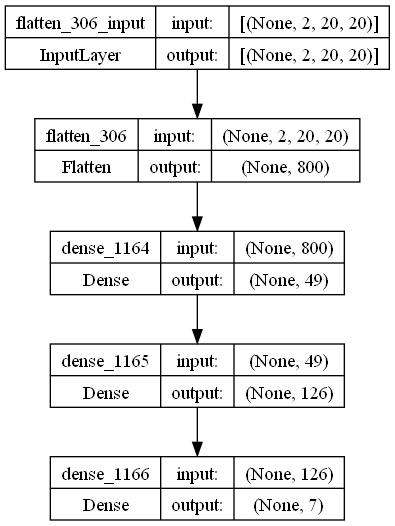

In [44]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [45]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [46]:
model.compile(optimizer=optimizer,
              loss= custom_loss,
              metrics=metrics)

In [47]:
def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.0001  # Updated final learning rate
    start_decay_epoch = 150
    end_decay_epoch = 350
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr
    
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [48]:
val_epochs = 350

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/350
70/70 [==============================] - 2s 16ms/step - loss: 19.9779 - a_1: 2.9264 - a_2: 3.0855 - b_1: 2.7666 - b_2: 2.9188 - d_1: 1.0518 - d_2: 1.0775 - n: 1.6716 - mean_metric: 0.5126 - val_loss: 16.6155 - val_a_1: 2.8327 - val_a_2: 2.8804 - val_b_1: 2.5842 - val_b_2: 2.7515 - val_d_1: 0.9084 - val_d_2: 0.9189 - val_n: 1.7721 - val_mean_metric: 0.4796 - lr: 0.0010
Epoch 2/350
70/70 [==============================] - 1s 12ms/step - loss: 15.8010 - a_1: 2.7530 - a_2: 2.9041 - b_1: 2.6372 - b_2: 2.6711 - d_1: 0.8574 - d_2: 0.8418 - n: 1.9103 - mean_metric: 0.4819 - val_loss: 15.5327 - val_a_1: 2.9544 - val_a_2: 2.9641 - val_b_1: 2.5594 - val_b_2: 2.5018 - val_d_1: 0.8379 - val_d_2: 0.8362 - val_n: 2.0121 - val_mean_metric: 0.4801 - lr: 0.0010
Epoch 3/350
70/70 [==============================] - 1s 12ms/step - loss: 14.5297 - a_1: 2.7095 - a_2: 2.9637 - b_1: 2.5727 - b_2: 2.4477 - d_1: 0.7671 - d_2: 0.7952 - n: 2.0101 - mean_metric: 0.4715 - val_loss: 13.4910 - val_a_1: 2.7

70/70 [==============================] - 1s 12ms/step - loss: 5.9270 - a_1: 2.6775 - a_2: 2.7578 - b_1: 1.8127 - b_2: 2.0606 - d_1: 0.3018 - d_2: 0.3032 - n: 2.0954 - mean_metric: 0.3969 - val_loss: 5.2975 - val_a_1: 2.6740 - val_a_2: 2.7560 - val_b_1: 1.5955 - val_b_2: 2.0291 - val_d_1: 0.2803 - val_d_2: 0.2785 - val_n: 2.1094 - val_mean_metric: 0.3838 - lr: 0.0010
Epoch 23/350
70/70 [==============================] - 1s 12ms/step - loss: 5.6764 - a_1: 2.6733 - a_2: 2.7437 - b_1: 1.8029 - b_2: 2.0581 - d_1: 0.2926 - d_2: 0.2929 - n: 2.0809 - mean_metric: 0.3948 - val_loss: 5.5709 - val_a_1: 2.6590 - val_a_2: 2.7170 - val_b_1: 1.7987 - val_b_2: 2.0419 - val_d_1: 0.2726 - val_d_2: 0.2854 - val_n: 2.0949 - val_mean_metric: 0.3886 - lr: 0.0010
Epoch 24/350
70/70 [==============================] - 1s 12ms/step - loss: 5.3883 - a_1: 2.6592 - a_2: 2.7498 - b_1: 1.7957 - b_2: 1.9895 - d_1: 0.2755 - d_2: 0.2792 - n: 2.1048 - mean_metric: 0.3918 - val_loss: 4.7582 - val_a_1: 2.6569 - val_a_2: 2

70/70 [==============================] - 1s 12ms/step - loss: 4.8647 - a_1: 2.5997 - a_2: 2.7537 - b_1: 1.6455 - b_2: 1.8205 - d_1: 0.2458 - d_2: 0.2411 - n: 2.0448 - mean_metric: 0.3752 - val_loss: 4.6425 - val_a_1: 2.6475 - val_a_2: 2.7136 - val_b_1: 1.7629 - val_b_2: 1.5890 - val_d_1: 0.2268 - val_d_2: 0.2439 - val_n: 2.0667 - val_mean_metric: 0.3683 - lr: 0.0010
Epoch 44/350
70/70 [==============================] - 1s 12ms/step - loss: 4.8540 - a_1: 2.6017 - a_2: 2.7465 - b_1: 1.6369 - b_2: 1.7490 - d_1: 0.2547 - d_2: 0.2328 - n: 2.0399 - mean_metric: 0.3721 - val_loss: 4.6735 - val_a_1: 2.6130 - val_a_2: 2.7225 - val_b_1: 1.6307 - val_b_2: 2.0495 - val_d_1: 0.2190 - val_d_2: 0.2734 - val_n: 1.9614 - val_mean_metric: 0.3754 - lr: 0.0010
Epoch 45/350
70/70 [==============================] - 1s 12ms/step - loss: 5.0000 - a_1: 2.5871 - a_2: 2.7531 - b_1: 1.6004 - b_2: 1.7753 - d_1: 0.2520 - d_2: 0.2487 - n: 2.0307 - mean_metric: 0.3717 - val_loss: 4.6634 - val_a_1: 2.6174 - val_a_2: 2

70/70 [==============================] - 1s 12ms/step - loss: 4.7781 - a_1: 2.5191 - a_2: 2.6992 - b_1: 1.5356 - b_2: 1.6504 - d_1: 0.2411 - d_2: 0.2342 - n: 1.9603 - mean_metric: 0.3582 - val_loss: 5.8398 - val_a_1: 2.5281 - val_a_2: 2.8726 - val_b_1: 1.8957 - val_b_2: 1.7862 - val_d_1: 0.2975 - val_d_2: 0.2621 - val_n: 2.0495 - val_mean_metric: 0.3828 - lr: 0.0010
Epoch 65/350
70/70 [==============================] - 1s 12ms/step - loss: 4.8337 - a_1: 2.5251 - a_2: 2.6925 - b_1: 1.4476 - b_2: 1.6581 - d_1: 0.2439 - d_2: 0.2416 - n: 1.9450 - mean_metric: 0.3553 - val_loss: 4.0485 - val_a_1: 2.5009 - val_a_2: 2.5923 - val_b_1: 1.8669 - val_b_2: 1.4817 - val_d_1: 0.2313 - val_d_2: 0.2040 - val_n: 1.8802 - val_mean_metric: 0.3521 - lr: 0.0010
Epoch 66/350
70/70 [==============================] - 1s 12ms/step - loss: 4.7356 - a_1: 2.4995 - a_2: 2.6602 - b_1: 1.4524 - b_2: 1.5937 - d_1: 0.2301 - d_2: 0.2443 - n: 1.9483 - mean_metric: 0.3512 - val_loss: 5.3032 - val_a_1: 2.5040 - val_a_2: 2

70/70 [==============================] - 1s 12ms/step - loss: 4.3224 - a_1: 2.4391 - a_2: 2.5943 - b_1: 1.3398 - b_2: 1.4430 - d_1: 0.2194 - d_2: 0.2131 - n: 1.8735 - mean_metric: 0.3345 - val_loss: 4.7097 - val_a_1: 2.4653 - val_a_2: 2.5529 - val_b_1: 1.1752 - val_b_2: 1.3301 - val_d_1: 0.2113 - val_d_2: 0.2466 - val_n: 1.9408 - val_mean_metric: 0.3248 - lr: 0.0010
Epoch 86/350
70/70 [==============================] - 1s 12ms/step - loss: 4.8133 - a_1: 2.4479 - a_2: 2.6224 - b_1: 1.4377 - b_2: 1.5536 - d_1: 0.2522 - d_2: 0.2370 - n: 1.8631 - mean_metric: 0.3442 - val_loss: 4.5612 - val_a_1: 2.4554 - val_a_2: 2.5634 - val_b_1: 1.2629 - val_b_2: 1.4552 - val_d_1: 0.2132 - val_d_2: 0.2481 - val_n: 1.8514 - val_mean_metric: 0.3290 - lr: 0.0010
Epoch 87/350
70/70 [==============================] - 1s 12ms/step - loss: 4.7029 - a_1: 2.4343 - a_2: 2.6024 - b_1: 1.4303 - b_2: 1.4874 - d_1: 0.2379 - d_2: 0.2347 - n: 1.8663 - mean_metric: 0.3401 - val_loss: 4.5792 - val_a_1: 2.4600 - val_a_2: 2

70/70 [==============================] - 1s 12ms/step - loss: 4.2905 - a_1: 2.3890 - a_2: 2.6013 - b_1: 1.2449 - b_2: 1.4335 - d_1: 0.2163 - d_2: 0.2151 - n: 1.8022 - mean_metric: 0.3273 - val_loss: 4.5916 - val_a_1: 2.4208 - val_a_2: 2.5402 - val_b_1: 1.2810 - val_b_2: 1.3100 - val_d_1: 0.2215 - val_d_2: 0.2261 - val_n: 1.7808 - val_mean_metric: 0.3202 - lr: 0.0010
Epoch 107/350
70/70 [==============================] - 1s 12ms/step - loss: 5.3049 - a_1: 2.4044 - a_2: 2.5835 - b_1: 1.4572 - b_2: 1.3975 - d_1: 0.2676 - d_2: 0.2663 - n: 1.7904 - mean_metric: 0.3360 - val_loss: 5.5669 - val_a_1: 2.4059 - val_a_2: 2.5342 - val_b_1: 1.4117 - val_b_2: 1.3779 - val_d_1: 0.3059 - val_d_2: 0.2122 - val_n: 1.6411 - val_mean_metric: 0.3237 - lr: 0.0010
Epoch 108/350
70/70 [==============================] - 1s 12ms/step - loss: 4.7483 - a_1: 2.3932 - a_2: 2.5520 - b_1: 1.2998 - b_2: 1.4189 - d_1: 0.2370 - d_2: 0.2372 - n: 1.7898 - mean_metric: 0.3282 - val_loss: 5.0807 - val_a_1: 2.4266 - val_a_2:

70/70 [==============================] - 1s 12ms/step - loss: 4.2125 - a_1: 2.3744 - a_2: 2.5207 - b_1: 1.2360 - b_2: 1.3633 - d_1: 0.2128 - d_2: 0.2130 - n: 1.8135 - mean_metric: 0.3217 - val_loss: 3.7886 - val_a_1: 2.4018 - val_a_2: 2.4863 - val_b_1: 1.1953 - val_b_2: 1.3771 - val_d_1: 0.2008 - val_d_2: 0.1738 - val_n: 1.7624 - val_mean_metric: 0.3142 - lr: 0.0010
Epoch 128/350
70/70 [==============================] - 1s 12ms/step - loss: 4.5868 - a_1: 2.3930 - a_2: 2.5266 - b_1: 1.2048 - b_2: 1.2991 - d_1: 0.2297 - d_2: 0.2283 - n: 1.8047 - mean_metric: 0.3200 - val_loss: 4.3514 - val_a_1: 2.3895 - val_a_2: 2.5033 - val_b_1: 1.1702 - val_b_2: 1.6114 - val_d_1: 0.2110 - val_d_2: 0.1825 - val_n: 1.7183 - val_mean_metric: 0.3203 - lr: 0.0010
Epoch 129/350
70/70 [==============================] - 1s 12ms/step - loss: 4.4217 - a_1: 2.3533 - a_2: 2.4997 - b_1: 1.2133 - b_2: 1.3215 - d_1: 0.2194 - d_2: 0.2250 - n: 1.7886 - mean_metric: 0.3179 - val_loss: 3.7912 - val_a_1: 2.3357 - val_a_2:

70/70 [==============================] - 1s 12ms/step - loss: 4.1950 - a_1: 2.4454 - a_2: 2.5706 - b_1: 1.1484 - b_2: 1.2636 - d_1: 0.2109 - d_2: 0.2105 - n: 1.7489 - mean_metric: 0.3172 - val_loss: 5.1796 - val_a_1: 2.4911 - val_a_2: 2.5493 - val_b_1: 1.2830 - val_b_2: 1.2395 - val_d_1: 0.2513 - val_d_2: 0.2467 - val_n: 1.7435 - val_mean_metric: 0.3209 - lr: 0.0010
Epoch 149/350
70/70 [==============================] - 1s 12ms/step - loss: 4.3210 - a_1: 2.4519 - a_2: 2.5803 - b_1: 1.2213 - b_2: 1.2606 - d_1: 0.2193 - d_2: 0.2122 - n: 1.7600 - mean_metric: 0.3207 - val_loss: 4.4434 - val_a_1: 2.4711 - val_a_2: 2.5554 - val_b_1: 0.9445 - val_b_2: 1.5956 - val_d_1: 0.1803 - val_d_2: 0.2279 - val_n: 1.6157 - val_mean_metric: 0.3139 - lr: 0.0010
Epoch 150/350
70/70 [==============================] - 1s 12ms/step - loss: 4.4176 - a_1: 2.4347 - a_2: 2.5661 - b_1: 1.1546 - b_2: 1.3020 - d_1: 0.2196 - d_2: 0.2247 - n: 1.7363 - mean_metric: 0.3185 - val_loss: 4.2976 - val_a_1: 2.4696 - val_a_2:

70/70 [==============================] - 1s 12ms/step - loss: 4.2672 - a_1: 2.4536 - a_2: 2.5736 - b_1: 1.1738 - b_2: 1.2637 - d_1: 0.2156 - d_2: 0.2160 - n: 1.7483 - mean_metric: 0.3187 - val_loss: 3.8327 - val_a_1: 2.4103 - val_a_2: 2.4796 - val_b_1: 1.0434 - val_b_2: 1.4344 - val_d_1: 0.1990 - val_d_2: 0.1856 - val_n: 1.6527 - val_mean_metric: 0.3079 - lr: 9.1900e-04
Epoch 170/350
70/70 [==============================] - 1s 12ms/step - loss: 4.1680 - a_1: 2.3695 - a_2: 2.4817 - b_1: 1.0961 - b_2: 1.2798 - d_1: 0.2067 - d_2: 0.2125 - n: 1.7481 - mean_metric: 0.3105 - val_loss: 3.8958 - val_a_1: 2.4176 - val_a_2: 2.4792 - val_b_1: 1.1956 - val_b_2: 1.4265 - val_d_1: 0.1773 - val_d_2: 0.1909 - val_n: 1.6701 - val_mean_metric: 0.3128 - lr: 9.1450e-04
Epoch 171/350
70/70 [==============================] - 1s 12ms/step - loss: 4.6157 - a_1: 2.3959 - a_2: 2.5122 - b_1: 1.2074 - b_2: 1.2889 - d_1: 0.2317 - d_2: 0.2353 - n: 1.7265 - mean_metric: 0.3171 - val_loss: 3.9558 - val_a_1: 2.3907 - 

70/70 [==============================] - 1s 12ms/step - loss: 4.2184 - a_1: 2.3914 - a_2: 2.4785 - b_1: 1.2202 - b_2: 1.2442 - d_1: 0.2076 - d_2: 0.2168 - n: 1.7322 - mean_metric: 0.3136 - val_loss: 3.6472 - val_a_1: 2.3818 - val_a_2: 2.4494 - val_b_1: 1.1024 - val_b_2: 1.2885 - val_d_1: 0.1750 - val_d_2: 0.1926 - val_n: 1.6308 - val_mean_metric: 0.3018 - lr: 8.2450e-04
Epoch 191/350
70/70 [==============================] - 1s 12ms/step - loss: 3.8160 - a_1: 2.3744 - a_2: 2.4513 - b_1: 1.1154 - b_2: 1.2479 - d_1: 0.1897 - d_2: 0.1978 - n: 1.7277 - mean_metric: 0.3074 - val_loss: 3.6826 - val_a_1: 2.3070 - val_a_2: 2.3882 - val_b_1: 1.0939 - val_b_2: 1.5136 - val_d_1: 0.1717 - val_d_2: 0.1932 - val_n: 1.5729 - val_mean_metric: 0.3025 - lr: 8.2000e-04
Epoch 192/350
70/70 [==============================] - 1s 12ms/step - loss: 3.7533 - a_1: 2.4119 - a_2: 2.4989 - b_1: 1.0863 - b_2: 1.1857 - d_1: 0.1847 - d_2: 0.1919 - n: 1.7296 - mean_metric: 0.3069 - val_loss: 5.4936 - val_a_1: 2.4165 - 

70/70 [==============================] - 1s 12ms/step - loss: 3.7248 - a_1: 2.3681 - a_2: 2.4774 - b_1: 1.1263 - b_2: 1.2430 - d_1: 0.1822 - d_2: 0.1954 - n: 1.7558 - mean_metric: 0.3090 - val_loss: 3.3429 - val_a_1: 2.3835 - val_a_2: 2.4627 - val_b_1: 1.0762 - val_b_2: 1.3594 - val_d_1: 0.1557 - val_d_2: 0.1749 - val_n: 1.5854 - val_mean_metric: 0.3011 - lr: 7.3000e-04
Epoch 212/350
70/70 [==============================] - 1s 12ms/step - loss: 3.5052 - a_1: 2.3815 - a_2: 2.4600 - b_1: 1.1073 - b_2: 1.1878 - d_1: 0.1751 - d_2: 0.1783 - n: 1.7479 - mean_metric: 0.3053 - val_loss: 3.4513 - val_a_1: 2.3816 - val_a_2: 2.4546 - val_b_1: 1.0428 - val_b_2: 1.1992 - val_d_1: 0.1631 - val_d_2: 0.1945 - val_n: 1.6944 - val_mean_metric: 0.2989 - lr: 7.2550e-04
Epoch 213/350
70/70 [==============================] - 1s 12ms/step - loss: 3.5898 - a_1: 2.3630 - a_2: 2.4535 - b_1: 1.0839 - b_2: 1.1957 - d_1: 0.1789 - d_2: 0.1855 - n: 1.7566 - mean_metric: 0.3046 - val_loss: 3.3258 - val_a_1: 2.2807 - 

70/70 [==============================] - 1s 12ms/step - loss: 3.6007 - a_1: 2.4655 - a_2: 2.5012 - b_1: 1.0943 - b_2: 1.1284 - d_1: 0.1832 - d_2: 0.1809 - n: 1.7485 - mean_metric: 0.3074 - val_loss: 4.0863 - val_a_1: 2.3251 - val_a_2: 2.3749 - val_b_1: 1.3355 - val_b_2: 1.6311 - val_d_1: 0.1868 - val_d_2: 0.1573 - val_n: 1.5363 - val_mean_metric: 0.3125 - lr: 6.3550e-04
Epoch 233/350
70/70 [==============================] - 1s 12ms/step - loss: 3.6136 - a_1: 2.3547 - a_2: 2.4038 - b_1: 1.0994 - b_2: 1.1799 - d_1: 0.1800 - d_2: 0.1855 - n: 1.7447 - mean_metric: 0.3024 - val_loss: 3.7388 - val_a_1: 2.3630 - val_a_2: 2.4581 - val_b_1: 1.4824 - val_b_2: 1.1418 - val_d_1: 0.1678 - val_d_2: 0.2089 - val_n: 1.6041 - val_mean_metric: 0.3086 - lr: 6.3100e-04
Epoch 234/350
70/70 [==============================] - 1s 12ms/step - loss: 3.7768 - a_1: 2.4045 - a_2: 2.4638 - b_1: 1.0995 - b_2: 1.1843 - d_1: 0.1900 - d_2: 0.1882 - n: 1.7283 - mean_metric: 0.3060 - val_loss: 3.3079 - val_a_1: 2.3777 - 

70/70 [==============================] - 1s 12ms/step - loss: 3.0660 - a_1: 2.3589 - a_2: 2.4152 - b_1: 1.0496 - b_2: 1.1301 - d_1: 0.1555 - d_2: 0.1571 - n: 1.7609 - mean_metric: 0.2983 - val_loss: 3.9261 - val_a_1: 2.3407 - val_a_2: 2.3764 - val_b_1: 0.9306 - val_b_2: 1.1276 - val_d_1: 0.1867 - val_d_2: 0.2113 - val_n: 1.7628 - val_mean_metric: 0.2925 - lr: 5.4100e-04
Epoch 254/350
70/70 [==============================] - 1s 12ms/step - loss: 3.1858 - a_1: 2.3580 - a_2: 2.4079 - b_1: 1.0601 - b_2: 1.1329 - d_1: 0.1603 - d_2: 0.1627 - n: 1.7655 - mean_metric: 0.2990 - val_loss: 3.1132 - val_a_1: 2.5115 - val_a_2: 2.4399 - val_b_1: 1.1238 - val_b_2: 1.0882 - val_d_1: 0.1673 - val_d_2: 0.1447 - val_n: 1.8411 - val_mean_metric: 0.3049 - lr: 5.3650e-04
Epoch 255/350
70/70 [==============================] - 1s 12ms/step - loss: 3.3213 - a_1: 2.3545 - a_2: 2.3963 - b_1: 1.1135 - b_2: 1.1230 - d_1: 0.1665 - d_2: 0.1691 - n: 1.7596 - mean_metric: 0.3002 - val_loss: 2.8693 - val_a_1: 2.3404 - 

70/70 [==============================] - 1s 12ms/step - loss: 3.1366 - a_1: 2.3779 - a_2: 2.4003 - b_1: 1.0497 - b_2: 1.1422 - d_1: 0.1580 - d_2: 0.1590 - n: 1.7778 - mean_metric: 0.2997 - val_loss: 2.9920 - val_a_1: 2.4185 - val_a_2: 2.4322 - val_b_1: 1.2128 - val_b_2: 1.0139 - val_d_1: 0.1460 - val_d_2: 0.1437 - val_n: 1.7962 - val_mean_metric: 0.3000 - lr: 4.4650e-04
Epoch 275/350
70/70 [==============================] - 1s 12ms/step - loss: 2.9698 - a_1: 2.3581 - a_2: 2.3655 - b_1: 1.0574 - b_2: 1.1293 - d_1: 0.1488 - d_2: 0.1532 - n: 1.7592 - mean_metric: 0.2964 - val_loss: 3.1138 - val_a_1: 2.3510 - val_a_2: 2.3115 - val_b_1: 1.1487 - val_b_2: 1.0963 - val_d_1: 0.1438 - val_d_2: 0.1772 - val_n: 1.7197 - val_mean_metric: 0.2929 - lr: 4.4200e-04
Epoch 276/350
70/70 [==============================] - 1s 12ms/step - loss: 3.1413 - a_1: 2.3799 - a_2: 2.3974 - b_1: 1.0627 - b_2: 1.1237 - d_1: 0.1575 - d_2: 0.1592 - n: 1.7735 - mean_metric: 0.2992 - val_loss: 3.0145 - val_a_1: 2.3524 - 

70/70 [==============================] - 1s 12ms/step - loss: 3.0010 - a_1: 2.3594 - a_2: 2.3531 - b_1: 1.0576 - b_2: 1.1029 - d_1: 0.1522 - d_2: 0.1511 - n: 1.7839 - mean_metric: 0.2961 - val_loss: 3.6082 - val_a_1: 2.4893 - val_a_2: 2.4344 - val_b_1: 1.0968 - val_b_2: 1.3112 - val_d_1: 0.1931 - val_d_2: 0.1383 - val_n: 1.8110 - val_mean_metric: 0.3100 - lr: 3.5200e-04
Epoch 296/350
70/70 [==============================] - 1s 12ms/step - loss: 2.9290 - a_1: 2.3719 - a_2: 2.3581 - b_1: 1.0782 - b_2: 1.1616 - d_1: 0.1485 - d_2: 0.1499 - n: 1.7757 - mean_metric: 0.2989 - val_loss: 2.9520 - val_a_1: 2.3571 - val_a_2: 2.3058 - val_b_1: 0.9385 - val_b_2: 1.2807 - val_d_1: 0.1403 - val_d_2: 0.1491 - val_n: 1.7340 - val_mean_metric: 0.2915 - lr: 3.4750e-04
Epoch 297/350
70/70 [==============================] - 1s 12ms/step - loss: 2.8440 - a_1: 2.3663 - a_2: 2.3458 - b_1: 1.0467 - b_2: 1.1128 - d_1: 0.1454 - d_2: 0.1437 - n: 1.7803 - mean_metric: 0.2954 - val_loss: 2.8292 - val_a_1: 2.3471 - 

70/70 [==============================] - 1s 12ms/step - loss: 2.7581 - a_1: 2.3925 - a_2: 2.3596 - b_1: 1.0395 - b_2: 1.1097 - d_1: 0.1404 - d_2: 0.1398 - n: 1.7905 - mean_metric: 0.2964 - val_loss: 3.0947 - val_a_1: 2.3979 - val_a_2: 2.3652 - val_b_1: 0.9257 - val_b_2: 1.0576 - val_d_1: 0.1663 - val_d_2: 0.1376 - val_n: 1.7979 - val_mean_metric: 0.2896 - lr: 2.5750e-04
Epoch 317/350
70/70 [==============================] - 1s 12ms/step - loss: 2.9322 - a_1: 2.3813 - a_2: 2.3478 - b_1: 1.0429 - b_2: 1.1086 - d_1: 0.1475 - d_2: 0.1463 - n: 1.7890 - mean_metric: 0.2961 - val_loss: 3.2902 - val_a_1: 2.4133 - val_a_2: 2.3542 - val_b_1: 1.0411 - val_b_2: 1.0044 - val_d_1: 0.1447 - val_d_2: 0.1781 - val_n: 1.7828 - val_mean_metric: 0.2919 - lr: 2.5300e-04
Epoch 318/350
70/70 [==============================] - 1s 12ms/step - loss: 2.7708 - a_1: 2.3709 - a_2: 2.3240 - b_1: 1.0340 - b_2: 1.1135 - d_1: 0.1393 - d_2: 0.1423 - n: 1.7838 - mean_metric: 0.2944 - val_loss: 2.8907 - val_a_1: 2.4468 - 

70/70 [==============================] - 1s 12ms/step - loss: 2.5043 - a_1: 2.3865 - a_2: 2.3114 - b_1: 1.0362 - b_2: 1.1046 - d_1: 0.1289 - d_2: 0.1282 - n: 1.8051 - mean_metric: 0.2941 - val_loss: 2.4977 - val_a_1: 2.4230 - val_a_2: 2.2731 - val_b_1: 0.9979 - val_b_2: 1.1246 - val_d_1: 0.1292 - val_d_2: 0.1268 - val_n: 1.7970 - val_mean_metric: 0.2903 - lr: 1.6300e-04
Epoch 338/350
70/70 [==============================] - 1s 12ms/step - loss: 2.5074 - a_1: 2.3948 - a_2: 2.3244 - b_1: 1.0343 - b_2: 1.1041 - d_1: 0.1290 - d_2: 0.1277 - n: 1.8116 - mean_metric: 0.2950 - val_loss: 2.5686 - val_a_1: 2.4590 - val_a_2: 2.2915 - val_b_1: 0.9785 - val_b_2: 1.1213 - val_d_1: 0.1318 - val_d_2: 0.1275 - val_n: 1.8291 - val_mean_metric: 0.2925 - lr: 1.5850e-04
Epoch 339/350
70/70 [==============================] - 1s 12ms/step - loss: 2.4994 - a_1: 2.3950 - a_2: 2.3213 - b_1: 1.0400 - b_2: 1.1092 - d_1: 0.1284 - d_2: 0.1278 - n: 1.8129 - mean_metric: 0.2952 - val_loss: 2.6293 - val_a_1: 2.4588 - 

# Analizamos accuracy y loss

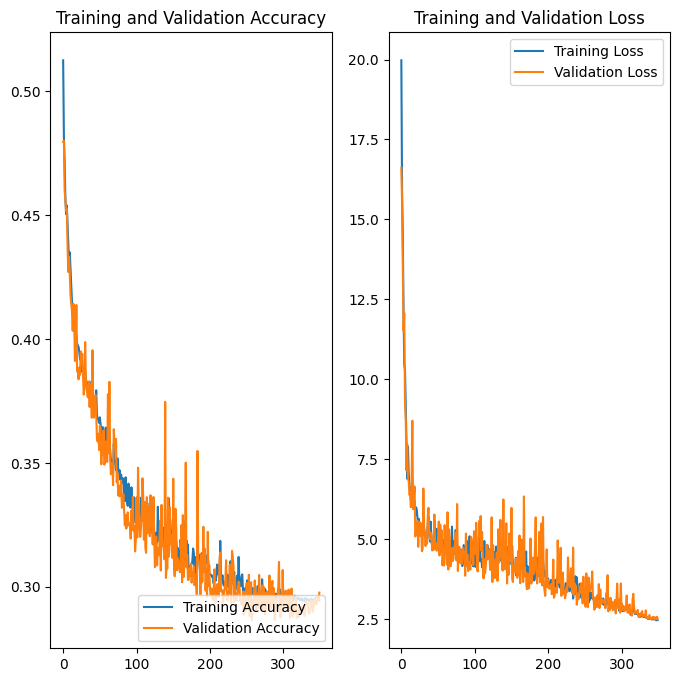

In [49]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

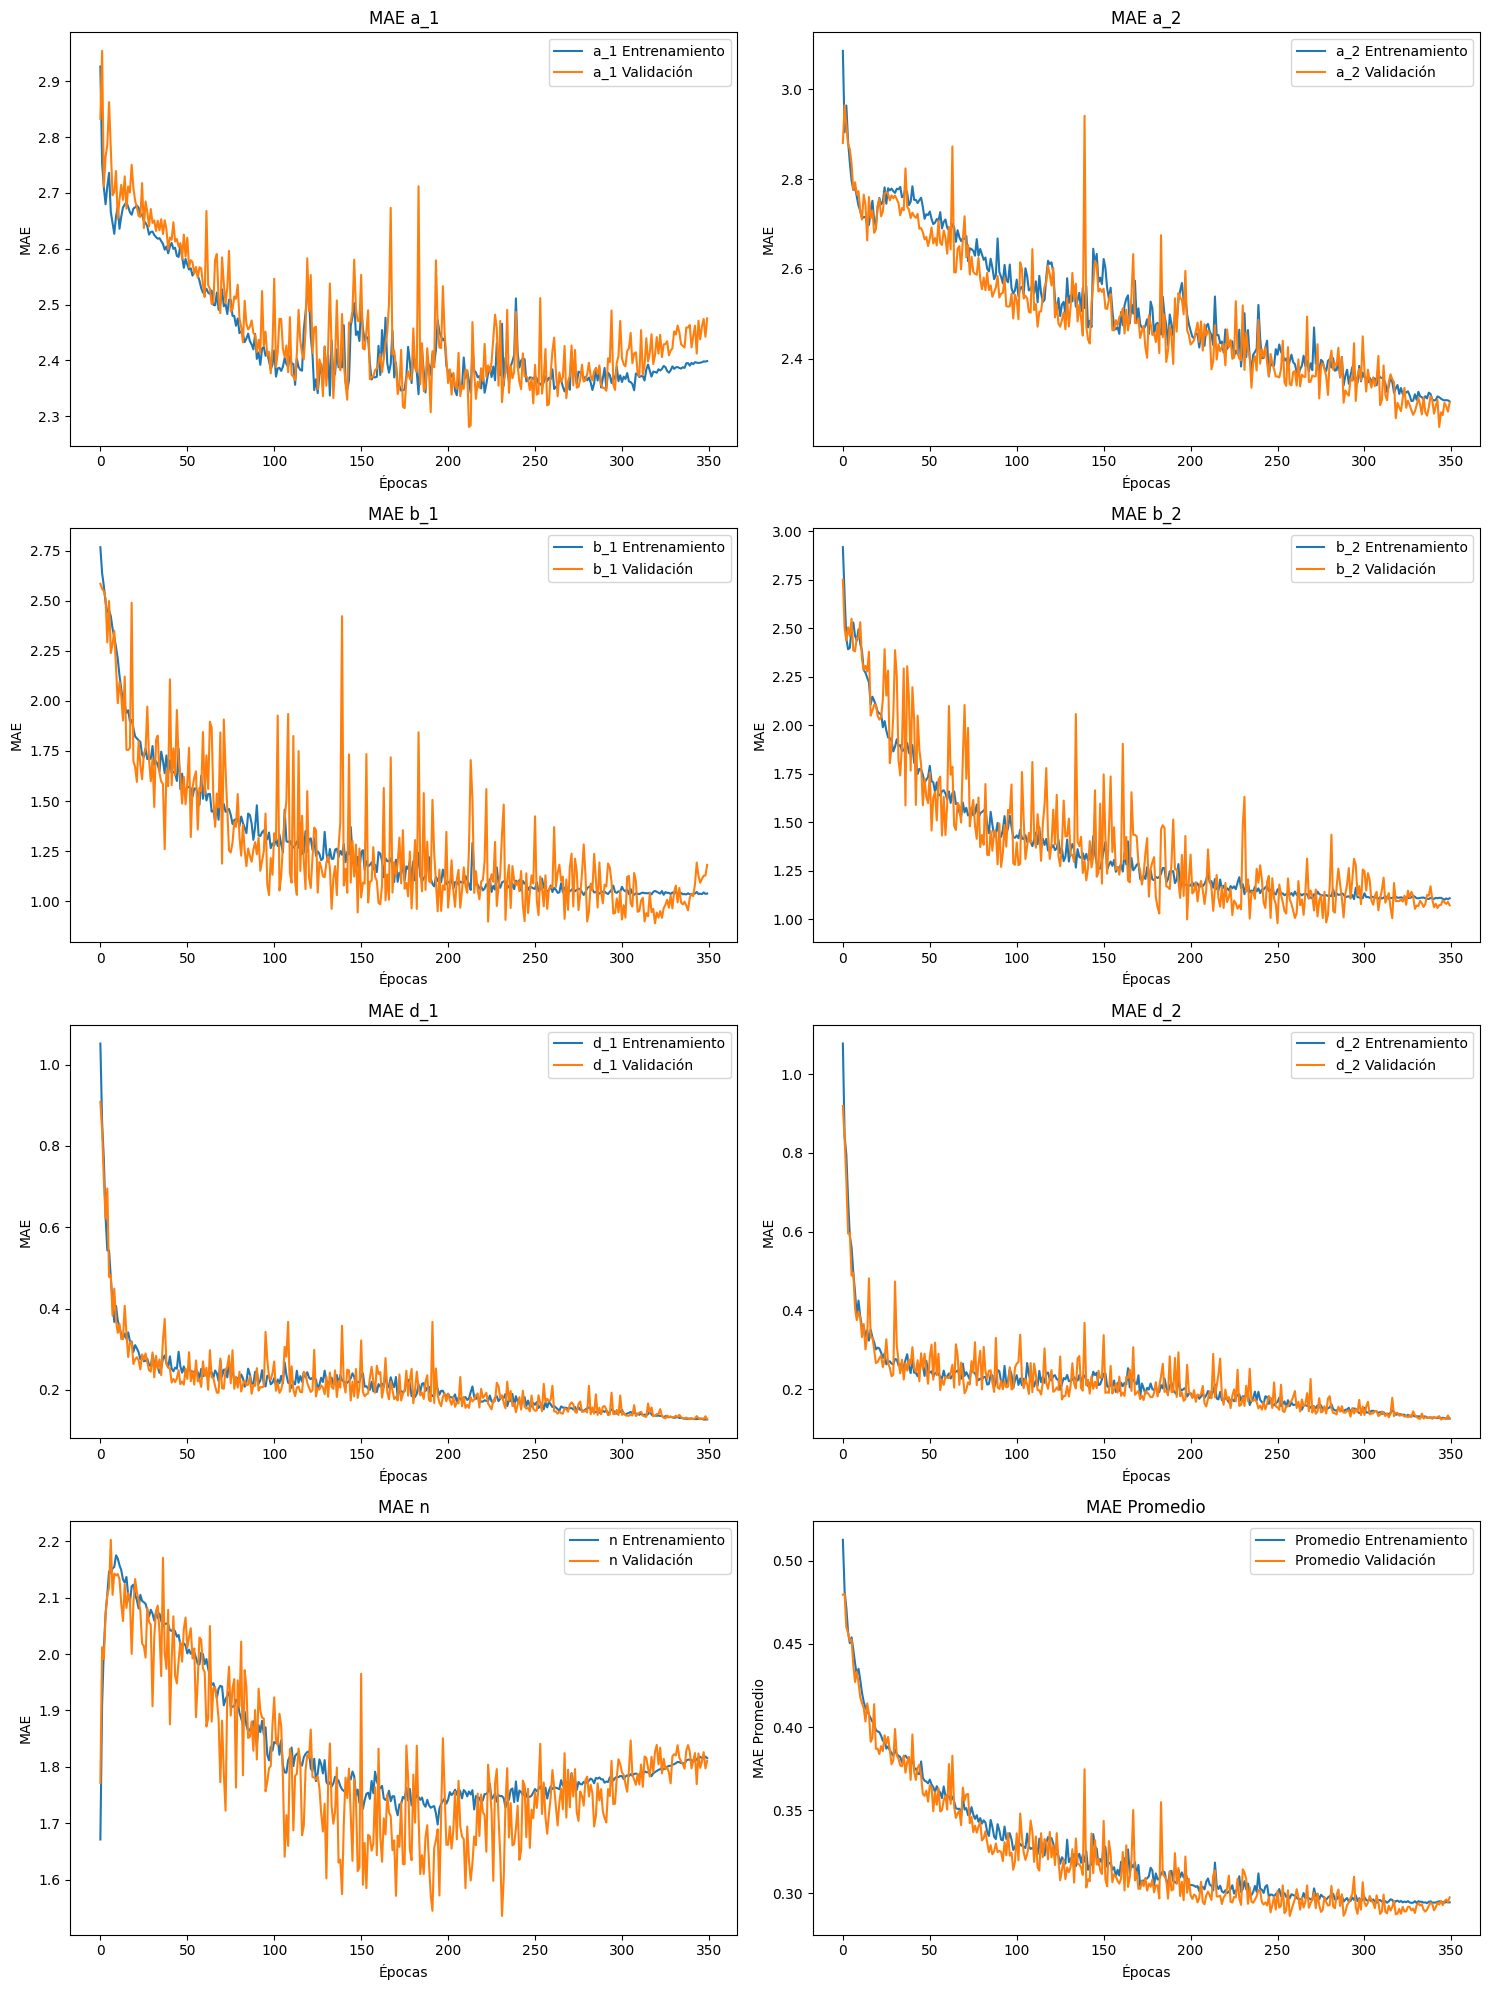

In [50]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [51]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

32/32 [==============================] - 0s 2ms/step - loss: 2.5405 - a_1: 2.4161 - a_2: 2.3389 - b_1: 1.1766 - b_2: 1.0524 - d_1: 0.1352 - d_2: 0.1226 - n: 1.8000 - mean_metric: 0.2957


In [52]:
predictions = model.predict(campvectest)

32/32 [==============================] - 0s 739us/step


In [53]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 7  2 10  1 10  0  1]
[3.9011765  2.7935064  6.570245   1.3093632  9.18039    0.03698728
 0.73316276]
[31 32 28 49 25 38 26 42 31 27 24 18 37 33 38 30 24 36 37 38 36 33 20 37
 24 35 39 26 22 26 39 26 38 42 17 23 26 25 36 24 42 34 42 29 38 28 41 30
 34 35 42 16 26 28 40 28 32 40 28 35 28 38 34 32 42 39 38 29 33 38 34 30
 32 39 32 27 31 38 22 36 29 30 35 32 43 32 29 30 41 22 23 47 31 26 34 19
 29 42 30 22 33 38 25 29 36 41 34 40 32 35 40 39 31 38 21 37 43 40 30 41
 31 29 40 31 34 36 54 26 39 29 50 26 47 33 44 11 47 27 33 18 32 43 36 34
 30 34 38 46 24 32 21 48 41 44 42 40 35 29 34 31 33 28 37 30 29 38 35 33
 32 25 38 35 25 27 21 28 38 40 23 38 34 22 42 37 33 20 40 22 35 34 24 33
 37 31 35 31 28 23 36 34 40 25 30 31 34 39 26 26 37 36 45 34 28 30 39 37
 37 35 33 45 31 35 37 31 38 27 35 29 23 51 20 25 31 24 37 43 27 25 27 37
 26 36 36 39 34 23 24 44 31 30 43 41 31 32 40 28 40 32 36 24 47 44 20 28
 29 35 27 30 27 37 53 43 47 46 21 20 20 31 39 28 38 26 36 41 27 30 50 33
 34 37 27 35 23 37 39

1.2506975073899542

In [54]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.2882128438815208, Desviación estándar del error: 1.8478259147195333, Error absoluto máximo: 8.144452810287476


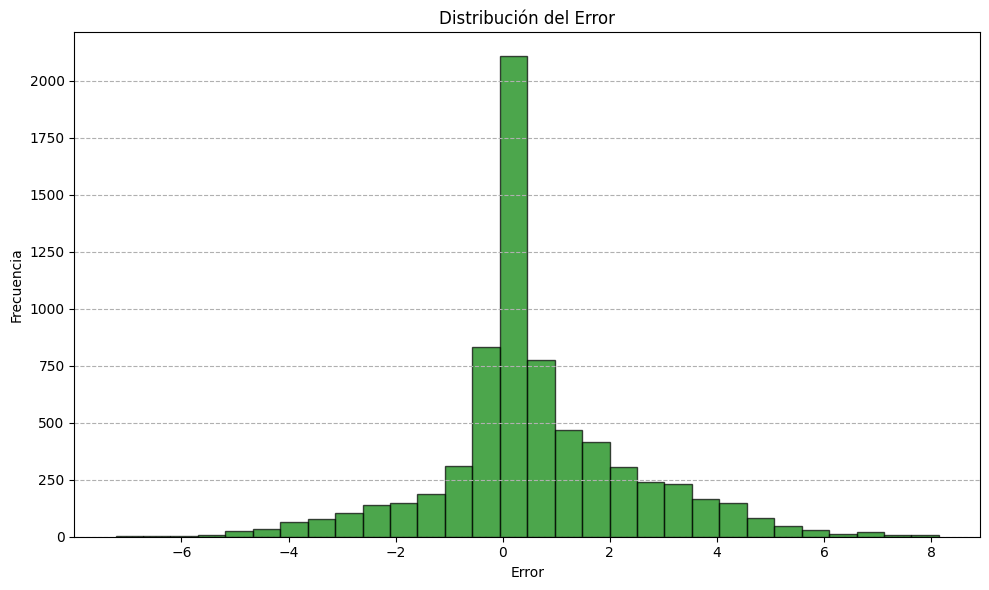

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [56]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.285649339681832
Desviación estándar del error relativo: 0.1162961246520359
Error absoluto máximo relativo: 0.7135291153734381


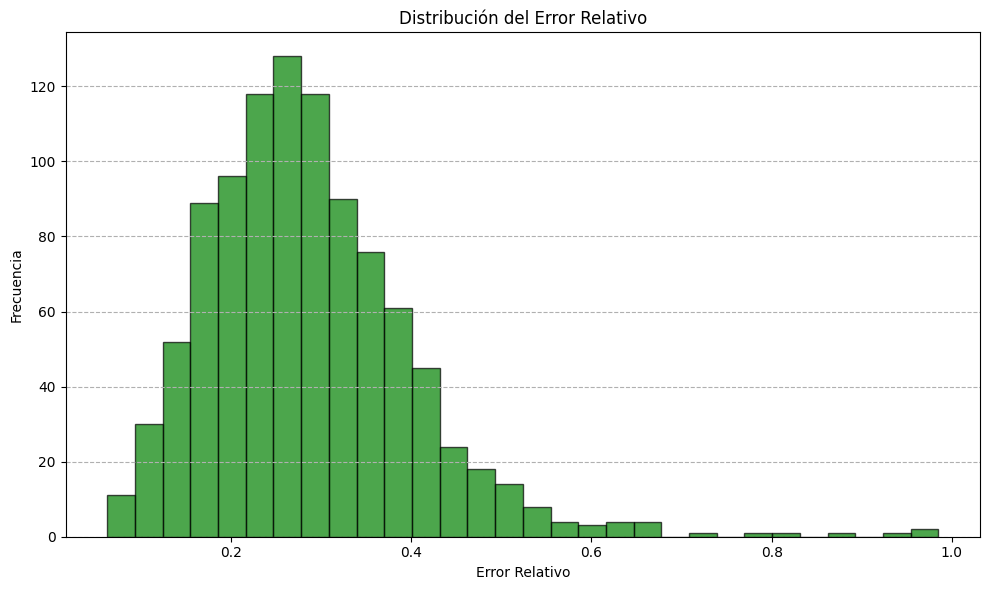

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos Accuracy y Loss

In [58]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historycampvec20funcioncosto.csv', index=False)

# Guardamos el modelo

In [59]:
path_to_save = '../../../Modelos/Modelos 20,50'

In [60]:
model.save(path_to_save + '/campovectorial20funcioncosto.h5')

# Importamos el modelo

In [61]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [62]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [63]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation, 'custom_loss': custom_loss,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)

In [64]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 20,20))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 20,20))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 20)
    y2 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 20,20))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 20,20))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 20)
    y22 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

In [65]:
new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/campovectorial20funcioncosto.h5', 
                                     custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [55]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[3, 5, 2, 0, 2, 4, 4]
1


In [ ]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [ ]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

## Encontramos puntos de equilibrio datos reales

In [ ]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b2
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

## Graficamos con los coeficientes reales

In [ ]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]

y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')
plt.show()

## Encontramos puntos de equilibrio datos predecidos

In [ ]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b2pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

## Graficamos con los coeficientes predecidos

In [ ]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1 = np.linspace(x_range_neg, x_range_pos, 20)
y2 = np.linspace(y_range_neg, y_range_pos, 20)

Y1, Y2 = np.meshgrid(y1, y2)
    
t1 = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

u1, v1 = f(t1, [Y1, Y2])
u, v = f(t1, [Y1, Y2])
M = (np.hypot(u, v))
u /= M
v /= M
    
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')